### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns

from textwrap import wrap

### Ground truth

In [4]:
protons = [16, 12]

In [5]:
molar_proportions = [0.3865, 0.6135]

In [6]:
real_visible_proportions = [prop*prot for prop, prot in zip(molar_proportions, protons)]
real_visible_proportions = [rp/sum(real_visible_proportions) for rp in real_visible_proportions]
real_visible_proportions

[0.4565185294551898, 0.5434814705448103]

### Loading the data

In [7]:
official_names = ['Pinene', 'Benzyl_benzoate']

In [8]:
# ppm = #np.array with shape (number_of_points on frequency axis for mixture,)
# mix = #np.array with shape (number_of_points on frequency axis,)
# ppm_comp = #np.array with shape (number_of_points on frequency axis for components, )
# components = #np.array with shape (number_of_points on frequency axis for components, number of components)
# real_visible_proportions = #np.array with shape (number of components,)

In [9]:
data = np.loadtxt(os.getcwd()+'/mini_perfumy_duze_pole_CDCl3.csv', skiprows=1, usecols=range(5),
                      delimiter='\t',dtype=float)
ppm = data[:,0]
mix = data[:,4]
ppm_components = data[:,0]
components = data[:,1:3]

In [10]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [11]:
spectra = []
for comp_ints in components_ints:
    spectra.append(Spectrum(confs=list(zip(ppm_components, comp_ints))))

In [12]:
mix = Spectrum(confs=list(zip(ppm,mix)))

### Preprocessing

In [13]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        shift_coef = (min_of_min - epsilon)*(-1)
        for i, arr in enumerate(old_confs):
            new_ppm_non_unique = arr[:,0] + shift_coef
            resampled = res[i].resample(np.unique(new_ppm_non_unique) - shift_coef)
            new_ppm_unique = np.array(resampled.confs)[:,0]
            new_ints = np.array(resampled.confs)[:,1]
            res[i] = Spectrum(confs=list(zip(new_ppm_unique + shift_coef, new_ints)))
        return(res)
    else:
        return(list_of_spectra)

In [14]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [15]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [16]:
spectra_and_mixture = spectra + [mix]

In [17]:
spectra_and_mixture = shift(spectra_and_mixture)

In [18]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [19]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [20]:
cma = common_mass_axis(spectra_and_mixture)

In [21]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [22]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [23]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [24]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [25]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [26]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [27]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

<IPython.core.display.Javascript object>


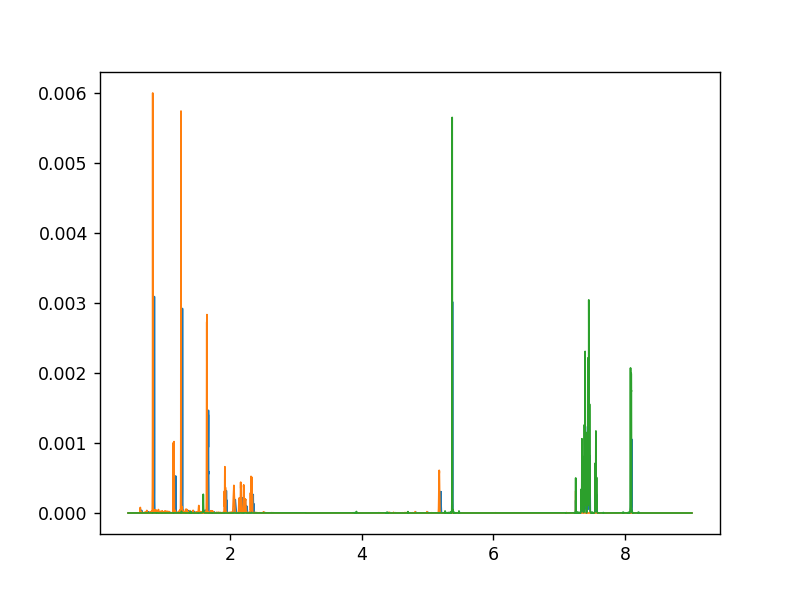

In [28]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 

### Finding best parameters

In [29]:
import time
import pandas as pd
import pulp

In [30]:
lower_limit = 0.01
upper_limit = 0.51
step = 0.01

In [29]:
# list_of_estimation_results = []
# for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
#     fixed_kappa = []
#     for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
#         start = time.time()
#         estimation = estimate_proportions(mix, [comp0, comp1], 
#                                    MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False))
#         end = time.time()
#         fixed_kappa.append(estimation['proportions'])
#         print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
#         print('It took: '+str(end-start)+' seconds.')
#         print(estimation['proportions'])
#     list_of_estimation_results.append(fixed_kappa)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3198683.17it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.36s/it]


Estimation for 0.01 and 0.01 done
It took: 66.46668910980225 seconds.
[0.025579499933999994, 0.5259602004659999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3142500.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.70s/it]


Estimation for 0.01 and 0.02 done
It took: 73.79024529457092 seconds.
[0.008549269307999999, 0.5109137827889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30727.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3037166.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.82s/it]


Estimation for 0.01 and 0.03 done
It took: 74.90835905075073 seconds.
[0.008430950665999998, 0.5097136963619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2888149.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.88s/it]


Estimation for 0.01 and 0.04 done
It took: 70.9692645072937 seconds.
[0.008164710573999999, 0.5082119510999998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20867.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3085317.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.65s/it]


Estimation for 0.01 and 0.05 done
It took: 71.73813223838806 seconds.
[0.008098468997999998, 0.5078445813769998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3261159.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.79s/it]


Estimation for 0.01 and 0.060000000000000005 done
It took: 60.88093614578247 seconds.
[0.007939365642999999, 0.5067683456759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3385049.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.64s/it]


Estimation for 0.01 and 0.06999999999999999 done
It took: 52.72432589530945 seconds.
[0.007787650965999998, 0.5056325170639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3290806.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.57s/it]


Estimation for 0.01 and 0.08 done
It took: 64.65366458892822 seconds.
[0.007639029820999998, 0.5046885605149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3009991.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.65s/it]


Estimation for 0.01 and 0.09 done
It took: 90.74719762802124 seconds.
[0.007496899878999998, 0.5037389897739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2947002.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.87s/it]


Estimation for 0.01 and 0.09999999999999999 done
It took: 88.9689474105835 seconds.
[0.007368294571999999, 0.5025659236519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2635796.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.49s/it]


Estimation for 0.01 and 0.11 done
It took: 71.58392405509949 seconds.
[0.007336099480999998, 0.4999466333929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2941419.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.68s/it]


Estimation for 0.01 and 0.12 done
It took: 83.77499270439148 seconds.
[0.007324827039999998, 0.4997919497899999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2480055.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.22s/it]


Estimation for 0.01 and 0.13 done
It took: 84.32577514648438 seconds.
[0.007324926063999998, 0.4997698519099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2997027.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.48s/it]


Estimation for 0.01 and 0.14 done
It took: 83.57564115524292 seconds.
[0.0072974100209999984, 0.4994790643949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22919.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2868353.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.39s/it]


Estimation for 0.01 and 0.15000000000000002 done
It took: 93.48411059379578 seconds.
[0.007234200666999998, 0.4994800195949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3109478.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.14s/it]


Estimation for 0.01 and 0.16 done
It took: 84.2252049446106 seconds.
[0.007248228948999998, 0.4994803461459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3400891.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.66s/it]


Estimation for 0.01 and 0.17 done
It took: 52.741477727890015 seconds.
[0.007234246398999999, 0.4994831770979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3330368.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.06s/it]


Estimation for 0.01 and 0.18000000000000002 done
It took: 69.14050149917603 seconds.
[0.007234288702999999, 0.4994860979469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3297831.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.47s/it]


Estimation for 0.01 and 0.19 done
It took: 75.55862402915955 seconds.
[0.007234322243999999, 0.4994884137729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40524.68it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2945648.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:49<00:00, 109.71s/it]


Estimation for 0.01 and 0.2 done
It took: 109.80663275718689 seconds.
[0.007232426487999998, 0.49939702964799987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2705258.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:50<00:00, 110.80s/it]


Estimation for 0.01 and 0.21000000000000002 done
It took: 110.89509701728821 seconds.
[0.007229435613999999, 0.4993597643119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2923523.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:37<00:00, 97.19s/it]


Estimation for 0.01 and 0.22 done
It took: 97.28634119033813 seconds.
[0.007234483467999998, 0.49936315735999987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3065442.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:37<00:00, 97.87s/it]


Estimation for 0.01 and 0.23 done
It took: 97.9656114578247 seconds.
[0.007194298313999998, 0.4993648790259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2938343.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.92s/it]


Estimation for 0.01 and 0.24000000000000002 done
It took: 92.00950455665588 seconds.
[0.007189729795999998, 0.4993667769279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3211846.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.31s/it]


Estimation for 0.01 and 0.25 done
It took: 70.40276432037354 seconds.
[0.007186762043999998, 0.4993695826759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2964413.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:50<00:00, 110.10s/it]


Estimation for 0.01 and 0.26 done
It took: 110.18852591514587 seconds.
[0.007186791946999998, 0.4993716604589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3312978.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.35s/it]


Estimation for 0.01 and 0.27 done
It took: 74.4300651550293 seconds.
[0.007186844987999998, 0.4991519161939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3459757.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:46<00:00, 106.27s/it]


Estimation for 0.01 and 0.28 done
It took: 106.34750580787659 seconds.
[0.007183795814999999, 0.4990953595499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3158176.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.69s/it]


Estimation for 0.01 and 0.29000000000000004 done
It took: 52.77263259887695 seconds.
[0.007160176967999999, 0.4989418818199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34663.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3193973.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.91s/it]


Estimation for 0.01 and 0.3 done
It took: 82.00236582756042 seconds.
[0.007160384785999998, 0.4989244181209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3373206.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.57s/it]


Estimation for 0.01 and 0.31 done
It took: 93.65552735328674 seconds.
[0.0071605468699999985, 0.49891052388899987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2804629.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:53<00:00, 113.02s/it]


Estimation for 0.01 and 0.32 done
It took: 113.12390756607056 seconds.
[0.007159177960999998, 0.4988494517079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37282.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3056771.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.06s/it]


Estimation for 0.01 and 0.33 done
It took: 64.1513102054596 seconds.
[0.007129148027999998, 0.4988522073499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3270486.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.72s/it]


Estimation for 0.01 and 0.34 done
It took: 78.79724311828613 seconds.
[0.0071612149069999985, 0.49885464115599987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3334395.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.62s/it]


Estimation for 0.01 and 0.35000000000000003 done
It took: 79.7026698589325 seconds.
[0.007103867134999998, 0.4988575584599999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2670293.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.52s/it]


Estimation for 0.01 and 0.36000000000000004 done
It took: 82.62046384811401 seconds.
[0.007103908190999998, 0.4988051049029999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3084221.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.51s/it]


Estimation for 0.01 and 0.37 done
It took: 87.60169386863708 seconds.
[0.007089314604999998, 0.4987945876199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3311862.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.59s/it]


Estimation for 0.01 and 0.38 done
It took: 64.66667151451111 seconds.
[0.007084264368999998, 0.4987837503299999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3345777.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.51s/it]


Estimation for 0.01 and 0.39 done
It took: 120.59845805168152 seconds.
[0.007104048947999998, 0.4986634364339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2868604.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.50s/it]


Estimation for 0.01 and 0.4 done
It took: 70.58985424041748 seconds.
[0.007050460784999998, 0.4985711005219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3139824.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.87s/it]


Estimation for 0.01 and 0.41000000000000003 done
It took: 64.95729875564575 seconds.
[0.007050508220999998, 0.4984212534209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3200626.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.26s/it]


Estimation for 0.01 and 0.42000000000000004 done
It took: 45.34004855155945 seconds.
[0.007050574566999999, 0.4984259436129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2979412.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.08s/it]


Estimation for 0.01 and 0.43 done
It took: 96.17380976676941 seconds.
[0.007050574566999999, 0.4984259436129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2697787.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.06s/it]


Estimation for 0.01 and 0.44 done
It took: 64.16623163223267 seconds.
[0.007050574566999999, 0.4984259436129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3283919.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.54s/it]


Estimation for 0.01 and 0.45 done
It took: 46.62301325798035 seconds.
[0.007050574566999999, 0.4984259436129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3157229.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.41s/it]


Estimation for 0.01 and 0.46 done
It took: 46.48808479309082 seconds.
[0.007050574566999999, 0.4984259436129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3365279.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 54.00s/it]


Estimation for 0.01 and 0.47000000000000003 done
It took: 54.087629079818726 seconds.
[0.007050574566999999, 0.4984259436129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39016.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2469674.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.43s/it]


Estimation for 0.01 and 0.48000000000000004 done
It took: 74.54436469078064 seconds.
[0.007050574566999999, 0.4984259436129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3242521.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.90s/it]


Estimation for 0.01 and 0.49 done
It took: 46.986541986465454 seconds.
[0.007050574566999999, 0.4984259436129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3259610.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.63s/it]


Estimation for 0.01 and 0.5 done
It took: 45.71101975440979 seconds.
[0.007050574566999999, 0.4984259436129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3351326.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.50s/it]


Estimation for 0.02 and 0.01 done
It took: 81.59051990509033 seconds.
[0.4812482375279999, 0.4239765469079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30727.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2584875.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:41<00:00, 101.00s/it]


Estimation for 0.02 and 0.02 done
It took: 101.10495662689209 seconds.
[0.23522652461199994, 0.5304405257699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3316069.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.58s/it]


Estimation for 0.02 and 0.03 done
It took: 86.6738133430481 seconds.
[0.20381591880699995, 0.5344238118529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3250488.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.26s/it]


Estimation for 0.02 and 0.04 done
It took: 52.3522367477417 seconds.
[0.19209564736399995, 0.5347322415989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2092555.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.91s/it]


Estimation for 0.02 and 0.05 done
It took: 78.04972791671753 seconds.
[0.18596318993199998, 0.5330460311689998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2962895.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.82s/it]


Estimation for 0.02 and 0.060000000000000005 done
It took: 50.91359353065491 seconds.
[0.17965878296799997, 0.5330652246659999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30393.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3164782.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.79s/it]


Estimation for 0.02 and 0.06999999999999999 done
It took: 51.878780126571655 seconds.
[0.17458380669499998, 0.5332773924739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3390339.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.35s/it]


Estimation for 0.02 and 0.08 done
It took: 53.44594120979309 seconds.
[0.17151866846999997, 0.5331068442029999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35394.97it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2801167.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.57s/it]


Estimation for 0.02 and 0.09 done
It took: 79.68069744110107 seconds.
[0.16607407053399997, 0.5331545855699998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25343.23it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2772474.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.76s/it]


Estimation for 0.02 and 0.09999999999999999 done
It took: 55.85968852043152 seconds.
[0.15606827829199998, 0.5327730265339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3347258.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.20s/it]


Estimation for 0.02 and 0.11 done
It took: 55.28058052062988 seconds.
[0.14653763460699998, 0.5328931515569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3357810.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.09s/it]


Estimation for 0.02 and 0.12 done
It took: 58.17876434326172 seconds.
[0.13844510323299997, 0.5329080809459998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24314.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2593259.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.65s/it]


Estimation for 0.02 and 0.13 done
It took: 89.77890634536743 seconds.
[0.13557836657399996, 0.5304378603129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31300.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2778009.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.87s/it]


Estimation for 0.02 and 0.14 done
It took: 63.97007131576538 seconds.
[0.13167458830999998, 0.5279405678269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43018.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3216854.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.66s/it]


Estimation for 0.02 and 0.15000000000000002 done
It took: 63.747355222702026 seconds.
[0.12934403163399996, 0.5256157095079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3219978.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.59s/it]


Estimation for 0.02 and 0.16 done
It took: 55.67270016670227 seconds.
[0.12848224142799997, 0.5235300591709999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3204311.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.06s/it]


Estimation for 0.02 and 0.17 done
It took: 79.13916206359863 seconds.
[0.12841966780799996, 0.5235172243879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3165597.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.82s/it]


Estimation for 0.02 and 0.18000000000000002 done
It took: 58.905208349227905 seconds.
[0.12746890515899997, 0.5234965072189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3223954.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.81s/it]


Estimation for 0.02 and 0.19 done
It took: 58.89025592803955 seconds.
[0.12704030510099998, 0.5234672265709999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3379930.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.30s/it]


Estimation for 0.02 and 0.2 done
It took: 82.38942551612854 seconds.
[0.12683857928099998, 0.5234148991109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2666359.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.27s/it]


Estimation for 0.02 and 0.21000000000000002 done
It took: 77.36803197860718 seconds.
[0.12642004120699998, 0.5234197717139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2946649.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.50s/it]


Estimation for 0.02 and 0.22 done
It took: 73.5952730178833 seconds.
[0.12627190681499997, 0.5234106000889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3105322.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.12s/it]


Estimation for 0.02 and 0.23 done
It took: 59.21263384819031 seconds.
[0.12616919206199997, 0.5234117296469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2200071.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.38s/it]


Estimation for 0.02 and 0.24000000000000002 done
It took: 88.49563336372375 seconds.
[0.12608220305699996, 0.5234152716079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2727920.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.87s/it]


Estimation for 0.02 and 0.25 done
It took: 68.96214270591736 seconds.
[0.12583016708299996, 0.5234224841079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3252100.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.88s/it]


Estimation for 0.02 and 0.26 done
It took: 83.96868324279785 seconds.
[0.12552472184299998, 0.5234296449909999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2522334.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.20s/it]


Estimation for 0.02 and 0.27 done
It took: 78.30520224571228 seconds.
[0.12546220484799997, 0.5234296421219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3192107.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.39s/it]


Estimation for 0.02 and 0.28 done
It took: 56.47695231437683 seconds.
[0.12533972856099998, 0.5234320547579999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3245054.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.65s/it]


Estimation for 0.02 and 0.29000000000000004 done
It took: 60.733980655670166 seconds.
[0.12501088865399998, 0.5234373081209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13957.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3144241.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.41s/it]


Estimation for 0.02 and 0.3 done
It took: 90.50556945800781 seconds.
[0.12501748246799999, 0.5233905594519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2562914.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.34s/it]


Estimation for 0.02 and 0.31 done
It took: 92.4484589099884 seconds.
[0.12502390633299998, 0.5233489232919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33156.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3305961.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.46s/it]


Estimation for 0.02 and 0.32 done
It took: 62.5459144115448 seconds.
[0.12494261863399997, 0.5233524941909999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3127708.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.83s/it]


Estimation for 0.02 and 0.33 done
It took: 87.93361353874207 seconds.
[0.12468698172699998, 0.5232877158409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29026.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1908969.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:44<00:00, 104.08s/it]


Estimation for 0.02 and 0.34 done
It took: 104.18479347229004 seconds.
[0.12468767124199998, 0.5232830770099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34807.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3021644.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.38s/it]


Estimation for 0.02 and 0.35000000000000003 done
It took: 59.46112847328186 seconds.
[0.12452132487199997, 0.5232832940519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3204485.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.66s/it]


Estimation for 0.02 and 0.36000000000000004 done
It took: 57.75154495239258 seconds.
[0.12449663228799997, 0.5232834111559999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3160781.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:43<00:00, 103.36s/it]


Estimation for 0.02 and 0.37 done
It took: 103.44729948043823 seconds.
[0.12447088396799998, 0.5232832952529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2866012.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.71s/it]


Estimation for 0.02 and 0.38 done
It took: 81.80257868766785 seconds.
[0.12395554408799997, 0.5232915494589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3169985.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.62s/it]


Estimation for 0.02 and 0.39 done
It took: 58.70062708854675 seconds.
[0.12388511342599998, 0.5232900585069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3168351.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.54s/it]


Estimation for 0.02 and 0.4 done
It took: 59.62841725349426 seconds.
[0.12371919172099997, 0.5232931973459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3240207.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:35<00:00, 95.91s/it]


Estimation for 0.02 and 0.41000000000000003 done
It took: 95.99532079696655 seconds.
[0.12369335590499997, 0.5232939304909999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2736675.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.20s/it]


Estimation for 0.02 and 0.42000000000000004 done
It took: 90.29060411453247 seconds.
[0.12351248760299997, 0.5232962290699998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3250381.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.96s/it]


Estimation for 0.02 and 0.43 done
It took: 76.0436065196991 seconds.
[0.12334482605799997, 0.5232968376319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3058641.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.90s/it]


Estimation for 0.02 and 0.44 done
It took: 72.99664735794067 seconds.
[0.12311315777999997, 0.5232961124759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30066.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2664264.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.51s/it]


Estimation for 0.02 and 0.45 done
It took: 81.61200976371765 seconds.
[0.12305271347599997, 0.5232922210359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3217555.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.83s/it]


Estimation for 0.02 and 0.46 done
It took: 60.92114591598511 seconds.
[0.12285024400199997, 0.5232812459349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3114764.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.53s/it]


Estimation for 0.02 and 0.47000000000000003 done
It took: 61.64012408256531 seconds.
[0.12242124743899997, 0.5232749188959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1869000.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:37<00:00, 97.24s/it]


Estimation for 0.02 and 0.48000000000000004 done
It took: 97.35999941825867 seconds.
[0.12242015326399998, 0.5232151044299999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3236865.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.64s/it]


Estimation for 0.02 and 0.49 done
It took: 59.73448133468628 seconds.
[0.12242022983299997, 0.5232153142949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3212755.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.61s/it]


Estimation for 0.02 and 0.5 done
It took: 57.7013840675354 seconds.
[0.12242028295799998, 0.5232155413489998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1705153.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.88s/it]


Estimation for 0.03 and 0.01 done
It took: 68.0137369632721 seconds.
[0.6434117746639999, 0.35658292857499996]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43018.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2162497.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.85s/it]


Estimation for 0.03 and 0.02 done
It took: 74.97076439857483 seconds.
[0.4505062447049999, 0.5231916805889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3078364.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.14s/it]


Estimation for 0.03 and 0.03 done
It took: 51.22686553001404 seconds.
[0.4501220567929999, 0.5287327505779998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2990586.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.67s/it]


Estimation for 0.03 and 0.04 done
It took: 53.75606846809387 seconds.
[0.44200618908099987, 0.5305458838089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3276516.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.26s/it]


Estimation for 0.03 and 0.05 done
It took: 62.348899126052856 seconds.
[0.4217675039109999, 0.5327682087569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2888658.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.50s/it]


Estimation for 0.03 and 0.060000000000000005 done
It took: 70.59122943878174 seconds.
[0.4216542936869999, 0.5327088158059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3121354.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.02s/it]


Estimation for 0.03 and 0.06999999999999999 done
It took: 52.10007405281067 seconds.
[0.4218729209469999, 0.5334203588119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3223004.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.43s/it]


Estimation for 0.03 and 0.08 done
It took: 52.52344346046448 seconds.
[0.4217304225649999, 0.5335072483219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38304.15it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3013096.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.50s/it]


Estimation for 0.03 and 0.09 done
It took: 68.59730410575867 seconds.
[0.4215303782519999, 0.5335949861469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35098.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2851800.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.70s/it]


Estimation for 0.03 and 0.09999999999999999 done
It took: 71.82185888290405 seconds.
[0.4213609984189999, 0.5336545789129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3093535.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.90s/it]


Estimation for 0.03 and 0.11 done
It took: 53.98345923423767 seconds.
[0.4204075387439999, 0.5337733670049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3070866.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.04s/it]


Estimation for 0.03 and 0.12 done
It took: 52.120344400405884 seconds.
[0.4191707313299999, 0.5339403436089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2999708.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.37s/it]


Estimation for 0.03 and 0.13 done
It took: 74.46909737586975 seconds.
[0.4178660628919999, 0.5346411334039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2778192.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.39s/it]


Estimation for 0.03 and 0.14 done
It took: 57.48968577384949 seconds.
[0.4170162819799999, 0.5360507738089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3187382.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.42s/it]


Estimation for 0.03 and 0.15000000000000002 done
It took: 56.504191637039185 seconds.
[0.4160250104469999, 0.5360510610719998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3041017.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.54s/it]


Estimation for 0.03 and 0.16 done
It took: 56.623944997787476 seconds.
[0.4141014451159999, 0.5359065544799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3135953.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.12s/it]


Estimation for 0.03 and 0.17 done
It took: 75.19988131523132 seconds.
[0.4125323880729999, 0.5344456871529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2993833.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.35s/it]


Estimation for 0.03 and 0.18000000000000002 done
It took: 56.43705224990845 seconds.
[0.4133320368829999, 0.5245585095839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3396701.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.19s/it]


Estimation for 0.03 and 0.19 done
It took: 55.27309060096741 seconds.
[0.4126391012619999, 0.5244048217339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3080324.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.46s/it]


Estimation for 0.03 and 0.2 done
It took: 68.55412912368774 seconds.
[0.41194832811299986, 0.5243361513379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2375670.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.66s/it]


Estimation for 0.03 and 0.21000000000000002 done
It took: 78.76450705528259 seconds.
[0.41130534945199987, 0.5242370679499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27147.60it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2487583.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.61s/it]


Estimation for 0.03 and 0.22 done
It took: 77.71790814399719 seconds.
[0.41022867063399987, 0.5242463793919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3052470.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.78s/it]


Estimation for 0.03 and 0.23 done
It took: 54.87252640724182 seconds.
[0.4095627330839999, 0.5242410892339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3387031.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.34s/it]


Estimation for 0.03 and 0.24000000000000002 done
It took: 52.42225432395935 seconds.
[0.4095021760879999, 0.5242411277719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2906043.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.51s/it]


Estimation for 0.03 and 0.25 done
It took: 64.60124063491821 seconds.
[0.4091996453109999, 0.5242466336749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1892280.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.60s/it]


Estimation for 0.03 and 0.26 done
It took: 88.749835729599 seconds.
[0.40825085474599987, 0.5242276275359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3107808.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.47s/it]


Estimation for 0.03 and 0.27 done
It took: 55.553253412246704 seconds.
[0.4077411843119999, 0.5242204762199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3241987.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.37s/it]


Estimation for 0.03 and 0.28 done
It took: 54.45268630981445 seconds.
[0.4071102765859999, 0.5241933496169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3165189.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.57s/it]


Estimation for 0.03 and 0.29000000000000004 done
It took: 53.65730929374695 seconds.
[0.4070106893469999, 0.5241685975879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3269616.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.42s/it]


Estimation for 0.03 and 0.3 done
It took: 83.49919176101685 seconds.
[0.4066449637159999, 0.5241759458839998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2818077.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.21s/it]


Estimation for 0.03 and 0.31 done
It took: 81.302654504776 seconds.
[0.4062706246809999, 0.5241816438799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30283.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3024990.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.93s/it]


Estimation for 0.03 and 0.32 done
It took: 55.01029849052429 seconds.
[0.4060378369779999, 0.5238898497679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3222863.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.03s/it]


Estimation for 0.03 and 0.33 done
It took: 54.11499619483948 seconds.
[0.4052473631909999, 0.5237843169919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3259898.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.28s/it]


Estimation for 0.03 and 0.34 done
It took: 52.358404874801636 seconds.
[0.4043701654899999, 0.5237741840349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3266901.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.57s/it]


Estimation for 0.03 and 0.35000000000000003 done
It took: 66.67025399208069 seconds.
[0.4040067301269999, 0.5237517616789998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39383.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1580001.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.23s/it]


Estimation for 0.03 and 0.36000000000000004 done
It took: 76.35029482841492 seconds.
[0.4033813398839999, 0.5237548410429999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33288.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2881548.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.41s/it]


Estimation for 0.03 and 0.37 done
It took: 55.50270175933838 seconds.
[0.40302624505399987, 0.5237446024179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3218152.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.40s/it]


Estimation for 0.03 and 0.38 done
It took: 52.487701416015625 seconds.
[0.4022713784889999, 0.5237425072479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3254073.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.18s/it]


Estimation for 0.03 and 0.39 done
It took: 54.26527237892151 seconds.
[0.4016927821289999, 0.5237550580529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3324364.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.72s/it]


Estimation for 0.03 and 0.4 done
It took: 73.80027365684509 seconds.
[0.40137401084699986, 0.5237619143529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2841856.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.40s/it]


Estimation for 0.03 and 0.41000000000000003 done
It took: 86.50105619430542 seconds.
[0.4010611403319999, 0.5237635561129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2479304.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.70s/it]


Estimation for 0.03 and 0.42000000000000004 done
It took: 86.8022153377533 seconds.
[0.4009813366029999, 0.5237613016829998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44384.17it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2816463.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.38s/it]


Estimation for 0.03 and 0.43 done
It took: 85.48521780967712 seconds.
[0.4007586349539999, 0.5237653221329999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2760696.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.56s/it]


Estimation for 0.03 and 0.44 done
It took: 59.65881133079529 seconds.
[0.4006741715149999, 0.5237698676669998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3194596.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.42s/it]


Estimation for 0.03 and 0.45 done
It took: 52.504711866378784 seconds.
[0.4006637865259999, 0.5237655858999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3069779.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.11s/it]


Estimation for 0.03 and 0.46 done
It took: 56.191858530044556 seconds.
[0.4004987850149999, 0.5237645434319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3011896.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.40s/it]


Estimation for 0.03 and 0.47000000000000003 done
It took: 86.489084482193 seconds.
[0.4003204125419999, 0.5237527961009999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2637045.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.78s/it]


Estimation for 0.03 and 0.48000000000000004 done
It took: 54.87908434867859 seconds.
[0.4002587316709999, 0.5237079647759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3161458.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.60s/it]


Estimation for 0.03 and 0.49 done
It took: 56.68411588668823 seconds.
[0.4002699440889999, 0.5236238006619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3191347.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.74s/it]


Estimation for 0.03 and 0.5 done
It took: 54.821163177490234 seconds.
[0.4001330080839999, 0.5235985849959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3222511.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.49s/it]


Estimation for 0.04 and 0.01 done
It took: 131.5684094429016 seconds.
[0.6434042469809998, 0.3565911579589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2609222.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.23s/it]


Estimation for 0.04 and 0.02 done
It took: 54.323248624801636 seconds.
[0.4670853817199999, 0.5240464093819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3044186.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.67s/it]


Estimation for 0.04 and 0.03 done
It took: 55.75789928436279 seconds.
[0.45752684114499986, 0.5298180005119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3013435.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.69s/it]


Estimation for 0.04 and 0.04 done
It took: 59.782331705093384 seconds.
[0.4563808218349999, 0.5304465322089998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29330.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1882560.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.41s/it]


Estimation for 0.04 and 0.05 done
It took: 74.56952333450317 seconds.
[0.45720706461799987, 0.5315555410459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3217555.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.87s/it]


Estimation for 0.04 and 0.060000000000000005 done
It took: 57.955190896987915 seconds.
[0.4581393183309999, 0.5330125973809999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3178797.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.89s/it]


Estimation for 0.04 and 0.06999999999999999 done
It took: 52.97321963310242 seconds.
[0.45807744895699987, 0.5338572356729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2971489.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.54s/it]


Estimation for 0.04 and 0.08 done
It took: 54.62535524368286 seconds.
[0.45746614001699987, 0.5336228167049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3293156.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.04s/it]


Estimation for 0.04 and 0.09 done
It took: 80.12741327285767 seconds.
[0.4569446633019999, 0.5334676100869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2591869.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.19s/it]


Estimation for 0.04 and 0.09999999999999999 done
It took: 65.29312300682068 seconds.
[0.4562352717749999, 0.5335101557579999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3172064.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.72s/it]


Estimation for 0.04 and 0.11 done
It took: 57.8060028553009 seconds.
[0.45541415962499987, 0.5336705837509998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3011866.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.73s/it]


Estimation for 0.04 and 0.12 done
It took: 54.82337975502014 seconds.
[0.4540507323359999, 0.5339173627459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41120.63it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2078477.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.86s/it]


Estimation for 0.04 and 0.13 done
It took: 79.96795678138733 seconds.
[0.4507019644319999, 0.5344596732019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2706250.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.59s/it]


Estimation for 0.04 and 0.14 done
It took: 60.69457268714905 seconds.
[0.4433508782279999, 0.5354525902839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3045569.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.67s/it]


Estimation for 0.04 and 0.15000000000000002 done
It took: 53.75885605812073 seconds.
[0.4382998256189999, 0.5361215336849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3015190.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.61s/it]


Estimation for 0.04 and 0.16 done
It took: 52.70163035392761 seconds.
[0.4379050223139999, 0.5362633985009999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3121883.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.67s/it]


Estimation for 0.04 and 0.17 done
It took: 65.76256775856018 seconds.
[0.4379305636169999, 0.5362508170259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2970293.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.80s/it]


Estimation for 0.04 and 0.18000000000000002 done
It took: 75.89480185508728 seconds.
[0.4379599915889999, 0.5362119110879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3134420.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.38s/it]


Estimation for 0.04 and 0.19 done
It took: 56.46872568130493 seconds.
[0.4380816998279999, 0.5359104653039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42153.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3181745.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.07s/it]


Estimation for 0.04 and 0.2 done
It took: 56.150848627090454 seconds.
[0.43987524055799987, 0.5327820466309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3218433.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.12s/it]


Estimation for 0.04 and 0.21000000000000002 done
It took: 74.20587420463562 seconds.
[0.4398766001809999, 0.5327387926419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2394683.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.11s/it]


Estimation for 0.04 and 0.22 done
It took: 77.21690225601196 seconds.
[0.4398555562369999, 0.5326972489879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3085898.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.12s/it]


Estimation for 0.04 and 0.23 done
It took: 52.2030987739563 seconds.
[0.4398549492019999, 0.5326322001429998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3243270.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.81s/it]


Estimation for 0.04 and 0.24000000000000002 done
It took: 51.90351104736328 seconds.
[0.4398299675509999, 0.5326343281489999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3312606.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.06s/it]


Estimation for 0.04 and 0.25 done
It took: 53.14498019218445 seconds.
[0.43982162290299986, 0.5326251553779999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2945560.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.19s/it]


Estimation for 0.04 and 0.26 done
It took: 85.27939867973328 seconds.
[0.4398224132749999, 0.5325850974209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19831.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2632809.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.40s/it]


Estimation for 0.04 and 0.27 done
It took: 68.50104427337646 seconds.
[0.4397591751499999, 0.5325830046679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3140961.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.50s/it]


Estimation for 0.04 and 0.28 done
It took: 54.58513021469116 seconds.
[0.4397359917149999, 0.5325711286209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3050639.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.75s/it]


Estimation for 0.04 and 0.29000000000000004 done
It took: 53.839086294174194 seconds.
[0.4397450742069999, 0.5325194241599999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3114665.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.56s/it]


Estimation for 0.04 and 0.3 done
It took: 73.65425133705139 seconds.
[0.43974790043099987, 0.5325061449589998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35246.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2548898.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.81s/it]


Estimation for 0.04 and 0.31 done
It took: 59.91327524185181 seconds.
[0.4397503191529999, 0.5325001589289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3312866.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.99s/it]


Estimation for 0.04 and 0.32 done
It took: 56.06731128692627 seconds.
[0.4397505811549999, 0.5325012603539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3342707.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.89s/it]


Estimation for 0.04 and 0.33 done
It took: 55.96837592124939 seconds.
[0.4397562902929999, 0.5324430276279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3419417.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.50s/it]


Estimation for 0.04 and 0.34 done
It took: 96.57701921463013 seconds.
[0.4398168689009999, 0.5323367830139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14794.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1851047.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.43s/it]


Estimation for 0.04 and 0.35000000000000003 done
It took: 75.54267716407776 seconds.
[0.4398399111649999, 0.5322878285709999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3153955.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.01s/it]


Estimation for 0.04 and 0.36000000000000004 done
It took: 56.08820295333862 seconds.
[0.4398269119629999, 0.5322632031979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3342177.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.43s/it]


Estimation for 0.04 and 0.37 done
It took: 60.508763790130615 seconds.
[0.4398087372089999, 0.5322605381059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2716267.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.72s/it]


Estimation for 0.04 and 0.38 done
It took: 78.80921244621277 seconds.
[0.43981376405099987, 0.5322519931889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2721303.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.69s/it]


Estimation for 0.04 and 0.39 done
It took: 58.79037261009216 seconds.
[0.4398013346219999, 0.5321887166329999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3176401.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.76s/it]


Estimation for 0.04 and 0.4 done
It took: 54.84381723403931 seconds.
[0.4397864955719999, 0.5321888395619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3090100.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.29s/it]


Estimation for 0.04 and 0.41000000000000003 done
It took: 57.37758111953735 seconds.
[0.43978228627299987, 0.5321291744419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3209854.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.51s/it]


Estimation for 0.04 and 0.42000000000000004 done
It took: 91.59357452392578 seconds.
[0.4397512373139999, 0.5321323831389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2515323.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:39<00:00, 99.63s/it]


Estimation for 0.04 and 0.43 done
It took: 99.75274968147278 seconds.
[0.4397509846899999, 0.5321357483379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2767870.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:38<00:00, 98.21s/it]


Estimation for 0.04 and 0.44 done
It took: 98.31114745140076 seconds.
[0.4397587102389999, 0.5320787337479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2774638.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.82s/it]


Estimation for 0.04 and 0.45 done
It took: 94.91928124427795 seconds.
[0.4397462442459999, 0.5320786789619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35696.20it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2424038.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.39s/it]


Estimation for 0.04 and 0.46 done
It took: 78.50704145431519 seconds.
[0.43973488050499987, 0.5320788590189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2737386.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.32s/it]


Estimation for 0.04 and 0.47000000000000003 done
It took: 88.42312407493591 seconds.
[0.4397326135139999, 0.5320262046779999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2732772.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.19s/it]


Estimation for 0.04 and 0.48000000000000004 done
It took: 84.28391361236572 seconds.
[0.4397125774979999, 0.5320027017009998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2905871.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.06s/it]


Estimation for 0.04 and 0.49 done
It took: 84.15460801124573 seconds.
[0.43971299331699987, 0.5319983744659998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2886708.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.75s/it]


Estimation for 0.04 and 0.5 done
It took: 81.84787726402283 seconds.
[0.43969973773299986, 0.5319847761589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41527.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2931861.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.37s/it]


Estimation for 0.05 and 0.01 done
It took: 88.48340678215027 seconds.
[0.6434050121599999, 0.35659158203999997]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2140547.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.15s/it]


Estimation for 0.05 and 0.02 done
It took: 88.26334309577942 seconds.
[0.4754749774089999, 0.5202064297929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2787563.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.48s/it]


Estimation for 0.05 and 0.03 done
It took: 80.5967288017273 seconds.
[0.46405823418499986, 0.5284052472489998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2764162.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.17s/it]


Estimation for 0.05 and 0.04 done
It took: 62.26792311668396 seconds.
[0.46071005634399986, 0.5314326507989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3292679.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.23s/it]


Estimation for 0.05 and 0.05 done
It took: 52.30817008018494 seconds.
[0.4592810632659999, 0.5330733695949998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3198475.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.97s/it]


Estimation for 0.05 and 0.060000000000000005 done
It took: 54.05562138557434 seconds.
[0.4599666372069999, 0.5340535838939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3189484.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.87s/it]


Estimation for 0.05 and 0.06999999999999999 done
It took: 62.95227789878845 seconds.
[0.4599233311119999, 0.5341801115949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2759792.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.66s/it]


Estimation for 0.05 and 0.08 done
It took: 86.76814246177673 seconds.
[0.4597802864499999, 0.5342697863139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40329.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2832280.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.03s/it]


Estimation for 0.05 and 0.09 done
It took: 56.126883029937744 seconds.
[0.45966302346799987, 0.5343533066749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3255833.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.01s/it]


Estimation for 0.05 and 0.09999999999999999 done
It took: 55.08781552314758 seconds.
[0.4595349439289999, 0.5344517254049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3363936.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.13s/it]


Estimation for 0.05 and 0.11 done
It took: 53.2223961353302 seconds.
[0.4592960275619999, 0.5343320368279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35394.97it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2551521.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.71s/it]


Estimation for 0.05 and 0.12 done
It took: 89.8245313167572 seconds.
[0.4590009353859999, 0.5343562908839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23831.27it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2507009.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.54s/it]


Estimation for 0.05 and 0.13 done
It took: 85.64640307426453 seconds.
[0.4585022353399999, 0.5344237220609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13751.82it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2726055.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.94s/it]


Estimation for 0.05 and 0.14 done
It took: 95.04453110694885 seconds.
[0.45811942196099986, 0.5344291863989998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2794084.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.28s/it]


Estimation for 0.05 and 0.15000000000000002 done
It took: 78.38503074645996 seconds.
[0.4573469272009999, 0.5346282275399998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3172985.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.12s/it]


Estimation for 0.05 and 0.16 done
It took: 52.210787534713745 seconds.
[0.4550866877849999, 0.5347871476989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3339831.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.70s/it]


Estimation for 0.05 and 0.17 done
It took: 51.78254747390747 seconds.
[0.4507034427399999, 0.5352775907529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3427720.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.30s/it]


Estimation for 0.05 and 0.18000000000000002 done
It took: 56.387880086898804 seconds.
[0.44363764870599987, 0.5361155170509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27594.11it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2465979.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.25s/it]


Estimation for 0.05 and 0.19 done
It took: 92.35908150672913 seconds.
[0.4409787309649999, 0.5365882390179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2689990.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.26s/it]


Estimation for 0.05 and 0.2 done
It took: 56.35329484939575 seconds.
[0.44147487634799987, 0.5355134693949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3312829.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.94s/it]


Estimation for 0.05 and 0.21000000000000002 done
It took: 53.01539373397827 seconds.
[0.44273825764699987, 0.5328393252629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3402735.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.19s/it]


Estimation for 0.05 and 0.22 done
It took: 50.26841402053833 seconds.
[0.4427200256209999, 0.5328289924859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39016.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2452960.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.44s/it]


Estimation for 0.05 and 0.23 done
It took: 81.54810857772827 seconds.
[0.44271722482499987, 0.5327892772799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3263251.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.37s/it]


Estimation for 0.05 and 0.24000000000000002 done
It took: 54.45441722869873 seconds.
[0.4427244290089999, 0.5327574498049998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3260114.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.46s/it]


Estimation for 0.05 and 0.25 done
It took: 55.54497718811035 seconds.
[0.4427100511999999, 0.5327565483789999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3386642.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.31s/it]


Estimation for 0.05 and 0.26 done
It took: 65.40111470222473 seconds.
[0.4426868234189999, 0.5327464914249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2753867.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.72s/it]


Estimation for 0.05 and 0.27 done
It took: 82.82784128189087 seconds.
[0.4426812833279999, 0.5327447627799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2889648.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.58s/it]


Estimation for 0.05 and 0.28 done
It took: 82.67577147483826 seconds.
[0.4426678025859999, 0.5327420214999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2926887.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.78s/it]


Estimation for 0.05 and 0.29000000000000004 done
It took: 76.88423204421997 seconds.
[0.4426607694039999, 0.5327349179839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2663254.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.99s/it]


Estimation for 0.05 and 0.3 done
It took: 75.08213233947754 seconds.
[0.44266839794899987, 0.5327187924519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2861703.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.85s/it]


Estimation for 0.05 and 0.31 done
It took: 68.94839096069336 seconds.
[0.4426753764929999, 0.5327083440609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2988163.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.29s/it]


Estimation for 0.05 and 0.32 done
It took: 75.40200424194336 seconds.
[0.4426782962449999, 0.5327100198159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2960130.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.69s/it]


Estimation for 0.05 and 0.33 done
It took: 64.77851819992065 seconds.
[0.4426775860279999, 0.5327076745189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3197227.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.42s/it]


Estimation for 0.05 and 0.34 done
It took: 53.50438380241394 seconds.
[0.4426938922179999, 0.5326487058229998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3414786.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.44s/it]


Estimation for 0.05 and 0.35000000000000003 done
It took: 52.52090787887573 seconds.
[0.4427367677469999, 0.5325607947409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3438667.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.19s/it]


Estimation for 0.05 and 0.36000000000000004 done
It took: 68.26780390739441 seconds.
[0.4427439539239999, 0.5325188646299999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2671768.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.66s/it]


Estimation for 0.05 and 0.37 done
It took: 81.76293778419495 seconds.
[0.4427422789109999, 0.5325187599679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32017.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2468600.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.60s/it]


Estimation for 0.05 and 0.38 done
It took: 77.71317553520203 seconds.
[0.4427411083959999, 0.5325141861799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2892311.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.67s/it]


Estimation for 0.05 and 0.39 done
It took: 74.76201748847961 seconds.
[0.4427483277049999, 0.5325024006269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2939046.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.17s/it]


Estimation for 0.05 and 0.4 done
It took: 77.26021432876587 seconds.
[0.4427522312739999, 0.5324997450909998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2907017.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.54s/it]


Estimation for 0.05 and 0.41000000000000003 done
It took: 80.62941241264343 seconds.
[0.44272509568899987, 0.5325006997129998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13127.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2662028.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.70s/it]


Estimation for 0.05 and 0.42000000000000004 done
It took: 77.79519248008728 seconds.
[0.4427281005929999, 0.5325053969819998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2906186.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.43s/it]


Estimation for 0.05 and 0.43 done
It took: 77.52830696105957 seconds.
[0.44272875546899987, 0.5325177412929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11037.64it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2957637.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.84s/it]


Estimation for 0.05 and 0.44 done
It took: 76.92991995811462 seconds.
[0.44273109755899986, 0.5325174941229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2959269.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.05s/it]


Estimation for 0.05 and 0.45 done
It took: 74.1433265209198 seconds.
[0.4427272218049999, 0.5325160593209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2804549.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.09s/it]


Estimation for 0.05 and 0.46 done
It took: 53.17837142944336 seconds.
[0.4427232906309999, 0.5325177823019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3407962.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.22s/it]


Estimation for 0.05 and 0.47000000000000003 done
It took: 51.301066875457764 seconds.
[0.4427180525289999, 0.5325190574399999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3312085.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.41s/it]


Estimation for 0.05 and 0.48000000000000004 done
It took: 51.492467164993286 seconds.
[0.4427038971959999, 0.5325189949619998]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3431468.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.96s/it]


Estimation for 0.05 and 0.49 done
It took: 72.04542255401611 seconds.
[0.4427052732809999, 0.5325149548619998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30727.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2757445.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.58s/it]


Estimation for 0.05 and 0.5 done
It took: 74.6866409778595 seconds.
[0.4426854484829999, 0.5325026495129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34521.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2651025.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.04s/it]


Estimation for 0.060000000000000005 and 0.01 done
It took: 77.14430785179138 seconds.
[0.6434058526649999, 0.35659204786999993]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2812194.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.97s/it]


Estimation for 0.060000000000000005 and 0.02 done
It took: 83.0664689540863 seconds.
[0.4886220900009999, 0.5109493013549999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2942828.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.61s/it]


Estimation for 0.060000000000000005 and 0.03 done
It took: 76.69947600364685 seconds.
[0.46610113453699986, 0.5287584749329999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38130.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2721202.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.79s/it]


Estimation for 0.060000000000000005 and 0.04 done
It took: 75.92176294326782 seconds.
[0.4633941488739999, 0.5315128931519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12318.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3075187.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.02s/it]


Estimation for 0.060000000000000005 and 0.05 done
It took: 78.11402344703674 seconds.
[0.4622332200579999, 0.5335174511469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2981037.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.71s/it]


Estimation for 0.060000000000000005 and 0.060000000000000005 done
It took: 74.80015254020691 seconds.
[0.46023252448399987, 0.5346542351159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2940833.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.10s/it]


Estimation for 0.060000000000000005 and 0.06999999999999999 done
It took: 73.18580961227417 seconds.
[0.4603252817839999, 0.5343750511309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3339150.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.03s/it]


Estimation for 0.060000000000000005 and 0.08 done
It took: 54.11917448043823 seconds.
[0.4602978004739999, 0.5343208302989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3076791.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.45s/it]


Estimation for 0.060000000000000005 and 0.09 done
It took: 50.53052759170532 seconds.
[0.46028057034999986, 0.5343796230809998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3359990.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.78s/it]


Estimation for 0.060000000000000005 and 0.09999999999999999 done
It took: 52.85382294654846 seconds.
[0.4600723743259999, 0.5344917449229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3397875.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.47s/it]


Estimation for 0.060000000000000005 and 0.11 done
It took: 83.55123591423035 seconds.
[0.4599630146379999, 0.5345769729859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3100101.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.78s/it]


Estimation for 0.060000000000000005 and 0.12 done
It took: 55.8655207157135 seconds.
[0.4597111802019999, 0.5346860002839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3266105.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.38s/it]


Estimation for 0.060000000000000005 and 0.13 done
It took: 52.46163535118103 seconds.
[0.4594351810929999, 0.5347691910759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3319128.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.22s/it]


Estimation for 0.060000000000000005 and 0.14 done
It took: 53.30345606803894 seconds.
[0.4590696162669999, 0.5348632173229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2481786.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.54s/it]


Estimation for 0.060000000000000005 and 0.15000000000000002 done
It took: 84.65207052230835 seconds.
[0.4589023911659999, 0.5349326957519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48489.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2795725.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.43s/it]


Estimation for 0.060000000000000005 and 0.16 done
It took: 83.52251029014587 seconds.
[0.4585104027839999, 0.5350891592499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2680190.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.98s/it]


Estimation for 0.060000000000000005 and 0.17 done
It took: 71.07776141166687 seconds.
[0.45815603482599987, 0.5349234919759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3176401.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.91s/it]


Estimation for 0.060000000000000005 and 0.18000000000000002 done
It took: 55.99184536933899 seconds.
[0.45769834338299986, 0.5348724228819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3291613.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.96s/it]


Estimation for 0.060000000000000005 and 0.19 done
It took: 52.04049468040466 seconds.
[0.4571266289879999, 0.5349018140189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3347714.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.38s/it]


Estimation for 0.060000000000000005 and 0.2 done
It took: 54.46769833564758 seconds.
[0.4543061219579999, 0.5354807674939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1941493.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.95s/it]


Estimation for 0.060000000000000005 and 0.21000000000000002 done
It took: 88.09733819961548 seconds.
[0.4521442134379999, 0.5328220257189998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2719246.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.21s/it]


Estimation for 0.060000000000000005 and 0.22 done
It took: 81.31873917579651 seconds.
[0.4521964155509999, 0.5327196838459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2926161.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.88s/it]


Estimation for 0.060000000000000005 and 0.23 done
It took: 61.97435164451599 seconds.
[0.4522090574669999, 0.5326928656569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14926.35it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3299602.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.80s/it]


Estimation for 0.060000000000000005 and 0.24000000000000002 done
It took: 51.891942739486694 seconds.
[0.4522259834669999, 0.5326429498159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3374749.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.51s/it]


Estimation for 0.060000000000000005 and 0.25 done
It took: 51.586917877197266 seconds.
[0.4522350715779999, 0.5326315351339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3266503.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.47s/it]


Estimation for 0.060000000000000005 and 0.26 done
It took: 75.55030155181885 seconds.
[0.4522383685539999, 0.5326248823859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31418.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2781990.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.01s/it]


Estimation for 0.060000000000000005 and 0.27 done
It took: 77.10445594787598 seconds.
[0.4522399427269999, 0.5326252029299999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3207167.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.73s/it]


Estimation for 0.060000000000000005 and 0.28 done
It took: 52.8216438293457 seconds.
[0.45222979793899987, 0.5326256012799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3289485.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.35s/it]


Estimation for 0.060000000000000005 and 0.29000000000000004 done
It took: 52.430256366729736 seconds.
[0.45223014126599986, 0.5326143174009998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3253069.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.49s/it]


Estimation for 0.060000000000000005 and 0.3 done
It took: 74.5797815322876 seconds.
[0.4522312380969999, 0.5326071111929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41734.37it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2106345.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.37s/it]


Estimation for 0.060000000000000005 and 0.31 done
It took: 74.47748374938965 seconds.
[0.4522359453829999, 0.5325922574239998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3202572.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.38s/it]


Estimation for 0.060000000000000005 and 0.32 done
It took: 55.4591760635376 seconds.
[0.45223299163699987, 0.5325832763359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3137887.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.85s/it]


Estimation for 0.060000000000000005 and 0.33 done
It took: 53.93851685523987 seconds.
[0.4522282591209999, 0.5325833157639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3385321.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.02s/it]


Estimation for 0.060000000000000005 and 0.34 done
It took: 63.10688233375549 seconds.
[0.4522205583659999, 0.5325830663119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32263.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2193120.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.83s/it]


Estimation for 0.060000000000000005 and 0.35000000000000003 done
It took: 83.94559574127197 seconds.
[0.4522718353919999, 0.5324630863499998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2756852.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.06s/it]


Estimation for 0.060000000000000005 and 0.36000000000000004 done
It took: 56.1648850440979 seconds.
[0.45228375185199987, 0.5324100656359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2959150.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.02s/it]


Estimation for 0.060000000000000005 and 0.37 done
It took: 52.11014533042908 seconds.
[0.4522929077909999, 0.5323922445039999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3365778.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.79s/it]


Estimation for 0.060000000000000005 and 0.38 done
It took: 52.88365459442139 seconds.
[0.45228621219999987, 0.5323870620329999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23967.45it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1812775.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.33s/it]


Estimation for 0.060000000000000005 and 0.39 done
It took: 88.47530484199524 seconds.
[0.4522852063159999, 0.5323833950499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2827720.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.10s/it]


Estimation for 0.060000000000000005 and 0.4 done
It took: 71.19753575325012 seconds.
[0.45228522702399987, 0.5323770354309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3322005.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.77s/it]


Estimation for 0.060000000000000005 and 0.41000000000000003 done
It took: 51.84937310218811 seconds.
[0.4522869257919999, 0.5323767567679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 21959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2843034.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.41s/it]


Estimation for 0.060000000000000005 and 0.42000000000000004 done
It took: 51.493653535842896 seconds.
[0.4522947202519999, 0.5323873548149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37117.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3143839.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.40s/it]


Estimation for 0.060000000000000005 and 0.43 done
It took: 68.48765158653259 seconds.
[0.45229881574199987, 0.5323897267019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24672.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1608356.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.09s/it]


Estimation for 0.060000000000000005 and 0.44 done
It took: 72.20844054222107 seconds.
[0.4522981336389999, 0.5323891944539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36472.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3160409.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.67s/it]


Estimation for 0.060000000000000005 and 0.45 done
It took: 53.74955368041992 seconds.
[0.4522983598279999, 0.5323903364769998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2915491.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.69s/it]


Estimation for 0.060000000000000005 and 0.46 done
It took: 52.76831007003784 seconds.
[0.4522997163539999, 0.5323904221889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3359684.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.00s/it]


Estimation for 0.060000000000000005 and 0.47000000000000003 done
It took: 63.09124541282654 seconds.
[0.4523027970739999, 0.5323923482059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20712.61it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1778837.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.12s/it]


Estimation for 0.060000000000000005 and 0.48000000000000004 done
It took: 76.24749732017517 seconds.
[0.4523039062989999, 0.5323921718819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3239815.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.03s/it]


Estimation for 0.060000000000000005 and 0.49 done
It took: 52.11223912239075 seconds.
[0.4523061604599999, 0.5323915256649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3284870.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.30s/it]


Estimation for 0.060000000000000005 and 0.5 done
It took: 54.38607096672058 seconds.
[0.4523120091869999, 0.5323848666059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3354031.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.69s/it]


Estimation for 0.06999999999999999 and 0.01 done
It took: 58.77239966392517 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34807.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2426431.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.51s/it]


Estimation for 0.06999999999999999 and 0.02 done
It took: 85.6140706539154 seconds.
[0.4887651852459999, 0.5108358509009999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3266793.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.77s/it]


Estimation for 0.06999999999999999 and 0.03 done
It took: 53.84987759590149 seconds.
[0.4679012544729999, 0.5289304429539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2970293.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.43s/it]


Estimation for 0.06999999999999999 and 0.04 done
It took: 54.51025176048279 seconds.
[0.4656316122879999, 0.5315756686329999]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 9857.35it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2944061.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.37s/it]


Estimation for 0.06999999999999999 and 0.05 done
It took: 58.45739722251892 seconds.
[0.4631767691069999, 0.5337356508269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2795725.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.30s/it]


Estimation for 0.06999999999999999 and 0.060000000000000005 done
It took: 70.38934683799744 seconds.
[0.4625742370169999, 0.5340838159719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2671042.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.56s/it]


Estimation for 0.06999999999999999 and 0.06999999999999999 done
It took: 72.6531708240509 seconds.
[0.4604539368489999, 0.5347654937249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14488.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2967007.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.28s/it]


Estimation for 0.06999999999999999 and 0.08 done
It took: 51.36477613449097 seconds.
[0.46042338539599986, 0.5347884080349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3318269.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.92s/it]


Estimation for 0.06999999999999999 and 0.09 done
It took: 51.99612593650818 seconds.
[0.4604870926749999, 0.5344878531149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2876687.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.41s/it]


Estimation for 0.06999999999999999 and 0.09999999999999999 done
It took: 57.5016553401947 seconds.
[0.4604902655029999, 0.5345424286629998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1911777.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.41s/it]


Estimation for 0.06999999999999999 and 0.11 done
It took: 87.56468939781189 seconds.
[0.4603108859139999, 0.5346198398969999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15947.92it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2474812.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.69s/it]


Estimation for 0.06999999999999999 and 0.12 done
It took: 67.79618692398071 seconds.
[0.4601822964429999, 0.5346842728569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3386564.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.28s/it]


Estimation for 0.06999999999999999 and 0.13 done
It took: 55.36080622673035 seconds.
[0.4599790524009999, 0.5347755157269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2953758.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.16s/it]


Estimation for 0.06999999999999999 and 0.14 done
It took: 55.24649238586426 seconds.
[0.4597854569029999, 0.5349067623149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3432785.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.68s/it]


Estimation for 0.06999999999999999 and 0.15000000000000002 done
It took: 81.76638221740723 seconds.
[0.4595404724469999, 0.5350045883139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2946001.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.03s/it]


Estimation for 0.06999999999999999 and 0.16 done
It took: 54.119272232055664 seconds.
[0.4594554919739999, 0.5350929623479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3272010.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.90s/it]


Estimation for 0.06999999999999999 and 0.17 done
It took: 53.97990798950195 seconds.
[0.4591204045579999, 0.5352235877109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36314.32it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3215311.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.12s/it]


Estimation for 0.06999999999999999 and 0.18000000000000002 done
It took: 61.20987415313721 seconds.
[0.4588881499809999, 0.5351311019989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39568.91it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2240265.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.58s/it]


Estimation for 0.06999999999999999 and 0.19 done
It took: 74.68798279762268 seconds.
[0.4588567990289999, 0.5348151246949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3354909.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.31s/it]


Estimation for 0.06999999999999999 and 0.2 done
It took: 52.38926362991333 seconds.
[0.4584882420719999, 0.5347630786489999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3182603.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.86s/it]


Estimation for 0.06999999999999999 and 0.21000000000000002 done
It took: 52.94228768348694 seconds.
[0.4572633879319999, 0.5348353344599999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3400029.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.91s/it]


Estimation for 0.06999999999999999 and 0.22 done
It took: 64.99591183662415 seconds.
[0.4542268535709999, 0.5325257837589998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32388.45it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2531793.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.13s/it]


Estimation for 0.06999999999999999 and 0.23 done
It took: 73.22843647003174 seconds.
[0.4534672887989999, 0.5327046666759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3370315.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.20s/it]


Estimation for 0.06999999999999999 and 0.24000000000000002 done
It took: 51.282947063446045 seconds.
[0.4534544542039999, 0.5326596371889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2982092.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.68s/it]


Estimation for 0.06999999999999999 and 0.25 done
It took: 54.75849151611328 seconds.
[0.4534677505049999, 0.5326257023809999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3318941.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.14s/it]


Estimation for 0.06999999999999999 and 0.26 done
It took: 52.219194650650024 seconds.
[0.4534390875759999, 0.5326271582989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3050481.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.66s/it]


Estimation for 0.06999999999999999 and 0.27 done
It took: 83.74451756477356 seconds.
[0.4534483898029999, 0.5326191390449999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2467402.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.89s/it]


Estimation for 0.06999999999999999 and 0.28 done
It took: 60.987077713012695 seconds.
[0.45342653232199986, 0.5326189635259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3189415.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.19s/it]


Estimation for 0.06999999999999999 and 0.29000000000000004 done
It took: 53.27403712272644 seconds.
[0.4534167990339999, 0.5326168887559999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3348930.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.46s/it]


Estimation for 0.06999999999999999 and 0.3 done
It took: 53.54573035240173 seconds.
[0.45342479228299987, 0.5326069863249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3152439.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.78s/it]


Estimation for 0.06999999999999999 and 0.31 done
It took: 70.86374235153198 seconds.
[0.45340214545399987, 0.5325976645479998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40721.40it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2814958.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.47s/it]


Estimation for 0.06999999999999999 and 0.32 done
It took: 74.57310676574707 seconds.
[0.45341254536999986, 0.5325818656089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2963103.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.49s/it]


Estimation for 0.06999999999999999 and 0.33 done
It took: 53.56965088844299 seconds.
[0.4534053655839999, 0.5325788906949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3305702.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.28s/it]


Estimation for 0.06999999999999999 and 0.34 done
It took: 53.35813045501709 seconds.
[0.4534118147959999, 0.5325810267949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3076021.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.35s/it]


Estimation for 0.06999999999999999 and 0.35000000000000003 done
It took: 70.43051981925964 seconds.
[0.45340253760299987, 0.5325702876159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2744542.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.22s/it]


Estimation for 0.06999999999999999 and 0.36000000000000004 done
It took: 56.31444549560547 seconds.
[0.4534387094929999, 0.5324373135009999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3160273.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.26s/it]


Estimation for 0.06999999999999999 and 0.37 done
It took: 50.346654176712036 seconds.
[0.4534609970229999, 0.5323897700259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43690.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3415221.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.58s/it]


Estimation for 0.06999999999999999 and 0.38 done
It took: 51.658042192459106 seconds.
[0.4534343520319999, 0.5323860515529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3068183.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.99s/it]


Estimation for 0.06999999999999999 and 0.39 done
It took: 79.08061480522156 seconds.
[0.4534298298659999, 0.5323827293089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44384.17it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2777250.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.04s/it]


Estimation for 0.06999999999999999 and 0.4 done
It took: 55.14712429046631 seconds.
[0.4534398685949999, 0.5323755635089998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2648075.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.53s/it]


Estimation for 0.06999999999999999 and 0.41000000000000003 done
It took: 50.61725473403931 seconds.
[0.4534554243099999, 0.5323813975399999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3352926.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.43s/it]


Estimation for 0.06999999999999999 and 0.42000000000000004 done
It took: 50.50704598426819 seconds.
[0.4534171063509999, 0.5323831953549999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44384.17it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2911664.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.83s/it]


Estimation for 0.06999999999999999 and 0.43 done
It took: 74.91037821769714 seconds.
[0.4534172392269999, 0.5323828095989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3370739.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.43s/it]


Estimation for 0.06999999999999999 and 0.44 done
It took: 52.51468229293823 seconds.
[0.4534209485919999, 0.5323844124989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2951454.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.38s/it]


Estimation for 0.06999999999999999 and 0.45 done
It took: 51.47302174568176 seconds.
[0.4534247717209999, 0.5323846979129999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3295474.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.96s/it]


Estimation for 0.06999999999999999 and 0.46 done
It took: 62.06213355064392 seconds.
[0.4533866049399999, 0.5323858693399999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34100.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2074180.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.89s/it]


Estimation for 0.06999999999999999 and 0.47000000000000003 done
It took: 68.99235248565674 seconds.
[0.4533857663979999, 0.5323863979499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3359875.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.30s/it]


Estimation for 0.06999999999999999 and 0.48000000000000004 done
It took: 50.38562321662903 seconds.
[0.4533874449539999, 0.5323856571359998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1856346.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.78s/it]


Estimation for 0.06999999999999999 and 0.49 done
It took: 52.8764374256134 seconds.
[0.4533913277179999, 0.5323846122529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3376835.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.79s/it]


Estimation for 0.06999999999999999 and 0.5 done
It took: 71.87666082382202 seconds.
[0.4533493070749999, 0.5323833186989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32513.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2507243.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.71s/it]


Estimation for 0.08 and 0.01 done
It took: 55.81129026412964 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3408159.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.45s/it]


Estimation for 0.08 and 0.02 done
It took: 55.524596214294434 seconds.
[0.4888609706039999, 0.5107580177689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3129533.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.51s/it]


Estimation for 0.08 and 0.03 done
It took: 51.59878420829773 seconds.
[0.4694747478619999, 0.5288268633069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3260366.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.29s/it]


Estimation for 0.08 and 0.04 done
It took: 67.37184381484985 seconds.
[0.46633498682199986, 0.5317964667869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32140.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2596751.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.19s/it]


Estimation for 0.08 and 0.05 done
It took: 77.28116106987 seconds.
[0.4641730559599999, 0.5333742043199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3328639.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.29s/it]


Estimation for 0.08 and 0.060000000000000005 done
It took: 56.37998604774475 seconds.
[0.4630865838999999, 0.5339255569309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3063055.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.72s/it]


Estimation for 0.08 and 0.06999999999999999 done
It took: 51.81422185897827 seconds.
[0.46277193667599986, 0.5341248354369998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3390962.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.37s/it]


Estimation for 0.08 and 0.08 done
It took: 56.47556400299072 seconds.
[0.46101526944799986, 0.5347325718269998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39016.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1884063.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.95s/it]


Estimation for 0.08 and 0.09 done
It took: 90.10478043556213 seconds.
[0.4606457668409999, 0.5348880740539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2696456.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.11s/it]


Estimation for 0.08 and 0.09999999999999999 done
It took: 74.20792937278748 seconds.
[0.4606585141679999, 0.5347521601519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3138922.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.60s/it]


Estimation for 0.08 and 0.11 done
It took: 54.684186935424805 seconds.
[0.4606646961339999, 0.5346538695179999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3243377.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.27s/it]


Estimation for 0.08 and 0.12 done
It took: 55.34621620178223 seconds.
[0.4605422061889999, 0.5347361416449999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3127675.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.90s/it]


Estimation for 0.08 and 0.13 done
It took: 71.9800329208374 seconds.
[0.4604941898699999, 0.5348634805739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2620392.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.86s/it]


Estimation for 0.08 and 0.14 done
It took: 72.95834493637085 seconds.
[0.4603929681969999, 0.5349546776799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2904155.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.26s/it]


Estimation for 0.08 and 0.15000000000000002 done
It took: 54.346001386642456 seconds.
[0.4602365705339999, 0.5350078830179998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3409183.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.39s/it]


Estimation for 0.08 and 0.16 done
It took: 54.46438956260681 seconds.
[0.4599694546839999, 0.5350870634409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3002211.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.55s/it]


Estimation for 0.08 and 0.17 done
It took: 65.63350105285645 seconds.
[0.4597512382059999, 0.5351631784579999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39016.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2828072.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.07s/it]


Estimation for 0.08 and 0.18000000000000002 done
It took: 88.16682529449463 seconds.
[0.4594419553299999, 0.5352569153229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2715641.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.52s/it]


Estimation for 0.08 and 0.19 done
It took: 60.61407971382141 seconds.
[0.4592546593139999, 0.5349766886929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3159765.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.54s/it]


Estimation for 0.08 and 0.2 done
It took: 51.62098932266235 seconds.
[0.4591894684129999, 0.5347148204179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3310301.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.31s/it]


Estimation for 0.08 and 0.21000000000000002 done
It took: 51.38742709159851 seconds.
[0.4588742935079999, 0.5346637810719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3402146.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.22s/it]


Estimation for 0.08 and 0.22 done
It took: 69.30672836303711 seconds.
[0.4585232538429999, 0.5341658510589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2729283.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:41<00:00, 101.50s/it]


Estimation for 0.08 and 0.23 done
It took: 101.60850071907043 seconds.
[0.4569781114719999, 0.5319059002879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3309076.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.44s/it]


Estimation for 0.08 and 0.24000000000000002 done
It took: 61.53668761253357 seconds.
[0.4543340178469999, 0.5327093376989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3254468.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.43s/it]


Estimation for 0.08 and 0.25 done
It took: 53.515443086624146 seconds.
[0.4543558475479999, 0.5326686076699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3447870.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.09s/it]


Estimation for 0.08 and 0.26 done
It took: 69.17263746261597 seconds.
[0.4543745264219999, 0.5326378139599999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2771589.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.29s/it]


Estimation for 0.08 and 0.27 done
It took: 68.38723087310791 seconds.
[0.45437498444199986, 0.5326363874959998]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3379078.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.47s/it]


Estimation for 0.08 and 0.28 done
It took: 49.56258988380432 seconds.
[0.4543830359909999, 0.5326278840739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3304369.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.68s/it]


Estimation for 0.08 and 0.29000000000000004 done
It took: 52.76197624206543 seconds.
[0.4543864261839999, 0.5326284273319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3354680.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.48s/it]


Estimation for 0.08 and 0.3 done
It took: 64.56517243385315 seconds.
[0.4543908151359999, 0.5326237551769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2904012.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.03s/it]


Estimation for 0.08 and 0.31 done
It took: 71.12586450576782 seconds.
[0.4543954274719999, 0.5326134220229999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3372319.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.38s/it]


Estimation for 0.08 and 0.32 done
It took: 54.458500623703 seconds.
[0.4544062312849999, 0.5325994234539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3421876.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.91s/it]


Estimation for 0.08 and 0.33 done
It took: 52.99044418334961 seconds.
[0.4544167905219999, 0.5325900655849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3419576.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.12s/it]


Estimation for 0.08 and 0.34 done
It took: 66.2039806842804 seconds.
[0.4544217563509999, 0.5325903175529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2904469.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.57s/it]


Estimation for 0.08 and 0.35000000000000003 done
It took: 74.66638994216919 seconds.
[0.45442388732599986, 0.5325892259289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3262421.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.29s/it]


Estimation for 0.08 and 0.36000000000000004 done
It took: 53.36485576629639 seconds.
[0.4544457893849999, 0.5325347620129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48489.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3211706.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.93s/it]


Estimation for 0.08 and 0.37 done
It took: 55.0117461681366 seconds.
[0.4544928596079999, 0.5324377783119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3298237.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.93s/it]


Estimation for 0.08 and 0.38 done
It took: 63.01670241355896 seconds.
[0.4545162066309999, 0.5323937979909998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38304.15it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2625195.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.55s/it]


Estimation for 0.08 and 0.39 done
It took: 86.65290260314941 seconds.
[0.4545219110619999, 0.5323956184629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2844349.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.57s/it]


Estimation for 0.08 and 0.4 done
It took: 52.666701555252075 seconds.
[0.45453681608199986, 0.5324025192489998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2954735.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.27s/it]


Estimation for 0.08 and 0.41000000000000003 done
It took: 52.35145664215088 seconds.
[0.45454581440699987, 0.5323932305309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3297795.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.06s/it]


Estimation for 0.08 and 0.42000000000000004 done
It took: 51.14244198799133 seconds.
[0.4545483207409999, 0.5323881485129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3275352.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.25s/it]


Estimation for 0.08 and 0.43 done
It took: 67.34357690811157 seconds.
[0.4545520173249999, 0.5323876768479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43240.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2732443.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.12s/it]


Estimation for 0.08 and 0.44 done
It took: 73.2228090763092 seconds.
[0.4545519007399999, 0.5323896910739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3027784.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.31s/it]


Estimation for 0.08 and 0.45 done
It took: 51.39642524719238 seconds.
[0.4545551451219999, 0.5323902583079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3298421.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.23s/it]


Estimation for 0.08 and 0.46 done
It took: 51.30762791633606 seconds.
[0.4545585015089999, 0.5323896860969999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3379930.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.74s/it]


Estimation for 0.08 and 0.47000000000000003 done
It took: 60.825276374816895 seconds.
[0.4545606711459999, 0.5323887467099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36157.79it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2612942.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.39s/it]


Estimation for 0.08 and 0.48000000000000004 done
It took: 80.49792432785034 seconds.
[0.4545634089389999, 0.5323888755219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2772787.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.61s/it]


Estimation for 0.08 and 0.49 done
It took: 72.71159410476685 seconds.
[0.4545656696969999, 0.5323887720629998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3242343.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.31s/it]


Estimation for 0.08 and 0.5 done
It took: 49.39500713348389 seconds.
[0.4545651443519999, 0.5323867569109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3286516.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.36s/it]


Estimation for 0.09 and 0.01 done
It took: 47.43758773803711 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3343313.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.02s/it]


Estimation for 0.09 and 0.02 done
It took: 63.10566258430481 seconds.
[0.48900009918999987, 0.5106480099969999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30727.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1603601.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.81s/it]


Estimation for 0.09 and 0.03 done
It took: 87.94835019111633 seconds.
[0.4710935161239999, 0.5280707229099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3247912.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.97s/it]


Estimation for 0.09 and 0.04 done
It took: 55.050133228302 seconds.
[0.46707077220299986, 0.5315815571229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3260258.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.05s/it]


Estimation for 0.09 and 0.05 done
It took: 52.13129711151123 seconds.
[0.4658113736549999, 0.5326142591919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3344184.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.37s/it]


Estimation for 0.09 and 0.060000000000000005 done
It took: 54.44613552093506 seconds.
[0.4634886815829999, 0.5337934952749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15169.27it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3361790.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.71s/it]


Estimation for 0.09 and 0.06999999999999999 done
It took: 83.79956412315369 seconds.
[0.4629904391989999, 0.5340910045069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29228.60it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2156490.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.18s/it]


Estimation for 0.09 and 0.08 done
It took: 65.29892039299011 seconds.
[0.4628017670179999, 0.5342418235659999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3286077.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.25s/it]


Estimation for 0.09 and 0.09 done
It took: 53.32792782783508 seconds.
[0.4618653558109999, 0.5346041257269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3226070.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.44s/it]


Estimation for 0.09 and 0.09999999999999999 done
It took: 51.517900705337524 seconds.
[0.4608204624279999, 0.5349654596179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3383069.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.33s/it]


Estimation for 0.09 and 0.11 done
It took: 74.41159534454346 seconds.
[0.4608517803849999, 0.5349810724789998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31300.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2597597.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.40s/it]


Estimation for 0.09 and 0.12 done
It took: 54.49741220474243 seconds.
[0.4609103825919999, 0.5349622429709999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3354184.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.36s/it]


Estimation for 0.09 and 0.13 done
It took: 54.44693040847778 seconds.
[0.46096961879999987, 0.5348842814279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3414786.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.58s/it]


Estimation for 0.09 and 0.14 done
It took: 52.65930724143982 seconds.
[0.4608341117649999, 0.5349201178039998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3456879.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.18s/it]


Estimation for 0.09 and 0.15000000000000002 done
It took: 68.26783847808838 seconds.
[0.4607427511349999, 0.5349390510339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2720600.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.11s/it]


Estimation for 0.09 and 0.16 done
It took: 62.20825934410095 seconds.
[0.4605100224949999, 0.5349832641499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3293414.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.48s/it]


Estimation for 0.09 and 0.17 done
It took: 54.558441400527954 seconds.
[0.46015937264899986, 0.5351240204179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3358116.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.65s/it]


Estimation for 0.09 and 0.18000000000000002 done
It took: 53.729395627975464 seconds.
[0.4598927452849999, 0.5352217257429999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3429115.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.19s/it]


Estimation for 0.09 and 0.19 done
It took: 66.26848602294922 seconds.
[0.4596213664329999, 0.5351544069259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2704910.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.56s/it]


Estimation for 0.09 and 0.2 done
It took: 85.66078448295593 seconds.
[0.4594549456079999, 0.5348702738409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3240242.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.95s/it]


Estimation for 0.09 and 0.21000000000000002 done
It took: 53.0363495349884 seconds.
[0.4593445794279999, 0.5346615234689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3307703.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.57s/it]


Estimation for 0.09 and 0.22 done
It took: 49.653191328048706 seconds.
[0.4590604226479999, 0.5346057012679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3324176.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.04s/it]


Estimation for 0.09 and 0.23 done
It took: 57.12694787979126 seconds.
[0.4599641392259999, 0.5312858182359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3202398.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.11s/it]


Estimation for 0.09 and 0.24000000000000002 done
It took: 81.20123481750488 seconds.
[0.4583248964279999, 0.5315866750409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3349614.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.46s/it]


Estimation for 0.09 and 0.25 done
It took: 57.53767776489258 seconds.
[0.4546434958889999, 0.5327397374789999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3483326.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.37s/it]


Estimation for 0.09 and 0.26 done
It took: 57.450063705444336 seconds.
[0.45466652721599987, 0.5326878747669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3448877.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.73s/it]


Estimation for 0.09 and 0.27 done
It took: 66.8128273487091 seconds.
[0.4546756895889999, 0.5326718109479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2842322.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.09s/it]


Estimation for 0.09 and 0.28 done
It took: 82.19784760475159 seconds.
[0.4546812563959999, 0.5326686033859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31184.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2737310.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.19s/it]


Estimation for 0.09 and 0.29000000000000004 done
It took: 77.28684282302856 seconds.
[0.4546826149609999, 0.5326651450809999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3316329.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.22s/it]


Estimation for 0.09 and 0.3 done
It took: 52.29993176460266 seconds.
[0.4546854645049999, 0.5326607516639998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3280998.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.24s/it]


Estimation for 0.09 and 0.31 done
It took: 52.3147611618042 seconds.
[0.45469228642499987, 0.5326519623859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3356932.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.12s/it]


Estimation for 0.09 and 0.32 done
It took: 66.20761394500732 seconds.
[0.4547021435269999, 0.5326471859529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2763230.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.61s/it]


Estimation for 0.09 and 0.33 done
It took: 81.71427726745605 seconds.
[0.4547107182329999, 0.5326308809169998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2717593.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.65s/it]


Estimation for 0.09 and 0.34 done
It took: 65.74498462677002 seconds.
[0.4547155357249999, 0.5326230348729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3302705.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.54s/it]


Estimation for 0.09 and 0.35000000000000003 done
It took: 51.62577486038208 seconds.
[0.4547153822689999, 0.5326206566379998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3364435.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 52.00s/it]


Estimation for 0.09 and 0.36000000000000004 done
It took: 52.07561659812927 seconds.
[0.4547193260369999, 0.5326201788729998]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3451540.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.16s/it]


Estimation for 0.09 and 0.37 done
It took: 67.24541354179382 seconds.
[0.4547739873069999, 0.5325028948289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2689426.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.68s/it]


Estimation for 0.09 and 0.38 done
It took: 63.778822898864746 seconds.
[0.4548021884559999, 0.5324498867809999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3284504.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.61s/it]


Estimation for 0.09 and 0.39 done
It took: 51.691789627075195 seconds.
[0.4548233198399999, 0.5324398537919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3204798.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.86s/it]


Estimation for 0.09 and 0.4 done
It took: 53.93698835372925 seconds.
[0.4548296268239999, 0.5324374300659999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3281362.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.93s/it]


Estimation for 0.09 and 0.41000000000000003 done
It took: 69.01159381866455 seconds.
[0.4548337091389999, 0.5324331008969999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2771198.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.16s/it]


Estimation for 0.09 and 0.42000000000000004 done
It took: 73.25912594795227 seconds.
[0.45484059658999987, 0.5324250945199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3318680.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.10s/it]


Estimation for 0.09 and 0.43 done
It took: 52.17943239212036 seconds.
[0.4548450302929999, 0.5324220384169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44384.17it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3000959.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.91s/it]


Estimation for 0.09 and 0.44 done
It took: 51.99282240867615 seconds.
[0.4548475571249999, 0.5324215019159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3295474.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.74s/it]


Estimation for 0.09 and 0.45 done
It took: 65.82103443145752 seconds.
[0.4548496619089999, 0.5324229519959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2860926.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.22s/it]


Estimation for 0.09 and 0.46 done
It took: 72.31536173820496 seconds.
[0.4548498783979999, 0.5324222213119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3262025.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.79s/it]


Estimation for 0.09 and 0.47000000000000003 done
It took: 49.86637902259827 seconds.
[0.4548503252409999, 0.5324212862269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3355176.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.56s/it]


Estimation for 0.09 and 0.48000000000000004 done
It took: 51.64513087272644 seconds.
[0.4548536575059999, 0.5324205893489999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3240598.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.36s/it]


Estimation for 0.09 and 0.49 done
It took: 68.44446730613708 seconds.
[0.4548531678609999, 0.5324224103139998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2814340.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.64s/it]


Estimation for 0.09 and 0.5 done
It took: 88.7443323135376 seconds.
[0.4548542562459999, 0.5324207460629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42799.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2704216.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.85s/it]


Estimation for 0.09999999999999999 and 0.01 done
It took: 82.95869946479797 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2748352.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:38<00:00, 98.33s/it]


Estimation for 0.09999999999999999 and 0.02 done
It took: 98.43357110023499 seconds.
[0.4890131996049999, 0.5106410336289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33420.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2915549.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.94s/it]


Estimation for 0.09999999999999999 and 0.03 done
It took: 87.03485012054443 seconds.
[0.4715675047409999, 0.5277461229909999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24818.37it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2719547.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.77s/it]


Estimation for 0.09999999999999999 and 0.04 done
It took: 71.87294721603394 seconds.
[0.4676899048119999, 0.5313152057649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3141228.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.95s/it]


Estimation for 0.09999999999999999 and 0.05 done
It took: 52.03468632698059 seconds.
[0.4662975835449999, 0.5323647817759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3223532.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.29s/it]


Estimation for 0.09999999999999999 and 0.060000000000000005 done
It took: 50.37236928939819 seconds.
[0.4645831673539999, 0.5333076694809998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3140660.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.17s/it]


Estimation for 0.09999999999999999 and 0.06999999999999999 done
It took: 50.24714398384094 seconds.
[0.4632702554539999, 0.5340205171829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3213910.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.07s/it]


Estimation for 0.09999999999999999 and 0.08 done
It took: 87.15395283699036 seconds.
[0.4629580126989999, 0.5342169084729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39383.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2735534.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.36s/it]


Estimation for 0.09999999999999999 and 0.09 done
It took: 66.45350790023804 seconds.
[0.4627524034999999, 0.5344110203509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3367776.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.60s/it]


Estimation for 0.09999999999999999 and 0.09999999999999999 done
It took: 51.68043923377991 seconds.
[0.4623722471529999, 0.5346491975779999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3425452.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.89s/it]


Estimation for 0.09999999999999999 and 0.11 done
It took: 54.97148084640503 seconds.
[0.4611859333259999, 0.5350005748019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3418308.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 76.00s/it]


Estimation for 0.09999999999999999 and 0.12 done
It took: 76.08219742774963 seconds.
[0.46111271219599986, 0.5349893454319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2712845.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.23s/it]


Estimation for 0.09999999999999999 and 0.13 done
It took: 78.33239483833313 seconds.
[0.4611285198639999, 0.5349038375239998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2721579.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.34s/it]


Estimation for 0.09999999999999999 and 0.14 done
It took: 77.43725967407227 seconds.
[0.4610801514419999, 0.5349032550589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2886312.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.98s/it]


Estimation for 0.09999999999999999 and 0.15000000000000002 done
It took: 76.07772827148438 seconds.
[0.4610400753639999, 0.5349181356839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28435.96it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2960041.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.91s/it]


Estimation for 0.09999999999999999 and 0.16 done
It took: 75.01302862167358 seconds.
[0.4609323371659999, 0.5349501177289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2983268.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.43s/it]


Estimation for 0.09999999999999999 and 0.17 done
It took: 78.5163905620575 seconds.
[0.4607062957589999, 0.5350200758749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23899.17it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2732797.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.81s/it]


Estimation for 0.09999999999999999 and 0.18000000000000002 done
It took: 73.9037492275238 seconds.
[0.4603711650519999, 0.5351112501329999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2863703.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.40s/it]


Estimation for 0.09999999999999999 and 0.19 done
It took: 62.48789358139038 seconds.
[0.4600615714509999, 0.5351539432709999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15033.35it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3090683.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.85s/it]


Estimation for 0.09999999999999999 and 0.2 done
It took: 53.940619468688965 seconds.
[0.4598750760499999, 0.5350273590489999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3369892.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.01s/it]


Estimation for 0.09999999999999999 and 0.21000000000000002 done
It took: 54.08394169807434 seconds.
[0.45963771428599987, 0.5347558174019998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3327513.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.73s/it]


Estimation for 0.09999999999999999 and 0.22 done
It took: 65.81729435920715 seconds.
[0.45951442794199987, 0.5346293725159998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2798775.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.23s/it]


Estimation for 0.09999999999999999 and 0.23 done
It took: 80.34090948104858 seconds.
[0.4593657917319999, 0.5345142388939998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2925813.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.46s/it]


Estimation for 0.09999999999999999 and 0.24000000000000002 done
It took: 81.55910158157349 seconds.
[0.4603568756289999, 0.5316824527419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45100.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2942417.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.83s/it]


Estimation for 0.09999999999999999 and 0.25 done
It took: 73.91927933692932 seconds.
[0.4590395974329999, 0.5320937076629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2895945.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.37s/it]


Estimation for 0.09999999999999999 and 0.26 done
It took: 86.47245669364929 seconds.
[0.4549051771199999, 0.5333698762289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2898135.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.30s/it]


Estimation for 0.09999999999999999 and 0.27 done
It took: 80.39408659934998 seconds.
[0.4549205678819999, 0.5333435272469998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2881267.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.38s/it]


Estimation for 0.09999999999999999 and 0.28 done
It took: 78.47363042831421 seconds.
[0.4549226409829999, 0.5333425267169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46345.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2879551.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.81s/it]


Estimation for 0.09999999999999999 and 0.29000000000000004 done
It took: 75.90636920928955 seconds.
[0.4549235097659999, 0.5333338806669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2757187.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.09s/it]


Estimation for 0.09999999999999999 and 0.3 done
It took: 75.18005871772766 seconds.
[0.4549269228929999, 0.5333359919169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37117.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2992679.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.67s/it]


Estimation for 0.09999999999999999 and 0.31 done
It took: 70.75400424003601 seconds.
[0.4549270568349999, 0.5333386042169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3305110.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.57s/it]


Estimation for 0.09999999999999999 and 0.32 done
It took: 53.64775490760803 seconds.
[0.45493757153499986, 0.5333289138119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3304739.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.69s/it]


Estimation for 0.09999999999999999 and 0.33 done
It took: 52.77450609207153 seconds.
[0.4549441632719999, 0.5333191254619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3265274.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.33s/it]


Estimation for 0.09999999999999999 and 0.34 done
It took: 64.41391015052795 seconds.
[0.4549525217089999, 0.5333059678849998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19463.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2254371.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.55s/it]


Estimation for 0.09999999999999999 and 0.35000000000000003 done
It took: 83.67145657539368 seconds.
[0.45495821410999987, 0.5332955268209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43464.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2782961.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.11s/it]


Estimation for 0.09999999999999999 and 0.36000000000000004 done
It took: 76.20976042747498 seconds.
[0.4549577343379999, 0.5332966447859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2842322.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.83s/it]


Estimation for 0.09999999999999999 and 0.37 done
It took: 77.92263412475586 seconds.
[0.4549699679749999, 0.5332858402549999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2863120.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.99s/it]


Estimation for 0.09999999999999999 and 0.38 done
It took: 73.08395838737488 seconds.
[0.4550330106949999, 0.5331862959329999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32640.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2695987.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.06s/it]


Estimation for 0.09999999999999999 and 0.39 done
It took: 76.15814661979675 seconds.
[0.4550576121409999, 0.5331494838409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2858875.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.18s/it]


Estimation for 0.09999999999999999 and 0.4 done
It took: 74.27120161056519 seconds.
[0.4550623101859999, 0.5331460404929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2951394.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.89s/it]


Estimation for 0.09999999999999999 and 0.41000000000000003 done
It took: 77.98321151733398 seconds.
[0.4550622015819999, 0.5331420976089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2692911.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.72s/it]


Estimation for 0.09999999999999999 and 0.42000000000000004 done
It took: 72.81899952888489 seconds.
[0.4550704152429999, 0.5331345770629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2752146.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.88s/it]


Estimation for 0.09999999999999999 and 0.43 done
It took: 71.97155427932739 seconds.
[0.4550713869469999, 0.5331197033579999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2918086.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.89s/it]


Estimation for 0.09999999999999999 and 0.44 done
It took: 60.983115673065186 seconds.
[0.4550752341379999, 0.5331201109019998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3365164.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.56s/it]


Estimation for 0.09999999999999999 and 0.45 done
It took: 52.64144945144653 seconds.
[0.4550770839629999, 0.5331198199819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3399010.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.14s/it]


Estimation for 0.09999999999999999 and 0.46 done
It took: 54.222477197647095 seconds.
[0.45507432471499987, 0.5331202668319999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3246375.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.32s/it]


Estimation for 0.09999999999999999 and 0.47000000000000003 done
It took: 65.40954995155334 seconds.
[0.4550772549759999, 0.5331198844079998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2798536.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.19s/it]


Estimation for 0.09999999999999999 and 0.48000000000000004 done
It took: 80.29185199737549 seconds.
[0.4550749318009999, 0.5331195787019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3069716.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.99s/it]


Estimation for 0.09999999999999999 and 0.49 done
It took: 53.073225259780884 seconds.
[0.4550772795099999, 0.5331179602639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3376101.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.66s/it]


Estimation for 0.09999999999999999 and 0.5 done
It took: 52.75014543533325 seconds.
[0.4550791268229999, 0.5331172355959999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3389638.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:45<00:00, 45.44s/it]


Estimation for 0.11 and 0.01 done
It took: 45.5260546207428 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29433.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1712487.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.08s/it]


Estimation for 0.11 and 0.02 done
It took: 84.24807167053223 seconds.
[0.48909583330099987, 0.5105775209599999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3262133.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.64s/it]


Estimation for 0.11 and 0.03 done
It took: 58.71718716621399 seconds.
[0.4718199034129999, 0.5275464259699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3197054.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.30s/it]


Estimation for 0.11 and 0.04 done
It took: 55.39084458351135 seconds.
[0.4680402811809999, 0.5311500685069999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2775709.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.70s/it]


Estimation for 0.11 and 0.05 done
It took: 74.81195998191833 seconds.
[0.46666067536099987, 0.5321903103339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31418.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2600849.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.05s/it]


Estimation for 0.11 and 0.060000000000000005 done
It took: 83.15238976478577 seconds.
[0.4656878886459999, 0.5327229483649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2794084.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.63s/it]


Estimation for 0.11 and 0.06999999999999999 done
It took: 63.72472143173218 seconds.
[0.46365184124999986, 0.5338430294499998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3221877.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.93s/it]


Estimation for 0.11 and 0.08 done
It took: 53.01510787010193 seconds.
[0.4631292500399999, 0.5342305834999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3226564.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.73s/it]


Estimation for 0.11 and 0.09 done
It took: 54.8165922164917 seconds.
[0.4629526374379999, 0.5343766858379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2855057.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.55s/it]


Estimation for 0.11 and 0.09999999999999999 done
It took: 87.64266562461853 seconds.
[0.4626830585729999, 0.5345308519429999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29026.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2649501.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.14s/it]


Estimation for 0.11 and 0.11 done
It took: 74.24328780174255 seconds.
[0.46232852508599986, 0.5347011431239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3289081.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.84s/it]


Estimation for 0.11 and 0.12 done
It took: 50.91766715049744 seconds.
[0.4616946303079999, 0.5348619412629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3361828.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.50s/it]


Estimation for 0.11 and 0.13 done
It took: 51.59481716156006 seconds.
[0.4613126770499999, 0.5348985676519998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3322155.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.68s/it]


Estimation for 0.11 and 0.14 done
It took: 61.76972222328186 seconds.
[0.46129103642699987, 0.5349102304819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35696.20it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2528646.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.95s/it]


Estimation for 0.11 and 0.15000000000000002 done
It took: 75.0575897693634 seconds.
[0.46126838585699986, 0.5349427665759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2991860.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.98s/it]


Estimation for 0.11 and 0.16 done
It took: 56.063889265060425 seconds.
[0.4612632438749999, 0.5349378919249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3339377.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.99s/it]


Estimation for 0.11 and 0.17 done
It took: 51.066486835479736 seconds.
[0.4611142703599999, 0.5349401315319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3225294.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.54s/it]


Estimation for 0.11 and 0.18000000000000002 done
It took: 69.62708640098572 seconds.
[0.4608987236279999, 0.5349881087089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28435.96it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2795911.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.88s/it]


Estimation for 0.11 and 0.19 done
It took: 78.97806882858276 seconds.
[0.46053159438199986, 0.5350865307269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3330293.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.75s/it]


Estimation for 0.11 and 0.2 done
It took: 51.83307933807373 seconds.
[0.4602227704759999, 0.5350749939619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3274370.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.90s/it]


Estimation for 0.11 and 0.21000000000000002 done
It took: 50.97925090789795 seconds.
[0.4601763347159999, 0.5348723995589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3414036.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.76s/it]


Estimation for 0.11 and 0.22 done
It took: 62.84174609184265 seconds.
[0.4598142840679999, 0.5347116582059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31775.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2537694.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.70s/it]


Estimation for 0.11 and 0.23 done
It took: 86.8084819316864 seconds.
[0.4597176599949999, 0.5345795484989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3272845.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.25s/it]


Estimation for 0.11 and 0.24000000000000002 done
It took: 55.33043050765991 seconds.
[0.4607208979399999, 0.5322445906529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3369661.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.09s/it]


Estimation for 0.11 and 0.25 done
It took: 53.164820432662964 seconds.
[0.4606940060899999, 0.5318029165299999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3229884.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.21s/it]


Estimation for 0.11 and 0.26 done
It took: 60.30208492279053 seconds.
[0.4595478508539999, 0.5321677559179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1947529.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:35<00:00, 95.29s/it]


Estimation for 0.11 and 0.27 done
It took: 95.43608927726746 seconds.
[0.45598839918599987, 0.5332569460789999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3168895.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.97s/it]


Estimation for 0.11 and 0.28 done
It took: 58.055392265319824 seconds.
[0.4551679999319999, 0.5334966435619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3256300.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.22s/it]


Estimation for 0.11 and 0.29000000000000004 done
It took: 54.30697202682495 seconds.
[0.45517335372899986, 0.5334942759359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3023688.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.24s/it]


Estimation for 0.11 and 0.3 done
It took: 69.3352530002594 seconds.
[0.4551818525459999, 0.5334954207469998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28435.96it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2666046.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.82s/it]


Estimation for 0.11 and 0.31 done
It took: 77.94366407394409 seconds.
[0.45518606431199987, 0.5334954744359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3362249.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.97s/it]


Estimation for 0.11 and 0.32 done
It took: 53.05073094367981 seconds.
[0.4551918575839999, 0.5334871395389998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3329616.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.57s/it]


Estimation for 0.11 and 0.33 done
It took: 52.65050554275513 seconds.
[0.4551974581279999, 0.5334794301439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3417832.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.31s/it]


Estimation for 0.11 and 0.34 done
It took: 63.39018511772156 seconds.
[0.45520788337899987, 0.5334671712289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2550881.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.00s/it]


Estimation for 0.11 and 0.35000000000000003 done
It took: 73.11651468276978 seconds.
[0.4552144414219999, 0.5334623601769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3251885.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.64s/it]


Estimation for 0.11 and 0.36000000000000004 done
It took: 52.72059440612793 seconds.
[0.4552197714119999, 0.5334652292779999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3354603.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.19s/it]


Estimation for 0.11 and 0.37 done
It took: 53.26860737800598 seconds.
[0.4552322043679999, 0.5334764762879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3378691.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.58s/it]


Estimation for 0.11 and 0.38 done
It took: 64.66287231445312 seconds.
[0.4552843104709999, 0.5333891163979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33156.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2790067.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.38s/it]


Estimation for 0.11 and 0.39 done
It took: 71.47591638565063 seconds.
[0.4553126956249999, 0.5333410728689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3263143.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.91s/it]


Estimation for 0.11 and 0.4 done
It took: 50.994868993759155 seconds.
[0.4553269440609999, 0.5333188092539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3136753.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.84s/it]


Estimation for 0.11 and 0.41000000000000003 done
It took: 49.92494225502014 seconds.
[0.45533179979299987, 0.5333174102769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3141295.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.02s/it]


Estimation for 0.11 and 0.42000000000000004 done
It took: 60.10495400428772 seconds.
[0.45533629036899986, 0.5333149363929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31184.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1665052.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.74s/it]


Estimation for 0.11 and 0.43 done
It took: 78.8739914894104 seconds.
[0.4553422749849999, 0.5333081176219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3243805.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.66s/it]


Estimation for 0.11 and 0.44 done
It took: 53.739765644073486 seconds.
[0.4553486593429999, 0.5333044712629998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3384621.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.47s/it]


Estimation for 0.11 and 0.45 done
It took: 52.54738807678223 seconds.
[0.4553477837269999, 0.5333030663459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3184492.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.82s/it]


Estimation for 0.11 and 0.46 done
It took: 68.90997838973999 seconds.
[0.45535084148299987, 0.5333045383759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2889139.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.49s/it]


Estimation for 0.11 and 0.47000000000000003 done
It took: 61.58220100402832 seconds.
[0.4553524680049999, 0.5333044955749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3334433.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.78s/it]


Estimation for 0.11 and 0.48000000000000004 done
It took: 50.85924553871155 seconds.
[0.4553535534999999, 0.5333047042799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3338810.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.81s/it]


Estimation for 0.11 and 0.49 done
It took: 52.88985991477966 seconds.
[0.4553570170979999, 0.5333016872299999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3259106.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.25s/it]


Estimation for 0.11 and 0.5 done
It took: 79.3352530002594 seconds.
[0.4553590601629999, 0.5333041845729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2702903.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.86s/it]


Estimation for 0.12 and 0.01 done
It took: 59.959391355514526 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3270885.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.91s/it]


Estimation for 0.12 and 0.02 done
It took: 55.99630260467529 seconds.
[0.4891736885699999, 0.5105141887869998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3195738.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.96s/it]


Estimation for 0.12 and 0.03 done
It took: 56.04772114753723 seconds.
[0.4719226340849999, 0.5274703887029999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3284175.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.12s/it]


Estimation for 0.12 and 0.04 done
It took: 74.20450329780579 seconds.
[0.4681432737269999, 0.5311014322079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2630344.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.04s/it]


Estimation for 0.12 and 0.05 done
It took: 88.14559936523438 seconds.
[0.4670509286409999, 0.5320055063709999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44384.17it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2781387.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.16s/it]


Estimation for 0.12 and 0.060000000000000005 done
It took: 57.267473459243774 seconds.
[0.4663366828889999, 0.5323874166779999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3409853.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.74s/it]


Estimation for 0.12 and 0.06999999999999999 done
It took: 53.82073950767517 seconds.
[0.4644605113489999, 0.5335183148199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3384699.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.82s/it]


Estimation for 0.12 and 0.08 done
It took: 54.901705741882324 seconds.
[0.4633830550949999, 0.5341546455829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3171552.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.10s/it]


Estimation for 0.12 and 0.09 done
It took: 72.18464279174805 seconds.
[0.4630859382539999, 0.5343376857619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2875790.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.84s/it]


Estimation for 0.12 and 0.09999999999999999 done
It took: 83.9400908946991 seconds.
[0.4628361317999999, 0.5344584718759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2858293.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.13s/it]


Estimation for 0.12 and 0.11 done
It took: 76.22898387908936 seconds.
[0.46253693903499987, 0.5346148808039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3345436.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.93s/it]


Estimation for 0.12 and 0.12 done
It took: 53.017502546310425 seconds.
[0.4623366165379999, 0.5346889689159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3259250.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.59s/it]


Estimation for 0.12 and 0.13 done
It took: 53.683632135391235 seconds.
[0.4620585159649999, 0.5347360171979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3380666.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.63s/it]


Estimation for 0.12 and 0.14 done
It took: 64.72274541854858 seconds.
[0.4615279073409999, 0.5349246756289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28826.83it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1990267.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.97s/it]


Estimation for 0.12 and 0.15000000000000002 done
It took: 82.12984132766724 seconds.
[0.4614813751489999, 0.5349635873939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3210587.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.92s/it]


Estimation for 0.12 and 0.16 done
It took: 52.000057220458984 seconds.
[0.4614352889239999, 0.5349417890889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3331270.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.51s/it]


Estimation for 0.12 and 0.17 done
It took: 51.588298320770264 seconds.
[0.4614314199269999, 0.5348885205739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3299196.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.34s/it]


Estimation for 0.12 and 0.18000000000000002 done
It took: 54.424049377441406 seconds.
[0.4612691269629999, 0.5349137383859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3384854.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.09s/it]


Estimation for 0.12 and 0.19 done
It took: 72.16927814483643 seconds.
[0.4610461597499999, 0.5349816485079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27413.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2710253.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.01s/it]


Estimation for 0.12 and 0.2 done
It took: 78.10838723182678 seconds.
[0.4607992379919999, 0.5350109685319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3254432.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.96s/it]


Estimation for 0.12 and 0.21000000000000002 done
It took: 54.041341066360474 seconds.
[0.4604863950519999, 0.5349589460289998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3269435.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.81s/it]


Estimation for 0.12 and 0.22 done
It took: 53.89483857154846 seconds.
[0.46042762519199987, 0.5346975388939998]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3325300.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.37s/it]


Estimation for 0.12 and 0.23 done
It took: 67.45457577705383 seconds.
[0.4600025787079999, 0.5346367616589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12807.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2420062.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.48s/it]


Estimation for 0.12 and 0.24000000000000002 done
It took: 88.59677910804749 seconds.
[0.45992640087499986, 0.5344897896079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2691069.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.67s/it]


Estimation for 0.12 and 0.25 done
It took: 62.77372646331787 seconds.
[0.4611890367539999, 0.5316814164509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3326163.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.90s/it]


Estimation for 0.12 and 0.26 done
It took: 52.97921299934387 seconds.
[0.4608086821509999, 0.5318028403609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3329053.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.88s/it]


Estimation for 0.12 and 0.27 done
It took: 53.956140756607056 seconds.
[0.4599513119989999, 0.5320589591059999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3385826.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.68s/it]


Estimation for 0.12 and 0.28 done
It took: 76.76178336143494 seconds.
[0.4574201608069999, 0.5328415420919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43018.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2797316.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.27s/it]


Estimation for 0.12 and 0.29000000000000004 done
It took: 88.36384773254395 seconds.
[0.4553164782239999, 0.5335076933069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3138221.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.98s/it]


Estimation for 0.12 and 0.3 done
It took: 54.06428527832031 seconds.
[0.45532539776999986, 0.5335013895599999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3263179.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.70s/it]


Estimation for 0.12 and 0.31 done
It took: 53.78138709068298 seconds.
[0.4553256494009999, 0.5335003082439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40329.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3254109.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.88s/it]


Estimation for 0.12 and 0.32 done
It took: 63.971349477767944 seconds.
[0.4553280169819999, 0.5334994916359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1978774.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.01s/it]


Estimation for 0.12 and 0.33 done
It took: 76.14803671836853 seconds.
[0.4553365392619999, 0.5334894455759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2794534.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.21s/it]


Estimation for 0.12 and 0.34 done
It took: 51.29270696640015 seconds.
[0.4553459974389999, 0.5334819966419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3316628.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.76s/it]


Estimation for 0.12 and 0.35000000000000003 done
It took: 53.8399384021759 seconds.
[0.45535545738599986, 0.5334722670339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3445051.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.96s/it]


Estimation for 0.12 and 0.36000000000000004 done
It took: 65.04428243637085 seconds.
[0.4553702720849999, 0.5334824621859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2836392.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.90s/it]


Estimation for 0.12 and 0.37 done
It took: 77.99783658981323 seconds.
[0.45537369817899986, 0.5334841031069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2863175.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.06s/it]


Estimation for 0.12 and 0.38 done
It took: 69.15572142601013 seconds.
[0.45538560374999987, 0.5334698136269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15006.45it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3372396.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.54s/it]


Estimation for 0.12 and 0.39 done
It took: 54.61852431297302 seconds.
[0.4554433830999999, 0.5333648032619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3274697.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.85s/it]


Estimation for 0.12 and 0.4 done
It took: 50.933574199676514 seconds.
[0.4554654035389999, 0.5333284035809999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3357084.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.19s/it]


Estimation for 0.12 and 0.41000000000000003 done
It took: 63.27705717086792 seconds.
[0.4554705663069999, 0.5333257346079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34952.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2741711.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.50s/it]


Estimation for 0.12 and 0.42000000000000004 done
It took: 65.60180473327637 seconds.
[0.4554744899489999, 0.5333221937069998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3310710.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.27s/it]


Estimation for 0.12 and 0.43 done
It took: 50.349427461624146 seconds.
[0.4554822985469999, 0.5333144341799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41734.37it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3231441.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.28s/it]


Estimation for 0.12 and 0.44 done
It took: 50.362571716308594 seconds.
[0.4554867318119999, 0.5333093806129999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3420091.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.15s/it]


Estimation for 0.12 and 0.45 done
It took: 69.24027824401855 seconds.
[0.45548891843599987, 0.5333087783099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2742297.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.70s/it]


Estimation for 0.12 and 0.46 done
It took: 55.7991509437561 seconds.
[0.4554912987919999, 0.5333094035879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3351212.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.75s/it]


Estimation for 0.12 and 0.47000000000000003 done
It took: 48.833311796188354 seconds.
[0.45549361081099987, 0.5333096318209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3153113.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.29s/it]


Estimation for 0.12 and 0.48000000000000004 done
It took: 52.37213444709778 seconds.
[0.4554941094269999, 0.5333085960219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3423305.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.53s/it]


Estimation for 0.12 and 0.49 done
It took: 82.60786890983582 seconds.
[0.45549741990499987, 0.5333090147069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2867823.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.01s/it]


Estimation for 0.12 and 0.5 done
It took: 62.10296034812927 seconds.
[0.4554983330039999, 0.5333081656489999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3303518.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.07s/it]


Estimation for 0.13 and 0.01 done
It took: 76.14899015426636 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3389171.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.24s/it]


Estimation for 0.13 and 0.02 done
It took: 60.325541257858276 seconds.
[0.4892633341299999, 0.5104463504019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37617.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2453103.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.70s/it]


Estimation for 0.13 and 0.03 done
It took: 90.80926299095154 seconds.
[0.4720513931099999, 0.5273647497099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2468827.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.41s/it]


Estimation for 0.13 and 0.04 done
It took: 57.50898575782776 seconds.
[0.46828512975999986, 0.5310549880979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3273135.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.96s/it]


Estimation for 0.13 and 0.05 done
It took: 56.037941217422485 seconds.
[0.4674280370909999, 0.5318798980499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3381596.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.84s/it]


Estimation for 0.13 and 0.060000000000000005 done
It took: 56.92514967918396 seconds.
[0.4668528590569999, 0.5322120663409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30066.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1666397.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.39s/it]


Estimation for 0.13 and 0.06999999999999999 done
It took: 87.52821111679077 seconds.
[0.4655259129099999, 0.5329694567209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27060.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2497649.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.90s/it]


Estimation for 0.13 and 0.08 done
It took: 70.00697827339172 seconds.
[0.4636555944859999, 0.5340381081069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3253176.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.13s/it]


Estimation for 0.13 and 0.09 done
It took: 55.211896896362305 seconds.
[0.4632031329219999, 0.5342867479439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3410602.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.06s/it]


Estimation for 0.13 and 0.09999999999999999 done
It took: 51.1398138999939 seconds.
[0.4630100957709999, 0.5343822348099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3429473.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.69s/it]


Estimation for 0.13 and 0.11 done
It took: 82.77495789527893 seconds.
[0.4627583081499999, 0.5345003101279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41527.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2789566.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.19s/it]


Estimation for 0.13 and 0.12 done
It took: 74.28951168060303 seconds.
[0.4624243810739999, 0.5346740084729998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3011066.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.70s/it]


Estimation for 0.13 and 0.13 done
It took: 51.788575887680054 seconds.
[0.4623493035069999, 0.5346325222699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3358843.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.19s/it]


Estimation for 0.13 and 0.14 done
It took: 55.28384518623352 seconds.
[0.4619153261389999, 0.5348062234569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39568.91it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3219978.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.52s/it]


Estimation for 0.13 and 0.15000000000000002 done
It took: 64.60064649581909 seconds.
[0.4615904259189999, 0.5349457170609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2735990.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.52s/it]


Estimation for 0.13 and 0.16 done
It took: 76.62658476829529 seconds.
[0.4615550097599999, 0.5349403965919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29537.35it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2379118.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.83s/it]


Estimation for 0.13 and 0.17 done
It took: 62.94542837142944 seconds.
[0.4615647221849999, 0.5348899313899999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2845858.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.28s/it]


Estimation for 0.13 and 0.18000000000000002 done
It took: 55.36420178413391 seconds.
[0.4615771711689999, 0.5348705789049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3290769.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.37s/it]


Estimation for 0.13 and 0.19 done
It took: 54.445255279541016 seconds.
[0.4614783353819999, 0.5349138707419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3401715.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.20s/it]


Estimation for 0.13 and 0.2 done
It took: 67.27810215950012 seconds.
[0.46125938157399987, 0.5349562938719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2703077.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.36s/it]


Estimation for 0.13 and 0.21000000000000002 done
It took: 75.44884753227234 seconds.
[0.4610628408099999, 0.5349307941849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3253463.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.77s/it]


Estimation for 0.13 and 0.22 done
It took: 51.850335121154785 seconds.
[0.46079670920299987, 0.5348317482719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2877810.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.97s/it]


Estimation for 0.13 and 0.23 done
It took: 54.05475926399231 seconds.
[0.4606880581309999, 0.5345631840509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3330932.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.30s/it]


Estimation for 0.13 and 0.24000000000000002 done
It took: 68.3892092704773 seconds.
[0.46029918641399986, 0.5345237496399999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2470874.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.47s/it]


Estimation for 0.13 and 0.25 done
It took: 79.57888889312744 seconds.
[0.4612487386069999, 0.5320604692709999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3247554.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.31s/it]


Estimation for 0.13 and 0.26 done
It took: 54.39064335823059 seconds.
[0.4613076971609999, 0.5316882873259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36002.61it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3047393.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.57s/it]


Estimation for 0.13 and 0.27 done
It took: 50.65215492248535 seconds.
[0.46094000444099986, 0.5318086204799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33554.43it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3031860.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.98s/it]


Estimation for 0.13 and 0.28 done
It took: 54.057416677474976 seconds.
[0.4602172509859999, 0.5320170547389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3384971.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.51s/it]


Estimation for 0.13 and 0.29000000000000004 done
It took: 87.59224200248718 seconds.
[0.4584814055329999, 0.5325589818659999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45100.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2924798.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.56s/it]


Estimation for 0.13 and 0.3 done
It took: 86.65672159194946 seconds.
[0.4554586499359999, 0.5335082086499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2726458.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.03s/it]


Estimation for 0.13 and 0.31 done
It took: 52.11863112449646 seconds.
[0.45545883559099987, 0.5335045530069998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3073617.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.60s/it]


Estimation for 0.13 and 0.32 done
It took: 54.684361934661865 seconds.
[0.4554620755379999, 0.5335046964309998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3371586.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.65s/it]


Estimation for 0.13 and 0.33 done
It took: 63.73299026489258 seconds.
[0.4554723878819999, 0.5334986983439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2447526.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.04s/it]


Estimation for 0.13 and 0.34 done
It took: 81.15484070777893 seconds.
[0.4554763933449999, 0.5334939606719998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2845008.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.59s/it]


Estimation for 0.13 and 0.35000000000000003 done
It took: 88.6899197101593 seconds.
[0.4554960321979999, 0.5334931455559999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30954.27it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2941771.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.67s/it]


Estimation for 0.13 and 0.36000000000000004 done
It took: 54.75710725784302 seconds.
[0.4555047070329999, 0.5334896549959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3369276.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.43s/it]


Estimation for 0.13 and 0.37 done
It took: 52.50978231430054 seconds.
[0.4555080299569999, 0.5334900015039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3317970.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.92s/it]


Estimation for 0.13 and 0.38 done
It took: 51.99693322181702 seconds.
[0.4555116492459999, 0.5334891048459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3193247.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.18s/it]


Estimation for 0.13 and 0.39 done
It took: 69.26718091964722 seconds.
[0.4555657834159999, 0.5333937710359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28826.83it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2475040.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.03s/it]


Estimation for 0.13 and 0.4 done
It took: 87.13593077659607 seconds.
[0.4555934686599999, 0.5333478062429999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2949919.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.12s/it]


Estimation for 0.13 and 0.41000000000000003 done
It took: 53.20984411239624 seconds.
[0.45560571731799987, 0.5333309722909999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3285858.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.06s/it]


Estimation for 0.13 and 0.42000000000000004 done
It took: 56.144163846969604 seconds.
[0.4556088654999999, 0.5333278593369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3271465.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.31s/it]


Estimation for 0.13 and 0.43 done
It took: 52.39936637878418 seconds.
[0.4556138605809999, 0.5333220545739998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1659368.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.67s/it]


Estimation for 0.13 and 0.44 done
It took: 76.80217123031616 seconds.
[0.4556197989859999, 0.5333178947159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3293156.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.73s/it]


Estimation for 0.13 and 0.45 done
It took: 49.80983757972717 seconds.
[0.4556243803679999, 0.5333136975869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3344147.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.31s/it]


Estimation for 0.13 and 0.46 done
It took: 51.38971304893494 seconds.
[0.4556255660599999, 0.5333129269819998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3372010.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.19s/it]


Estimation for 0.13 and 0.47000000000000003 done
It took: 51.26382088661194 seconds.
[0.4556290197519999, 0.5333133167919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3399284.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.57s/it]


Estimation for 0.13 and 0.48000000000000004 done
It took: 72.65812802314758 seconds.
[0.45563125310199987, 0.5333130418149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2876743.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.13s/it]


Estimation for 0.13 and 0.49 done
It took: 75.22634744644165 seconds.
[0.4556335582149999, 0.5333128847699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3391274.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.21s/it]


Estimation for 0.13 and 0.5 done
It took: 53.28843951225281 seconds.
[0.4556360757129999, 0.5333120883749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2875958.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.93s/it]


Estimation for 0.14 and 0.01 done
It took: 48.01640439033508 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3312197.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.31s/it]


Estimation for 0.14 and 0.02 done
It took: 60.39992833137512 seconds.
[0.4893004180729999, 0.5104236421989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1832775.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.52s/it]


Estimation for 0.14 and 0.03 done
It took: 93.64472150802612 seconds.
[0.4722224026919999, 0.5272509735699998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36792.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2632621.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.31s/it]


Estimation for 0.14 and 0.04 done
It took: 80.41226315498352 seconds.
[0.46831702037599987, 0.5310430253989998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29641.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2370211.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.63s/it]


Estimation for 0.14 and 0.05 done
It took: 79.73620414733887 seconds.
[0.4674540211359999, 0.5318701243719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3120694.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.15s/it]


Estimation for 0.14 and 0.060000000000000005 done
It took: 56.23209095001221 seconds.
[0.4671426916539999, 0.5320601342509998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3283810.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.19s/it]


Estimation for 0.14 and 0.06999999999999999 done
It took: 54.270532846450806 seconds.
[0.4662763656609999, 0.5325792389619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3289155.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.93s/it]


Estimation for 0.14 and 0.08 done
It took: 60.01980543136597 seconds.
[0.4643412979769999, 0.5336727380649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47662.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1761378.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.66s/it]


Estimation for 0.14 and 0.09 done
It took: 87.79073476791382 seconds.
[0.4633729453129999, 0.5342037880069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2738123.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.84s/it]


Estimation for 0.14 and 0.09999999999999999 done
It took: 87.94362139701843 seconds.
[0.4631359060789999, 0.5343276453229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47127.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2599680.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.05s/it]


Estimation for 0.14 and 0.11 done
It took: 91.15887331962585 seconds.
[0.4629143834729999, 0.5344265540579999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2763722.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.54s/it]


Estimation for 0.14 and 0.12 done
It took: 63.63509273529053 seconds.
[0.4625963203809999, 0.5345807067769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43240.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3236865.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.80s/it]


Estimation for 0.14 and 0.13 done
It took: 55.886398792266846 seconds.
[0.4624039323809999, 0.5346407279969999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2979773.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.47s/it]


Estimation for 0.14 and 0.14 done
It took: 50.55814552307129 seconds.
[0.4622122396879999, 0.5346785917189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3328639.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.35s/it]


Estimation for 0.14 and 0.15000000000000002 done
It took: 65.43121027946472 seconds.
[0.4616817537509999, 0.5349149310969998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2455921.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.89s/it]


Estimation for 0.14 and 0.16 done
It took: 74.9918897151947 seconds.
[0.4616021968029999, 0.5349466076699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3199376.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.00s/it]


Estimation for 0.14 and 0.17 done
It took: 54.08473753929138 seconds.
[0.4616135464759999, 0.5348987869979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3091654.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.18s/it]


Estimation for 0.14 and 0.18000000000000002 done
It took: 54.26596426963806 seconds.
[0.4615908867759999, 0.5348952314829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3245161.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.47s/it]


Estimation for 0.14 and 0.19 done
It took: 56.55313158035278 seconds.
[0.4615488892129999, 0.5348997788129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41120.63it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2441935.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.88s/it]


Estimation for 0.14 and 0.2 done
It took: 86.99433088302612 seconds.
[0.4615122624989999, 0.5349388714939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2702606.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.13s/it]


Estimation for 0.14 and 0.21000000000000002 done
It took: 76.2292332649231 seconds.
[0.4614662368209999, 0.5349768297499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47662.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3124429.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.50s/it]


Estimation for 0.14 and 0.22 done
It took: 54.584232568740845 seconds.
[0.4614536385199999, 0.5348281613919998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3373823.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.16s/it]


Estimation for 0.14 and 0.23 done
It took: 53.2391619682312 seconds.
[0.46131532651899987, 0.5345836295679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2935829.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.60s/it]


Estimation for 0.14 and 0.24000000000000002 done
It took: 62.6911141872406 seconds.
[0.4609959068659999, 0.5344606354999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1824738.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.72s/it]


Estimation for 0.14 and 0.25 done
It took: 88.8622682094574 seconds.
[0.46071926909599986, 0.5342947120969999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2358087.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.09s/it]


Estimation for 0.14 and 0.26 done
It took: 57.1990761756897 seconds.
[0.4616505882559999, 0.5316323772229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3255833.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.59s/it]


Estimation for 0.14 and 0.27 done
It took: 51.67693495750427 seconds.
[0.46143623151699986, 0.5316926196059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3335941.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.28s/it]


Estimation for 0.14 and 0.28 done
It took: 53.35896682739258 seconds.
[0.4611157523239999, 0.5317785959129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3295584.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.01s/it]


Estimation for 0.14 and 0.29000000000000004 done
It took: 82.10922050476074 seconds.
[0.4605249486859999, 0.5319679441339998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2714467.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.20s/it]


Estimation for 0.14 and 0.3 done
It took: 83.304692029953 seconds.
[0.4594298149179999, 0.5323572528089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46091.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2716717.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.52s/it]


Estimation for 0.14 and 0.31 done
It took: 91.62096381187439 seconds.
[0.4569828293779999, 0.5334906456549999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35098.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2799891.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.91s/it]


Estimation for 0.14 and 0.32 done
It took: 55.001885414123535 seconds.
[0.4569721590769999, 0.5334903524119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3214435.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.81s/it]


Estimation for 0.14 and 0.33 done
It took: 53.89354991912842 seconds.
[0.4569678972979999, 0.5334951562029999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3197712.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.00s/it]


Estimation for 0.14 and 0.34 done
It took: 51.087746143341064 seconds.
[0.45698675727799987, 0.5334957009789999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3291981.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.65s/it]


Estimation for 0.14 and 0.35000000000000003 done
It took: 71.73704719543457 seconds.
[0.4569951294319999, 0.5334888143369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45100.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2758553.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.11s/it]


Estimation for 0.14 and 0.36000000000000004 done
It took: 84.20775318145752 seconds.
[0.4570018106149999, 0.5334784689739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2629078.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.33s/it]


Estimation for 0.14 and 0.37 done
It took: 75.43975639343262 seconds.
[0.4569884774029999, 0.5334773192159998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2947237.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.48s/it]


Estimation for 0.14 and 0.38 done
It took: 51.56123495101929 seconds.
[0.4569924895449999, 0.5334771578429999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3264660.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.37s/it]


Estimation for 0.14 and 0.39 done
It took: 51.451388359069824 seconds.
[0.4570065288239999, 0.5334589271179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3232963.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.68s/it]


Estimation for 0.14 and 0.4 done
It took: 63.77829170227051 seconds.
[0.4570535756109999, 0.5333577938799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34952.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2144608.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.16s/it]


Estimation for 0.14 and 0.41000000000000003 done
It took: 90.27275967597961 seconds.
[0.4570753817019999, 0.5333200747959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40721.40it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2744108.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.36s/it]


Estimation for 0.14 and 0.42000000000000004 done
It took: 83.46029090881348 seconds.
[0.4570585409169999, 0.5333171296049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3202676.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 54.00s/it]


Estimation for 0.14 and 0.43 done
It took: 54.07887387275696 seconds.
[0.45706290323299986, 0.5333143784079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3188416.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.51s/it]


Estimation for 0.14 and 0.44 done
It took: 49.59274649620056 seconds.
[0.4570673674489999, 0.5333046942399999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3298864.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.37s/it]


Estimation for 0.14 and 0.45 done
It took: 50.45412015914917 seconds.
[0.4570728939179999, 0.5333004563369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3348169.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.96s/it]


Estimation for 0.14 and 0.46 done
It took: 65.05673265457153 seconds.
[0.4570751348649999, 0.5332989253749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2507904.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.97s/it]


Estimation for 0.14 and 0.47000000000000003 done
It took: 83.07255864143372 seconds.
[0.4570778659899999, 0.5332997249279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3141496.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.44s/it]


Estimation for 0.14 and 0.48000000000000004 done
It took: 54.52079677581787 seconds.
[0.45705371195599986, 0.5332989148249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3278919.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.79s/it]


Estimation for 0.14 and 0.49 done
It took: 50.87881541252136 seconds.
[0.4570558010659999, 0.5332988397199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2883012.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.74s/it]


Estimation for 0.14 and 0.5 done
It took: 51.827274799346924 seconds.
[0.4570588676309999, 0.5332988313409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3199654.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.37s/it]


Estimation for 0.15000000000000002 and 0.01 done
It took: 81.45584487915039 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19599.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1349331.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.90s/it]


Estimation for 0.15000000000000002 and 0.02 done
It took: 90.0639340877533 seconds.
[0.4893708334239999, 0.5103717788399998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29641.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1928497.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.42s/it]


Estimation for 0.15000000000000002 and 0.03 done
It took: 67.56479525566101 seconds.
[0.47232331111999987, 0.5271627000729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3011343.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.77s/it]


Estimation for 0.15000000000000002 and 0.04 done
It took: 60.86107802391052 seconds.
[0.4683484407459999, 0.5310283552419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3106401.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.88s/it]


Estimation for 0.15000000000000002 and 0.05 done
It took: 80.97725558280945 seconds.
[0.4674757977859999, 0.5318622597759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2468765.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.13s/it]


Estimation for 0.15000000000000002 and 0.060000000000000005 done
It took: 84.2404432296753 seconds.
[0.4673839044179999, 0.5319515325039998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2626457.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.76s/it]


Estimation for 0.15000000000000002 and 0.06999999999999999 done
It took: 83.87901711463928 seconds.
[0.46676968568799987, 0.5323141486989998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23696.63it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2452002.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.34s/it]


Estimation for 0.15000000000000002 and 0.08 done
It took: 85.45193028450012 seconds.
[0.46525328953099987, 0.5331775943479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36314.32it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2535731.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.14s/it]


Estimation for 0.15000000000000002 and 0.09 done
It took: 80.24943852424622 seconds.
[0.46359756295299986, 0.5340860048829998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2448928.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.71s/it]


Estimation for 0.15000000000000002 and 0.09999999999999999 done
It took: 79.82071495056152 seconds.
[0.4632372670819999, 0.5342808486419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36792.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2570887.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.25s/it]


Estimation for 0.15000000000000002 and 0.11 done
It took: 81.35527873039246 seconds.
[0.4630709128959999, 0.5343586490209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2592530.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.27s/it]


Estimation for 0.15000000000000002 and 0.12 done
It took: 76.37985873222351 seconds.
[0.4628603868029999, 0.5344482500599999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2927119.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.58s/it]


Estimation for 0.15000000000000002 and 0.13 done
It took: 57.67356562614441 seconds.
[0.46255405713999986, 0.5346071708989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2277587.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.16s/it]


Estimation for 0.15000000000000002 and 0.14 done
It took: 60.25998520851135 seconds.
[0.4624476313289999, 0.5345982826119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2491237.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.49s/it]


Estimation for 0.15000000000000002 and 0.15000000000000002 done
It took: 70.58890891075134 seconds.
[0.4620799881279999, 0.5347614631759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34379.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2422844.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:35<00:00, 95.27s/it]


Estimation for 0.15000000000000002 and 0.16 done
It took: 95.38148093223572 seconds.
[0.4616663952669999, 0.5349410044279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2362373.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.34s/it]


Estimation for 0.15000000000000002 and 0.17 done
It took: 88.45369482040405 seconds.
[0.4616409720909999, 0.5349092169669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37117.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1897941.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.54s/it]


Estimation for 0.15000000000000002 and 0.18000000000000002 done
It took: 84.67403268814087 seconds.
[0.4616325979729999, 0.5348932328929998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25890.77it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2392003.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.30s/it]


Estimation for 0.15000000000000002 and 0.19 done
It took: 86.41455674171448 seconds.
[0.4616289726889999, 0.5349116134139998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34379.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2457086.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:44<00:00, 104.52s/it]


Estimation for 0.15000000000000002 and 0.2 done
It took: 104.64318180084229 seconds.
[0.4615681165539999, 0.5349628230129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37617.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1309428.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.89s/it]


Estimation for 0.15000000000000002 and 0.21000000000000002 done
It took: 101.0728108882904 seconds.
[0.4615266347319999, 0.5349693787979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32768.00it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1525595.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.88s/it]


Estimation for 0.15000000000000002 and 0.22 done
It took: 93.06546688079834 seconds.
[0.46148238664699986, 0.5349206884779999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2439452.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.63s/it]


Estimation for 0.15000000000000002 and 0.23 done
It took: 91.7497980594635 seconds.
[0.4614733293109999, 0.5347357354169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25970.92it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1966744.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:38<00:00, 98.96s/it]


Estimation for 0.15000000000000002 and 0.24000000000000002 done
It took: 99.08385801315308 seconds.
[0.4615109727309999, 0.5344383175919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37449.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2334834.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.07s/it]


Estimation for 0.15000000000000002 and 0.25 done
It took: 92.17990374565125 seconds.
[0.4614652469129999, 0.5343286977959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39383.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1783580.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.24s/it]


Estimation for 0.15000000000000002 and 0.26 done
It took: 68.36345839500427 seconds.
[0.4625831627249999, 0.5317005123979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2452613.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.44s/it]


Estimation for 0.15000000000000002 and 0.27 done
It took: 69.54541206359863 seconds.
[0.4621317132049999, 0.5315808337969999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2964532.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.32s/it]


Estimation for 0.15000000000000002 and 0.28 done
It took: 66.41029238700867 seconds.
[0.4617628023419999, 0.5316816014869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2812516.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:46<00:00, 106.38s/it]


Estimation for 0.15000000000000002 and 0.29000000000000004 done
It took: 106.49309587478638 seconds.
[0.4613267781029999, 0.5317793451699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1318675.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.54s/it]


Estimation for 0.15000000000000002 and 0.3 done
It took: 116.69997429847717 seconds.
[0.46085402798699987, 0.5321392704399999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24818.37it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2274427.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:42<00:00, 102.39s/it]


Estimation for 0.15000000000000002 and 0.31 done
It took: 102.52167582511902 seconds.
[0.4596333008369999, 0.5327861148279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 16100.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2174274.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.58s/it]


Estimation for 0.15000000000000002 and 0.32 done
It took: 93.74888014793396 seconds.
[0.4577525072579999, 0.5334900659449999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29433.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2168202.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:37<00:00, 97.96s/it]


Estimation for 0.15000000000000002 and 0.33 done
It took: 98.08464312553406 seconds.
[0.4577653907089999, 0.5335007041119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2328311.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.68s/it]


Estimation for 0.15000000000000002 and 0.34 done
It took: 100.79033327102661 seconds.
[0.4577744512669999, 0.5334968384329999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15827.56it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2298848.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.73s/it]


Estimation for 0.15000000000000002 and 0.35000000000000003 done
It took: 90.85431671142578 seconds.
[0.45778241861699986, 0.5334899511609998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43240.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2459975.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.49s/it]


Estimation for 0.15000000000000002 and 0.36000000000000004 done
It took: 81.59954833984375 seconds.
[0.45779270870099986, 0.5334770125239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2904441.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.26s/it]


Estimation for 0.15000000000000002 and 0.37 done
It took: 65.35719275474548 seconds.
[0.45779926349099986, 0.5334714218919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25343.23it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2846984.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.18s/it]


Estimation for 0.15000000000000002 and 0.38 done
It took: 73.27840924263 seconds.
[0.4578029938099999, 0.5334725264539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2908822.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.52s/it]


Estimation for 0.15000000000000002 and 0.39 done
It took: 81.62147665023804 seconds.
[0.4578095823609999, 0.5334719113819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2082247.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:53<00:00, 113.58s/it]


Estimation for 0.15000000000000002 and 0.4 done
It took: 113.707937002182 seconds.
[0.4578606771119999, 0.5333716722819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25731.93it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2693133.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.68s/it]


Estimation for 0.15000000000000002 and 0.41000000000000003 done
It took: 80.78397178649902 seconds.
[0.4578861848419999, 0.5333243974429999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28339.89it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2660756.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.33s/it]


Estimation for 0.15000000000000002 and 0.42000000000000004 done
It took: 69.42732977867126 seconds.
[0.4578968675219999, 0.5333097733169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2639947.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.06s/it]


Estimation for 0.15000000000000002 and 0.43 done
It took: 92.16309809684753 seconds.
[0.4578997882779999, 0.5333064700269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17189.77it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2376110.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:35<00:00, 95.60s/it]


Estimation for 0.15000000000000002 and 0.44 done
It took: 95.72903800010681 seconds.
[0.4579046689589999, 0.5333026645909998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27147.60it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2202633.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.61s/it]


Estimation for 0.15000000000000002 and 0.45 done
It took: 91.76971244812012 seconds.
[0.4579104100169999, 0.5332956003929998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11748.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1695286.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.07s/it]


Estimation for 0.15000000000000002 and 0.46 done
It took: 76.21761155128479 seconds.
[0.4579143482829999, 0.5332921601349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26296.58it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1809062.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.83s/it]


Estimation for 0.15000000000000002 and 0.47000000000000003 done
It took: 71.97375869750977 seconds.
[0.45791631085899986, 0.5332894724119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26715.31it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1405929.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.80s/it]


Estimation for 0.15000000000000002 and 0.48000000000000004 done
It took: 68.96767210960388 seconds.
[0.4579189488629999, 0.5332917115129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1738164.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.04s/it]


Estimation for 0.15000000000000002 and 0.49 done
It took: 74.2143132686615 seconds.
[0.4579220933369999, 0.5332917551599999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11618.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1525879.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:42<00:00, 102.96s/it]


Estimation for 0.15000000000000002 and 0.5 done
It took: 103.13934969902039 seconds.
[0.4579245734989999, 0.5332918487689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2785852.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.16s/it]


Estimation for 0.16 and 0.01 done
It took: 88.25099110603333 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3045317.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.99s/it]


Estimation for 0.16 and 0.02 done
It took: 65.07008743286133 seconds.
[0.4895721819899999, 0.5102266360719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3093243.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.58s/it]


Estimation for 0.16 and 0.03 done
It took: 67.6661970615387 seconds.
[0.47240624242899987, 0.5270998036039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3288055.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.17s/it]


Estimation for 0.16 and 0.04 done
It took: 70.25743365287781 seconds.
[0.4684985503169999, 0.5309437911389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34239.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2112075.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.67s/it]


Estimation for 0.16 and 0.05 done
It took: 92.79525566101074 seconds.
[0.4675111679249999, 0.5318641477169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36954.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1653601.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:45<00:00, 105.88s/it]


Estimation for 0.16 and 0.060000000000000005 done
It took: 106.00196671485901 seconds.
[0.46742671847099987, 0.5319328612699998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13573.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2497564.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.98s/it]


Estimation for 0.16 and 0.06999999999999999 done
It took: 90.09599161148071 seconds.
[0.46712031015099986, 0.5321256991529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31184.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2811310.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.82s/it]


Estimation for 0.16 and 0.08 done
It took: 65.92347717285156 seconds.
[0.4660679395129999, 0.5327290784819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2642099.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.83s/it]


Estimation for 0.16 and 0.09 done
It took: 64.93448495864868 seconds.
[0.4641409248879999, 0.5337915384499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3145783.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.01s/it]


Estimation for 0.16 and 0.09999999999999999 done
It took: 76.10674548149109 seconds.
[0.4633640486879999, 0.5342214527959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17331.83it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1634627.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.70s/it]


Estimation for 0.16 and 0.11 done
It took: 100.87240099906921 seconds.
[0.4631830421249999, 0.5343078893089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39568.91it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3164646.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.31s/it]


Estimation for 0.16 and 0.12 done
It took: 68.39340209960938 seconds.
[0.4630165681179999, 0.5343947431259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2954172.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.88s/it]


Estimation for 0.16 and 0.13 done
It took: 71.97056293487549 seconds.
[0.4626994589059999, 0.5345441183579999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2878821.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:35<00:00, 95.91s/it]


Estimation for 0.16 and 0.14 done
It took: 96.01011824607849 seconds.
[0.4625058602819999, 0.5345831191849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20971.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2437195.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.72s/it]


Estimation for 0.16 and 0.15000000000000002 done
It took: 90.8431351184845 seconds.
[0.4624170065159999, 0.5346184479929998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25970.92it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1696583.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.27s/it]


Estimation for 0.16 and 0.16 done
It took: 77.43618988990784 seconds.
[0.4618427426839999, 0.5348744140049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2944355.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.93s/it]


Estimation for 0.16 and 0.17 done
It took: 68.02451348304749 seconds.
[0.46168939748299986, 0.5349130538669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2911923.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:35<00:00, 95.32s/it]


Estimation for 0.16 and 0.18000000000000002 done
It took: 95.41682004928589 seconds.
[0.4616805247439999, 0.5349166720339998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 21959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2022757.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.54s/it]


Estimation for 0.16 and 0.19 done
It took: 94.66533637046814 seconds.
[0.4616583206259999, 0.5349507549409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14639.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1800572.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.94s/it]


Estimation for 0.16 and 0.2 done
It took: 68.11589503288269 seconds.
[0.4616282482849999, 0.5349473939879998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35098.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1863110.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.03s/it]


Estimation for 0.16 and 0.21000000000000002 done
It took: 67.14537334442139 seconds.
[0.4615665325079999, 0.5349698327669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41527.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1826353.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.71s/it]


Estimation for 0.16 and 0.22 done
It took: 80.87540245056152 seconds.
[0.46151742828499986, 0.5349935115689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37282.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1994573.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.43s/it]


Estimation for 0.16 and 0.23 done
It took: 124.55875706672668 seconds.
[0.4615021540699999, 0.5348524572909998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2791915.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.12s/it]


Estimation for 0.16 and 0.24000000000000002 done
It took: 80.21795964241028 seconds.
[0.4615376977129999, 0.5345707357679998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2951335.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.98s/it]


Estimation for 0.16 and 0.25 done
It took: 75.07188701629639 seconds.
[0.46148500886299987, 0.5344260667209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2830079.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.33s/it]


Estimation for 0.16 and 0.26 done
It took: 91.42863035202026 seconds.
[0.46157134567699987, 0.5341471520019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37282.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1754694.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.21s/it]


Estimation for 0.16 and 0.27 done
It took: 114.36460828781128 seconds.
[0.4627443909879999, 0.5314811937889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35544.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2818642.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.15s/it]


Estimation for 0.16 and 0.28 done
It took: 79.24958348274231 seconds.
[0.4626157694719999, 0.5315549930059998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45100.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2806523.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.49s/it]


Estimation for 0.16 and 0.29000000000000004 done
It took: 73.59029507637024 seconds.
[0.4625220220819999, 0.5316986947459998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36954.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3093308.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.58s/it]


Estimation for 0.16 and 0.3 done
It took: 81.67782711982727 seconds.
[0.4618821507719999, 0.5320233850889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17331.83it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2332121.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:45<00:00, 105.02s/it]


Estimation for 0.16 and 0.31 done
It took: 105.13646697998047 seconds.
[0.46112262393499986, 0.5323455190689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3171007.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.36s/it]


Estimation for 0.16 and 0.32 done
It took: 79.44764375686646 seconds.
[0.4597558105009999, 0.5328608417749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2883689.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.48s/it]


Estimation for 0.16 and 0.33 done
It took: 70.57525897026062 seconds.
[0.45802142538399987, 0.5335049961689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31300.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3075123.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.41s/it]


Estimation for 0.16 and 0.34 done
It took: 88.50652313232422 seconds.
[0.45802406473399987, 0.5335070562619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20971.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1508319.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.15s/it]


Estimation for 0.16 and 0.35000000000000003 done
It took: 94.32405805587769 seconds.
[0.4580327987009999, 0.5334966873689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1433201.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.97s/it]


Estimation for 0.16 and 0.36000000000000004 done
It took: 71.08981132507324 seconds.
[0.4580385103999999, 0.5334864645899999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2958616.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.24s/it]


Estimation for 0.16 and 0.37 done
It took: 68.32975602149963 seconds.
[0.4580452320779999, 0.5334761894529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2887216.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.10s/it]


Estimation for 0.16 and 0.38 done
It took: 90.19426035881042 seconds.
[0.4580496236119999, 0.5334757728419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2654532.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.18s/it]


Estimation for 0.16 and 0.39 done
It took: 88.28940343856812 seconds.
[0.4580510031759999, 0.5334751200249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12710.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1411560.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.65s/it]


Estimation for 0.16 and 0.4 done
It took: 71.86077499389648 seconds.
[0.4580656197489999, 0.5334507701349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32513.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1816984.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.26s/it]


Estimation for 0.16 and 0.41000000000000003 done
It took: 71.4338128566742 seconds.
[0.45811983722299987, 0.5333517880479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19645.45it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1489961.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.85s/it]


Estimation for 0.16 and 0.42000000000000004 done
It took: 80.9853527545929 seconds.
[0.4581419858789999, 0.5333137718669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2461391.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:35<00:00, 95.01s/it]


Estimation for 0.16 and 0.43 done
It took: 95.12273621559143 seconds.
[0.45813921112599987, 0.5333120345689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3002700.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.27s/it]


Estimation for 0.16 and 0.44 done
It took: 72.36174321174622 seconds.
[0.4581435167569999, 0.5333077032239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2963758.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.28s/it]


Estimation for 0.16 and 0.45 done
It took: 69.36732888221741 seconds.
[0.4581505021529999, 0.5332985505789999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2938870.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.14s/it]


Estimation for 0.16 and 0.46 done
It took: 76.23850989341736 seconds.
[0.45815465599299987, 0.5332933573079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43464.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1940918.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.93s/it]


Estimation for 0.16 and 0.47000000000000003 done
It took: 93.08423614501953 seconds.
[0.4581509456099999, 0.5332929605309998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3038105.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.46s/it]


Estimation for 0.16 and 0.48000000000000004 done
It took: 66.54937529563904 seconds.
[0.4581538372159999, 0.5332939686459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3021582.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.00s/it]


Estimation for 0.16 and 0.49 done
It took: 67.08998489379883 seconds.
[0.4581558969179999, 0.5332937657949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3021025.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.87s/it]


Estimation for 0.16 and 0.5 done
It took: 84.96810102462769 seconds.
[0.4581552511009999, 0.5332943040139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2675378.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.42s/it]


Estimation for 0.17 and 0.01 done
It took: 126.52340364456177 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2759973.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.71s/it]


Estimation for 0.17 and 0.02 done
It took: 66.8037474155426 seconds.
[0.4896894840709999, 0.5101426590489999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2797210.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.58s/it]


Estimation for 0.17 and 0.03 done
It took: 74.68464589118958 seconds.
[0.4725274715159999, 0.5270240174259999]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 9939.11it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1324192.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.62s/it]


Estimation for 0.17 and 0.04 done
It took: 127.84655094146729 seconds.
[0.46855174615599987, 0.5309205175469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25653.24it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1510134.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:51<00:00, 111.54s/it]


Estimation for 0.17 and 0.05 done
It took: 111.67862462997437 seconds.
[0.4675409358609999, 0.5318519009299999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14074.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1526369.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:45<00:00, 105.83s/it]


Estimation for 0.17 and 0.060000000000000005 done
It took: 106.02163410186768 seconds.
[0.4674490215049999, 0.5319264197429999]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 9068.77it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1370015.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:44<00:00, 104.28s/it]


Estimation for 0.17 and 0.06999999999999999 done
It took: 104.48830056190491 seconds.
[0.4673106817069999, 0.5320288726279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43919.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1993050.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:43<00:00, 103.55s/it]


Estimation for 0.17 and 0.08 done
It took: 103.69579744338989 seconds.
[0.46661539298799987, 0.5324305249049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11428.62it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1634210.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:44<00:00, 104.79s/it]


Estimation for 0.17 and 0.09 done
It took: 104.9444842338562 seconds.
[0.4649768092429999, 0.5333370082629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41120.63it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2527953.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:43<00:00, 103.23s/it]


Estimation for 0.17 and 0.09999999999999999 done
It took: 103.36713171005249 seconds.
[0.4635493226559999, 0.5341302431209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12354.36it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2126537.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.58s/it]


Estimation for 0.17 and 0.11 done
It took: 77.73267722129822 seconds.
[0.4633002919049999, 0.5342674559419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2798085.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.64s/it]


Estimation for 0.17 and 0.12 done
It took: 75.73009967803955 seconds.
[0.4631484076539999, 0.5343367087609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3002853.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.05s/it]


Estimation for 0.17 and 0.13 done
It took: 67.1531298160553 seconds.
[0.4629646768289999, 0.5343982552189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 21345.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2561223.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.40s/it]


Estimation for 0.17 and 0.14 done
It took: 69.58348226547241 seconds.
[0.4627174549169999, 0.5345210505219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20763.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1882728.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.28s/it]


Estimation for 0.17 and 0.15000000000000002 done
It took: 91.42696046829224 seconds.
[0.4625299994499999, 0.5346107279749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35246.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2674577.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.97s/it]


Estimation for 0.17 and 0.16 done
It took: 93.08100962638855 seconds.
[0.4622895812989999, 0.5347203480489999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2814582.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.66s/it]


Estimation for 0.17 and 0.17 done
It took: 69.7565667629242 seconds.
[0.4618215649599999, 0.5349006832309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29330.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1460394.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.95s/it]


Estimation for 0.17 and 0.18000000000000002 done
It took: 65.09939074516296 seconds.
[0.4617379633179999, 0.5349303372149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2985139.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.63s/it]


Estimation for 0.17 and 0.19 done
It took: 86.7374758720398 seconds.
[0.4617066323429999, 0.5349393285029999]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 9720.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1633025.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.66s/it]


Estimation for 0.17 and 0.2 done
It took: 92.83597183227539 seconds.
[0.4616745118379999, 0.5349489325309998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2571963.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.81s/it]


Estimation for 0.17 and 0.21000000000000002 done
It took: 69.90470623970032 seconds.
[0.4616133904669999, 0.5349695146769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37617.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2872486.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.04s/it]


Estimation for 0.17 and 0.22 done
It took: 68.13123059272766 seconds.
[0.4615687066319999, 0.5349896759979998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3238499.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:46<00:00, 106.13s/it]


Estimation for 0.17 and 0.23 done
It took: 106.22473812103271 seconds.
[0.4615193697799999, 0.5349580638109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32140.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2598215.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.23s/it]


Estimation for 0.17 and 0.24000000000000002 done
It took: 68.32705354690552 seconds.
[0.4615520286829999, 0.5347452935729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3066525.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.94s/it]


Estimation for 0.17 and 0.25 done
It took: 67.02541971206665 seconds.
[0.4615725389769999, 0.5344571068189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3105354.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.74s/it]


Estimation for 0.17 and 0.26 done
It took: 67.83041620254517 seconds.
[0.4615183598929999, 0.5343620087509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43919.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2686878.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.86s/it]


Estimation for 0.17 and 0.27 done
It took: 119.97718071937561 seconds.
[0.4628147152099999, 0.5316415453079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2340669.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.35s/it]


Estimation for 0.17 and 0.28 done
It took: 77.471018075943 seconds.
[0.4627602096969999, 0.5316406309559999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3156588.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.51s/it]


Estimation for 0.17 and 0.29000000000000004 done
It took: 68.59698438644409 seconds.
[0.4627708506809999, 0.5318225743689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2987285.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.21s/it]


Estimation for 0.17 and 0.3 done
It took: 72.30139803886414 seconds.
[0.4627682114229999, 0.5318512142109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19373.23it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1380845.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.47s/it]


Estimation for 0.17 and 0.31 done
It took: 100.63076138496399 seconds.
[0.46240120944399987, 0.5319993363629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3137887.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.07s/it]


Estimation for 0.17 and 0.32 done
It took: 67.160968542099 seconds.
[0.4613420301859999, 0.5324030645849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2717818.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.68s/it]


Estimation for 0.17 and 0.33 done
It took: 68.77892446517944 seconds.
[0.4600311425729999, 0.5328921508729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2958557.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.67s/it]


Estimation for 0.17 and 0.34 done
It took: 80.77505612373352 seconds.
[0.45836185699799986, 0.5335083286389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26630.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2305495.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:39<00:00, 99.89s/it]


Estimation for 0.17 and 0.35000000000000003 done
It took: 100.0286796092987 seconds.
[0.4583671015059999, 0.5335000611059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3005545.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.67s/it]


Estimation for 0.17 and 0.36000000000000004 done
It took: 70.78269577026367 seconds.
[0.4583750343309999, 0.5334946572859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3135220.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.72s/it]


Estimation for 0.17 and 0.37 done
It took: 67.81798601150513 seconds.
[0.4583834841689999, 0.5334822194489999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29433.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1904815.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.89s/it]


Estimation for 0.17 and 0.38 done
It took: 87.01881098747253 seconds.
[0.45838962314499987, 0.5334764750869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26886.56it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1821763.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.65s/it]


Estimation for 0.17 and 0.39 done
It took: 93.77720952033997 seconds.
[0.45839139277699986, 0.5334752407749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3072689.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.33s/it]


Estimation for 0.17 and 0.4 done
It took: 66.41630458831787 seconds.
[0.4583940504759999, 0.5334735761059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3104864.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.62s/it]


Estimation for 0.17 and 0.41000000000000003 done
It took: 71.70967102050781 seconds.
[0.4584502045299999, 0.5333682414459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39199.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1551730.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.99s/it]


Estimation for 0.17 and 0.42000000000000004 done
It took: 74.12452530860901 seconds.
[0.4584740403039999, 0.5333268804159998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32513.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2114254.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:52<00:00, 112.43s/it]


Estimation for 0.17 and 0.43 done
It took: 112.571702003479 seconds.
[0.4584848094339999, 0.5333118364279998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20020.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2168393.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.01s/it]


Estimation for 0.17 and 0.44 done
It took: 90.12269282341003 seconds.
[0.4584883987379999, 0.5333074791239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2046782.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.38s/it]


Estimation for 0.17 and 0.45 done
It took: 65.52961015701294 seconds.
[0.4584939942119999, 0.5333031729449998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32640.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2105954.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.96s/it]


Estimation for 0.17 and 0.46 done
It took: 72.08969712257385 seconds.
[0.4584972750299999, 0.5332955746109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2634407.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:47<00:00, 107.97s/it]


Estimation for 0.17 and 0.47000000000000003 done
It took: 108.08092594146729 seconds.
[0.4585023997679999, 0.5332938627239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28435.96it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2602891.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.71s/it]


Estimation for 0.17 and 0.48000000000000004 done
It took: 75.81386208534241 seconds.
[0.4585029205639999, 0.5332933898939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2887725.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.93s/it]


Estimation for 0.17 and 0.49 done
It took: 66.02346014976501 seconds.
[0.4585043188189999, 0.5332931392909999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48489.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3092854.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.72s/it]


Estimation for 0.17 and 0.5 done
It took: 76.81121826171875 seconds.
[0.4585061969189999, 0.5332918003739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28532.68it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1572917.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.81s/it]


Estimation for 0.18000000000000002 and 0.01 done
It took: 71.96380519866943 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2264268.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.71s/it]


Estimation for 0.18000000000000002 and 0.02 done
It took: 92.8521978855133 seconds.
[0.4897991936029999, 0.5100639566049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12300.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1204512.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:46<00:00, 106.53s/it]


Estimation for 0.18000000000000002 and 0.03 done
It took: 106.76959586143494 seconds.
[0.4725884766279999, 0.5269848701959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 10922.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1771138.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.68s/it]


Estimation for 0.18000000000000002 and 0.04 done
It took: 87.81983423233032 seconds.
[0.4686043302819999, 0.5308847794439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2904412.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.56s/it]


Estimation for 0.18000000000000002 and 0.05 done
It took: 73.65533423423767 seconds.
[0.4675676678009999, 0.5318421344429999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33156.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2724092.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.27s/it]


Estimation for 0.18000000000000002 and 0.060000000000000005 done
It took: 70.36390948295593 seconds.
[0.4674721852919999, 0.5319144064629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2997514.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.65s/it]


Estimation for 0.18000000000000002 and 0.06999999999999999 done
It took: 92.74619698524475 seconds.
[0.4673662089889999, 0.5320031281329999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2415663.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.18s/it]


Estimation for 0.18000000000000002 and 0.08 done
It took: 94.28436923027039 seconds.
[0.4669690158819999, 0.5322366744269998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2966023.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.54s/it]


Estimation for 0.18000000000000002 and 0.09 done
It took: 75.62781763076782 seconds.
[0.46591567200099987, 0.5328238227819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2788643.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.18s/it]


Estimation for 0.18000000000000002 and 0.09999999999999999 done
It took: 67.26521277427673 seconds.
[0.4639552523159999, 0.5339193833199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2751222.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.02s/it]


Estimation for 0.18000000000000002 and 0.11 done
It took: 87.11169695854187 seconds.
[0.4634731767489999, 0.5341860203419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1389056.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:46<00:00, 106.53s/it]


Estimation for 0.18000000000000002 and 0.12 done
It took: 106.67091202735901 seconds.
[0.46326017606999986, 0.5342832918659999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42799.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2712196.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.34s/it]


Estimation for 0.18000000000000002 and 0.13 done
It took: 92.45086097717285 seconds.
[0.4631308979219999, 0.5343613704039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3104178.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.86s/it]


Estimation for 0.18000000000000002 and 0.14 done
It took: 73.95187377929688 seconds.
[0.4629633176949999, 0.5344493854379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46345.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2148544.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.44s/it]


Estimation for 0.18000000000000002 and 0.15000000000000002 done
It took: 70.56639790534973 seconds.
[0.4626926326639999, 0.5345699939529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3060576.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.81s/it]


Estimation for 0.18000000000000002 and 0.16 done
It took: 80.90626883506775 seconds.
[0.4625374524999999, 0.5346295614279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2519942.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:38<00:00, 98.55s/it]


Estimation for 0.18000000000000002 and 0.17 done
It took: 98.65558815002441 seconds.
[0.4621849850829999, 0.5347744672489999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38479.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2830052.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.71s/it]


Estimation for 0.18000000000000002 and 0.18000000000000002 done
It took: 70.79760837554932 seconds.
[0.4617947774789999, 0.5349162715109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35098.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2787484.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.12s/it]


Estimation for 0.18000000000000002 and 0.19 done
It took: 65.22030973434448 seconds.
[0.4617357768789999, 0.5349404192109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3010298.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.17s/it]


Estimation for 0.18000000000000002 and 0.2 done
It took: 70.28064441680908 seconds.
[0.46169937618399987, 0.5349645017339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22919.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2377833.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:39<00:00, 99.53s/it]


Estimation for 0.18000000000000002 and 0.21000000000000002 done
It took: 99.63931465148926 seconds.
[0.4616863677549999, 0.5349581896689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3050481.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.13s/it]


Estimation for 0.18000000000000002 and 0.22 done
It took: 68.22299528121948 seconds.
[0.4616144273109999, 0.5349899533119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 16810.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2045760.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.04s/it]


Estimation for 0.18000000000000002 and 0.23 done
It took: 69.15856122970581 seconds.
[0.4615728690279999, 0.5350147854189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37957.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2862397.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.88s/it]


Estimation for 0.18000000000000002 and 0.24000000000000002 done
It took: 90.00610613822937 seconds.
[0.4615658119349999, 0.5348733247689998]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 6892.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1441393.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.79s/it]


Estimation for 0.18000000000000002 and 0.25 done
It took: 100.99023199081421 seconds.
[0.4615993094399999, 0.5345976305189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 10034.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1816771.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.84s/it]


Estimation for 0.18000000000000002 and 0.26 done
It took: 100.99876284599304 seconds.
[0.4615591983129999, 0.5344524904369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42581.77it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2628118.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.51s/it]


Estimation for 0.18000000000000002 and 0.27 done
It took: 75.60550665855408 seconds.
[0.46170539741599986, 0.5342627969899999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2812409.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.76s/it]


Estimation for 0.18000000000000002 and 0.28 done
It took: 67.86133623123169 seconds.
[0.4629650405439999, 0.5317354879639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3043495.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.62s/it]


Estimation for 0.18000000000000002 and 0.29000000000000004 done
It took: 96.70999336242676 seconds.
[0.4628518883509999, 0.5318462468349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30393.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2654914.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.72s/it]


Estimation for 0.18000000000000002 and 0.3 done
It took: 96.82829928398132 seconds.
[0.46279603094799987, 0.5318772426879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37957.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1822213.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.67s/it]


Estimation for 0.18000000000000002 and 0.31 done
It took: 73.77826166152954 seconds.
[0.4627002795369999, 0.5319346473279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2903012.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.07s/it]


Estimation for 0.18000000000000002 and 0.32 done
It took: 67.16500759124756 seconds.
[0.4624682089659999, 0.5320710021679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2850257.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.47s/it]


Estimation for 0.18000000000000002 and 0.33 done
It took: 76.5716507434845 seconds.
[0.46180683630699987, 0.5324490614429999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28244.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1472949.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.63s/it]


Estimation for 0.18000000000000002 and 0.34 done
It took: 116.82732272148132 seconds.
[0.4607311194549999, 0.5330648369019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22250.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2325265.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:43<00:00, 103.30s/it]


Estimation for 0.18000000000000002 and 0.35000000000000003 done
It took: 103.4105932712555 seconds.
[0.4596343861209999, 0.5334964241339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34379.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2662821.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.77s/it]


Estimation for 0.18000000000000002 and 0.36000000000000004 done
It took: 68.86859798431396 seconds.
[0.45964309336499987, 0.5334880895799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3001814.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.79s/it]


Estimation for 0.18000000000000002 and 0.37 done
It took: 71.87422227859497 seconds.
[0.4596491392769999, 0.5334760114949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2911090.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.69s/it]


Estimation for 0.18000000000000002 and 0.38 done
It took: 88.78208327293396 seconds.
[0.4596550864759999, 0.5334630382719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2493301.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.14s/it]


Estimation for 0.18000000000000002 and 0.39 done
It took: 100.25306868553162 seconds.
[0.4596587094669999, 0.5334640887959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43240.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2761264.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.99s/it]


Estimation for 0.18000000000000002 and 0.4 done
It took: 69.08442044258118 seconds.
[0.4596594613649999, 0.5334631234209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3111216.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.80s/it]


Estimation for 0.18000000000000002 and 0.41000000000000003 done
It took: 72.88633704185486 seconds.
[0.4596761187309999, 0.5334343813849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2676834.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.44s/it]


Estimation for 0.18000000000000002 and 0.42000000000000004 done
It took: 123.5507743358612 seconds.
[0.45972790386899987, 0.5333382024329999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36472.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2792761.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.45s/it]


Estimation for 0.18000000000000002 and 0.43 done
It took: 100.5528872013092 seconds.
[0.4597495712039999, 0.5332991238359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2902841.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.59s/it]


Estimation for 0.18000000000000002 and 0.44 done
It took: 67.68350386619568 seconds.
[0.45974973402699987, 0.5332977654499998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2837892.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.41s/it]


Estimation for 0.18000000000000002 and 0.45 done
It took: 64.50255990028381 seconds.
[0.4597523980069999, 0.5332939044319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46345.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2828804.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.88s/it]


Estimation for 0.18000000000000002 and 0.46 done
It took: 69.97785258293152 seconds.
[0.4597605830249999, 0.5332842145719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2955001.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.30s/it]


Estimation for 0.18000000000000002 and 0.47000000000000003 done
It took: 114.40289402008057 seconds.
[0.4597622522569999, 0.5332795607189998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2329690.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.85s/it]


Estimation for 0.18000000000000002 and 0.48000000000000004 done
It took: 69.97026228904724 seconds.
[0.4597639613449999, 0.5332786201269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32140.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2848579.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.69s/it]


Estimation for 0.18000000000000002 and 0.49 done
It took: 83.78433990478516 seconds.
[0.4597650433329999, 0.5332782551769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2914713.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.63s/it]


Estimation for 0.18000000000000002 and 0.5 done
It took: 61.728089809417725 seconds.
[0.45976633465599986, 0.5332786962619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3084479.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.22s/it]


Estimation for 0.19 and 0.01 done
It took: 75.35469245910645 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22795.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2481598.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:39<00:00, 99.79s/it]


Estimation for 0.19 and 0.02 done
It took: 99.9237756729126 seconds.
[0.4899087475139999, 0.5099813277709999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30954.27it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2007166.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:37<00:00, 97.90s/it]


Estimation for 0.19 and 0.03 done
It took: 98.03585934638977 seconds.
[0.47272256053599987, 0.5268856522689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2792523.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.00s/it]


Estimation for 0.19 and 0.04 done
It took: 70.10202479362488 seconds.
[0.4687613115489999, 0.5307735109619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47127.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2628376.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.86s/it]


Estimation for 0.19 and 0.05 done
It took: 80.96579456329346 seconds.
[0.4676479062549999, 0.5317991083629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11865.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1976918.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.95s/it]


Estimation for 0.19 and 0.060000000000000005 done
It took: 116.1228506565094 seconds.
[0.4675008820029999, 0.5319016916899999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17886.16it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2050125.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:37<00:00, 97.70s/it]


Estimation for 0.19 and 0.06999999999999999 done
It took: 97.84735894203186 seconds.
[0.4673899850219999, 0.5319927145539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29852.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2005065.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.02s/it]


Estimation for 0.19 and 0.08 done
It took: 76.19485712051392 seconds.
[0.4672702441729999, 0.5320769605199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3113383.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.70s/it]


Estimation for 0.19 and 0.09 done
It took: 69.7868766784668 seconds.
[0.4664986093739999, 0.5325047531419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2988556.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.01s/it]


Estimation for 0.19 and 0.09999999999999999 done
It took: 57.10962414741516 seconds.
[0.46468399702699986, 0.5335219558819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34663.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1369551.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.12s/it]


Estimation for 0.19 and 0.11 done
It took: 90.29339838027954 seconds.
[0.4636403014579999, 0.5340984293499998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24456.58it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2614679.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:38<00:00, 98.73s/it]


Estimation for 0.19 and 0.12 done
It took: 98.84108281135559 seconds.
[0.4633779736349999, 0.5342507567829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33288.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1726638.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:52<00:00, 112.25s/it]


Estimation for 0.19 and 0.13 done
It took: 112.39604997634888 seconds.
[0.4632666870119999, 0.5343413130039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22982.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1402727.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:53<00:00, 113.52s/it]


Estimation for 0.19 and 0.14 done
It took: 113.72186636924744 seconds.
[0.4631010135309999, 0.5343893904909999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35848.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2499172.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.55s/it]


Estimation for 0.19 and 0.15000000000000002 done
It took: 96.65723395347595 seconds.
[0.4628456136299999, 0.5345122483909999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42799.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2601399.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.74s/it]


Estimation for 0.19 and 0.16 done
It took: 66.84070825576782 seconds.
[0.4626024849099999, 0.5346155325939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3024866.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.16s/it]


Estimation for 0.19 and 0.17 done
It took: 66.25232791900635 seconds.
[0.4624778833299999, 0.5346571308659999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2364834.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.97s/it]


Estimation for 0.19 and 0.18000000000000002 done
It took: 68.07025337219238 seconds.
[0.4620121920119999, 0.5348319862469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38130.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3021087.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.58s/it]


Estimation for 0.19 and 0.19 done
It took: 80.67262959480286 seconds.
[0.4617872581589999, 0.5349353071769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2477597.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:49<00:00, 109.35s/it]


Estimation for 0.19 and 0.2 done
It took: 109.45650625228882 seconds.
[0.46174462350399986, 0.5349600188109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2510700.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:45<00:00, 105.69s/it]


Estimation for 0.19 and 0.21000000000000002 done
It took: 105.81448602676392 seconds.
[0.4617124280319999, 0.5349732163019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19021.79it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1401015.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:48<00:00, 108.63s/it]


Estimation for 0.19 and 0.22 done
It took: 108.82351469993591 seconds.
[0.4616716466699999, 0.5349854084549999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2553266.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.32s/it]


Estimation for 0.19 and 0.23 done
It took: 86.42688751220703 seconds.
[0.4616185201169999, 0.5350175840079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2668481.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.63s/it]


Estimation for 0.19 and 0.24000000000000002 done
It took: 72.72382831573486 seconds.
[0.4615775090139999, 0.5350008535819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2996357.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.88s/it]


Estimation for 0.19 and 0.25 done
It took: 76.9736258983612 seconds.
[0.4616159224549999, 0.5347763151349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2923320.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.64s/it]


Estimation for 0.19 and 0.26 done
It took: 85.74895787239075 seconds.
[0.4617217398129999, 0.5345843180789999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15141.89it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2303317.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:43<00:00, 103.10s/it]


Estimation for 0.19 and 0.27 done
It took: 103.241042137146 seconds.
[0.4617353911279999, 0.5346003656179998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3047330.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.60s/it]


Estimation for 0.19 and 0.28 done
It took: 80.69032788276672 seconds.
[0.4630430393049999, 0.5318900552459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3033107.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.08s/it]


Estimation for 0.19 and 0.29000000000000004 done
It took: 67.1739296913147 seconds.
[0.46291423385699987, 0.5318474706599999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2935069.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.53s/it]


Estimation for 0.19 and 0.3 done
It took: 84.6243622303009 seconds.
[0.4628257289409999, 0.5319075263689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32263.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2446147.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:51<00:00, 111.69s/it]


Estimation for 0.19 and 0.31 done
It took: 111.80303812026978 seconds.
[0.4627871341449999, 0.5319032456999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2261439.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.36s/it]


Estimation for 0.19 and 0.32 done
It took: 73.46474838256836 seconds.
[0.4626216755969999, 0.5320000730649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3051807.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.62s/it]


Estimation for 0.19 and 0.33 done
It took: 71.71783185005188 seconds.
[0.4619974909939999, 0.5323625428069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3053828.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.93s/it]


Estimation for 0.19 and 0.34 done
It took: 72.02836322784424 seconds.
[0.4612201376609999, 0.5328111693539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31068.92it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2612664.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.09s/it]


Estimation for 0.19 and 0.35000000000000003 done
It took: 90.20690894126892 seconds.
[0.4601267984069999, 0.5334428785149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38479.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2468228.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.32s/it]


Estimation for 0.19 and 0.36000000000000004 done
It took: 89.4320855140686 seconds.
[0.4600378719599999, 0.5334893107699998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36792.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2659509.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.86s/it]


Estimation for 0.19 and 0.37 done
It took: 77.98384356498718 seconds.
[0.46004387596899987, 0.5334813762219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32263.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1825980.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.63s/it]


Estimation for 0.19 and 0.38 done
It took: 71.78195238113403 seconds.
[0.4600540423439999, 0.5334679537219998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32263.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2747609.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.27s/it]


Estimation for 0.19 and 0.39 done
It took: 76.37010955810547 seconds.
[0.46005976995499986, 0.5334623388589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19418.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1544815.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:51<00:00, 111.77s/it]


Estimation for 0.19 and 0.4 done
It took: 111.93117618560791 seconds.
[0.4600628059029999, 0.5334615700649998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 21024.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2457168.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.25s/it]


Estimation for 0.19 and 0.41000000000000003 done
It took: 80.35672092437744 seconds.
[0.4600660716059999, 0.5334582123239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 21236.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1275716.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:37<00:00, 97.04s/it]


Estimation for 0.19 and 0.42000000000000004 done
It took: 97.2395646572113 seconds.
[0.4601226551589999, 0.5333504344979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2724494.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.55s/it]


Estimation for 0.19 and 0.43 done
It took: 75.66083812713623 seconds.
[0.4601464247849999, 0.5333074963849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2919357.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:37<00:00, 157.06s/it]


Estimation for 0.19 and 0.44 done
It took: 157.16311955451965 seconds.
[0.4601540481879999, 0.5332955778829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48489.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1845593.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:28<00:00, 148.03s/it]


Estimation for 0.19 and 0.45 done
It took: 148.20257592201233 seconds.
[0.4601578154469999, 0.5332918768319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29852.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2489283.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:44<00:00, 104.47s/it]


Estimation for 0.19 and 0.46 done
It took: 104.5887668132782 seconds.
[0.4601629411239999, 0.5332860712459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3136553.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.15s/it]


Estimation for 0.19 and 0.47000000000000003 done
It took: 85.24251556396484 seconds.
[0.4601686677799999, 0.5332794187599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28826.83it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2769377.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.71s/it]


Estimation for 0.19 and 0.48000000000000004 done
It took: 67.79873633384705 seconds.
[0.4601712691999999, 0.5332755796869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3011220.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.79s/it]


Estimation for 0.19 and 0.49 done
It took: 73.88320350646973 seconds.
[0.46017345454199987, 0.5332754582049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44384.17it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2303353.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:38<00:00, 98.12s/it]


Estimation for 0.19 and 0.5 done
It took: 98.22318410873413 seconds.
[0.46017631899599987, 0.5332765698409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20867.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1978800.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.42s/it]


Estimation for 0.2 and 0.01 done
It took: 96.56697201728821 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24105.20it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1678131.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.59s/it]


Estimation for 0.2 and 0.02 done
It took: 71.72149801254272 seconds.
[0.4899430385739999, 0.5099607468669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3131293.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.40s/it]


Estimation for 0.2 and 0.03 done
It took: 75.48939204216003 seconds.
[0.4728879143749999, 0.5268024517569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11169.92it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2969844.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.44s/it]


Estimation for 0.2 and 0.04 done
It took: 82.5356969833374 seconds.
[0.4688163440969999, 0.5307272025929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25731.93it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2255819.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.20s/it]


Estimation for 0.2 and 0.05 done
It took: 114.35392260551453 seconds.
[0.4677052589969999, 0.5317694002389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33825.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2132547.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.70s/it]


Estimation for 0.2 and 0.060000000000000005 done
It took: 120.81906914710999 seconds.
[0.4675219519279999, 0.5318927380209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24818.37it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2340093.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:48<00:00, 108.35s/it]


Estimation for 0.2 and 0.06999999999999999 done
It took: 108.48207640647888 seconds.
[0.4674092624369999, 0.5319876510189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27060.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1446247.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.44s/it]


Estimation for 0.2 and 0.08 done
It took: 94.61688184738159 seconds.
[0.4673448234699999, 0.5320374088849998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14074.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1403675.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.96s/it]


Estimation for 0.2 and 0.09 done
It took: 94.15612030029297 seconds.
[0.4668909695059999, 0.5322924827359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2110368.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.44s/it]


Estimation for 0.2 and 0.09999999999999999 done
It took: 89.55060839653015 seconds.
[0.4656393250749999, 0.5329968066539998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17189.77it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2411240.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:42<00:00, 102.98s/it]


Estimation for 0.2 and 0.11 done
It took: 103.08782243728638 seconds.
[0.4639275092159999, 0.5339488950209998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27235.74it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2344557.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.78s/it]


Estimation for 0.2 and 0.12 done
It took: 90.9034423828125 seconds.
[0.4635774625339999, 0.5341985824149998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29127.11it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2455634.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.91s/it]


Estimation for 0.2 and 0.13 done
It took: 76.09530568122864 seconds.
[0.4633801705429999, 0.5342908976019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1548090.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.87s/it]


Estimation for 0.2 and 0.14 done
It took: 79.0176329612732 seconds.
[0.4632587802429999, 0.5343267638269998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2901470.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.11s/it]


Estimation for 0.2 and 0.15000000000000002 done
It took: 90.2134141921997 seconds.
[0.4630970660879999, 0.5344044818439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32896.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1521347.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:47<00:00, 107.20s/it]


Estimation for 0.2 and 0.16 done
It took: 107.34622621536255 seconds.
[0.4627892083579999, 0.5345483012819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22733.36it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1976375.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:44<00:00, 104.89s/it]


Estimation for 0.2 and 0.17 done
It took: 105.03026270866394 seconds.
[0.4626088118279999, 0.5346183547879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15978.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1349473.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.70s/it]


Estimation for 0.2 and 0.18000000000000002 done
It took: 100.9181296825409 seconds.
[0.4623841768189999, 0.5346793752349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 10824.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1316281.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.52s/it]


Estimation for 0.2 and 0.19 done
It took: 93.71569228172302 seconds.
[0.4618553497809999, 0.5349219442729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15857.48it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1400922.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.80s/it]


Estimation for 0.2 and 0.2 done
It took: 97.01103949546814 seconds.
[0.4617802378119999, 0.5349606539519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13025.79it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1664451.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:46<00:00, 106.91s/it]


Estimation for 0.2 and 0.21000000000000002 done
It took: 107.0952959060669 seconds.
[0.4617527872349999, 0.5349740172239998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36954.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1991382.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:42<00:00, 102.58s/it]


Estimation for 0.2 and 0.22 done
It took: 102.76121973991394 seconds.
[0.46174470350199986, 0.5349748002179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30615.36it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1589664.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:43<00:00, 103.10s/it]


Estimation for 0.2 and 0.23 done
It took: 103.30634617805481 seconds.
[0.4616687222189999, 0.5350235359199998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39199.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2591824.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:44<00:00, 104.25s/it]


Estimation for 0.2 and 0.24000000000000002 done
It took: 104.37498593330383 seconds.
[0.4616271731829999, 0.5350488613799999]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 7667.83it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1681853.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:50<00:00, 110.24s/it]


Estimation for 0.2 and 0.25 done
It took: 110.44688940048218 seconds.
[0.4617028171799999, 0.5349976244829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30504.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1635986.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.97s/it]


Estimation for 0.2 and 0.26 done
It took: 101.13781690597534 seconds.
[0.4618258518059999, 0.5348179392829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2540798.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:42<00:00, 102.51s/it]


Estimation for 0.2 and 0.27 done
It took: 102.61565518379211 seconds.
[0.4617815773209999, 0.5347185428029999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 10070.36it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1461747.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.59s/it]


Estimation for 0.2 and 0.28 done
It took: 86.82830858230591 seconds.
[0.4618671244039999, 0.5344366163169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2503775.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.20s/it]


Estimation for 0.2 and 0.29000000000000004 done
It took: 73.29713940620422 seconds.
[0.46299477785799986, 0.5318354509979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24528.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1760180.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.60s/it]


Estimation for 0.2 and 0.3 done
It took: 77.74001860618591 seconds.
[0.4628732223779999, 0.5318984868369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1935671.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:35<00:00, 95.35s/it]


Estimation for 0.2 and 0.31 done
It took: 95.50500249862671 seconds.
[0.4628184556009999, 0.5319151715659999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15827.56it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1563365.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.85s/it]


Estimation for 0.2 and 0.32 done
It took: 118.02577114105225 seconds.
[0.4626933441199999, 0.5319826534519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 21183.35it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1483854.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.50s/it]


Estimation for 0.2 and 0.33 done
It took: 115.64420366287231 seconds.
[0.4623703878579999, 0.5321773772049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1678475.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:41<00:00, 101.85s/it]


Estimation for 0.2 and 0.34 done
It took: 101.97938752174377 seconds.
[0.46173107298799987, 0.5325507099179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19463.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1820089.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:39<00:00, 99.43s/it]


Estimation for 0.2 and 0.35000000000000003 done
It took: 99.61303353309631 seconds.
[0.4606401749769999, 0.5331756234509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2968529.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.90s/it]


Estimation for 0.2 and 0.36000000000000004 done
It took: 93.9954183101654 seconds.
[0.4600646688349999, 0.5334986993969999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29228.60it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2450210.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.97s/it]


Estimation for 0.2 and 0.37 done
It took: 92.07901287078857 seconds.
[0.4600721394689999, 0.5334906091189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2807511.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.08s/it]


Estimation for 0.2 and 0.38 done
It took: 96.18174815177917 seconds.
[0.46008166330599987, 0.5334785445029999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27413.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1951445.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:42<00:00, 102.57s/it]


Estimation for 0.2 and 0.39 done
It took: 102.69657492637634 seconds.
[0.46009005809999987, 0.5334672191909999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20712.61it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2100780.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:41<00:00, 101.20s/it]


Estimation for 0.2 and 0.4 done
It took: 101.33341217041016 seconds.
[0.4600925223779999, 0.5334663080519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19737.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1659545.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.69s/it]


Estimation for 0.2 and 0.41000000000000003 done
It took: 79.86311078071594 seconds.
[0.4600949852359999, 0.5334644278409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2789592.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.36s/it]


Estimation for 0.2 and 0.42000000000000004 done
It took: 68.45456624031067 seconds.
[0.4601140702239999, 0.5334294222519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3199932.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.50s/it]


Estimation for 0.2 and 0.43 done
It took: 61.59067630767822 seconds.
[0.4601627522909999, 0.5333388746979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3096912.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:48<00:00, 108.64s/it]


Estimation for 0.2 and 0.44 done
It took: 108.73469543457031 seconds.
[0.4601844823729999, 0.5333001905739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2073422.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:50<00:00, 110.57s/it]


Estimation for 0.2 and 0.45 done
It took: 110.68159580230713 seconds.
[0.4601871908369999, 0.5332985649519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3063245.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.77s/it]


Estimation for 0.2 and 0.46 done
It took: 63.85369372367859 seconds.
[0.4601909703299999, 0.5332957052099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2811605.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.36s/it]


Estimation for 0.2 and 0.47000000000000003 done
It took: 62.445393562316895 seconds.
[0.4601978488839999, 0.5332848633609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3037260.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:15<00:00, 135.35s/it]


Estimation for 0.2 and 0.48000000000000004 done
It took: 135.45776295661926 seconds.
[0.46020320092099987, 0.5332810297409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39568.91it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2339277.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:39<00:00, 99.77s/it]


Estimation for 0.2 and 0.49 done
It took: 99.89901995658875 seconds.
[0.46020610211399987, 0.5332800483659998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25497.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2676689.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.58s/it]


Estimation for 0.2 and 0.5 done
It took: 68.68573093414307 seconds.
[0.46020861660399986, 0.5332809612139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2752454.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.67s/it]


Estimation for 0.21000000000000002 and 0.01 done
It took: 56.762752056121826 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3062006.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.59s/it]


Estimation for 0.21000000000000002 and 0.02 done
It took: 63.687296867370605 seconds.
[0.4899859692999999, 0.5099230218829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38657.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2097002.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.90s/it]


Estimation for 0.21000000000000002 and 0.03 done
It took: 91.0428695678711 seconds.
[0.4730097701829999, 0.5267053049839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 21620.12it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2067146.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.23s/it]


Estimation for 0.21000000000000002 and 0.04 done
It took: 114.3370578289032 seconds.
[0.4688571182469999, 0.5307015113289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17015.43it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2005692.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.97s/it]


Estimation for 0.21000000000000002 and 0.05 done
It took: 93.07856607437134 seconds.
[0.4677184292229999, 0.5317643402789999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2590322.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.79s/it]


Estimation for 0.21000000000000002 and 0.060000000000000005 done
It took: 71.88649988174438 seconds.
[0.46759403719499987, 0.5318573233899999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2978629.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.38s/it]


Estimation for 0.21000000000000002 and 0.06999999999999999 done
It took: 68.475426197052 seconds.
[0.4674374334699999, 0.5319741786739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3191934.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.08s/it]


Estimation for 0.21000000000000002 and 0.08 done
It took: 74.18135476112366 seconds.
[0.4673658060919999, 0.5320296193089998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20020.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1375553.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.53s/it]


Estimation for 0.21000000000000002 and 0.09 done
It took: 100.7301299571991 seconds.
[0.4671954736529999, 0.5321260757879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26546.23it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2485319.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.04s/it]


Estimation for 0.21000000000000002 and 0.09999999999999999 done
It took: 84.18125867843628 seconds.
[0.4663175013149999, 0.5326251036429999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14768.68it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1593596.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.14s/it]


Estimation for 0.21000000000000002 and 0.11 done
It took: 68.25958371162415 seconds.
[0.46451052057999986, 0.5336574687389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2810908.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.76s/it]


Estimation for 0.21000000000000002 and 0.12 done
It took: 64.850825548172 seconds.
[0.4637480514209999, 0.5341132210719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22919.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2746024.16it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [43:31<00:00, 2611.58s/it]


Estimation for 0.21000000000000002 and 0.13 done
It took: 2611.6792335510254 seconds.
[0.4634908213659999, 0.5342417188059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2683774.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.59s/it]


Estimation for 0.21000000000000002 and 0.14 done
It took: 90.69275832176208 seconds.
[0.4633853590679999, 0.5342855354369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3075540.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.52s/it]


Estimation for 0.21000000000000002 and 0.15000000000000002 done
It took: 73.61384558677673 seconds.
[0.4632113963819999, 0.5343623955289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36954.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2486807.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.06s/it]


Estimation for 0.21000000000000002 and 0.16 done
It took: 74.17215919494629 seconds.
[0.46297704668099987, 0.5344786877069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27869.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2433435.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.29s/it]


Estimation for 0.21000000000000002 and 0.17 done
It took: 114.39923548698425 seconds.
[0.4627098901969999, 0.5345916563019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2070875.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:45<00:00, 105.20s/it]


Estimation for 0.21000000000000002 and 0.18000000000000002 done
It took: 105.30907869338989 seconds.
[0.46262236788599986, 0.5345976892639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2771302.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.54s/it]


Estimation for 0.21000000000000002 and 0.19 done
It took: 69.64476680755615 seconds.
[0.4622180547579999, 0.5347652570179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12748.64it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3165597.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.33s/it]


Estimation for 0.21000000000000002 and 0.2 done
It took: 65.41388845443726 seconds.
[0.4618391952279999, 0.5349471785519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3294811.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.15s/it]


Estimation for 0.21000000000000002 and 0.21000000000000002 done
It took: 90.24634838104248 seconds.
[0.4617917521899999, 0.5349814020509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22610.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1710541.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.18s/it]


Estimation for 0.21000000000000002 and 0.22 done
It took: 100.31270098686218 seconds.
[0.46176979515099986, 0.5349895005729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3097497.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.58s/it]


Estimation for 0.21000000000000002 and 0.23 done
It took: 69.66671633720398 seconds.
[0.4617461892679999, 0.5350140853219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2441208.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.90s/it]


Estimation for 0.21000000000000002 and 0.24000000000000002 done
It took: 66.987375497818 seconds.
[0.4617506884149999, 0.5351337027629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48489.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2908449.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.96s/it]


Estimation for 0.21000000000000002 and 0.25 done
It took: 80.06072211265564 seconds.
[0.4617964075879999, 0.5352231492589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28728.11it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1708372.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:52<00:00, 112.93s/it]


Estimation for 0.21000000000000002 and 0.26 done
It took: 113.09990286827087 seconds.
[0.46182916968299986, 0.5350308826319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41120.63it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1983977.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.25s/it]


Estimation for 0.21000000000000002 and 0.27 done
It took: 70.38914775848389 seconds.
[0.4618547809819999, 0.5347618736689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2421233.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.29s/it]


Estimation for 0.21000000000000002 and 0.28 done
It took: 63.39254426956177 seconds.
[0.4617892517909999, 0.5346853386289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3150621.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.88s/it]


Estimation for 0.21000000000000002 and 0.29000000000000004 done
It took: 62.96772265434265 seconds.
[0.4630501525769999, 0.5319298154079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2651025.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:49<00:00, 109.12s/it]


Estimation for 0.21000000000000002 and 0.3 done
It took: 109.2080385684967 seconds.
[0.4629294810859999, 0.5318907777649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2992194.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.97s/it]


Estimation for 0.21000000000000002 and 0.31 done
It took: 66.0588366985321 seconds.
[0.46284289869599987, 0.5319411749379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39756.44it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3219662.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.30s/it]


Estimation for 0.21000000000000002 and 0.32 done
It took: 64.38828492164612 seconds.
[0.4627972372419999, 0.5319508577479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3132689.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.88s/it]


Estimation for 0.21000000000000002 and 0.33 done
It took: 65.96103882789612 seconds.
[0.4626469713309999, 0.5320486645799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37617.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3198093.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:39<00:00, 100.00s/it]


Estimation for 0.21000000000000002 and 0.34 done
It took: 100.0859010219574 seconds.
[0.4619876361919999, 0.5324319896219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36954.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2791995.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.77s/it]


Estimation for 0.21000000000000002 and 0.35000000000000003 done
It took: 72.8634946346283 seconds.
[0.4610677618959999, 0.5329514911769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2595175.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.47s/it]


Estimation for 0.21000000000000002 and 0.36000000000000004 done
It took: 63.56378173828125 seconds.
[0.4600820117729999, 0.5335075652869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3160002.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.55s/it]


Estimation for 0.21000000000000002 and 0.37 done
It took: 65.6446328163147 seconds.
[0.4600874369819999, 0.5334996575989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1776074.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:51<00:00, 111.41s/it]


Estimation for 0.21000000000000002 and 0.38 done
It took: 111.55408501625061 seconds.
[0.46009427958799987, 0.5334914998449999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2654651.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.66s/it]


Estimation for 0.21000000000000002 and 0.39 done
It took: 70.76063179969788 seconds.
[0.4601030996989999, 0.5334779166049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3148368.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.66s/it]


Estimation for 0.21000000000000002 and 0.4 done
It took: 60.73830795288086 seconds.
[0.4601086900049999, 0.5334696561329999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2794110.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.74s/it]


Estimation for 0.21000000000000002 and 0.41000000000000003 done
It took: 65.82118844985962 seconds.
[0.4601115422879999, 0.5334697826529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3156216.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.15s/it]


Estimation for 0.21000000000000002 and 0.42000000000000004 done
It took: 75.23974132537842 seconds.
[0.46011458815599987, 0.5334654697819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33554.43it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2306937.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.07s/it]


Estimation for 0.21000000000000002 and 0.43 done
It took: 87.19023275375366 seconds.
[0.4601714413099999, 0.5333584853319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2672954.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.70s/it]


Estimation for 0.21000000000000002 and 0.44 done
It took: 78.80473756790161 seconds.
[0.4601953592999999, 0.5333152892069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22192.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2837183.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.61s/it]


Estimation for 0.21000000000000002 and 0.45 done
It took: 64.71759247779846 seconds.
[0.4602033120079999, 0.5333042682699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2770808.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.23s/it]


Estimation for 0.21000000000000002 and 0.46 done
It took: 73.3567430973053 seconds.
[0.46020741926999986, 0.5332988480869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25191.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1373440.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:51<00:00, 111.77s/it]


Estimation for 0.21000000000000002 and 0.47000000000000003 done
It took: 111.9988431930542 seconds.
[0.4602122379809999, 0.5332941363379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14952.96it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1680358.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.89s/it]


Estimation for 0.21000000000000002 and 0.48000000000000004 done
It took: 75.04576468467712 seconds.
[0.4602179525929999, 0.5332881527169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3097855.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.98s/it]


Estimation for 0.21000000000000002 and 0.49 done
It took: 84.0795042514801 seconds.
[0.4602218488969999, 0.5332862185349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2683384.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.57s/it]


Estimation for 0.21000000000000002 and 0.5 done
It took: 66.67053818702698 seconds.
[0.4602250919099999, 0.5332861500369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44384.17it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2241678.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.80s/it]


Estimation for 0.22 and 0.01 done
It took: 96.93638396263123 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34521.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2181896.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.10s/it]


Estimation for 0.22 and 0.02 done
It took: 74.20503783226013 seconds.
[0.49000048692499987, 0.5099164546039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20971.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1540862.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.18s/it]


Estimation for 0.22 and 0.03 done
It took: 69.32766604423523 seconds.
[0.4731246238739999, 0.5266158404639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3105420.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.43s/it]


Estimation for 0.22 and 0.04 done
It took: 68.5171570777893 seconds.
[0.46907578997799987, 0.5305286830699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2535187.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.05s/it]


Estimation for 0.22 and 0.05 done
It took: 82.142991065979 seconds.
[0.4677449028559999, 0.5317549680649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35544.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2258962.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:52<00:00, 112.66s/it]


Estimation for 0.22 and 0.060000000000000005 done
It took: 112.77556204795837 seconds.
[0.4676492658749999, 0.5318291414719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33961.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2479471.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.56s/it]


Estimation for 0.22 and 0.06999999999999999 done
It took: 70.66117930412292 seconds.
[0.4674601202489999, 0.5319652281109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3095677.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.58s/it]


Estimation for 0.22 and 0.08 done
It took: 71.66271257400513 seconds.
[0.46738100329799986, 0.5320235148059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38130.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2854007.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.21s/it]


Estimation for 0.22 and 0.09 done
It took: 69.3029534816742 seconds.
[0.4673419460949999, 0.5320463913439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12652.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3147932.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.91s/it]


Estimation for 0.22 and 0.09999999999999999 done
It took: 84.0066306591034 seconds.
[0.4668051876629999, 0.5323576429359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1670823.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:44<00:00, 104.89s/it]


Estimation for 0.22 and 0.11 done
It took: 105.05424952507019 seconds.
[0.4652558311859999, 0.5332688454409998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2340001.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.16s/it]


Estimation for 0.22 and 0.12 done
It took: 84.28348970413208 seconds.
[0.4640937505409999, 0.5339226310269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19463.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2017901.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.95s/it]


Estimation for 0.22 and 0.13 done
It took: 60.08709502220154 seconds.
[0.4637008901219999, 0.5341346605339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30393.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1815039.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.19s/it]


Estimation for 0.22 and 0.14 done
It took: 63.34992432594299 seconds.
[0.4635036215979999, 0.5342379418579999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2733278.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.32s/it]


Estimation for 0.22 and 0.15000000000000002 done
It took: 85.41045713424683 seconds.
[0.46335233215799987, 0.5343125393229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2620694.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:43<00:00, 103.86s/it]


Estimation for 0.22 and 0.16 done
It took: 103.97138810157776 seconds.
[0.4631736716249999, 0.5343955511259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2558425.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.32s/it]


Estimation for 0.22 and 0.17 done
It took: 66.41839075088501 seconds.
[0.46288945912899987, 0.5345262535069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47662.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2679509.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.12s/it]


Estimation for 0.22 and 0.18000000000000002 done
It took: 63.2120623588562 seconds.
[0.4626792362149999, 0.5345965677019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3214891.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.60s/it]


Estimation for 0.22 and 0.19 done
It took: 70.69256663322449 seconds.
[0.4625947506919999, 0.5345991608849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30174.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2028739.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:50<00:00, 110.11s/it]


Estimation for 0.22 and 0.2 done
It took: 110.26756572723389 seconds.
[0.46194108931599986, 0.5349235080899999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27685.17it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1897941.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.94s/it]


Estimation for 0.22 and 0.21000000000000002 done
It took: 87.12327194213867 seconds.
[0.46183742763199986, 0.5349820103349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17154.62it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1371384.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.45s/it]


Estimation for 0.22 and 0.22 done
It took: 72.65533781051636 seconds.
[0.4618371882309999, 0.5350019819909999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3286187.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.69s/it]


Estimation for 0.22 and 0.23 done
It took: 69.78458976745605 seconds.
[0.4618674839489999, 0.5350889823399999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46091.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2766650.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.17s/it]


Estimation for 0.22 and 0.24000000000000002 done
It took: 73.27244186401367 seconds.
[0.4618782100479999, 0.5352242850529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32640.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2036483.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.60s/it]


Estimation for 0.22 and 0.25 done
It took: 100.74863839149475 seconds.
[0.4618398082669999, 0.5352718693609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33156.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2069524.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.75s/it]


Estimation for 0.22 and 0.26 done
It took: 65.88854050636292 seconds.
[0.4618446580999999, 0.5351670212889998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33156.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1510110.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.53s/it]


Estimation for 0.22 and 0.27 done
It took: 68.65782308578491 seconds.
[0.4618679748489999, 0.5348949554269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3122180.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.00s/it]


Estimation for 0.22 and 0.28 done
It took: 90.09230756759644 seconds.
[0.4617886921359999, 0.5347776326049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2339982.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:35<00:00, 95.23s/it]


Estimation for 0.22 and 0.29000000000000004 done
It took: 95.33621048927307 seconds.
[0.4618939649079999, 0.5344711349869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2780679.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.67s/it]


Estimation for 0.22 and 0.3 done
It took: 69.76022458076477 seconds.
[0.4629855730309999, 0.5318868576199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33961.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2812543.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.38s/it]


Estimation for 0.22 and 0.31 done
It took: 64.47102546691895 seconds.
[0.4628822881689999, 0.5319481173749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36472.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1912049.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.28s/it]


Estimation for 0.22 and 0.32 done
It took: 68.40158033370972 seconds.
[0.46284682018399986, 0.5319629284579999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1819673.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:49<00:00, 109.64s/it]


Estimation for 0.22 and 0.33 done
It took: 109.78011846542358 seconds.
[0.4627010324889999, 0.5320438045939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25653.24it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2662461.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:45<00:00, 105.59s/it]


Estimation for 0.22 and 0.34 done
It took: 105.6909408569336 seconds.
[0.4622781008419999, 0.5322889035649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2476204.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:41<00:00, 101.99s/it]


Estimation for 0.22 and 0.35000000000000003 done
It took: 102.09780359268188 seconds.
[0.4616298430939999, 0.5326512859609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1722425.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.39s/it]


Estimation for 0.22 and 0.36000000000000004 done
It took: 64.50752091407776 seconds.
[0.46053302113099986, 0.5332651258199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2488317.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.71s/it]


Estimation for 0.22 and 0.37 done
It took: 62.80522346496582 seconds.
[0.4600935684589999, 0.5335098517009998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2528386.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.87s/it]


Estimation for 0.22 and 0.38 done
It took: 65.96720910072327 seconds.
[0.4600995986389999, 0.5335002759919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2980013.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.63s/it]


Estimation for 0.22 and 0.39 done
It took: 79.7597131729126 seconds.
[0.4601084727949999, 0.5334874863979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14979.66it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1962557.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:48<00:00, 108.22s/it]


Estimation for 0.22 and 0.4 done
It took: 108.37997913360596 seconds.
[0.4601165952319999, 0.5334754027379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2475705.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.47s/it]


Estimation for 0.22 and 0.41000000000000003 done
It took: 69.57308864593506 seconds.
[0.4601192432929999, 0.5334747501839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3228470.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.87s/it]


Estimation for 0.22 and 0.42000000000000004 done
It took: 67.96447420120239 seconds.
[0.4601216578869999, 0.5334741133529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36954.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3104243.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.08s/it]


Estimation for 0.22 and 0.43 done
It took: 70.17274165153503 seconds.
[0.4601425998249999, 0.5334369295209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2018122.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:31<00:00, 151.49s/it]


Estimation for 0.22 and 0.44 done
It took: 151.60582041740417 seconds.
[0.4601894598479999, 0.5333486553859998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28926.23it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2660780.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.37s/it]


Estimation for 0.22 and 0.45 done
It took: 66.4680187702179 seconds.
[0.4602112426689999, 0.5333082823459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3052533.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.85s/it]


Estimation for 0.22 and 0.46 done
It took: 66.94084334373474 seconds.
[0.4602138267099999, 0.5333066071259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3274588.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.63s/it]


Estimation for 0.22 and 0.47000000000000003 done
It took: 60.712116718292236 seconds.
[0.4602190464569999, 0.5333041465329998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3096424.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.08s/it]


Estimation for 0.22 and 0.48000000000000004 done
It took: 79.17594480514526 seconds.
[0.46022642605699987, 0.5332953114469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19691.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1585929.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.84s/it]


Estimation for 0.22 and 0.49 done
It took: 93.97001266479492 seconds.
[0.4602317384859999, 0.5332911354539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43919.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1795826.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.39s/it]


Estimation for 0.22 and 0.5 done
It took: 78.51543831825256 seconds.
[0.4602340092749999, 0.5332896384009999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42581.77it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3222088.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.76s/it]


Estimation for 0.23 and 0.01 done
It took: 55.855064153671265 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2681969.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.45s/it]


Estimation for 0.23 and 0.02 done
It took: 82.54611730575562 seconds.
[0.49002701361399986, 0.5098982212619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2752685.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:41<00:00, 101.55s/it]


Estimation for 0.23 and 0.03 done
It took: 101.65818667411804 seconds.
[0.4731652964449999, 0.5265972892269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33420.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2728046.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.35s/it]


Estimation for 0.23 and 0.04 done
It took: 100.46041893959045 seconds.
[0.4693489293049999, 0.5303141451939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2618392.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.26s/it]


Estimation for 0.23 and 0.05 done
It took: 67.36033582687378 seconds.
[0.4677893144639999, 0.5317325135569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2854366.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.05s/it]


Estimation for 0.23 and 0.060000000000000005 done
It took: 75.15348076820374 seconds.
[0.46767925876599986, 0.5318162722019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2914656.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.83s/it]


Estimation for 0.23 and 0.06999999999999999 done
It took: 69.93426442146301 seconds.
[0.4675098701229999, 0.5319401334839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2048786.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:49<00:00, 109.39s/it]


Estimation for 0.23 and 0.08 done
It took: 109.53726768493652 seconds.
[0.4674062063889999, 0.5320123228959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 18236.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1772116.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.96s/it]


Estimation for 0.23 and 0.09 done
It took: 91.09696221351624 seconds.
[0.4673672102899999, 0.5320339029589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2167215.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.12s/it]


Estimation for 0.23 and 0.09999999999999999 done
It took: 67.24994492530823 seconds.
[0.4670811719179999, 0.5322066396999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3228011.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.73s/it]


Estimation for 0.23 and 0.11 done
It took: 65.81514954566956 seconds.
[0.4661028594709999, 0.5328016040819998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37117.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2951365.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.30s/it]


Estimation for 0.23 and 0.12 done
It took: 92.40151333808899 seconds.
[0.4645525474159999, 0.5336507302069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1504765.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:38<00:00, 98.24s/it]


Estimation for 0.23 and 0.13 done
It took: 98.38349151611328 seconds.
[0.4639088453139999, 0.5340299548509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40920.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2462234.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.05s/it]


Estimation for 0.23 and 0.14 done
It took: 72.14909553527832 seconds.
[0.46361908412699987, 0.5341939143039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48489.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2672058.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.64s/it]


Estimation for 0.23 and 0.15000000000000002 done
It took: 66.73619651794434 seconds.
[0.4634677252159999, 0.5342694712789999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3134520.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.97s/it]


Estimation for 0.23 and 0.16 done
It took: 78.07251048088074 seconds.
[0.4633158957519999, 0.5343350596239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20164.92it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1366468.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:41<00:00, 101.66s/it]


Estimation for 0.23 and 0.17 done
It took: 101.81591868400574 seconds.
[0.4631782857099999, 0.5344184230139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3094183.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.62s/it]


Estimation for 0.23 and 0.18000000000000002 done
It took: 69.71191430091858 seconds.
[0.46284688959999987, 0.5345573563989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3052659.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.22s/it]


Estimation for 0.23 and 0.19 done
It took: 66.3155746459961 seconds.
[0.4627308543199999, 0.5345640012079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3154596.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.25s/it]


Estimation for 0.23 and 0.2 done
It took: 77.35554885864258 seconds.
[0.4623648243629999, 0.5347414057439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25420.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2069728.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:44<00:00, 104.17s/it]


Estimation for 0.23 and 0.21000000000000002 done
It took: 104.32090091705322 seconds.
[0.4619259841449999, 0.5349890381419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2474252.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.34s/it]


Estimation for 0.23 and 0.22 done
It took: 70.43556785583496 seconds.
[0.4619311704539999, 0.5350791238269998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47662.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2219552.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.51s/it]


Estimation for 0.23 and 0.23 done
It took: 71.61700201034546 seconds.
[0.46197923118899986, 0.5351772809249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35544.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2830813.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.46s/it]


Estimation for 0.23 and 0.24000000000000002 done
It took: 72.56092524528503 seconds.
[0.4619537095379999, 0.5352250233639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33689.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1474856.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:48<00:00, 108.07s/it]


Estimation for 0.23 and 0.25 done
It took: 108.26170945167542 seconds.
[0.46188481886299987, 0.5352788399929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2894496.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.96s/it]


Estimation for 0.23 and 0.26 done
It took: 92.07411193847656 seconds.
[0.4618233141379999, 0.5353240825039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2010681.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.29s/it]


Estimation for 0.23 and 0.27 done
It took: 70.4383237361908 seconds.
[0.4618558943149999, 0.5350779559309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30393.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1811250.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.10s/it]


Estimation for 0.23 and 0.28 done
It took: 85.26339793205261 seconds.
[0.4618618045889999, 0.5348075409439998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34952.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1420695.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:37<00:00, 97.46s/it]


Estimation for 0.23 and 0.29000000000000004 done
It took: 97.65286087989807 seconds.
[0.4618051865959999, 0.5347204933139998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36472.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2660636.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.08s/it]


Estimation for 0.23 and 0.3 done
It took: 70.17788124084473 seconds.
[0.46305962060099987, 0.5319604403019998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3061338.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.52s/it]


Estimation for 0.23 and 0.31 done
It took: 73.61857104301453 seconds.
[0.4629460526469999, 0.5319473876269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1717942.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.82s/it]


Estimation for 0.23 and 0.32 done
It took: 88.98452925682068 seconds.
[0.46286816518899987, 0.5319915603889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 10880.17it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2277535.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:37<00:00, 97.13s/it]


Estimation for 0.23 and 0.33 done
It took: 97.25021600723267 seconds.
[0.46280518130999987, 0.5320078036199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2625288.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.33s/it]


Estimation for 0.23 and 0.34 done
It took: 72.43436241149902 seconds.
[0.4626663453249999, 0.5320859173279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14820.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2911894.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.39s/it]


Estimation for 0.23 and 0.35000000000000003 done
It took: 68.48531198501587 seconds.
[0.46195709611699987, 0.5324813436549999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2979622.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.01s/it]


Estimation for 0.23 and 0.36000000000000004 done
It took: 62.12993621826172 seconds.
[0.4609364591379999, 0.5330524162569998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27503.63it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2360275.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.29s/it]


Estimation for 0.23 and 0.37 done
It took: 116.43463253974915 seconds.
[0.4601150467539999, 0.5335193603229998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 16946.68it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1571199.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.30s/it]


Estimation for 0.23 and 0.38 done
It took: 76.46445894241333 seconds.
[0.4601222585139999, 0.5335095343649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46091.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2981971.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.55s/it]


Estimation for 0.23 and 0.39 done
It took: 67.63658595085144 seconds.
[0.46012773947699986, 0.5335032979849998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2921004.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.10s/it]


Estimation for 0.23 and 0.4 done
It took: 68.19765639305115 seconds.
[0.4601373338119999, 0.5334873624179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2716467.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.12s/it]


Estimation for 0.23 and 0.41000000000000003 done
It took: 94.22761344909668 seconds.
[0.4601423369929999, 0.5334825765819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34379.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2417444.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:49<00:00, 109.78s/it]


Estimation for 0.23 and 0.42000000000000004 done
It took: 109.8895115852356 seconds.
[0.46014362018299987, 0.5334784881879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47127.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2816597.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:43<00:00, 103.26s/it]


Estimation for 0.23 and 0.43 done
It took: 103.37184762954712 seconds.
[0.46014873798599987, 0.5334762399219999]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 5841.65it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1495770.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.94s/it]


Estimation for 0.23 and 0.44 done
It took: 122.15471267700195 seconds.
[0.4602063753139999, 0.5333662365609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17697.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1716982.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:42<00:00, 102.64s/it]


Estimation for 0.23 and 0.45 done
It took: 102.81106114387512 seconds.
[0.4602293643699999, 0.5333254510519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 16131.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1346529.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.60s/it]


Estimation for 0.23 and 0.46 done
It took: 92.76175379753113 seconds.
[0.4602365456499999, 0.5333152504979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2595906.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.12s/it]


Estimation for 0.23 and 0.47000000000000003 done
It took: 88.22912430763245 seconds.
[0.4602412025289999, 0.5333106812059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17084.74it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1475631.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:35<00:00, 95.05s/it]


Estimation for 0.23 and 0.48000000000000004 done
It took: 95.21963095664978 seconds.
[0.4602471233909999, 0.5333068198149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30393.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2307858.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:45<00:00, 105.96s/it]


Estimation for 0.23 and 0.49 done
It took: 106.08657646179199 seconds.
[0.4602522245239999, 0.5332995322179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2985774.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.45s/it]


Estimation for 0.23 and 0.5 done
It took: 84.5635335445404 seconds.
[0.4602543982479999, 0.5332968733529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2584445.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:45<00:00, 105.05s/it]


Estimation for 0.24000000000000002 and 0.01 done
It took: 105.16624069213867 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19021.79it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1889009.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.02s/it]


Estimation for 0.24000000000000002 and 0.02 done
It took: 90.16630601882935 seconds.
[0.4900386908749999, 0.5098904235189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2782043.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.67s/it]


Estimation for 0.24000000000000002 and 0.03 done
It took: 91.76977586746216 seconds.
[0.4732543599799999, 0.5265172700119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2679995.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.28s/it]


Estimation for 0.24000000000000002 and 0.04 done
It took: 89.37701034545898 seconds.
[0.4694607519479999, 0.5302293504979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2742934.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.23s/it]


Estimation for 0.24000000000000002 and 0.05 done
It took: 89.33980011940002 seconds.
[0.4678242598609999, 0.5317155399559998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2775604.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.27s/it]


Estimation for 0.24000000000000002 and 0.060000000000000005 done
It took: 86.37629008293152 seconds.
[0.4676939142719999, 0.5318100068569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2494207.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.11s/it]


Estimation for 0.24000000000000002 and 0.06999999999999999 done
It took: 81.21758103370667 seconds.
[0.4675675721169999, 0.5319088371159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31536.12it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2423600.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.61s/it]


Estimation for 0.24000000000000002 and 0.08 done
It took: 81.71281409263611 seconds.
[0.4674294831559999, 0.5320016336229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35246.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2590458.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.13s/it]


Estimation for 0.24000000000000002 and 0.09 done
It took: 88.23998975753784 seconds.
[0.4673859010769999, 0.5320248370869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2759018.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.91s/it]


Estimation for 0.24000000000000002 and 0.09999999999999999 done
It took: 86.0089635848999 seconds.
[0.4672885908279999, 0.5320908390199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22369.62it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1779309.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.64s/it]


Estimation for 0.24000000000000002 and 0.11 done
It took: 88.77615332603455 seconds.
[0.4665857308399999, 0.5325387431759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19784.45it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2007958.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:35<00:00, 95.91s/it]


Estimation for 0.24000000000000002 and 0.12 done
It took: 96.05374073982239 seconds.
[0.4650299794839999, 0.5333923823469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42799.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1695656.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.75s/it]


Estimation for 0.24000000000000002 and 0.13 done
It took: 83.87415480613708 seconds.
[0.4642542529049999, 0.5338482673219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43464.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2745589.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.93s/it]


Estimation for 0.24000000000000002 and 0.14 done
It took: 82.03125643730164 seconds.
[0.4638019434279999, 0.5341037797499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2946619.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.72s/it]


Estimation for 0.24000000000000002 and 0.15000000000000002 done
It took: 86.8234429359436 seconds.
[0.4635790784319999, 0.5342369704669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23045.63it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2617021.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:39<00:00, 99.92s/it]


Estimation for 0.24000000000000002 and 0.16 done
It took: 100.02681088447571 seconds.
[0.4634521601159999, 0.5343007072189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2676543.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.14s/it]


Estimation for 0.24000000000000002 and 0.17 done
It took: 96.23759865760803 seconds.
[0.4632877879839999, 0.5343817164409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2932211.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:41<00:00, 101.59s/it]


Estimation for 0.24000000000000002 and 0.18000000000000002 done
It took: 101.70172834396362 seconds.
[0.4629995286489999, 0.5345122375219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1784162.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.51s/it]


Estimation for 0.24000000000000002 and 0.19 done
It took: 83.6267340183258 seconds.
[0.4628484334169999, 0.5345384855819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2987043.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.34s/it]


Estimation for 0.24000000000000002 and 0.2 done
It took: 68.43270874023438 seconds.
[0.4627792688269999, 0.5346630365589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3212370.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.94s/it]


Estimation for 0.24000000000000002 and 0.21000000000000002 done
It took: 66.03191375732422 seconds.
[0.4623586234129999, 0.5349055834739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3206226.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.74s/it]


Estimation for 0.24000000000000002 and 0.22 done
It took: 90.82455515861511 seconds.
[0.4620550754709999, 0.5351570217439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3178043.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.03s/it]


Estimation for 0.24000000000000002 and 0.23 done
It took: 60.115827560424805 seconds.
[0.4620278889789999, 0.5351915643879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3189933.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.43s/it]


Estimation for 0.24000000000000002 and 0.24000000000000002 done
It took: 63.510284423828125 seconds.
[0.4619957984159999, 0.5352326756819998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3147226.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.87s/it]


Estimation for 0.24000000000000002 and 0.25 done
It took: 77.97394704818726 seconds.
[0.4619297716519999, 0.5352816414999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2606041.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.94s/it]


Estimation for 0.24000000000000002 and 0.26 done
It took: 82.04130864143372 seconds.
[0.4618777329319999, 0.5353049948299999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3269290.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.08s/it]


Estimation for 0.24000000000000002 and 0.27 done
It took: 62.167951583862305 seconds.
[0.4618469963959999, 0.5352204594179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3231972.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.54s/it]


Estimation for 0.24000000000000002 and 0.28 done
It took: 63.630242347717285 seconds.
[0.46187499926999986, 0.5349347279639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1686593.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.15s/it]


Estimation for 0.24000000000000002 and 0.29000000000000004 done
It took: 83.2692620754242 seconds.
[0.4618037416319999, 0.5348189748729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14242.12it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1487460.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.79s/it]


Estimation for 0.24000000000000002 and 0.3 done
It took: 88.92486357688904 seconds.
[0.4619386369419999, 0.5344789613339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2568738.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.90s/it]


Estimation for 0.24000000000000002 and 0.31 done
It took: 60.00725555419922 seconds.
[0.4630100551349999, 0.5319382056099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2837319.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.85s/it]


Estimation for 0.24000000000000002 and 0.32 done
It took: 68.9444739818573 seconds.
[0.46290536285099987, 0.5319970112399999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3168419.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.28s/it]


Estimation for 0.24000000000000002 and 0.33 done
It took: 77.36827254295349 seconds.
[0.46286562900599987, 0.5320006144419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1802354.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:42<00:00, 102.63s/it]


Estimation for 0.24000000000000002 and 0.34 done
It took: 102.78364419937134 seconds.
[0.4627026195009999, 0.5320768432169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28826.83it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2578797.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:39<00:00, 99.32s/it]


Estimation for 0.24000000000000002 and 0.35000000000000003 done
It took: 99.43384861946106 seconds.
[0.4621728001429999, 0.5323746897089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39016.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2750760.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.08s/it]


Estimation for 0.24000000000000002 and 0.36000000000000004 done
It took: 68.18092799186707 seconds.
[0.4614986020419999, 0.5327547628979998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3394122.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.86s/it]


Estimation for 0.24000000000000002 and 0.37 done
It took: 60.939441204071045 seconds.
[0.4604190952729999, 0.5333663447089999]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 8136.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3233459.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.45s/it]


Estimation for 0.24000000000000002 and 0.38 done
It took: 63.54116439819336 seconds.
[0.4601445810769999, 0.5335200683879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48489.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1608488.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.26s/it]


Estimation for 0.24000000000000002 and 0.39 done
It took: 127.38910031318665 seconds.
[0.4601501817099999, 0.5335106914879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2688274.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.10s/it]


Estimation for 0.24000000000000002 and 0.4 done
It took: 87.20063066482544 seconds.
[0.4601588448299999, 0.5334975030449999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3226281.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.60s/it]


Estimation for 0.24000000000000002 and 0.41000000000000003 done
It took: 55.68640208244324 seconds.
[0.4601664922639999, 0.5334851379169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3296947.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.49s/it]


Estimation for 0.24000000000000002 and 0.42000000000000004 done
It took: 82.59916591644287 seconds.
[0.4601692223779999, 0.5334854974189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37449.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2149546.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.23s/it]


Estimation for 0.24000000000000002 and 0.43 done
It took: 86.37250900268555 seconds.
[0.4601716438789999, 0.5334837470179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37117.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2745027.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.71s/it]


Estimation for 0.24000000000000002 and 0.44 done
It took: 119.8261866569519 seconds.
[0.4601929430699999, 0.5334448402089998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2755333.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:46<00:00, 106.19s/it]


Estimation for 0.24000000000000002 and 0.45 done
It took: 106.29534101486206 seconds.
[0.4602405271029999, 0.5333582886609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3390885.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.40s/it]


Estimation for 0.24000000000000002 and 0.46 done
It took: 76.4837954044342 seconds.
[0.4602620514489999, 0.5333204055179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31775.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2957756.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.43s/it]


Estimation for 0.24000000000000002 and 0.47000000000000003 done
It took: 55.526328325271606 seconds.
[0.4602660976279999, 0.5333197531399999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3342177.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.70s/it]


Estimation for 0.24000000000000002 and 0.48000000000000004 done
It took: 96.78798985481262 seconds.
[0.4602697833539999, 0.5333156059409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43240.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2984837.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.66s/it]


Estimation for 0.24000000000000002 and 0.49 done
It took: 92.76601576805115 seconds.
[0.4602772560359999, 0.5333063625459998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24456.58it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1947015.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.16s/it]


Estimation for 0.24000000000000002 and 0.5 done
It took: 62.281635761260986 seconds.
[0.4602804115719999, 0.5333004103839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39756.44it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3177872.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.37s/it]


Estimation for 0.25 and 0.01 done
It took: 51.45651364326477 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3259178.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.60s/it]


Estimation for 0.25 and 0.02 done
It took: 58.67749500274658 seconds.
[0.49006024784699986, 0.5098740457679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3279612.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.74s/it]


Estimation for 0.25 and 0.03 done
It took: 73.82529258728027 seconds.
[0.4732943121979999, 0.5264858568799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2895092.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.81s/it]


Estimation for 0.25 and 0.04 done
It took: 100.91265678405762 seconds.
[0.4695188449199999, 0.5301929243249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40524.68it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2914656.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.52s/it]


Estimation for 0.25 and 0.05 done
It took: 88.61562132835388 seconds.
[0.4678458677039999, 0.5317051745389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3148402.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.96s/it]


Estimation for 0.25 and 0.060000000000000005 done
It took: 68.04446482658386 seconds.
[0.4677323658479999, 0.5317911542569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3349044.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.89s/it]


Estimation for 0.25 and 0.06999999999999999 done
It took: 53.96856212615967 seconds.
[0.4676193095279999, 0.5318827849399999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3170189.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.99s/it]


Estimation for 0.25 and 0.08 done
It took: 62.084522008895874 seconds.
[0.46746315130799987, 0.5319848896589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2145965.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:41<00:00, 101.65s/it]


Estimation for 0.25 and 0.09 done
It took: 101.7821433544159 seconds.
[0.4674089717369999, 0.5320127022259998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33825.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2805989.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.65s/it]


Estimation for 0.25 and 0.09999999999999999 done
It took: 91.74042630195618 seconds.
[0.4673338635799999, 0.5320670567149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3204624.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.18s/it]


Estimation for 0.25 and 0.11 done
It took: 62.258355379104614 seconds.
[0.46690907765099987, 0.5323604552099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3260655.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.28s/it]


Estimation for 0.25 and 0.12 done
It took: 59.36598873138428 seconds.
[0.4658729361739999, 0.5329263618099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3361215.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.74s/it]


Estimation for 0.25 and 0.13 done
It took: 66.8279070854187 seconds.
[0.4646415430869999, 0.5336376335269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2139072.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.99s/it]


Estimation for 0.25 and 0.14 done
It took: 95.12299156188965 seconds.
[0.46398583788499986, 0.5340267089849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2823147.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.72s/it]


Estimation for 0.25 and 0.15000000000000002 done
It took: 86.81939721107483 seconds.
[0.4637058573819999, 0.5341934974779999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39756.44it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2090791.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.51s/it]


Estimation for 0.25 and 0.16 done
It took: 81.61519193649292 seconds.
[0.4635789414769999, 0.5342620494609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2900415.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.07s/it]


Estimation for 0.25 and 0.17 done
It took: 59.1531035900116 seconds.
[0.4634589155979999, 0.5343519457949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3219276.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.02s/it]


Estimation for 0.25 and 0.18000000000000002 done
It took: 74.109215259552 seconds.
[0.4633470001179999, 0.5344316221039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35544.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2186391.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.27s/it]


Estimation for 0.25 and 0.19 done
It took: 96.3856852054596 seconds.
[0.4631047651649999, 0.5345602879099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2769455.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.52s/it]


Estimation for 0.25 and 0.2 done
It took: 76.61585974693298 seconds.
[0.4628993502549999, 0.5346913992899999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3115849.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.11s/it]


Estimation for 0.25 and 0.21000000000000002 done
It took: 62.198169469833374 seconds.
[0.4627610062099999, 0.5348072411249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3233105.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.43s/it]


Estimation for 0.25 and 0.22 done
It took: 61.515263080596924 seconds.
[0.4621238178699999, 0.5351622148919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3334132.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.36s/it]


Estimation for 0.25 and 0.23 done
It took: 79.44642162322998 seconds.
[0.4620623329319999, 0.5352048502949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46091.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2167549.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:35<00:00, 95.02s/it]


Estimation for 0.25 and 0.24000000000000002 done
It took: 95.16149830818176 seconds.
[0.4620264056889999, 0.5352410332629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2894326.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.30s/it]


Estimation for 0.25 and 0.25 done
It took: 61.406614780426025 seconds.
[0.46198069758799987, 0.5352646158429999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3181642.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.54s/it]


Estimation for 0.25 and 0.26 done
It took: 57.62972569465637 seconds.
[0.46191811452999987, 0.5353006655589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3338168.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.56s/it]


Estimation for 0.25 and 0.27 done
It took: 59.641048192977905 seconds.
[0.4618283190439999, 0.5353527794869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3318642.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.65s/it]


Estimation for 0.25 and 0.28 done
It took: 74.73952507972717 seconds.
[0.4618707039409999, 0.5351138467469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2205943.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.48s/it]


Estimation for 0.25 and 0.29000000000000004 done
It took: 91.60629844665527 seconds.
[0.4618710584669999, 0.5348588808459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2881745.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.19s/it]


Estimation for 0.25 and 0.3 done
It took: 61.28123664855957 seconds.
[0.4618356563319999, 0.5347676909759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3176606.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.82s/it]


Estimation for 0.25 and 0.31 done
It took: 58.9097113609314 seconds.
[0.4630763321339999, 0.5320030562069998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3241097.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:45<00:00, 105.32s/it]


Estimation for 0.25 and 0.32 done
It took: 105.40815234184265 seconds.
[0.46295668221199987, 0.5320029973269998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36157.79it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2770964.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.67s/it]


Estimation for 0.25 and 0.33 done
It took: 91.77398705482483 seconds.
[0.4628800525429999, 0.5320313225619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3018089.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.37s/it]


Estimation for 0.25 and 0.34 done
It took: 100.46725392341614 seconds.
[0.46280090838299986, 0.5320508019509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37282.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2900443.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:37<00:00, 97.26s/it]


Estimation for 0.25 and 0.35000000000000003 done
It took: 97.36044883728027 seconds.
[0.4625789188229999, 0.5321764831239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35394.97it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2018357.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.34s/it]


Estimation for 0.25 and 0.36000000000000004 done
It took: 87.44716787338257 seconds.
[0.4619086808359999, 0.5325575568329999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32388.45it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2936121.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.04s/it]


Estimation for 0.25 and 0.37 done
It took: 81.13888907432556 seconds.
[0.46083428250199987, 0.5331612940579998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2698922.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.69s/it]


Estimation for 0.25 and 0.38 done
It took: 73.78968811035156 seconds.
[0.4601562881679999, 0.5335407657999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2904555.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.62s/it]


Estimation for 0.25 and 0.39 done
It took: 64.70935463905334 seconds.
[0.46016391267399986, 0.5335310195369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36002.61it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3151227.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.77s/it]


Estimation for 0.25 and 0.4 done
It took: 61.848421573638916 seconds.
[0.4601692761639999, 0.5335232098779998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3335903.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.27s/it]


Estimation for 0.25 and 0.41000000000000003 done
It took: 73.35117769241333 seconds.
[0.4601794102009999, 0.5335095927079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35394.97it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2461473.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.15s/it]


Estimation for 0.25 and 0.42000000000000004 done
It took: 93.25737500190735 seconds.
[0.4601837198499999, 0.5335033140949998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2884393.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.51s/it]


Estimation for 0.25 and 0.43 done
It took: 84.63225936889648 seconds.
[0.46018671645999987, 0.5335016599259998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34239.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1755509.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.43s/it]


Estimation for 0.25 and 0.44 done
It took: 82.58515930175781 seconds.
[0.46019164570299986, 0.5334982006829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2851001.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.40s/it]


Estimation for 0.25 and 0.45 done
It took: 75.5029706954956 seconds.
[0.4602510924629999, 0.5333887299449999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2604362.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.88s/it]


Estimation for 0.25 and 0.46 done
It took: 78.97785353660583 seconds.
[0.4602731569589999, 0.5333489771389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1333806.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.61s/it]


Estimation for 0.25 and 0.47000000000000003 done
It took: 90.74622631072998 seconds.
[0.4602797855569999, 0.5333375648369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 18315.74it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2797369.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.52s/it]


Estimation for 0.25 and 0.48000000000000004 done
It took: 84.61894679069519 seconds.
[0.4602845591359999, 0.5333331386569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2463837.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.82s/it]


Estimation for 0.25 and 0.49 done
It took: 84.91553020477295 seconds.
[0.46028862542799986, 0.5333267603469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2911377.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:35<00:00, 95.75s/it]


Estimation for 0.25 and 0.5 done
It took: 95.8438651561737 seconds.
[0.4602948362199999, 0.5333210821199998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2932123.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:53<00:00, 113.53s/it]


Estimation for 0.26 and 0.01 done
It took: 113.62631630897522 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 16946.68it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3120001.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.41s/it]


Estimation for 0.26 and 0.02 done
It took: 61.50160598754883 seconds.
[0.49008304979099987, 0.5098574468639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3156385.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.67s/it]


Estimation for 0.26 and 0.03 done
It took: 58.75111699104309 seconds.
[0.4733299568909999, 0.5264587231269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3305776.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.93s/it]


Estimation for 0.26 and 0.04 done
It took: 58.02373433113098 seconds.
[0.4696063056819999, 0.5301205420489999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2951631.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:41<00:00, 101.71s/it]


Estimation for 0.26 and 0.05 done
It took: 101.80736994743347 seconds.
[0.4678604399019999, 0.5316987762099998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24385.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2520115.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.93s/it]


Estimation for 0.26 and 0.060000000000000005 done
It took: 93.03505635261536 seconds.
[0.4677631348549999, 0.5317755025389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1673695.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.87s/it]


Estimation for 0.26 and 0.06999999999999999 done
It took: 94.98773407936096 seconds.
[0.4676296061059999, 0.5318786990099998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3043841.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.34s/it]


Estimation for 0.26 and 0.08 done
It took: 86.42764806747437 seconds.
[0.4675160442269999, 0.5319568343469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3031424.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.66s/it]


Estimation for 0.26 and 0.09 done
It took: 81.75435876846313 seconds.
[0.46743946568099987, 0.5319957651629998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3004688.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.17s/it]


Estimation for 0.26 and 0.09999999999999999 done
It took: 88.27841997146606 seconds.
[0.4673569350489999, 0.5320552264589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2611115.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.15s/it]


Estimation for 0.26 and 0.11 done
It took: 81.25519800186157 seconds.
[0.46708038859399986, 0.5322664896369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2881970.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.94s/it]


Estimation for 0.26 and 0.12 done
It took: 80.04205918312073 seconds.
[0.4664778397409999, 0.5325918386559999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26462.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3020840.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.57s/it]


Estimation for 0.26 and 0.13 done
It took: 80.67017197608948 seconds.
[0.4649093671859999, 0.5334905664469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45100.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2812999.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.36s/it]


Estimation for 0.26 and 0.14 done
It took: 81.46304726600647 seconds.
[0.46420795308399987, 0.5339242978749998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17015.43it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2939661.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.23s/it]


Estimation for 0.26 and 0.15000000000000002 done
It took: 66.32111811637878 seconds.
[0.46389007502899987, 0.5341419393699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3296873.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.28s/it]


Estimation for 0.26 and 0.16 done
It took: 56.36161279678345 seconds.
[0.46374476707899986, 0.5342564051139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3291760.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.29s/it]


Estimation for 0.26 and 0.17 done
It took: 62.376538038253784 seconds.
[0.4636362680179999, 0.5343347417979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45100.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1607471.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:41<00:00, 101.24s/it]


Estimation for 0.26 and 0.18000000000000002 done
It took: 101.38237619400024 seconds.
[0.4635283866749999, 0.5343816546999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3184905.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.00s/it]


Estimation for 0.26 and 0.19 done
It took: 59.09155201911926 seconds.
[0.46338609030599986, 0.5345021371649998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44858.87it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3298053.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.16s/it]


Estimation for 0.26 and 0.2 done
It took: 58.24177932739258 seconds.
[0.46308070527599987, 0.5346451364249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43919.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2971041.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.54s/it]


Estimation for 0.26 and 0.21000000000000002 done
It took: 68.62967228889465 seconds.
[0.4628987629839999, 0.5347467486209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30840.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1664169.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.38s/it]


Estimation for 0.26 and 0.22 done
It took: 82.53923535346985 seconds.
[0.4624447570849999, 0.5350188606959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3239033.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.50s/it]


Estimation for 0.26 and 0.23 done
It took: 54.58684825897217 seconds.
[0.4621104059779999, 0.5352057503639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3208248.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.45s/it]


Estimation for 0.26 and 0.24000000000000002 done
It took: 59.540061712265015 seconds.
[0.46206640354099987, 0.5352279675239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3350565.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.63s/it]


Estimation for 0.26 and 0.25 done
It took: 73.71461987495422 seconds.
[0.4620301146219999, 0.5352545445019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2811685.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:37<00:00, 97.01s/it]


Estimation for 0.26 and 0.26 done
It took: 97.10288500785828 seconds.
[0.4619523610459999, 0.5353010809779999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27685.17it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2675620.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.41s/it]


Estimation for 0.26 and 0.27 done
It took: 62.50964713096619 seconds.
[0.4619107769059999, 0.5353269492049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42153.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3264624.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.11s/it]


Estimation for 0.26 and 0.28 done
It took: 62.19428730010986 seconds.
[0.4618620176229999, 0.5352678904339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3243270.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.53s/it]


Estimation for 0.26 and 0.29000000000000004 done
It took: 65.62075591087341 seconds.
[0.4618904304689999, 0.5349891365429998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23899.17it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2169446.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.23s/it]


Estimation for 0.26 and 0.3 done
It took: 92.35056686401367 seconds.
[0.4618317790369999, 0.5348698367149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2895433.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.57s/it]


Estimation for 0.26 and 0.31 done
It took: 90.66783428192139 seconds.
[0.4619464873869999, 0.5345067744989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34663.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2686144.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.52s/it]


Estimation for 0.26 and 0.32 done
It took: 86.62273359298706 seconds.
[0.4630054822349999, 0.5319968892929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42581.77it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2688788.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.62s/it]


Estimation for 0.26 and 0.33 done
It took: 59.7228057384491 seconds.
[0.4629079023469999, 0.5320434077079998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3276443.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.89s/it]


Estimation for 0.26 and 0.34 done
It took: 61.9755117893219 seconds.
[0.4628659834779999, 0.5320484341849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3140058.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.72s/it]


Estimation for 0.26 and 0.35000000000000003 done
It took: 70.81711268424988 seconds.
[0.46270557471899987, 0.5321297076319998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32896.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2389852.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:46<00:00, 106.56s/it]


Estimation for 0.26 and 0.36000000000000004 done
It took: 106.67604565620422 seconds.
[0.4620936852329999, 0.5324756475029999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3236474.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.26s/it]


Estimation for 0.26 and 0.37 done
It took: 70.34625101089478 seconds.
[0.4613498483719999, 0.5328919397829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3302852.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.34s/it]


Estimation for 0.26 and 0.38 done
It took: 59.417662143707275 seconds.
[0.4602785812109999, 0.5334945942949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2935303.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.31s/it]


Estimation for 0.26 and 0.39 done
It took: 69.40033912658691 seconds.
[0.4602349923489999, 0.5335473724359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2758296.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:43<00:00, 103.97s/it]


Estimation for 0.26 and 0.4 done
It took: 104.07509350776672 seconds.
[0.4602421250229999, 0.5335395754469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3275970.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.95s/it]


Estimation for 0.26 and 0.41000000000000003 done
It took: 58.040980100631714 seconds.
[0.4602408558529999, 0.5335258408609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14463.12it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3147126.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.15s/it]


Estimation for 0.26 and 0.42000000000000004 done
It took: 59.23308253288269 seconds.
[0.4602483879569999, 0.5335140400579998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3304073.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.40s/it]


Estimation for 0.26 and 0.43 done
It took: 73.4981164932251 seconds.
[0.4602262726899999, 0.5335152761479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2941243.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.36s/it]


Estimation for 0.26 and 0.44 done
It took: 94.4574327468872 seconds.
[0.4602205396279999, 0.5335148638019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2940628.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.86s/it]


Estimation for 0.26 and 0.45 done
It took: 74.9496500492096 seconds.
[0.4602437420119999, 0.5334749905639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3247840.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.40s/it]


Estimation for 0.26 and 0.46 done
It took: 56.48699450492859 seconds.
[0.4602886368759999, 0.5333885155439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32140.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1945333.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.71s/it]


Estimation for 0.26 and 0.47000000000000003 done
It took: 61.83809280395508 seconds.
[0.4603097438429999, 0.5333498701119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3288165.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:37<00:00, 97.69s/it]


Estimation for 0.26 and 0.48000000000000004 done
It took: 97.77718925476074 seconds.
[0.4603046929799999, 0.5333480686569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13252.15it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2754664.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.70s/it]


Estimation for 0.26 and 0.49 done
It took: 94.80416750907898 seconds.
[0.4603080471269999, 0.5333462011849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36792.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2923610.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.21s/it]


Estimation for 0.26 and 0.5 done
It took: 59.30684447288513 seconds.
[0.4603162182679999, 0.5333365886649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3279028.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.22s/it]


Estimation for 0.27 and 0.01 done
It took: 49.30266261100769 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44858.87it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3053323.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.44s/it]


Estimation for 0.27 and 0.02 done
It took: 65.52398777008057 seconds.
[0.4901081472469999, 0.5098452693639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3229813.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.82s/it]


Estimation for 0.27 and 0.03 done
It took: 88.90902781486511 seconds.
[0.4734030071449999, 0.5263913292099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2980796.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.92s/it]


Estimation for 0.27 and 0.04 done
It took: 77.00790405273438 seconds.
[0.4696613244559999, 0.5300816248109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3060481.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.02s/it]


Estimation for 0.27 and 0.05 done
It took: 60.10083293914795 seconds.
[0.4678698407469999, 0.5316952749719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3201286.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.12s/it]


Estimation for 0.27 and 0.060000000000000005 done
It took: 61.20015740394592 seconds.
[0.4677892121929999, 0.5317623662939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3267444.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.70s/it]


Estimation for 0.27 and 0.06999999999999999 done
It took: 90.78649640083313 seconds.
[0.4676525364149999, 0.5318664593799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42153.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2669471.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.18s/it]


Estimation for 0.27 and 0.08 done
It took: 64.27849507331848 seconds.
[0.4675844743969999, 0.5319203450279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3187933.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.49s/it]


Estimation for 0.27 and 0.09 done
It took: 60.572389125823975 seconds.
[0.46746720797199987, 0.5319831858239998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38836.15it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3084833.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.27s/it]


Estimation for 0.27 and 0.09999999999999999 done
It took: 59.35958933830261 seconds.
[0.4673767750099999, 0.5320440637189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3140459.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.37s/it]


Estimation for 0.27 and 0.11 done
It took: 91.47151517868042 seconds.
[0.4671850795949999, 0.5322096999439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46345.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2753970.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:39<00:00, 99.92s/it]


Estimation for 0.27 and 0.12 done
It took: 100.02952289581299 seconds.
[0.4668424466189999, 0.5323927976239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2783460.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.84s/it]


Estimation for 0.27 and 0.13 done
It took: 64.94710230827332 seconds.
[0.4655586159039999, 0.5331472585079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3044563.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.43s/it]


Estimation for 0.27 and 0.14 done
It took: 61.521628618240356 seconds.
[0.4646138865599999, 0.5337227493149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3210238.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.75s/it]


Estimation for 0.27 and 0.15000000000000002 done
It took: 54.83541393280029 seconds.
[0.4641719824809999, 0.5340563719759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2723186.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.21s/it]


Estimation for 0.27 and 0.16 done
It took: 69.302419424057 seconds.
[0.4639573210189999, 0.5342044300669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3031082.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.74s/it]


Estimation for 0.27 and 0.17 done
It took: 78.83025884628296 seconds.
[0.4637729795479999, 0.5343177199469998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3313945.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.54s/it]


Estimation for 0.27 and 0.18000000000000002 done
It took: 65.63467860221863 seconds.
[0.4636545335249999, 0.5343690644099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3345398.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.12s/it]


Estimation for 0.27 and 0.19 done
It took: 63.1986346244812 seconds.
[0.4635119229359999, 0.5344446809629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3220717.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.10s/it]


Estimation for 0.27 and 0.2 done
It took: 80.18395614624023 seconds.
[0.4632045592899999, 0.5345971025859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46345.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1378349.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:38<00:00, 98.23s/it]


Estimation for 0.27 and 0.21000000000000002 done
It took: 98.35628843307495 seconds.
[0.4629655162399999, 0.5347438226699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2972867.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.04s/it]


Estimation for 0.27 and 0.22 done
It took: 68.12984323501587 seconds.
[0.4627302045449999, 0.5348872436049998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3213665.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.87s/it]


Estimation for 0.27 and 0.23 done
It took: 58.95845866203308 seconds.
[0.4621583850459999, 0.5351918160669998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3315137.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.74s/it]


Estimation for 0.27 and 0.24000000000000002 done
It took: 57.826833724975586 seconds.
[0.4620928994309999, 0.5352291054169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3294517.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.98s/it]


Estimation for 0.27 and 0.25 done
It took: 84.05622696876526 seconds.
[0.4620464811429999, 0.5352634681649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3346119.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.82s/it]


Estimation for 0.27 and 0.26 done
It took: 56.902273416519165 seconds.
[0.4620047916009999, 0.5352909890709999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3177325.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.94s/it]


Estimation for 0.27 and 0.27 done
It took: 60.02774524688721 seconds.
[0.4619503468099999, 0.5353287789509998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3082416.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.70s/it]


Estimation for 0.27 and 0.28 done
It took: 66.8008177280426 seconds.
[0.4618716847159999, 0.5353729040199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26800.66it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1629211.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.26s/it]


Estimation for 0.27 and 0.29000000000000004 done
It took: 96.43085074424744 seconds.
[0.4618815580909999, 0.5351731752649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38657.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2738860.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.04s/it]


Estimation for 0.27 and 0.3 done
It took: 94.15096402168274 seconds.
[0.4618782836519999, 0.5349071795479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3009930.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.18s/it]


Estimation for 0.27 and 0.31 done
It took: 61.25882315635681 seconds.
[0.4618552617999999, 0.5347968635499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3262854.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.25s/it]


Estimation for 0.27 and 0.32 done
It took: 58.33275365829468 seconds.
[0.4630555384289999, 0.5320401774699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2711997.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.11s/it]


Estimation for 0.27 and 0.33 done
It took: 77.20550537109375 seconds.
[0.46295069380499987, 0.5320484348059998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29959.31it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2624938.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.66s/it]


Estimation for 0.27 and 0.34 done
It took: 87.75352716445923 seconds.
[0.4628912438059999, 0.5320711510259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3233672.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.74s/it]


Estimation for 0.27 and 0.35000000000000003 done
It took: 87.82440876960754 seconds.
[0.46277794605599987, 0.5321130153379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3290659.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.72s/it]


Estimation for 0.27 and 0.36000000000000004 done
It took: 59.80437231063843 seconds.
[0.4624874474329999, 0.5322778904929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3184424.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.48s/it]


Estimation for 0.27 and 0.37 done
It took: 73.5786509513855 seconds.
[0.46185004656099987, 0.5326339138539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2951631.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.58s/it]


Estimation for 0.27 and 0.38 done
It took: 100.67584466934204 seconds.
[0.4608949365009999, 0.5335265018979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3184389.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.95s/it]


Estimation for 0.27 and 0.39 done
It took: 59.032087564468384 seconds.
[0.4608563326479999, 0.5335586566659999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3224201.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.62s/it]


Estimation for 0.27 and 0.4 done
It took: 80.69786977767944 seconds.
[0.4608621919619999, 0.5335491923389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3256336.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.94s/it]


Estimation for 0.27 and 0.41000000000000003 done
It took: 57.01907968521118 seconds.
[0.4608687006129999, 0.5335408767719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3208667.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.59s/it]


Estimation for 0.27 and 0.42000000000000004 done
It took: 89.67259550094604 seconds.
[0.4608781425689999, 0.5335265492949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3108987.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.99s/it]


Estimation for 0.27 and 0.43 done
It took: 59.07956528663635 seconds.
[0.4608838431619999, 0.5335214625289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2882928.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.09s/it]


Estimation for 0.27 and 0.44 done
It took: 58.176804542541504 seconds.
[0.4608853325499999, 0.5335213382649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3270776.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.85s/it]


Estimation for 0.27 and 0.45 done
It took: 57.93043065071106 seconds.
[0.4608893357049999, 0.5335167808559999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3269399.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.06s/it]


Estimation for 0.27 and 0.46 done
It took: 88.14741659164429 seconds.
[0.4609359028629999, 0.5334069166249998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38479.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2500274.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:35<00:00, 95.31s/it]


Estimation for 0.27 and 0.47000000000000003 done
It took: 95.41609287261963 seconds.
[0.4609583967419999, 0.5333658387889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43018.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2834375.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.02s/it]


Estimation for 0.27 and 0.48000000000000004 done
It took: 68.12160205841064 seconds.
[0.4609657107659999, 0.5333538301359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3328039.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.90s/it]


Estimation for 0.27 and 0.49 done
It took: 54.97540593147278 seconds.
[0.4609712388429999, 0.5333502285349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3310636.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.02s/it]


Estimation for 0.27 and 0.5 done
It took: 62.10391902923584 seconds.
[0.4609720150299999, 0.5333466393419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3319875.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.38s/it]


Estimation for 0.28 and 0.01 done
It took: 57.461572885513306 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33554.43it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2780863.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.56s/it]


Estimation for 0.28 and 0.02 done
It took: 89.65782141685486 seconds.
[0.49011353867899987, 0.5098433473539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37617.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3009991.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.80s/it]


Estimation for 0.28 and 0.03 done
It took: 68.8843002319336 seconds.
[0.47353439782399986, 0.5262880632999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3279940.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.79s/it]


Estimation for 0.28 and 0.04 done
It took: 61.87844705581665 seconds.
[0.46969267127999986, 0.5300588401529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3232715.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.97s/it]


Estimation for 0.28 and 0.05 done
It took: 72.0837230682373 seconds.
[0.4679156687649999, 0.5316700696169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33420.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1964282.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.50s/it]


Estimation for 0.28 and 0.060000000000000005 done
It took: 90.6160044670105 seconds.
[0.4678118903489999, 0.5317511065499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3127376.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.04s/it]


Estimation for 0.28 and 0.06999999999999999 done
It took: 62.12815761566162 seconds.
[0.4676835747819999, 0.5318497790119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2735863.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.56s/it]


Estimation for 0.28 and 0.08 done
It took: 55.652138471603394 seconds.
[0.4675936493199999, 0.5319165891689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3216187.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.99s/it]


Estimation for 0.28 and 0.09 done
It took: 60.07858896255493 seconds.
[0.4675041794729999, 0.5319654662189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2892963.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.69s/it]


Estimation for 0.28 and 0.09999999999999999 done
It took: 91.78618502616882 seconds.
[0.4674102884319999, 0.5320267195639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 16578.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1728156.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.01s/it]


Estimation for 0.28 and 0.11 done
It took: 75.1223394870758 seconds.
[0.46721794726799987, 0.5321923761729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3090877.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.15s/it]


Estimation for 0.28 and 0.12 done
It took: 60.24504041671753 seconds.
[0.4670851911089999, 0.5322631201699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3237895.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.99s/it]


Estimation for 0.28 and 0.13 done
It took: 65.06939959526062 seconds.
[0.4662806136679999, 0.5327442464919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3012450.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.94s/it]


Estimation for 0.28 and 0.14 done
It took: 76.03704071044922 seconds.
[0.46493744404999987, 0.5336132459629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35544.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2811980.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.73s/it]


Estimation for 0.28 and 0.15000000000000002 done
It took: 93.82776021957397 seconds.
[0.46435242805299987, 0.5339815795159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2751761.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:39<00:00, 99.21s/it]


Estimation for 0.28 and 0.16 done
It took: 99.31501173973083 seconds.
[0.4640669833199999, 0.5341607537339998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33825.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2815844.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.05s/it]


Estimation for 0.28 and 0.17 done
It took: 93.15652632713318 seconds.
[0.46388478706699987, 0.5342660385159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27147.60it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1688446.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.57s/it]


Estimation for 0.28 and 0.18000000000000002 done
It took: 84.69582486152649 seconds.
[0.4637570472949999, 0.5343269796879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3014635.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.94s/it]


Estimation for 0.28 and 0.19 done
It took: 90.03225564956665 seconds.
[0.4636079172679999, 0.5344087571859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27503.63it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2923928.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.46s/it]


Estimation for 0.28 and 0.2 done
It took: 92.55285024642944 seconds.
[0.46345022460399987, 0.5345039298899998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2597323.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.84s/it]


Estimation for 0.28 and 0.21000000000000002 done
It took: 96.9434084892273 seconds.
[0.46311521750899987, 0.5346849052019998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31655.12it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2861564.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.63s/it]


Estimation for 0.28 and 0.22 done
It took: 96.73315453529358 seconds.
[0.4629339872049999, 0.5347866250509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2876126.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.83s/it]


Estimation for 0.28 and 0.23 done
It took: 92.9311146736145 seconds.
[0.46227397761099986, 0.5351488851739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2793105.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.32s/it]


Estimation for 0.28 and 0.24000000000000002 done
It took: 100.42153334617615 seconds.
[0.4621293965629999, 0.5352270876469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2531119.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.87s/it]


Estimation for 0.28 and 0.25 done
It took: 88.96885919570923 seconds.
[0.4620909459839999, 0.5352596130309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2949742.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.19s/it]


Estimation for 0.28 and 0.26 done
It took: 85.29835510253906 seconds.
[0.4620690504799999, 0.5352812660079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34663.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1879873.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.97s/it]


Estimation for 0.28 and 0.27 done
It took: 84.11003756523132 seconds.
[0.4619873028019999, 0.5353317856809999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2857878.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.04s/it]


Estimation for 0.28 and 0.28 done
It took: 89.13703608512878 seconds.
[0.4619519446049999, 0.5353497458879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2881323.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:44<00:00, 104.51s/it]


Estimation for 0.28 and 0.29000000000000004 done
It took: 104.60579085350037 seconds.
[0.4618678353389999, 0.5353243601069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2931890.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.33s/it]


Estimation for 0.28 and 0.3 done
It took: 85.42796230316162 seconds.
[0.4618984151829999, 0.5350196450669998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3039513.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.22s/it]


Estimation for 0.28 and 0.31 done
It took: 83.30681204795837 seconds.
[0.4618381813539999, 0.5348971410949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3163560.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.93s/it]


Estimation for 0.28 and 0.32 done
It took: 78.0147316455841 seconds.
[0.4619536468919999, 0.5345028825309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3223708.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.90s/it]


Estimation for 0.28 and 0.33 done
It took: 83.98956441879272 seconds.
[0.4630075020739999, 0.5320398147719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3059243.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.83s/it]


Estimation for 0.28 and 0.34 done
It took: 83.91582298278809 seconds.
[0.4629115090909999, 0.5320872438799998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40329.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3060925.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.40s/it]


Estimation for 0.28 and 0.35000000000000003 done
It took: 86.49256682395935 seconds.
[0.4628683016939999, 0.5320925307059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3105779.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.85s/it]


Estimation for 0.28 and 0.36000000000000004 done
It took: 85.9441442489624 seconds.
[0.46270869447399987, 0.5321686587889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3049504.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.97s/it]


Estimation for 0.28 and 0.37 done
It took: 82.0568311214447 seconds.
[0.4621909818849999, 0.5327254146859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3091071.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.07s/it]


Estimation for 0.28 and 0.38 done
It took: 81.16220712661743 seconds.
[0.4613523872309999, 0.5334889992739998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29959.31it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2813213.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.29s/it]


Estimation for 0.28 and 0.39 done
It took: 82.37995648384094 seconds.
[0.4612741375739999, 0.5335590386459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46091.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2786562.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.51s/it]


Estimation for 0.28 and 0.4 done
It took: 85.6084189414978 seconds.
[0.4612664775319999, 0.5335559379339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41527.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2788564.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.12s/it]


Estimation for 0.28 and 0.41000000000000003 done
It took: 78.21506953239441 seconds.
[0.4612735022749999, 0.5335477805319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29537.35it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2696677.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.86s/it]


Estimation for 0.28 and 0.42000000000000004 done
It took: 80.95576214790344 seconds.
[0.4612829532599999, 0.5335349735049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3196395.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.88s/it]


Estimation for 0.28 and 0.43 done
It took: 80.98279118537903 seconds.
[0.46129136785199987, 0.5335239139449999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32140.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2077130.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.61s/it]


Estimation for 0.28 and 0.44 done
It took: 81.75533819198608 seconds.
[0.4612918168059999, 0.5335231710759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38479.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2578279.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.65s/it]


Estimation for 0.28 and 0.45 done
It took: 83.76312613487244 seconds.
[0.4612944119589999, 0.5335216041559999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32140.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2682725.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.37s/it]


Estimation for 0.28 and 0.46 done
It took: 80.48752236366272 seconds.
[0.4613163305029999, 0.5334799756049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48489.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1973941.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.58s/it]


Estimation for 0.28 and 0.47000000000000003 done
It took: 87.72367095947266 seconds.
[0.4613617345019999, 0.5333954433209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29433.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2574050.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.36s/it]


Estimation for 0.28 and 0.48000000000000004 done
It took: 78.4856550693512 seconds.
[0.4613774483529999, 0.5333561162409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1947285.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.70s/it]


Estimation for 0.28 and 0.49 done
It took: 78.83616971969604 seconds.
[0.4613810485649999, 0.5333557061679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36472.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3017997.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.12s/it]


Estimation for 0.28 and 0.5 done
It took: 84.21734952926636 seconds.
[0.4613855105109999, 0.5333524546689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2981610.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.91s/it]


Estimation for 0.29000000000000004 and 0.01 done
It took: 65.00424289703369 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30727.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3061338.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.53s/it]


Estimation for 0.29000000000000004 and 0.02 done
It took: 65.62777924537659 seconds.
[0.4901361168089999, 0.5098285189349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3042177.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.61s/it]


Estimation for 0.29000000000000004 and 0.03 done
It took: 58.70130920410156 seconds.
[0.4736759839019999, 0.5261943748299999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3230025.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.02s/it]


Estimation for 0.29000000000000004 and 0.04 done
It took: 63.107645750045776 seconds.
[0.46970208159299986, 0.5300540498529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3049693.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.90s/it]


Estimation for 0.29000000000000004 and 0.05 done
It took: 62.9834246635437 seconds.
[0.4679656760039999, 0.5316440683669998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3214470.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.53s/it]


Estimation for 0.29000000000000004 and 0.060000000000000005 done
It took: 60.61401987075806 seconds.
[0.4678196648459999, 0.5317482356739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3307666.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.23s/it]


Estimation for 0.29000000000000004 and 0.06999999999999999 done
It took: 60.31133532524109 seconds.
[0.4677137469609999, 0.5318323025989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3114961.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.94s/it]


Estimation for 0.29000000000000004 and 0.08 done
It took: 78.03306674957275 seconds.
[0.4676094180369999, 0.5319091444489998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22982.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1421421.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.60s/it]


Estimation for 0.29000000000000004 and 0.09 done
It took: 89.72665739059448 seconds.
[0.4675825058919999, 0.5319249184049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2830079.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.07s/it]


Estimation for 0.29000000000000004 and 0.09999999999999999 done
It took: 57.1629376411438 seconds.
[0.4674319709049999, 0.5320176449389998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28149.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3313945.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.17s/it]


Estimation for 0.29000000000000004 and 0.11 done
It took: 58.25181794166565 seconds.
[0.4672484116029999, 0.5321801737039998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3041487.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.03s/it]


Estimation for 0.29000000000000004 and 0.12 done
It took: 68.1202244758606 seconds.
[0.4671845551029999, 0.5322076898929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2227310.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:41<00:00, 101.32s/it]


Estimation for 0.29000000000000004 and 0.13 done
It took: 101.4435486793518 seconds.
[0.4666885358459999, 0.5325176706099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3122081.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.90s/it]


Estimation for 0.29000000000000004 and 0.14 done
It took: 54.990092515945435 seconds.
[0.4652331416709999, 0.5334322085979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38479.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3123172.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.25s/it]


Estimation for 0.29000000000000004 and 0.15000000000000002 done
It took: 57.335001707077026 seconds.
[0.4644869652879999, 0.5339055039179998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3390144.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.40s/it]


Estimation for 0.29000000000000004 and 0.16 done
It took: 57.48364996910095 seconds.
[0.46418939929199987, 0.5340989545769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3332098.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.33s/it]


Estimation for 0.29000000000000004 and 0.17 done
It took: 94.42331314086914 seconds.
[0.4640024423969999, 0.5342157212299999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2747098.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:39<00:00, 99.26s/it]


Estimation for 0.29000000000000004 and 0.18000000000000002 done
It took: 99.36616063117981 seconds.
[0.4638398837849999, 0.5343050108289998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20020.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1251489.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:41<00:00, 101.43s/it]


Estimation for 0.29000000000000004 and 0.19 done
It took: 101.58081007003784 seconds.
[0.4637089303349999, 0.5343795926399999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19239.93it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1621047.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:44<00:00, 104.14s/it]


Estimation for 0.29000000000000004 and 0.2 done
It took: 104.33146667480469 seconds.
[0.4635582406979999, 0.5344687930139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19508.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1423925.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.67s/it]


Estimation for 0.29000000000000004 and 0.21000000000000002 done
It took: 84.81629204750061 seconds.
[0.4632364354599999, 0.5346337099499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31775.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1853908.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.50s/it]


Estimation for 0.29000000000000004 and 0.22 done
It took: 65.6422667503357 seconds.
[0.4629923482949999, 0.5347722721869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3357543.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.15s/it]


Estimation for 0.29000000000000004 and 0.23 done
It took: 62.22950601577759 seconds.
[0.4626904907899999, 0.5349378727139998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3053670.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.22s/it]


Estimation for 0.29000000000000004 and 0.24000000000000002 done
It took: 58.30917716026306 seconds.
[0.4621822024779999, 0.5352178725429999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2968201.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.73s/it]


Estimation for 0.29000000000000004 and 0.25 done
It took: 77.82325148582458 seconds.
[0.4621205861309999, 0.5352664456769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44384.17it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2668771.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.57s/it]


Estimation for 0.29000000000000004 and 0.26 done
It took: 89.6847927570343 seconds.
[0.4620837139979999, 0.5352953771769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2706598.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.23s/it]


Estimation for 0.29000000000000004 and 0.27 done
It took: 61.324090003967285 seconds.
[0.4620305430019999, 0.5353241919589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3294811.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.33s/it]


Estimation for 0.29000000000000004 and 0.28 done
It took: 60.406445264816284 seconds.
[0.4619707550219999, 0.5353512275239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3149410.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.16s/it]


Estimation for 0.29000000000000004 and 0.29000000000000004 done
It took: 65.26070785522461 seconds.
[0.4619163997989999, 0.5353469669059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39756.44it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2818400.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:38<00:00, 98.77s/it]


Estimation for 0.29000000000000004 and 0.3 done
It took: 98.88124561309814 seconds.
[0.4618783487739999, 0.5351935543279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2675645.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.81s/it]


Estimation for 0.29000000000000004 and 0.31 done
It took: 68.91738224029541 seconds.
[0.4618701378519999, 0.5349410367799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2776414.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.33s/it]


Estimation for 0.29000000000000004 and 0.32 done
It took: 74.42037773132324 seconds.
[0.4618725895719999, 0.5348227711949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3119242.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.83s/it]


Estimation for 0.29000000000000004 and 0.33 done
It took: 57.91265320777893 seconds.
[0.4630376417899999, 0.5320803564039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3151294.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.44s/it]


Estimation for 0.29000000000000004 and 0.34 done
It took: 94.5307891368866 seconds.
[0.4629552409159999, 0.5320842130049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2934077.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.44s/it]


Estimation for 0.29000000000000004 and 0.35000000000000003 done
It took: 77.53786444664001 seconds.
[0.4629008935869999, 0.5320984553799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2851470.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.59s/it]


Estimation for 0.29000000000000004 and 0.36000000000000004 done
It took: 56.67960333824158 seconds.
[0.4628816495819999, 0.5323052155409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14926.35it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3260691.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.98s/it]


Estimation for 0.29000000000000004 and 0.37 done
It took: 57.06104564666748 seconds.
[0.4625187748009999, 0.5327553501909998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3294407.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.50s/it]


Estimation for 0.29000000000000004 and 0.38 done
It took: 71.58607769012451 seconds.
[0.4618349388399999, 0.5333282119749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2891376.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.40s/it]


Estimation for 0.29000000000000004 and 0.39 done
It took: 100.50219106674194 seconds.
[0.46149711147599987, 0.5335657451529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2411240.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.35s/it]


Estimation for 0.29000000000000004 and 0.4 done
It took: 61.45172166824341 seconds.
[0.4615009151139999, 0.5335639299579998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3262602.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.11s/it]


Estimation for 0.29000000000000004 and 0.41000000000000003 done
It took: 56.19466710090637 seconds.
[0.4615070941309999, 0.5335543854419998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3383263.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.05s/it]


Estimation for 0.29000000000000004 and 0.42000000000000004 done
It took: 53.130674839019775 seconds.
[0.4615123401479999, 0.5335474669349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3194665.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.25s/it]


Estimation for 0.29000000000000004 and 0.43 done
It took: 79.33731842041016 seconds.
[0.4615216032449999, 0.5335327645529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2833640.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.58s/it]


Estimation for 0.29000000000000004 and 0.44 done
It took: 88.67125463485718 seconds.
[0.4615263598469999, 0.5335266213619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3259790.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.95s/it]


Estimation for 0.29000000000000004 and 0.45 done
It took: 57.0283579826355 seconds.
[0.4615285777719999, 0.5335245183139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3208981.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.98s/it]


Estimation for 0.29000000000000004 and 0.46 done
It took: 57.068557262420654 seconds.
[0.4615325615629999, 0.5335198548599999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3214470.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.31s/it]


Estimation for 0.29000000000000004 and 0.47000000000000003 done
It took: 71.40936660766602 seconds.
[0.4615916472659999, 0.5334109909809999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2902526.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.88s/it]


Estimation for 0.29000000000000004 and 0.48000000000000004 done
It took: 91.98759770393372 seconds.
[0.4616102754739999, 0.5333703238069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2736878.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.38s/it]


Estimation for 0.29000000000000004 and 0.49 done
It took: 79.4872841835022 seconds.
[0.4616181962589999, 0.5333602970259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34100.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1973941.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.41s/it]


Estimation for 0.29000000000000004 and 0.5 done
It took: 60.54900288581848 seconds.
[0.4616225547759999, 0.5333553031419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3244340.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.76s/it]


Estimation for 0.3 and 0.01 done
It took: 92.84221267700195 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3333077.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.21s/it]


Estimation for 0.3 and 0.02 done
It took: 71.29362273216248 seconds.
[0.4901442257139999, 0.5098241039169998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24818.37it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2665275.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.76s/it]


Estimation for 0.3 and 0.03 done
It took: 81.85132360458374 seconds.
[0.4736746782219999, 0.5262031337269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3223285.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.25s/it]


Estimation for 0.3 and 0.04 done
It took: 68.33494639396667 seconds.
[0.46972347169899986, 0.5300393354279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2886962.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.12s/it]


Estimation for 0.3 and 0.05 done
It took: 62.20719337463379 seconds.
[0.46812336260999987, 0.5315589057579999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3259682.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.93s/it]


Estimation for 0.3 and 0.060000000000000005 done
It took: 74.01578998565674 seconds.
[0.46784351211199987, 0.5317358542479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2974815.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.06s/it]


Estimation for 0.3 and 0.06999999999999999 done
It took: 78.15651535987854 seconds.
[0.4677484825029999, 0.5318135501229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3135853.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.53s/it]


Estimation for 0.3 and 0.08 done
It took: 66.62835240364075 seconds.
[0.46763631790799987, 0.5318957683249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3240491.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.63s/it]


Estimation for 0.3 and 0.09 done
It took: 65.71639561653137 seconds.
[0.4675981412469999, 0.5319196889809998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2733633.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.92s/it]


Estimation for 0.3 and 0.09999999999999999 done
It took: 74.02392435073853 seconds.
[0.4674881306919999, 0.5319907840099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2901784.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.69s/it]


Estimation for 0.3 and 0.11 done
It took: 91.78396821022034 seconds.
[0.4672784824909999, 0.5321614946159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2936618.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.57s/it]


Estimation for 0.3 and 0.12 done
It took: 87.66992831230164 seconds.
[0.46723692089699986, 0.5321803707009999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3247912.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.49s/it]


Estimation for 0.3 and 0.13 done
It took: 62.57219338417053 seconds.
[0.4669478632719999, 0.5323626189089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11351.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3186074.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.49s/it]


Estimation for 0.3 and 0.14 done
It took: 61.57615780830383 seconds.
[0.4656931223309999, 0.5331430584319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3337300.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.90s/it]


Estimation for 0.3 and 0.15000000000000002 done
It took: 75.99359726905823 seconds.
[0.4646775299229999, 0.5338063807949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2768104.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.69s/it]


Estimation for 0.3 and 0.16 done
It took: 90.79958391189575 seconds.
[0.4643669909569999, 0.5340064048209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2816275.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.60s/it]


Estimation for 0.3 and 0.17 done
It took: 73.69620370864868 seconds.
[0.4641095058689999, 0.5341677861219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2947120.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.97s/it]


Estimation for 0.3 and 0.18000000000000002 done
It took: 58.05876445770264 seconds.
[0.4639505876839999, 0.5342747829679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3217590.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.14s/it]


Estimation for 0.3 and 0.19 done
It took: 59.21780490875244 seconds.
[0.4637979267179999, 0.5343501474999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3181608.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.96s/it]


Estimation for 0.3 and 0.2 done
It took: 71.04677987098694 seconds.
[0.4636670404569999, 0.5344209323149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2886934.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.55s/it]


Estimation for 0.3 and 0.21000000000000002 done
It took: 92.64962983131409 seconds.
[0.4634794993019999, 0.5345223141199998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3058958.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.58s/it]


Estimation for 0.3 and 0.22 done
It took: 60.664979696273804 seconds.
[0.4631130400439999, 0.5347219067059998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3256839.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.24s/it]


Estimation for 0.3 and 0.23 done
It took: 59.327244997024536 seconds.
[0.4629520121489999, 0.5348175825169998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3289191.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.61s/it]


Estimation for 0.3 and 0.24000000000000002 done
It took: 56.68988823890686 seconds.
[0.4622799743269999, 0.5351882102469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3263432.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.05s/it]


Estimation for 0.3 and 0.25 done
It took: 83.13087272644043 seconds.
[0.4621582770209999, 0.5352666681969999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3255545.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.47s/it]


Estimation for 0.3 and 0.26 done
It took: 58.55708456039429 seconds.
[0.4621215107929999, 0.5352908576909999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3300229.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.48s/it]


Estimation for 0.3 and 0.27 done
It took: 57.56139039993286 seconds.
[0.46208889745999987, 0.5353029878139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3153146.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.74s/it]


Estimation for 0.3 and 0.28 done
It took: 60.8263041973114 seconds.
[0.4620030823189999, 0.5353421426819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27594.11it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1989583.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:38<00:00, 98.04s/it]


Estimation for 0.3 and 0.29000000000000004 done
It took: 98.16010975837708 seconds.
[0.4619634879339999, 0.5353333395099998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41527.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2839340.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.75s/it]


Estimation for 0.3 and 0.3 done
It took: 80.85219407081604 seconds.
[0.4618898331909999, 0.5353321718429999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3125819.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.14s/it]


Estimation for 0.3 and 0.31 done
It took: 60.22840976715088 seconds.
[0.4619057045479999, 0.5350459087409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3204868.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.72s/it]


Estimation for 0.3 and 0.32 done
It took: 58.807892084121704 seconds.
[0.4618461387849999, 0.5349263342309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3152675.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.94s/it]


Estimation for 0.3 and 0.33 done
It took: 76.03169918060303 seconds.
[0.4619455412329999, 0.5345288548309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36954.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2641058.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.33s/it]


Estimation for 0.3 and 0.34 done
It took: 78.43793559074402 seconds.
[0.46301211566599987, 0.5320748893869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26886.56it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2946590.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.84s/it]


Estimation for 0.3 and 0.35000000000000003 done
It took: 59.93338060379028 seconds.
[0.4630307749819999, 0.5322598045089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3320996.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.47s/it]


Estimation for 0.3 and 0.36000000000000004 done
It took: 57.558284759521484 seconds.
[0.4630722840189999, 0.5324271321829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3169712.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.44s/it]


Estimation for 0.3 and 0.37 done
It took: 81.53820371627808 seconds.
[0.4628851076129999, 0.5326706377809999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47662.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3066971.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.63s/it]


Estimation for 0.3 and 0.38 done
It took: 93.72848892211914 seconds.
[0.46221374694599987, 0.5331534071379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43240.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2695840.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.19s/it]


Estimation for 0.3 and 0.39 done
It took: 84.2914297580719 seconds.
[0.4615445286719999, 0.5335764805999998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3179585.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.86s/it]


Estimation for 0.3 and 0.4 done
It took: 65.94203591346741 seconds.
[0.4615482449859999, 0.5335751512659999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3266756.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.54s/it]


Estimation for 0.3 and 0.41000000000000003 done
It took: 61.6187539100647 seconds.
[0.46155238311699986, 0.5335720869259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40721.40it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3138521.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 75.00s/it]


Estimation for 0.3 and 0.42000000000000004 done
It took: 75.08902597427368 seconds.
[0.4615584065499999, 0.5335623899669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32017.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2914483.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.79s/it]


Estimation for 0.3 and 0.43 done
It took: 89.88941621780396 seconds.
[0.46156699827999986, 0.5335502614439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15797.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3221103.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.03s/it]


Estimation for 0.3 and 0.44 done
It took: 61.11481046676636 seconds.
[0.46157481034499986, 0.5335369569529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3231087.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.94s/it]


Estimation for 0.3 and 0.45 done
It took: 56.029162645339966 seconds.
[0.4615776740249999, 0.5335371189699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3331233.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.75s/it]


Estimation for 0.3 and 0.46 done
It took: 86.8465085029602 seconds.
[0.46158103100499986, 0.5335366527229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2731684.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.86s/it]


Estimation for 0.3 and 0.47000000000000003 done
It took: 89.96211457252502 seconds.
[0.46160390193099987, 0.5334959740359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3182294.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.76s/it]


Estimation for 0.3 and 0.48000000000000004 done
It took: 59.850369930267334 seconds.
[0.4616498968379999, 0.5334100948479998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3324289.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.70s/it]


Estimation for 0.3 and 0.49 done
It took: 55.77871370315552 seconds.
[0.4616707121469999, 0.5333708176769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3251384.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.77s/it]


Estimation for 0.3 and 0.5 done
It took: 55.850183963775635 seconds.
[0.4616753754529999, 0.5333715843529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3293083.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.59s/it]


Estimation for 0.31 and 0.01 done
It took: 90.68412852287292 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2794931.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.08s/it]


Estimation for 0.31 and 0.02 done
It took: 74.1799943447113 seconds.
[0.49016011388199987, 0.5098102553999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3237398.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.12s/it]


Estimation for 0.31 and 0.03 done
It took: 58.206417083740234 seconds.
[0.4737340488209999, 0.5261533250439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3299307.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.82s/it]


Estimation for 0.31 and 0.04 done
It took: 60.90592288970947 seconds.
[0.4697446866899999, 0.5300214330409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3186178.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.73s/it]


Estimation for 0.31 and 0.05 done
It took: 81.82526302337646 seconds.
[0.4681709635139999, 0.5315338406859998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2824931.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.11s/it]


Estimation for 0.31 and 0.060000000000000005 done
It took: 85.2166166305542 seconds.
[0.4679014313139999, 0.5317047982539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3290732.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.95s/it]


Estimation for 0.31 and 0.06999999999999999 done
It took: 62.03780961036682 seconds.
[0.46776805552599987, 0.5318042565909998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3291687.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.63s/it]


Estimation for 0.31 and 0.08 done
It took: 58.719306230545044 seconds.
[0.4676625163529999, 0.5318842332459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3242450.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.19s/it]


Estimation for 0.31 and 0.09 done
It took: 76.28427624702454 seconds.
[0.4676120507579999, 0.5319189118059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33288.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2944032.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.36s/it]


Estimation for 0.31 and 0.09999999999999999 done
It took: 72.44944190979004 seconds.
[0.4675834547709999, 0.5319384829169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3138755.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.05s/it]


Estimation for 0.31 and 0.11 done
It took: 57.13421559333801 seconds.
[0.46731602282899987, 0.5321356703789999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3108102.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.62s/it]


Estimation for 0.31 and 0.12 done
It took: 59.71647071838379 seconds.
[0.4672601955989999, 0.5321679906089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3223884.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.11s/it]


Estimation for 0.31 and 0.13 done
It took: 74.20008850097656 seconds.
[0.4670899302819999, 0.5322799495779998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47662.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2878849.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:48<00:00, 108.72s/it]


Estimation for 0.31 and 0.14 done
It took: 108.81727600097656 seconds.
[0.4664298500279999, 0.5326882754539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29228.60it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2035850.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.59s/it]


Estimation for 0.31 and 0.15000000000000002 done
It took: 90.71666693687439 seconds.
[0.46510584204099986, 0.5335480157389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27324.46it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2548766.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.01s/it]


Estimation for 0.31 and 0.16 done
It took: 92.12892699241638 seconds.
[0.4645248614609999, 0.5339201353559999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 16480.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1731421.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 85.00s/it]


Estimation for 0.31 and 0.17 done
It took: 85.13725256919861 seconds.
[0.4642591925379999, 0.5341075898479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 21509.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1999128.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.61s/it]


Estimation for 0.31 and 0.18000000000000002 done
It took: 81.75312089920044 seconds.
[0.46406118475699987, 0.5342322904079999]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 7390.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1847454.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.64s/it]


Estimation for 0.31 and 0.19 done
It took: 70.79412341117859 seconds.
[0.4638801848209999, 0.5343288961609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47662.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3177427.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.33s/it]


Estimation for 0.31 and 0.2 done
It took: 59.41315317153931 seconds.
[0.4637463921699999, 0.5343868378059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3279612.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.38s/it]


Estimation for 0.31 and 0.21000000000000002 done
It took: 61.461286783218384 seconds.
[0.46358688545799986, 0.5344851077149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2816113.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.94s/it]


Estimation for 0.31 and 0.22 done
It took: 81.04818058013916 seconds.
[0.4632609505969999, 0.5346623065889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 18600.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2523607.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.55s/it]


Estimation for 0.31 and 0.23 done
It took: 94.65866184234619 seconds.
[0.4630233659749999, 0.5348013147159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2872570.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.25s/it]


Estimation for 0.31 and 0.24000000000000002 done
It took: 87.35374641418457 seconds.
[0.4626722433379999, 0.5349937791499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13729.31it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2728702.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.16s/it]


Estimation for 0.31 and 0.25 done
It took: 96.26452326774597 seconds.
[0.4622098491389999, 0.5352533761699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2980766.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.10s/it]


Estimation for 0.31 and 0.26 done
It took: 80.19133877754211 seconds.
[0.4621478693789999, 0.5352859762439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29026.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2638035.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.92s/it]


Estimation for 0.31 and 0.27 done
It took: 89.02410006523132 seconds.
[0.4621073477259999, 0.5353012852269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2921091.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.45s/it]


Estimation for 0.31 and 0.28 done
It took: 78.54425597190857 seconds.
[0.4620376588289999, 0.5353295767009999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20610.83it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2748019.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.12s/it]


Estimation for 0.31 and 0.29000000000000004 done
It took: 89.21896171569824 seconds.
[0.4619949322689999, 0.5353354119149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2954527.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.42s/it]


Estimation for 0.31 and 0.3 done
It took: 89.51410102844238 seconds.
[0.46194802583599986, 0.5353233754269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1449452.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:39<00:00, 99.46s/it]


Estimation for 0.31 and 0.31 done
It took: 99.58984732627869 seconds.
[0.4618937864129999, 0.5352021702559999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35098.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2825878.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.50s/it]


Estimation for 0.31 and 0.32 done
It took: 83.59486269950867 seconds.
[0.4618622909159999, 0.5349823213159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3252674.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.83s/it]


Estimation for 0.31 and 0.33 done
It took: 62.923441648483276 seconds.
[0.4618886784189999, 0.5348446477889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3213385.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.86s/it]


Estimation for 0.31 and 0.34 done
It took: 60.937743186950684 seconds.
[0.4631476430729999, 0.5322427875319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38836.15it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3217134.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:41<00:00, 101.81s/it]


Estimation for 0.31 and 0.35000000000000003 done
It took: 101.8988585472107 seconds.
[0.4631738914809999, 0.5323958079929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32896.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2803909.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.15s/it]


Estimation for 0.31 and 0.36000000000000004 done
It took: 93.25521469116211 seconds.
[0.4631980821309999, 0.5324975978139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2448258.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.19s/it]


Estimation for 0.31 and 0.37 done
It took: 88.30037832260132 seconds.
[0.4630725505909999, 0.5326161836269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12409.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1676863.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.78s/it]


Estimation for 0.31 and 0.38 done
It took: 83.9591634273529 seconds.
[0.46241405828299986, 0.5330418139349999]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 6636.56it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2351808.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.92s/it]


Estimation for 0.31 and 0.39 done
It took: 77.04319715499878 seconds.
[0.4615504810629999, 0.5335826917289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3055916.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.42s/it]


Estimation for 0.31 and 0.4 done
It took: 82.50878572463989 seconds.
[0.4615531704249999, 0.5335825164169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2843637.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.71s/it]


Estimation for 0.31 and 0.41000000000000003 done
It took: 78.80454611778259 seconds.
[0.46155576735499987, 0.5335798229099998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3012265.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.93s/it]


Estimation for 0.31 and 0.42000000000000004 done
It took: 82.02073931694031 seconds.
[0.4615633398179999, 0.5335696076979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2917019.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.49s/it]


Estimation for 0.31 and 0.43 done
It took: 87.58005118370056 seconds.
[0.4615685395699999, 0.5335617769829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2995323.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.23s/it]


Estimation for 0.31 and 0.44 done
It took: 85.33192539215088 seconds.
[0.46157842038199987, 0.5335479368509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22133.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1790040.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.85s/it]


Estimation for 0.31 and 0.45 done
It took: 79.99954295158386 seconds.
[0.4615841334909999, 0.5335427782639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32263.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2030512.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.18s/it]


Estimation for 0.31 and 0.46 done
It took: 76.32053542137146 seconds.
[0.4615869925629999, 0.5335416225789998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2961705.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.54s/it]


Estimation for 0.31 and 0.47000000000000003 done
It took: 74.63430500030518 seconds.
[0.4615919309929999, 0.5335374342259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13640.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3031673.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.35s/it]


Estimation for 0.31 and 0.48000000000000004 done
It took: 58.44052338600159 seconds.
[0.4616490110489999, 0.5334259129109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32388.45it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2202715.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.30s/it]


Estimation for 0.31 and 0.49 done
It took: 55.43314290046692 seconds.
[0.4616733762559999, 0.5333874868949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31418.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2079370.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.70s/it]


Estimation for 0.31 and 0.5 done
It took: 56.81100392341614 seconds.
[0.4616827006929999, 0.5333794308099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2847974.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.92s/it]


Estimation for 0.32 and 0.01 done
It took: 86.02848434448242 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2468930.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.21s/it]


Estimation for 0.32 and 0.02 done
It took: 68.31024098396301 seconds.
[0.4901653013139999, 0.5098071488129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3310821.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.94s/it]


Estimation for 0.32 and 0.03 done
It took: 56.030468463897705 seconds.
[0.4737749548919999, 0.5261164502469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3296726.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.98s/it]


Estimation for 0.32 and 0.04 done
It took: 62.071205139160156 seconds.
[0.46976626604799987, 0.5300036540339998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3215837.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.11s/it]


Estimation for 0.32 and 0.05 done
It took: 86.20207905769348 seconds.
[0.4682263169519999, 0.5315050748659998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2984234.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.73s/it]


Estimation for 0.32 and 0.060000000000000005 done
It took: 93.82477378845215 seconds.
[0.4680404238829999, 0.5316305593749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25970.92it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2617695.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.83s/it]


Estimation for 0.32 and 0.06999999999999999 done
It took: 70.93777346611023 seconds.
[0.4677806986739999, 0.5318001641699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3310339.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.71s/it]


Estimation for 0.32 and 0.08 done
It took: 60.79067659378052 seconds.
[0.4677101269349999, 0.5318648077599999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40524.68it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3246911.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.29s/it]


Estimation for 0.32 and 0.09 done
It took: 61.37617206573486 seconds.
[0.46763173733199986, 0.5319084339479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13729.31it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2935011.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.45s/it]


Estimation for 0.32 and 0.09999999999999999 done
It took: 100.55414628982544 seconds.
[0.4675955764639999, 0.5319341151909999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2874641.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:40<00:00, 100.32s/it]


Estimation for 0.32 and 0.11 done
It took: 100.41497206687927 seconds.
[0.4673483497179999, 0.5321131489819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2994411.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.71s/it]


Estimation for 0.32 and 0.12 done
It took: 78.80544424057007 seconds.
[0.46727865210699987, 0.5321573264929998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14242.12it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1873593.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.54s/it]


Estimation for 0.32 and 0.13 done
It took: 65.65512681007385 seconds.
[0.4672076615299999, 0.5322133576609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3224166.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.66s/it]


Estimation for 0.32 and 0.14 done
It took: 63.745201587677 seconds.
[0.4667217250859999, 0.5325235756799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3256767.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.97s/it]


Estimation for 0.32 and 0.15000000000000002 done
It took: 78.0725724697113 seconds.
[0.4654767649699999, 0.5333194852869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39568.91it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2705729.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.40s/it]


Estimation for 0.32 and 0.16 done
It took: 94.50751948356628 seconds.
[0.4647240467079999, 0.5338223886029999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2430629.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.30s/it]


Estimation for 0.32 and 0.17 done
It took: 91.40183067321777 seconds.
[0.4644029690479999, 0.5340385419719998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3063723.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.37s/it]


Estimation for 0.32 and 0.18000000000000002 done
It took: 64.46061110496521 seconds.
[0.4641734697149999, 0.5341810121929998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3085124.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.57s/it]


Estimation for 0.32 and 0.19 done
It took: 56.65464973449707 seconds.
[0.4640481399549999, 0.5342420637479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3246303.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.17s/it]


Estimation for 0.32 and 0.2 done
It took: 62.26554989814758 seconds.
[0.4638365863939999, 0.5343532497279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26886.56it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2738860.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.38s/it]


Estimation for 0.32 and 0.21000000000000002 done
It took: 93.47994422912598 seconds.
[0.4636991780619999, 0.5344456681669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34663.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2848249.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.91s/it]


Estimation for 0.32 and 0.22 done
It took: 65.00683069229126 seconds.
[0.4635029757659999, 0.5345567415789999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3312420.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.92s/it]


Estimation for 0.32 and 0.23 done
It took: 60.00433802604675 seconds.
[0.4631257239599999, 0.5347669896679998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36002.61it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3255258.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.51s/it]


Estimation for 0.32 and 0.24000000000000002 done
It took: 62.598522901535034 seconds.
[0.4629865872109999, 0.5348375715009999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2448867.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.08s/it]


Estimation for 0.32 and 0.25 done
It took: 90.18324303627014 seconds.
[0.4622781116289999, 0.5352233254599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2729005.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.25s/it]


Estimation for 0.32 and 0.26 done
It took: 60.3440682888031 seconds.
[0.4621698219689999, 0.5352822454339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3097432.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.81s/it]


Estimation for 0.32 and 0.27 done
It took: 55.891162157058716 seconds.
[0.4621297182539999, 0.5352958870459998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3254325.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.59s/it]


Estimation for 0.32 and 0.28 done
It took: 76.6869957447052 seconds.
[0.4620879545229999, 0.5353107509719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22310.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1379141.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.85s/it]


Estimation for 0.32 and 0.29000000000000004 done
It took: 95.01253819465637 seconds.
[0.46202692106299986, 0.5353371629859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3272736.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.64s/it]


Estimation for 0.32 and 0.3 done
It took: 60.71895909309387 seconds.
[0.4619798085569999, 0.5353249919419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34239.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3005116.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.70s/it]


Estimation for 0.32 and 0.31 done
It took: 61.78967547416687 seconds.
[0.4619008463799999, 0.5353370206129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3070514.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.70s/it]


Estimation for 0.32 and 0.32 done
It took: 79.79061198234558 seconds.
[0.4618975990719999, 0.5350810528509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2863342.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.22s/it]


Estimation for 0.32 and 0.33 done
It took: 96.3163640499115 seconds.
[0.4619575532739999, 0.5350668229619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2544830.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.07s/it]


Estimation for 0.32 and 0.34 done
It took: 60.16184639930725 seconds.
[0.4621037136059999, 0.5348480743829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3303777.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.90s/it]


Estimation for 0.32 and 0.35000000000000003 done
It took: 58.98094892501831 seconds.
[0.4632786240659999, 0.5324756086119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3267697.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.43s/it]


Estimation for 0.32 and 0.36000000000000004 done
It took: 67.51561856269836 seconds.
[0.4632474116339999, 0.5325514879929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20763.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2214969.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.47s/it]


Estimation for 0.32 and 0.37 done
It took: 92.57320642471313 seconds.
[0.4631017570329999, 0.5326332686209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3179585.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.25s/it]


Estimation for 0.32 and 0.38 done
It took: 61.337499380111694 seconds.
[0.46256154860299986, 0.5329586836249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3256767.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.53s/it]


Estimation for 0.32 and 0.39 done
It took: 55.607670307159424 seconds.
[0.4618201657179999, 0.5334348166769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3310301.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.86s/it]


Estimation for 0.32 and 0.4 done
It took: 62.949976444244385 seconds.
[0.4615730891769999, 0.5335883673689998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28055.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2236241.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:51<00:00, 111.02s/it]


Estimation for 0.32 and 0.41000000000000003 done
It took: 111.1286301612854 seconds.
[0.4615760079859999, 0.5335860074429999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2875257.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.14s/it]


Estimation for 0.32 and 0.42000000000000004 done
It took: 64.23221039772034 seconds.
[0.4615778741699999, 0.5335805640979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3222687.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.48s/it]


Estimation for 0.32 and 0.43 done
It took: 57.56026530265808 seconds.
[0.46158590996799986, 0.5335732515349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3276479.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.99s/it]


Estimation for 0.32 and 0.44 done
It took: 58.066452980041504 seconds.
[0.4615952926619999, 0.5335606967659999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3289888.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.86s/it]


Estimation for 0.32 and 0.45 done
It took: 87.94585227966309 seconds.
[0.46160351127299987, 0.5335492377319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2376416.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.27s/it]


Estimation for 0.32 and 0.46 done
It took: 84.3669285774231 seconds.
[0.4616054835359999, 0.5335495005919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3270305.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.35s/it]


Estimation for 0.32 and 0.47000000000000003 done
It took: 63.431476354599 seconds.
[0.4616080432399999, 0.5335481123379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3334358.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.80s/it]


Estimation for 0.32 and 0.48000000000000004 done
It took: 69.87839317321777 seconds.
[0.4616332314629999, 0.5335066826989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41734.37it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3062864.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.23s/it]


Estimation for 0.32 and 0.49 done
It took: 74.32374835014343 seconds.
[0.46167914472799987, 0.5334238197439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20661.60it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2573466.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.73s/it]


Estimation for 0.32 and 0.5 done
It took: 88.83347868919373 seconds.
[0.4617020608499999, 0.5333872549319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2747277.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.39s/it]


Estimation for 0.33 and 0.01 done
It took: 70.49558424949646 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2766728.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.51s/it]


Estimation for 0.33 and 0.02 done
It took: 63.598790645599365 seconds.
[0.4901818050559999, 0.5097959153679998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3220892.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.22s/it]


Estimation for 0.33 and 0.03 done
It took: 58.30640006065369 seconds.
[0.4738030978499999, 0.5260970973589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3232042.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.10s/it]


Estimation for 0.33 and 0.04 done
It took: 73.18908929824829 seconds.
[0.46992927219199987, 0.5298829867249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24600.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2882224.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.62s/it]


Estimation for 0.33 and 0.05 done
It took: 87.7246162891388 seconds.
[0.46825797926399987, 0.5314896951049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3175820.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.12s/it]


Estimation for 0.33 and 0.060000000000000005 done
It took: 66.20092368125916 seconds.
[0.4681145666609999, 0.5315935305039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3211636.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.90s/it]


Estimation for 0.33 and 0.06999999999999999 done
It took: 63.98819851875305 seconds.
[0.4678357315429999, 0.5317750791759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3227481.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.64s/it]


Estimation for 0.33 and 0.08 done
It took: 74.72889280319214 seconds.
[0.4677307666799999, 0.5318550549249998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39016.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2643993.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.77s/it]


Estimation for 0.33 and 0.09 done
It took: 80.86872625350952 seconds.
[0.46765856663099986, 0.5318958960699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3250345.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.23s/it]


Estimation for 0.33 and 0.09999999999999999 done
It took: 64.30864691734314 seconds.
[0.4676021999539999, 0.5319317996469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3263757.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.15s/it]


Estimation for 0.33 and 0.11 done
It took: 61.232844829559326 seconds.
[0.4674450298709999, 0.5320531250049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3106172.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:38<00:00, 98.11s/it]


Estimation for 0.33 and 0.12 done
It took: 98.19972467422485 seconds.
[0.4673052306619999, 0.5321446365849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41943.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2720098.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.10s/it]


Estimation for 0.33 and 0.13 done
It took: 87.20444512367249 seconds.
[0.4672264998139999, 0.5322068117299998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2981248.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.31s/it]


Estimation for 0.33 and 0.14 done
It took: 64.39684176445007 seconds.
[0.4669587291109999, 0.5323897545549999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3122246.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.53s/it]


Estimation for 0.33 and 0.15000000000000002 done
It took: 64.61270952224731 seconds.
[0.4658132126209999, 0.5331270809099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3202502.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.79s/it]


Estimation for 0.33 and 0.16 done
It took: 60.873855113983154 seconds.
[0.4649405613649999, 0.5337087666949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36792.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3012265.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.68s/it]


Estimation for 0.33 and 0.17 done
It took: 86.76645803451538 seconds.
[0.4645962561949999, 0.5339286174989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2771979.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:37<00:00, 97.90s/it]


Estimation for 0.33 and 0.18000000000000002 done
It took: 97.99738073348999 seconds.
[0.4643538773199999, 0.5340934911499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36002.61it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2229734.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:42<00:00, 102.96s/it]


Estimation for 0.33 and 0.19 done
It took: 103.08911919593811 seconds.
[0.4641481425509999, 0.5342062261389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30393.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1905873.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:38<00:00, 98.27s/it]


Estimation for 0.33 and 0.2 done
It took: 98.40431094169617 seconds.
[0.4639323986059999, 0.5343285738689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2596180.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.19s/it]


Estimation for 0.33 and 0.21000000000000002 done
It took: 86.29871320724487 seconds.
[0.4637820643689999, 0.5344179181189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3169372.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.13s/it]


Estimation for 0.33 and 0.22 done
It took: 69.2155749797821 seconds.
[0.4636190923699999, 0.5345129776609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3148200.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.70s/it]


Estimation for 0.33 and 0.23 done
It took: 69.78812098503113 seconds.
[0.4632777907479999, 0.5346986904459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3207341.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.33s/it]


Estimation for 0.33 and 0.24000000000000002 done
It took: 69.41659760475159 seconds.
[0.46304611164499987, 0.5348170541339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3109675.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.14s/it]


Estimation for 0.33 and 0.25 done
It took: 123.24988746643066 seconds.
[0.4626153344189999, 0.5350450208829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 16288.56it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2645083.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.79s/it]


Estimation for 0.33 and 0.26 done
It took: 58.903385400772095 seconds.
[0.46221028488299987, 0.5352666758079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3086124.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.57s/it]


Estimation for 0.33 and 0.27 done
It took: 60.6599555015564 seconds.
[0.4621615635639999, 0.5352873783979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3023781.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.09s/it]


Estimation for 0.33 and 0.28 done
It took: 76.18302178382874 seconds.
[0.4621299389899999, 0.5353027521729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3009285.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.19s/it]


Estimation for 0.33 and 0.29000000000000004 done
It took: 85.27774357795715 seconds.
[0.4620542585859999, 0.5353362390769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2729157.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:44<00:00, 104.65s/it]


Estimation for 0.33 and 0.3 done
It took: 104.76202011108398 seconds.
[0.4620357067799999, 0.5353153805369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2628985.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.87s/it]


Estimation for 0.33 and 0.31 done
It took: 89.97609305381775 seconds.
[0.4619653510969999, 0.5353138712159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3170019.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.52s/it]


Estimation for 0.33 and 0.32 done
It took: 66.60784840583801 seconds.
[0.4619751186069999, 0.5353361920689998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3181333.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.16s/it]


Estimation for 0.33 and 0.33 done
It took: 64.2492790222168 seconds.
[0.4620644640049999, 0.5352585609379998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2600070.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.76s/it]


Estimation for 0.33 and 0.34 done
It took: 76.86468720436096 seconds.
[0.46209268271999987, 0.5352615956599999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1791693.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:44<00:00, 104.43s/it]


Estimation for 0.33 and 0.35000000000000003 done
It took: 104.57920217514038 seconds.
[0.4633304107589999, 0.5325478553079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3143605.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.81s/it]


Estimation for 0.33 and 0.36000000000000004 done
It took: 61.89108943939209 seconds.
[0.4632675581429999, 0.5325641119009998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2869329.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.10s/it]


Estimation for 0.33 and 0.37 done
It took: 67.19162702560425 seconds.
[0.4631738775219999, 0.5326035372029999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3190002.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.08s/it]


Estimation for 0.33 and 0.38 done
It took: 72.17488837242126 seconds.
[0.4628838718049999, 0.5327711624879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22795.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1891576.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.62s/it]


Estimation for 0.33 and 0.39 done
It took: 90.75081324577332 seconds.
[0.4622051735279999, 0.5332094372719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2312797.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.05s/it]


Estimation for 0.33 and 0.4 done
It took: 92.15962052345276 seconds.
[0.4615957807179999, 0.5335937939779999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2673366.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.44s/it]


Estimation for 0.33 and 0.41000000000000003 done
It took: 61.538153648376465 seconds.
[0.4615975650759999, 0.5335928050599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2928572.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.83s/it]


Estimation for 0.33 and 0.42000000000000004 done
It took: 55.916035175323486 seconds.
[0.46160107952899987, 0.5335911750379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38304.15it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3014081.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.38s/it]


Estimation for 0.33 and 0.43 done
It took: 59.46775507926941 seconds.
[0.4616086667759999, 0.5335808634379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3172814.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.27s/it]


Estimation for 0.33 and 0.44 done
It took: 72.36391401290894 seconds.
[0.4616145076119999, 0.5335754387899999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24314.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1979451.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.22s/it]


Estimation for 0.33 and 0.45 done
It took: 94.34279894828796 seconds.
[0.46162459197099986, 0.5335606037409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32640.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2544523.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.68s/it]


Estimation for 0.33 and 0.46 done
It took: 89.78568577766418 seconds.
[0.4616295307579999, 0.5335546975289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22369.62it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2650501.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.95s/it]


Estimation for 0.33 and 0.47000000000000003 done
It took: 66.05355024337769 seconds.
[0.4616337560409999, 0.5335549978689998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39016.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3150217.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.65s/it]


Estimation for 0.33 and 0.48000000000000004 done
It took: 54.73031711578369 seconds.
[0.4616403624319999, 0.5335521706499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3017565.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.34s/it]


Estimation for 0.33 and 0.49 done
It took: 57.4375741481781 seconds.
[0.4617002298769999, 0.5334438111749998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3010913.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.69s/it]


Estimation for 0.33 and 0.5 done
It took: 75.78905415534973 seconds.
[0.46172436692199986, 0.5334056194589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34521.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2899075.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.43s/it]


Estimation for 0.34 and 0.01 done
It took: 74.53152656555176 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2776806.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.33s/it]


Estimation for 0.34 and 0.02 done
It took: 92.43521809577942 seconds.
[0.4902214200039999, 0.5097642228869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2827123.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.39s/it]


Estimation for 0.34 and 0.03 done
It took: 57.4833927154541 seconds.
[0.4738684303859999, 0.5260391827419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3138822.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.37s/it]


Estimation for 0.34 and 0.04 done
It took: 57.457441568374634 seconds.
[0.47011444752499987, 0.5297318436079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32768.00it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3130064.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.17s/it]


Estimation for 0.34 and 0.05 done
It took: 59.250503063201904 seconds.
[0.4682673030709999, 0.5314879238969998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39383.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2878427.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.23s/it]


Estimation for 0.34 and 0.060000000000000005 done
It took: 76.32633757591248 seconds.
[0.4681735596979999, 0.5315677527369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20164.92it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2498812.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.60s/it]


Estimation for 0.34 and 0.06999999999999999 done
It took: 68.69908142089844 seconds.
[0.4679490201779999, 0.5317152980479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1553094.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.34s/it]


Estimation for 0.34 and 0.08 done
It took: 57.45235300064087 seconds.
[0.4677399743119999, 0.5318518804219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3177667.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.76s/it]


Estimation for 0.34 and 0.09 done
It took: 56.83790159225464 seconds.
[0.46769906381999987, 0.5318739451259998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3132290.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.81s/it]


Estimation for 0.34 and 0.09999999999999999 done
It took: 94.8982264995575 seconds.
[0.4676196847289999, 0.5319242682179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27324.46it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2608829.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:39<00:00, 99.40s/it]


Estimation for 0.34 and 0.11 done
It took: 99.52204370498657 seconds.
[0.4675225552689999, 0.5320001259839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2368898.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.54s/it]


Estimation for 0.34 and 0.12 done
It took: 63.65001583099365 seconds.
[0.4673376143209999, 0.5321306650149998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3178557.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.45s/it]


Estimation for 0.34 and 0.13 done
It took: 61.534488677978516 seconds.
[0.4672516156559999, 0.5321991476119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3214120.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.69s/it]


Estimation for 0.34 and 0.14 done
It took: 56.770143270492554 seconds.
[0.4670878932269999, 0.5323302090689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3165461.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.35s/it]


Estimation for 0.34 and 0.15000000000000002 done
It took: 76.44442796707153 seconds.
[0.4663513552789999, 0.5327984554269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2761368.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.44s/it]


Estimation for 0.34 and 0.16 done
It took: 83.53767991065979 seconds.
[0.4653749187859999, 0.5334544088649998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2930085.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.70s/it]


Estimation for 0.34 and 0.17 done
It took: 56.793463945388794 seconds.
[0.4648191721079999, 0.5338077101959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3038261.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.92s/it]


Estimation for 0.34 and 0.18000000000000002 done
It took: 55.01237726211548 seconds.
[0.4645352250319999, 0.5339993205779999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3059116.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.32s/it]


Estimation for 0.34 and 0.19 done
It took: 57.40514802932739 seconds.
[0.46429074230599987, 0.5341458607609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3212580.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.11s/it]


Estimation for 0.34 and 0.2 done
It took: 85.20093774795532 seconds.
[0.4640660703599999, 0.5342734279319998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2835029.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.84s/it]


Estimation for 0.34 and 0.21000000000000002 done
It took: 94.94455242156982 seconds.
[0.4638665472959999, 0.5343828289959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44858.87it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2473671.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.15s/it]


Estimation for 0.34 and 0.22 done
It took: 75.26525783538818 seconds.
[0.46373253041399987, 0.5344591060199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3221842.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.57s/it]


Estimation for 0.34 and 0.23 done
It took: 58.652750730514526 seconds.
[0.46347909657199987, 0.5345991384919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3100264.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.19s/it]


Estimation for 0.34 and 0.24000000000000002 done
It took: 59.272634744644165 seconds.
[0.4631069125379999, 0.5347950375669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3139557.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.81s/it]


Estimation for 0.34 and 0.25 done
It took: 73.89357614517212 seconds.
[0.4629115393399999, 0.5348870389279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2880985.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.04s/it]


Estimation for 0.34 and 0.26 done
It took: 91.13101363182068 seconds.
[0.4622599030359999, 0.5352475575439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2425772.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:41<00:00, 101.88s/it]


Estimation for 0.34 and 0.27 done
It took: 101.98300361633301 seconds.
[0.4621848868619999, 0.5352891144569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2734190.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.16s/it]


Estimation for 0.34 and 0.28 done
It took: 84.2639832496643 seconds.
[0.4621433698949999, 0.5353046868189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2989889.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.94s/it]


Estimation for 0.34 and 0.29000000000000004 done
It took: 117.03567671775818 seconds.
[0.4621034851339999, 0.5353234914979998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37117.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2601399.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.45s/it]


Estimation for 0.34 and 0.3 done
It took: 75.5584442615509 seconds.
[0.46206730680699987, 0.5353096010309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3183805.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.66s/it]


Estimation for 0.34 and 0.31 done
It took: 55.749818086624146 seconds.
[0.4620931870389999, 0.5354011518719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3085672.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.10s/it]


Estimation for 0.34 and 0.32 done
It took: 58.1869580745697 seconds.
[0.46207211769899986, 0.5355859492699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3105747.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.56s/it]


Estimation for 0.34 and 0.33 done
It took: 58.652451038360596 seconds.
[0.4621014343899999, 0.5354746271049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23563.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2061369.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:35<00:00, 95.09s/it]


Estimation for 0.34 and 0.34 done
It took: 95.22064471244812 seconds.
[0.4621745689769999, 0.5353478140309998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2079751.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.99s/it]


Estimation for 0.34 and 0.35000000000000003 done
It took: 82.10335445404053 seconds.
[0.4621452199389999, 0.5350489716319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3007414.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.24s/it]


Estimation for 0.34 and 0.36000000000000004 done
It took: 68.32467555999756 seconds.
[0.4632911400269999, 0.5325702666189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3202259.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.47s/it]


Estimation for 0.34 and 0.37 done
It took: 54.55343747138977 seconds.
[0.4632325442699999, 0.5326031633259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3152809.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.45s/it]


Estimation for 0.34 and 0.38 done
It took: 75.53385925292969 seconds.
[0.4630822698709999, 0.5326854870309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2602248.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.80s/it]


Estimation for 0.34 and 0.39 done
It took: 78.89547419548035 seconds.
[0.4624141454969999, 0.5330969271009999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2916500.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.99s/it]


Estimation for 0.34 and 0.4 done
It took: 58.08210849761963 seconds.
[0.46159890200999987, 0.5336134091209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3069620.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.78s/it]


Estimation for 0.34 and 0.41000000000000003 done
It took: 54.86926555633545 seconds.
[0.46160578029299987, 0.5336054994279998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3131492.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.96s/it]


Estimation for 0.34 and 0.42000000000000004 done
It took: 72.06446814537048 seconds.
[0.4616093471549999, 0.5336041504369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36472.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2310080.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.79s/it]


Estimation for 0.34 and 0.43 done
It took: 74.89882206916809 seconds.
[0.46161374247999987, 0.5336003052309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3265346.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.26s/it]


Estimation for 0.34 and 0.44 done
It took: 55.3491849899292 seconds.
[0.4616207782239999, 0.5335918658949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3230591.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.75s/it]


Estimation for 0.34 and 0.45 done
It took: 55.831926584243774 seconds.
[0.4616293355949999, 0.5335785896249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3262205.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.64s/it]


Estimation for 0.34 and 0.46 done
It took: 53.72518873214722 seconds.
[0.46163874403799987, 0.5335686386379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3257127.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.28s/it]


Estimation for 0.34 and 0.47000000000000003 done
It took: 78.37107515335083 seconds.
[0.4616429216939999, 0.5335707513069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32640.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2998885.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.93s/it]


Estimation for 0.34 and 0.48000000000000004 done
It took: 57.01433444023132 seconds.
[0.4616479436169999, 0.5335724446889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3184871.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.93s/it]


Estimation for 0.34 and 0.49 done
It took: 57.018858909606934 seconds.
[0.4616750978459999, 0.5335296205109998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3205669.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.09s/it]


Estimation for 0.34 and 0.5 done
It took: 72.18037819862366 seconds.
[0.46171978910599987, 0.5334483218369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2400723.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.89s/it]


Estimation for 0.35000000000000003 and 0.01 done
It took: 70.03222417831421 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3003250.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.40s/it]


Estimation for 0.35000000000000003 and 0.02 done
It took: 58.5000205039978 seconds.
[0.49025762445299986, 0.5097389268609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43690.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2844432.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.69s/it]


Estimation for 0.35000000000000003 and 0.03 done
It took: 59.778775453567505 seconds.
[0.4739055803889999, 0.5260068941959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3256408.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.52s/it]


Estimation for 0.35000000000000003 and 0.04 done
It took: 78.60578680038452 seconds.
[0.4701846552139999, 0.5296802064169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2366845.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.63s/it]


Estimation for 0.35000000000000003 and 0.05 done
It took: 82.74944543838501 seconds.
[0.4682775405339999, 0.5314889911079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3110855.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.74s/it]


Estimation for 0.35000000000000003 and 0.060000000000000005 done
It took: 59.822009801864624 seconds.
[0.4682095552829999, 0.5315497660239998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3206644.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.90s/it]


Estimation for 0.35000000000000003 and 0.06999999999999999 done
It took: 59.986507177352905 seconds.
[0.4680593934359999, 0.5316578443259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3157331.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.29s/it]


Estimation for 0.35000000000000003 and 0.08 done
It took: 73.37715411186218 seconds.
[0.4677740442029999, 0.5318332333189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13751.82it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2720424.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:37<00:00, 97.56s/it]


Estimation for 0.35000000000000003 and 0.09 done
It took: 97.66444230079651 seconds.
[0.4677337046809999, 0.5318563098679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12157.40it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2290229.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.66s/it]


Estimation for 0.35000000000000003 and 0.09999999999999999 done
It took: 76.77648735046387 seconds.
[0.4676418356619999, 0.5319155844919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47127.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3103852.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.12s/it]


Estimation for 0.35000000000000003 and 0.11 done
It took: 58.21067690849304 seconds.
[0.4675773676579999, 0.5319663038149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17476.27it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2808019.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.08s/it]


Estimation for 0.35000000000000003 and 0.12 done
It took: 55.16696238517761 seconds.
[0.4673780008089999, 0.5321149917179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3036510.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.10s/it]


Estimation for 0.35000000000000003 and 0.13 done
It took: 82.19100213050842 seconds.
[0.4672798042139999, 0.5322032899819998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36157.79it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2687294.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.70s/it]


Estimation for 0.35000000000000003 and 0.14 done
It took: 84.80059862136841 seconds.
[0.4671918352829999, 0.5322751189999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2830813.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.34s/it]


Estimation for 0.35000000000000003 and 0.15000000000000002 done
It took: 59.42776703834534 seconds.
[0.4667489689949999, 0.5325557879369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3064327.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.27s/it]


Estimation for 0.35000000000000003 and 0.16 done
It took: 57.35812425613403 seconds.
[0.4657093712829999, 0.5332558577399998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3157263.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.45s/it]


Estimation for 0.35000000000000003 and 0.17 done
It took: 56.53479838371277 seconds.
[0.46501835267199987, 0.5337013970139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3124859.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.59s/it]


Estimation for 0.35000000000000003 and 0.18000000000000002 done
It took: 91.68476486206055 seconds.
[0.46469719965599987, 0.5339128649439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2855554.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.80s/it]


Estimation for 0.35000000000000003 and 0.19 done
It took: 83.89041566848755 seconds.
[0.4644538930309999, 0.5340672428059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3162475.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.42s/it]


Estimation for 0.35000000000000003 and 0.2 done
It took: 59.506484031677246 seconds.
[0.4641981917169999, 0.5342113789129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3178454.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.54s/it]


Estimation for 0.35000000000000003 and 0.21000000000000002 done
It took: 70.61811971664429 seconds.
[0.46395181783099987, 0.5343458688999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3271937.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.84s/it]


Estimation for 0.35000000000000003 and 0.22 done
It took: 81.92691469192505 seconds.
[0.46380444845699986, 0.5344253422279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19878.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2440481.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.30s/it]


Estimation for 0.35000000000000003 and 0.23 done
It took: 93.4169602394104 seconds.
[0.4636066662009999, 0.5345347583289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2527845.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.50s/it]


Estimation for 0.35000000000000003 and 0.24000000000000002 done
It took: 91.59915804862976 seconds.
[0.4632579912429999, 0.5347203237019998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2983720.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.34s/it]


Estimation for 0.35000000000000003 and 0.25 done
It took: 57.42949032783508 seconds.
[0.46305154537299986, 0.5348176138479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29330.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3159765.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.40s/it]


Estimation for 0.35000000000000003 and 0.26 done
It took: 57.47903656959534 seconds.
[0.4625065530789999, 0.5351221135789999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3139924.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.23s/it]


Estimation for 0.35000000000000003 and 0.27 done
It took: 85.33613419532776 seconds.
[0.4622188234609999, 0.5352794157439998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44384.17it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2180928.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.62s/it]


Estimation for 0.35000000000000003 and 0.28 done
It took: 78.72822952270508 seconds.
[0.4621825690659999, 0.5352964875859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3181230.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.62s/it]


Estimation for 0.35000000000000003 and 0.29000000000000004 done
It took: 59.70675039291382 seconds.
[0.4621507241749999, 0.5353072835879998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3091914.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.39s/it]


Estimation for 0.35000000000000003 and 0.3 done
It took: 57.47402787208557 seconds.
[0.4621629457579999, 0.5354027644679998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2728500.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.29s/it]


Estimation for 0.35000000000000003 and 0.31 done
It took: 58.410236120224 seconds.
[0.4622433260099999, 0.5355068550069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28532.68it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2160691.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:45<00:00, 105.89s/it]


Estimation for 0.35000000000000003 and 0.32 done
It took: 106.03510451316833 seconds.
[0.4622153896689999, 0.5356358276499998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14588.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2442946.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.54s/it]


Estimation for 0.35000000000000003 and 0.33 done
It took: 72.63860654830933 seconds.
[0.4621350962699999, 0.5356458594829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33026.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3215767.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.01s/it]


Estimation for 0.35000000000000003 and 0.34 done
It took: 58.09762501716614 seconds.
[0.4621655771169999, 0.5354245277739998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3120331.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.65s/it]


Estimation for 0.35000000000000003 and 0.35000000000000003 done
It took: 57.7371985912323 seconds.
[0.46203055802499987, 0.5353942110589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3142065.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.68s/it]


Estimation for 0.35000000000000003 and 0.36000000000000004 done
It took: 80.76262879371643 seconds.
[0.46330757677399986, 0.5326048995939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3262818.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.63s/it]


Estimation for 0.35000000000000003 and 0.37 done
It took: 82.7378921508789 seconds.
[0.4632664254659999, 0.5326129201539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3159156.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.51s/it]


Estimation for 0.35000000000000003 and 0.38 done
It took: 55.59191012382507 seconds.
[0.4631125036509999, 0.5326940510889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2875117.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.70s/it]


Estimation for 0.35000000000000003 and 0.39 done
It took: 75.7954649925232 seconds.
[0.4625601010069999, 0.5330215351359999]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 6477.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2837374.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.10s/it]


Estimation for 0.35000000000000003 and 0.4 done
It took: 72.18869113922119 seconds.
[0.4620252146049999, 0.5336191302439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3031300.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.02s/it]


Estimation for 0.35000000000000003 and 0.41000000000000003 done
It took: 59.10392880439758 seconds.
[0.4620325550789999, 0.5336130389249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30066.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3308779.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.02s/it]


Estimation for 0.35000000000000003 and 0.42000000000000004 done
It took: 55.107733488082886 seconds.
[0.4620351162189999, 0.5336129501599999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3179585.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.99s/it]


Estimation for 0.35000000000000003 and 0.43 done
It took: 80.08863019943237 seconds.
[0.4620386442709999, 0.5336111072629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29127.11it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1858709.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:35<00:00, 95.09s/it]


Estimation for 0.35000000000000003 and 0.44 done
It took: 95.22236776351929 seconds.
[0.46204493914099987, 0.5336000735339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2889224.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.19s/it]


Estimation for 0.35000000000000003 and 0.45 done
It took: 60.28265738487244 seconds.
[0.4620518714549999, 0.5335946434239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3100524.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.24s/it]


Estimation for 0.35000000000000003 and 0.46 done
It took: 62.32828402519226 seconds.
[0.46206219546799987, 0.5335812144639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2992527.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.85s/it]


Estimation for 0.35000000000000003 and 0.47000000000000003 done
It took: 55.939693212509155 seconds.
[0.4620487582829999, 0.5335791502119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3210587.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.30s/it]


Estimation for 0.35000000000000003 and 0.48000000000000004 done
It took: 87.39017510414124 seconds.
[0.4620543310899999, 0.5335810001499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33689.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2595632.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.61s/it]


Estimation for 0.35000000000000003 and 0.49 done
It took: 79.71567273139954 seconds.
[0.4620591840679999, 0.5335761456529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3083705.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.27s/it]


Estimation for 0.35000000000000003 and 0.5 done
It took: 57.353453159332275 seconds.
[0.46211892019099987, 0.5334680355939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3191209.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.00s/it]


Estimation for 0.36000000000000004 and 0.01 done
It took: 49.09510612487793 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3210273.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.06s/it]


Estimation for 0.36000000000000004 and 0.02 done
It took: 72.14581489562988 seconds.
[0.4902630105799999, 0.5097356893249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22982.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2653839.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.71s/it]


Estimation for 0.36000000000000004 and 0.03 done
It took: 81.81865954399109 seconds.
[0.4739283135589999, 0.5259889962779999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3047834.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.19s/it]


Estimation for 0.36000000000000004 and 0.04 done
It took: 62.273860454559326 seconds.
[0.4702444228999999, 0.5296388844119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3207237.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.09s/it]


Estimation for 0.36000000000000004 and 0.05 done
It took: 59.169509172439575 seconds.
[0.46828761034799987, 0.5314831389329999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2995931.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.39s/it]


Estimation for 0.36000000000000004 and 0.060000000000000005 done
It took: 68.4921338558197 seconds.
[0.4682219394149999, 0.5315449035679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30393.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1965905.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.15s/it]


Estimation for 0.36000000000000004 and 0.06999999999999999 done
It took: 88.2923936843872 seconds.
[0.46811345462499987, 0.5316293283879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3069268.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.71s/it]


Estimation for 0.36000000000000004 and 0.08 done
It took: 58.79944825172424 seconds.
[0.46786729329799986, 0.5317841123579999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3074899.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.14s/it]


Estimation for 0.36000000000000004 and 0.09 done
It took: 58.2329421043396 seconds.
[0.4677424603019999, 0.5318552939439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3070802.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.50s/it]


Estimation for 0.36000000000000004 and 0.09999999999999999 done
It took: 61.585394859313965 seconds.
[0.4676785473519999, 0.5319007238959998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45100.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3264840.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.05s/it]


Estimation for 0.36000000000000004 and 0.11 done
It took: 71.14238095283508 seconds.
[0.4675952732039999, 0.5319610885269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2614957.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.80s/it]


Estimation for 0.36000000000000004 and 0.12 done
It took: 79.89539957046509 seconds.
[0.4674433691399999, 0.5320951690389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2965844.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.90s/it]


Estimation for 0.36000000000000004 and 0.13 done
It took: 57.99337148666382 seconds.
[0.4673115541109999, 0.5321934860689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3096424.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.06s/it]


Estimation for 0.36000000000000004 and 0.14 done
It took: 62.14733552932739 seconds.
[0.4672240419629999, 0.5322580800739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3243377.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.63s/it]


Estimation for 0.36000000000000004 and 0.15000000000000002 done
It took: 55.71597933769226 seconds.
[0.46697347320799987, 0.5324180304099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3190243.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.52s/it]


Estimation for 0.36000000000000004 and 0.16 done
It took: 71.60917806625366 seconds.
[0.46589182769999987, 0.5331513027989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2382653.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.28s/it]


Estimation for 0.36000000000000004 and 0.17 done
It took: 90.39678287506104 seconds.
[0.46516712969399987, 0.5336265065279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40721.40it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2934719.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.24s/it]


Estimation for 0.36000000000000004 and 0.18000000000000002 done
It took: 87.34173059463501 seconds.
[0.4648369280309999, 0.5338283086639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2857463.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.04s/it]


Estimation for 0.36000000000000004 and 0.19 done
It took: 79.13779163360596 seconds.
[0.46459670201499986, 0.5339842116039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43919.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2869385.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.78s/it]


Estimation for 0.36000000000000004 and 0.2 done
It took: 80.87895512580872 seconds.
[0.4643750460309999, 0.5341101484229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2763981.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.85s/it]


Estimation for 0.36000000000000004 and 0.21000000000000002 done
It took: 81.9416389465332 seconds.
[0.4640621441529999, 0.5342922578889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2801486.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.06s/it]


Estimation for 0.36000000000000004 and 0.22 done
It took: 88.16616439819336 seconds.
[0.46387800950199987, 0.5343873674029999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2383057.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.97s/it]


Estimation for 0.36000000000000004 and 0.23 done
It took: 83.0746259689331 seconds.
[0.4637210418749999, 0.5344761790339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42799.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2892339.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.44s/it]


Estimation for 0.36000000000000004 and 0.24000000000000002 done
It took: 78.52773833274841 seconds.
[0.4633782813809999, 0.5346627187259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2818400.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.33s/it]


Estimation for 0.36000000000000004 and 0.25 done
It took: 86.43252205848694 seconds.
[0.4631038477639999, 0.5348033707019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2858792.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:42<00:00, 102.61s/it]


Estimation for 0.36000000000000004 and 0.26 done
It took: 102.70295286178589 seconds.
[0.4628268631399999, 0.5349525337339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2516331.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.69s/it]


Estimation for 0.36000000000000004 and 0.27 done
It took: 71.79178404808044 seconds.
[0.4622678060069999, 0.5352646626599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3098505.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.66s/it]


Estimation for 0.36000000000000004 and 0.28 done
It took: 56.74193048477173 seconds.
[0.4622013614279999, 0.5352944945489999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3209575.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.90s/it]


Estimation for 0.36000000000000004 and 0.29000000000000004 done
It took: 55.98316931724548 seconds.
[0.4622275780659999, 0.5353956228639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3214680.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.67s/it]


Estimation for 0.36000000000000004 and 0.3 done
It took: 60.75708508491516 seconds.
[0.4622820551869999, 0.5355359079829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17260.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2576770.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.50s/it]


Estimation for 0.36000000000000004 and 0.31 done
It took: 87.61838221549988 seconds.
[0.4623399342889999, 0.5355927133539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38657.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2998641.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.52s/it]


Estimation for 0.36000000000000004 and 0.32 done
It took: 88.61640071868896 seconds.
[0.4622878181179999, 0.5356661740839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2833640.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.25s/it]


Estimation for 0.36000000000000004 and 0.33 done
It took: 81.34262275695801 seconds.
[0.4621444299709999, 0.5357505510059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34952.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3005851.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.40s/it]


Estimation for 0.36000000000000004 and 0.34 done
It took: 87.49431228637695 seconds.
[0.4621221166909999, 0.5355618222989998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27869.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2792523.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.15s/it]


Estimation for 0.36000000000000004 and 0.35000000000000003 done
It took: 79.25308275222778 seconds.
[0.46208981488599987, 0.5354384701919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29641.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2730900.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.41s/it]


Estimation for 0.36000000000000004 and 0.36000000000000004 done
It took: 83.5115966796875 seconds.
[0.46213486739999987, 0.5350864816109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2937758.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.68s/it]


Estimation for 0.36000000000000004 and 0.37 done
It took: 79.78992080688477 seconds.
[0.4632824497049999, 0.5326256390609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26630.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2393575.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.22s/it]


Estimation for 0.36000000000000004 and 0.38 done
It took: 84.31602501869202 seconds.
[0.4631672583129999, 0.5326897116659999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2815441.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.54s/it]


Estimation for 0.36000000000000004 and 0.39 done
It took: 83.63039302825928 seconds.
[0.4629377111769999, 0.5330374528349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2450515.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 67.00s/it]


Estimation for 0.36000000000000004 and 0.4 done
It took: 67.09500694274902 seconds.
[0.4622517559369999, 0.5336139349289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47127.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2489913.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.62s/it]


Estimation for 0.36000000000000004 and 0.41000000000000003 done
It took: 54.7181658744812 seconds.
[0.4622355412439999, 0.5336266881269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3190105.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.85s/it]


Estimation for 0.36000000000000004 and 0.42000000000000004 done
It took: 58.9303834438324 seconds.
[0.4622407834779999, 0.5336168831529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3165869.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.21s/it]


Estimation for 0.36000000000000004 and 0.43 done
It took: 64.30087924003601 seconds.
[0.4622451697329999, 0.5336150973889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3038324.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.93s/it]


Estimation for 0.36000000000000004 and 0.44 done
It took: 87.02618956565857 seconds.
[0.4622505107729999, 0.5336133859829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2635584.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.17s/it]


Estimation for 0.36000000000000004 and 0.45 done
It took: 88.27095079421997 seconds.
[0.4622589035139999, 0.5336065041879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2958438.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.05s/it]


Estimation for 0.36000000000000004 and 0.46 done
It took: 77.1402223110199 seconds.
[0.4622701226769999, 0.5335961649899998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2777224.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.55s/it]


Estimation for 0.36000000000000004 and 0.47000000000000003 done
It took: 73.64293241500854 seconds.
[0.4622802301549999, 0.5335871634889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37117.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2391383.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.90s/it]


Estimation for 0.36000000000000004 and 0.48000000000000004 done
It took: 75.00718641281128 seconds.
[0.46228356723699987, 0.5335882670299998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3042773.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.52s/it]


Estimation for 0.36000000000000004 and 0.49 done
It took: 79.61298537254333 seconds.
[0.46228843403999986, 0.5335890663079998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2656204.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.77s/it]


Estimation for 0.36000000000000004 and 0.5 done
It took: 76.8706374168396 seconds.
[0.4623175466439999, 0.5335492041229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12905.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2812650.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.01s/it]


Estimation for 0.37 and 0.01 done
It took: 65.10230255126953 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2911923.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.75s/it]


Estimation for 0.37 and 0.02 done
It took: 87.84453105926514 seconds.
[0.4902627808299999, 0.5097354504499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2379348.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.01s/it]


Estimation for 0.37 and 0.03 done
It took: 79.11503267288208 seconds.
[0.4739323089979999, 0.5259936536049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2895206.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.27s/it]


Estimation for 0.37 and 0.04 done
It took: 85.36562204360962 seconds.
[0.4702710849229999, 0.5296183219419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42153.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2746433.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.87s/it]


Estimation for 0.37 and 0.05 done
It took: 81.96572804450989 seconds.
[0.4682932036959999, 0.5314841351999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27776.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2909597.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.12s/it]


Estimation for 0.37 and 0.060000000000000005 done
It took: 71.20924711227417 seconds.
[0.4682291904299999, 0.5315412814439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2839832.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.91s/it]


Estimation for 0.37 and 0.06999999999999999 done
It took: 64.00426721572876 seconds.
[0.4681517968809999, 0.5316102418709999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3130728.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.27s/it]


Estimation for 0.37 and 0.08 done
It took: 60.36687135696411 seconds.
[0.4680123085959999, 0.5317086193149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39199.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3089162.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.28s/it]


Estimation for 0.37 and 0.09 done
It took: 56.367841958999634 seconds.
[0.4677680846979999, 0.5318461256719998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3016701.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.18s/it]


Estimation for 0.37 and 0.09999999999999999 done
It took: 94.27422857284546 seconds.
[0.4677247302779999, 0.5318823220119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2678511.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.49s/it]


Estimation for 0.37 and 0.11 done
It took: 78.58853578567505 seconds.
[0.46764195859699986, 0.5319484322329999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3089841.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.22s/it]


Estimation for 0.37 and 0.12 done
It took: 59.30601620674133 seconds.
[0.46749386095399986, 0.5320717640609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3109511.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.81s/it]


Estimation for 0.37 and 0.13 done
It took: 58.900378704071045 seconds.
[0.4673378323529999, 0.5321798763379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3222159.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.88s/it]


Estimation for 0.37 and 0.14 done
It took: 74.98010611534119 seconds.
[0.4672520725029999, 0.5322439488029999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13842.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2503265.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.65s/it]


Estimation for 0.37 and 0.15000000000000002 done
It took: 67.7491807937622 seconds.
[0.4671090700189999, 0.5323352230829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3073873.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.78s/it]


Estimation for 0.37 and 0.16 done
It took: 56.87193202972412 seconds.
[0.4661236486699999, 0.5330179462679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3121949.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.56s/it]


Estimation for 0.37 and 0.17 done
It took: 66.63909554481506 seconds.
[0.46534995753199987, 0.5335150847859998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3141998.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.93s/it]


Estimation for 0.37 and 0.18000000000000002 done
It took: 90.02216506004333 seconds.
[0.4649631433319999, 0.5337554121169998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2823633.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.73s/it]


Estimation for 0.37 and 0.19 done
It took: 88.82168388366699 seconds.
[0.4647317543059999, 0.5339035180109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3228682.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.93s/it]


Estimation for 0.37 and 0.2 done
It took: 62.0136821269989 seconds.
[0.4644646198699999, 0.5340643667359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2652813.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.30s/it]


Estimation for 0.37 and 0.21000000000000002 done
It took: 58.388840198516846 seconds.
[0.46420136964499986, 0.5342160922849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3226387.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.96s/it]


Estimation for 0.37 and 0.22 done
It took: 78.04902911186218 seconds.
[0.46394976977699987, 0.5343519632039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28926.23it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2662028.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.93s/it]


Estimation for 0.37 and 0.23 done
It took: 91.03476881980896 seconds.
[0.4638028467599999, 0.5344401572199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2624821.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:37<00:00, 97.67s/it]


Estimation for 0.37 and 0.24000000000000002 done
It took: 97.77750992774963 seconds.
[0.4636033435699999, 0.5345510953389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2533228.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.33s/it]


Estimation for 0.37 and 0.25 done
It took: 76.43562316894531 seconds.
[0.4632539824419999, 0.5347309495129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3110068.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.24s/it]


Estimation for 0.37 and 0.26 done
It took: 61.328985929489136 seconds.
[0.4630631702419999, 0.5348326219719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3093210.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.68s/it]


Estimation for 0.37 and 0.27 done
It took: 69.76567697525024 seconds.
[0.4623738497219999, 0.5352155704239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3084833.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.79s/it]


Estimation for 0.37 and 0.28 done
It took: 77.88295459747314 seconds.
[0.4622995496589999, 0.5353693452279998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35246.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2491679.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.61s/it]


Estimation for 0.37 and 0.29000000000000004 done
It took: 83.7201464176178 seconds.
[0.4623556478729999, 0.5355081790409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2878624.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.76s/it]


Estimation for 0.37 and 0.3 done
It took: 57.85734844207764 seconds.
[0.4623880434029999, 0.5356118567049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14847.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2772109.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.21s/it]


Estimation for 0.37 and 0.31 done
It took: 55.30136275291443 seconds.
[0.4623917599569999, 0.5356452848539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2745794.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.12s/it]


Estimation for 0.37 and 0.32 done
It took: 62.24459743499756 seconds.
[0.4623386237879999, 0.5356608251719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28926.23it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1585316.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.74s/it]


Estimation for 0.37 and 0.33 done
It took: 96.90436744689941 seconds.
[0.4622002383329999, 0.5357226731609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2899588.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.88s/it]


Estimation for 0.37 and 0.34 done
It took: 58.98035430908203 seconds.
[0.4620809833079999, 0.5357123411879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3143638.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:42<00:00, 282.16s/it]


Estimation for 0.37 and 0.35000000000000003 done
It took: 282.2524223327637 seconds.
[0.4621649632949999, 0.5354565093279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2633467.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.45s/it]


Estimation for 0.37 and 0.36000000000000004 done
It took: 62.55769205093384 seconds.
[0.4619890444389999, 0.5354625431679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3124760.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.81s/it]


Estimation for 0.37 and 0.37 done
It took: 57.891876220703125 seconds.
[0.46328988476799987, 0.5326670563509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3182637.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.54s/it]


Estimation for 0.37 and 0.38 done
It took: 56.634761810302734 seconds.
[0.4633301482449999, 0.5328028550319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3129035.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.92s/it]


Estimation for 0.37 and 0.39 done
It took: 97.00933694839478 seconds.
[0.4632100213149999, 0.5329779345829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37282.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3174658.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.76s/it]


Estimation for 0.37 and 0.4 done
It took: 55.845988273620605 seconds.
[0.4626064609789999, 0.5336425703509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3102676.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.04s/it]


Estimation for 0.37 and 0.41000000000000003 done
It took: 57.12001395225525 seconds.
[0.4626049254959999, 0.5336405832309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3143873.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.07s/it]


Estimation for 0.37 and 0.42000000000000004 done
It took: 69.15536618232727 seconds.
[0.4626104548649999, 0.5336317452339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2846545.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.61s/it]


Estimation for 0.37 and 0.43 done
It took: 84.70476794242859 seconds.
[0.4626140703939999, 0.5336332918149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2921352.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.72s/it]


Estimation for 0.37 and 0.44 done
It took: 55.80709457397461 seconds.
[0.4626184831719999, 0.5336326270989998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37617.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3168555.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.58s/it]


Estimation for 0.37 and 0.45 done
It took: 56.66955900192261 seconds.
[0.4626284848899999, 0.5336248348629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3006311.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.96s/it]


Estimation for 0.37 and 0.46 done
It took: 66.0640709400177 seconds.
[0.46263636779599987, 0.5336204332809998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23366.60it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1775230.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.46s/it]


Estimation for 0.37 and 0.47000000000000003 done
It took: 86.59846091270447 seconds.
[0.46263959784499986, 0.5336082472079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14266.34it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3179071.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.74s/it]


Estimation for 0.37 and 0.48000000000000004 done
It took: 56.827781438827515 seconds.
[0.4626477285249999, 0.5336046332319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3095255.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.67s/it]


Estimation for 0.37 and 0.49 done
It took: 60.755542039871216 seconds.
[0.4626547919239999, 0.5336091766659999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3206191.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.44s/it]


Estimation for 0.37 and 0.5 done
It took: 65.53580093383789 seconds.
[0.46266127505299987, 0.5336051586799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25040.62it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1795837.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:38<00:00, 158.05s/it]


Estimation for 0.38 and 0.01 done
It took: 158.20362401008606 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2633866.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.79s/it]


Estimation for 0.38 and 0.02 done
It took: 58.89080500602722 seconds.
[0.4902636479689999, 0.5097363520309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3193939.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.16s/it]


Estimation for 0.38 and 0.03 done
It took: 57.24735641479492 seconds.
[0.4739668631399999, 0.5259630735809999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3067928.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.93s/it]


Estimation for 0.38 and 0.04 done
It took: 64.02309799194336 seconds.
[0.4702961528189999, 0.5295993550759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3084672.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.05s/it]


Estimation for 0.38 and 0.05 done
It took: 78.137943983078 seconds.
[0.4683618920579999, 0.5314472711869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2662437.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.35s/it]


Estimation for 0.38 and 0.060000000000000005 done
It took: 76.44749188423157 seconds.
[0.4682423526059999, 0.5315359200239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3050797.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.11s/it]


Estimation for 0.38 and 0.06999999999999999 done
It took: 60.19991612434387 seconds.
[0.4681718302769999, 0.5316025095529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3079938.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.07s/it]


Estimation for 0.38 and 0.08 done
It took: 61.167811155319214 seconds.
[0.46806273266999987, 0.5316863044289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3152338.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.26s/it]


Estimation for 0.38 and 0.09 done
It took: 77.35893201828003 seconds.
[0.4678466181659999, 0.5318109026479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2902669.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.33s/it]


Estimation for 0.38 and 0.09999999999999999 done
It took: 79.42047142982483 seconds.
[0.4677511943279999, 0.5318874337579999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2966559.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.27s/it]


Estimation for 0.38 and 0.11 done
It took: 59.35977911949158 seconds.
[0.4677047339909999, 0.5319123879059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3052628.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.32s/it]


Estimation for 0.38 and 0.12 done
It took: 57.40699291229248 seconds.
[0.46754024786499987, 0.5320460988379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3256013.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.98s/it]


Estimation for 0.38 and 0.13 done
It took: 71.06525206565857 seconds.
[0.4673840355439999, 0.5321554713699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2696949.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.48s/it]


Estimation for 0.38 and 0.14 done
It took: 83.58484768867493 seconds.
[0.4672803662559999, 0.5322293053109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2733075.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.90s/it]


Estimation for 0.38 and 0.15000000000000002 done
It took: 71.99563932418823 seconds.
[0.4672186166929999, 0.5322681514009999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3049567.35it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [48:28<00:00, 2908.67s/it]


Estimation for 0.38 and 0.16 done
It took: 2908.752512693405 seconds.
[0.4665909917939999, 0.5327285268199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3293671.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.35s/it]


Estimation for 0.38 and 0.17 done
It took: 54.42945122718811 seconds.
[0.46574781838899987, 0.5332687523329999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3357467.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.18s/it]


Estimation for 0.38 and 0.18000000000000002 done
It took: 71.26367592811584 seconds.
[0.4651590149019999, 0.5336427727109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2905928.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.67s/it]


Estimation for 0.38 and 0.19 done
It took: 72.76305484771729 seconds.
[0.4648498745459999, 0.5338318894889998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3343086.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.96s/it]


Estimation for 0.38 and 0.2 done
It took: 67.04325580596924 seconds.
[0.4645834284619999, 0.5339975383689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3213490.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.36s/it]


Estimation for 0.38 and 0.21000000000000002 done
It took: 55.43832445144653 seconds.
[0.4643242703579999, 0.5341496643049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3331007.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.16s/it]


Estimation for 0.38 and 0.22 done
It took: 74.24707245826721 seconds.
[0.4640386724009999, 0.5343136113489999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2725526.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:36<00:00, 96.10s/it]


Estimation for 0.38 and 0.23 done
It took: 96.20166158676147 seconds.
[0.4638783983519999, 0.5344044777109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 21345.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2574387.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.48s/it]


Estimation for 0.38 and 0.24000000000000002 done
It took: 63.58274269104004 seconds.
[0.4637369401469999, 0.5344894952069998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3290916.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.44s/it]


Estimation for 0.38 and 0.25 done
It took: 55.51692843437195 seconds.
[0.4633749283949999, 0.5346781600049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2964354.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.98s/it]


Estimation for 0.38 and 0.26 done
It took: 57.06623673439026 seconds.
[0.4631156324589999, 0.5348134992439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3058007.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.57s/it]


Estimation for 0.38 and 0.27 done
It took: 75.67622375488281 seconds.
[0.46281624996499987, 0.5350780826469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2493469.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.44s/it]


Estimation for 0.38 and 0.28 done
It took: 80.54070162773132 seconds.
[0.4624354150889999, 0.5354789212259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26800.66it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3217064.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.43s/it]


Estimation for 0.38 and 0.29000000000000004 done
It took: 54.51571273803711 seconds.
[0.4624565784409999, 0.5355894986109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36792.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3176640.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.52s/it]


Estimation for 0.38 and 0.3 done
It took: 58.60015153884888 seconds.
[0.4624618492699999, 0.5356478299189998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3218538.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.68s/it]


Estimation for 0.38 and 0.31 done
It took: 61.76371121406555 seconds.
[0.4624102566509999, 0.5356638979589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3394864.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.42s/it]


Estimation for 0.38 and 0.32 done
It took: 87.50093650817871 seconds.
[0.4623754240209999, 0.5356469375949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43919.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2581844.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.91s/it]


Estimation for 0.38 and 0.33 done
It took: 86.02251696586609 seconds.
[0.46227087566699987, 0.5356897090429998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2590526.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.21s/it]


Estimation for 0.38 and 0.34 done
It took: 63.31398940086365 seconds.
[0.46212446045599986, 0.5357572157769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3100524.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.17s/it]


Estimation for 0.38 and 0.35000000000000003 done
It took: 59.250659704208374 seconds.
[0.46212569754299987, 0.5356012894229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3218503.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.91s/it]


Estimation for 0.38 and 0.36000000000000004 done
It took: 56.00104856491089 seconds.
[0.4620002270089999, 0.5355352445709999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2943356.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.29s/it]


Estimation for 0.38 and 0.37 done
It took: 70.39702987670898 seconds.
[0.46220904656599987, 0.5352485891579999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2173281.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.17s/it]


Estimation for 0.38 and 0.38 done
It took: 86.29646039009094 seconds.
[0.46342417577599987, 0.5328592670369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3196638.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.77s/it]


Estimation for 0.38 and 0.39 done
It took: 57.85504722595215 seconds.
[0.46336555763499987, 0.5331021401609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3156588.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.39s/it]


Estimation for 0.38 and 0.4 done
It took: 55.475505352020264 seconds.
[0.4627571124549999, 0.5336423360609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3108397.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.56s/it]


Estimation for 0.38 and 0.41000000000000003 done
It took: 69.65322279930115 seconds.
[0.46273664128199987, 0.5336439204839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42799.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2289145.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.63s/it]


Estimation for 0.38 and 0.42000000000000004 done
It took: 89.75589966773987 seconds.
[0.4627411948559999, 0.5336451952189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2596660.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.32s/it]


Estimation for 0.38 and 0.43 done
It took: 93.42906212806702 seconds.
[0.4627478316229999, 0.5336383233999998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2859318.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.00s/it]


Estimation for 0.38 and 0.44 done
It took: 59.1094856262207 seconds.
[0.4627535310839999, 0.5336392971849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3296394.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.24s/it]


Estimation for 0.38 and 0.45 done
It took: 54.31839442253113 seconds.
[0.4627596188839999, 0.5336362422149998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3285382.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.07s/it]


Estimation for 0.38 and 0.46 done
It took: 56.150413036346436 seconds.
[0.4627665441099999, 0.5336302478889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3061783.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.64s/it]


Estimation for 0.38 and 0.47000000000000003 done
It took: 75.74180126190186 seconds.
[0.4627781832049999, 0.5336203876219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2731026.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.22s/it]


Estimation for 0.38 and 0.48000000000000004 done
It took: 76.32294797897339 seconds.
[0.4627901730819999, 0.5336150054789999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3257379.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.88s/it]


Estimation for 0.38 and 0.49 done
It took: 56.95916199684143 seconds.
[0.4627939706949999, 0.5336150028839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39016.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2181025.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.83s/it]


Estimation for 0.38 and 0.5 done
It took: 54.9543342590332 seconds.
[0.46279793613499987, 0.5336153535879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3357467.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.94s/it]


Estimation for 0.39 and 0.01 done
It took: 47.02264165878296 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3364934.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:49<00:00, 109.16s/it]


Estimation for 0.39 and 0.02 done
It took: 109.24314713478088 seconds.
[0.4902636479689999, 0.5097363520309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2937378.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.47s/it]


Estimation for 0.39 and 0.03 done
It took: 81.55808806419373 seconds.
[0.4739705865299999, 0.5259662210529998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3286883.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.80s/it]


Estimation for 0.39 and 0.04 done
It took: 53.882625102996826 seconds.
[0.4703141828659999, 0.5295864952879998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3342252.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.97s/it]


Estimation for 0.39 and 0.05 done
It took: 59.061163902282715 seconds.
[0.46849604014899987, 0.5313748414219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3121255.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.65s/it]


Estimation for 0.39 and 0.060000000000000005 done
It took: 74.7448992729187 seconds.
[0.4682508082429999, 0.5315343024619998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2846737.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.74s/it]


Estimation for 0.39 and 0.06999999999999999 done
It took: 84.84452199935913 seconds.
[0.4681821857819999, 0.5316022543909998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3260655.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.92s/it]


Estimation for 0.39 and 0.08 done
It took: 57.99684381484985 seconds.
[0.4681176859879999, 0.5316634063389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3229990.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.92s/it]


Estimation for 0.39 and 0.09 done
It took: 59.001325368881226 seconds.
[0.46802359790999987, 0.5317348218019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3279429.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.72s/it]


Estimation for 0.39 and 0.09999999999999999 done
It took: 71.81634736061096 seconds.
[0.4677648565499999, 0.5318882774059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2609268.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.72s/it]


Estimation for 0.39 and 0.11 done
It took: 79.82591199874878 seconds.
[0.46776640713899986, 0.5318773309069998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32640.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2877473.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.42s/it]


Estimation for 0.39 and 0.12 done
It took: 54.511528968811035 seconds.
[0.4675559651149999, 0.5320396066089998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3268675.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.68s/it]


Estimation for 0.39 and 0.13 done
It took: 57.7621636390686 seconds.
[0.4674230935869999, 0.5321329033719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3294002.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.70s/it]


Estimation for 0.39 and 0.14 done
It took: 64.80170202255249 seconds.
[0.4673116188919999, 0.5322138033929998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2693551.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:33<00:00, 93.95s/it]


Estimation for 0.39 and 0.15000000000000002 done
It took: 94.05434226989746 seconds.
[0.4672412816659999, 0.5322588227679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42799.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2629078.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.89s/it]


Estimation for 0.39 and 0.16 done
It took: 81.98451161384583 seconds.
[0.4667781521419999, 0.5326123478419998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3223391.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.10s/it]


Estimation for 0.39 and 0.17 done
It took: 53.1771719455719 seconds.
[0.4659359112319999, 0.5331515059799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3336017.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.73s/it]


Estimation for 0.39 and 0.18000000000000002 done
It took: 55.81070613861084 seconds.
[0.46526342031899987, 0.5335871431939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3068630.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.54s/it]


Estimation for 0.39 and 0.19 done
It took: 80.63763546943665 seconds.
[0.4649535148969999, 0.5337749499039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2563382.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.09s/it]


Estimation for 0.39 and 0.2 done
It took: 80.19828224182129 seconds.
[0.4647205140789999, 0.5339238170259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3251384.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.00s/it]


Estimation for 0.39 and 0.21000000000000002 done
It took: 56.09600114822388 seconds.
[0.4644957585769999, 0.5340582463039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3134920.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.54s/it]


Estimation for 0.39 and 0.22 done
It took: 54.624236822128296 seconds.
[0.4642139780959999, 0.5342247070179998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3282969.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.53s/it]


Estimation for 0.39 and 0.23 done
It took: 70.61312556266785 seconds.
[0.4639611961959999, 0.5343701980119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2251412.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.12s/it]


Estimation for 0.39 and 0.24000000000000002 done
It took: 61.2220573425293 seconds.
[0.4638152389649999, 0.5344543739119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3134787.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.61s/it]


Estimation for 0.39 and 0.25 done
It took: 56.68986368179321 seconds.
[0.4636085997849999, 0.5345620884239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3306147.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.19s/it]


Estimation for 0.39 and 0.26 done
It took: 55.27840256690979 seconds.
[0.4632775334179999, 0.5348141802079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3246125.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.12s/it]


Estimation for 0.39 and 0.27 done
It took: 71.20612525939941 seconds.
[0.4631728348659999, 0.5350198125919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2788221.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.58s/it]


Estimation for 0.39 and 0.28 done
It took: 89.69430136680603 seconds.
[0.46254142699099987, 0.5355526268069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3041487.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.53s/it]


Estimation for 0.39 and 0.29000000000000004 done
It took: 85.62508487701416 seconds.
[0.46250872262999987, 0.5356351409359998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3175854.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.61s/it]


Estimation for 0.39 and 0.3 done
It took: 57.69462275505066 seconds.
[0.4624738167719999, 0.5356663965299999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3243876.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.42s/it]


Estimation for 0.39 and 0.31 done
It took: 55.50597071647644 seconds.
[0.4624317772969999, 0.5356599450089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3327889.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.67s/it]


Estimation for 0.39 and 0.32 done
It took: 54.75364351272583 seconds.
[0.4624174029569999, 0.5356310687149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43919.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3355519.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.97s/it]


Estimation for 0.39 and 0.33 done
It took: 72.06467461585999 seconds.
[0.4623176330809999, 0.5356818664069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2182429.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.36s/it]


Estimation for 0.39 and 0.34 done
It took: 76.46909928321838 seconds.
[0.4621826446319999, 0.5357432017139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3138388.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.36s/it]


Estimation for 0.39 and 0.35000000000000003 done
It took: 55.441752195358276 seconds.
[0.4620686445079999, 0.5357569379649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3377647.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.05s/it]


Estimation for 0.39 and 0.36000000000000004 done
It took: 54.12970185279846 seconds.
[0.46214017241599986, 0.5356644086819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3363016.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.98s/it]


Estimation for 0.39 and 0.37 done
It took: 69.06758713722229 seconds.
[0.46210445431199987, 0.5356914248959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14388.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2786720.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.07s/it]


Estimation for 0.39 and 0.38 done
It took: 77.16958141326904 seconds.
[0.4635333752249999, 0.5330154155859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3218152.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.02s/it]


Estimation for 0.39 and 0.39 done
It took: 55.1060893535614 seconds.
[0.46341993300399986, 0.5331568037919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3356550.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.24s/it]


Estimation for 0.39 and 0.4 done
It took: 53.32067942619324 seconds.
[0.46284212179099987, 0.5336206874889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3399284.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.85s/it]


Estimation for 0.39 and 0.41000000000000003 done
It took: 55.939496755599976 seconds.
[0.4627880559429999, 0.5336559462839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43919.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1935075.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.36s/it]


Estimation for 0.39 and 0.42000000000000004 done
It took: 86.50485968589783 seconds.
[0.4627915783129999, 0.5336543387579998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37282.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2731254.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.20s/it]


Estimation for 0.39 and 0.43 done
It took: 59.29440951347351 seconds.
[0.4627996682929999, 0.5336491266389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3302446.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.85s/it]


Estimation for 0.39 and 0.44 done
It took: 52.93086075782776 seconds.
[0.46280485577199987, 0.5336520685129998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2788511.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.95s/it]


Estimation for 0.39 and 0.45 done
It took: 56.038928747177124 seconds.
[0.4628069583679999, 0.5336511904289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3293451.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.88s/it]


Estimation for 0.39 and 0.46 done
It took: 66.96974468231201 seconds.
[0.46281744845099987, 0.5336439550989999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2801087.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.43s/it]


Estimation for 0.39 and 0.47000000000000003 done
It took: 83.54013633728027 seconds.
[0.46282768173599986, 0.5336421904409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2923726.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.55s/it]


Estimation for 0.39 and 0.48000000000000004 done
It took: 74.64624285697937 seconds.
[0.4628385087249999, 0.5336293612789998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3194388.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.05s/it]


Estimation for 0.39 and 0.49 done
It took: 53.13101625442505 seconds.
[0.4628443537709999, 0.5336244459409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3334056.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.54s/it]


Estimation for 0.39 and 0.5 done
It took: 52.619014739990234 seconds.
[0.4628492262709999, 0.5336254545739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3302446.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.90s/it]


Estimation for 0.4 and 0.01 done
It took: 46.99010968208313 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30283.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2774273.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.93s/it]


Estimation for 0.4 and 0.02 done
It took: 82.02430152893066 seconds.
[0.4902636479689999, 0.5097363520309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2705332.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.66s/it]


Estimation for 0.4 and 0.03 done
It took: 76.75202822685242 seconds.
[0.47405870641999986, 0.5258858897619999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3365817.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.28s/it]


Estimation for 0.4 and 0.04 done
It took: 53.359180212020874 seconds.
[0.47034180169399986, 0.5295656811119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3288238.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.81s/it]


Estimation for 0.4 and 0.05 done
It took: 57.88840460777283 seconds.
[0.46852948416399987, 0.5313608171519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47127.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3045883.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.50s/it]


Estimation for 0.4 and 0.060000000000000005 done
It took: 69.59483075141907 seconds.
[0.4682754433899999, 0.5315275251729998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2800954.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.49s/it]


Estimation for 0.4 and 0.06999999999999999 done
It took: 89.59077572822571 seconds.
[0.4681972740399999, 0.5316019566209998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2763437.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.34s/it]


Estimation for 0.4 and 0.08 done
It took: 65.42918586730957 seconds.
[0.4681487660219999, 0.5316661447499998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3332889.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.61s/it]


Estimation for 0.4 and 0.09 done
It took: 55.697487354278564 seconds.
[0.4680723306069999, 0.5317156049489999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3330255.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.26s/it]


Estimation for 0.4 and 0.09999999999999999 done
It took: 52.33510994911194 seconds.
[0.4678354664619999, 0.5318525270189999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3386486.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.93s/it]


Estimation for 0.4 and 0.11 done
It took: 73.0087263584137 seconds.
[0.4677867046969999, 0.5318689907899999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2934952.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:25<00:00, 85.67s/it]


Estimation for 0.4 and 0.12 done
It took: 85.77173900604248 seconds.
[0.4675761484249999, 0.5320304115629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23831.27it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2603810.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.40s/it]


Estimation for 0.4 and 0.13 done
It took: 71.49840807914734 seconds.
[0.4674656940709999, 0.5321110902369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3352164.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.51s/it]


Estimation for 0.4 and 0.14 done
It took: 52.58855581283569 seconds.
[0.4673339937649999, 0.5322031914089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3296026.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.75s/it]


Estimation for 0.4 and 0.15000000000000002 done
It took: 53.82978796958923 seconds.
[0.4672636532539999, 0.5322449500079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3360067.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.87s/it]


Estimation for 0.4 and 0.16 done
It took: 73.95636034011841 seconds.
[0.4669250388519999, 0.5325176305479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2695298.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.46s/it]


Estimation for 0.4 and 0.17 done
It took: 75.55529165267944 seconds.
[0.46612917213299987, 0.5330306125259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3438466.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.44s/it]


Estimation for 0.4 and 0.18000000000000002 done
It took: 55.524638414382935 seconds.
[0.4653930032939999, 0.5335093524679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3331684.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.27s/it]


Estimation for 0.4 and 0.19 done
It took: 59.35147476196289 seconds.
[0.4650933539269999, 0.5337037358309998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3286224.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:45<00:00, 105.86s/it]


Estimation for 0.4 and 0.2 done
It took: 105.9452292919159 seconds.
[0.4648524061509999, 0.5338527299259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2867126.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.57s/it]


Estimation for 0.4 and 0.21000000000000002 done
It took: 78.67014455795288 seconds.
[0.46458995281299986, 0.5340144371819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3211951.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.37s/it]


Estimation for 0.4 and 0.22 done
It took: 56.45549702644348 seconds.
[0.4643159855769999, 0.5341787930529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38479.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2808099.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.15s/it]


Estimation for 0.4 and 0.23 done
It took: 50.2351975440979 seconds.
[0.4640365029789999, 0.5343380640859999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3406860.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.85s/it]


Estimation for 0.4 and 0.24000000000000002 done
It took: 67.93439769744873 seconds.
[0.4638911258059999, 0.5344279539609998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2113951.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.73s/it]


Estimation for 0.4 and 0.25 done
It took: 81.85857629776001 seconds.
[0.4638054246189999, 0.5345471352589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34100.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2506923.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.76s/it]


Estimation for 0.4 and 0.26 done
It took: 64.85857248306274 seconds.
[0.4634929062619999, 0.5348350117199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2946148.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.58s/it]


Estimation for 0.4 and 0.27 done
It took: 64.67556667327881 seconds.
[0.4632992275579999, 0.5350724411829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2601078.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.84s/it]


Estimation for 0.4 and 0.28 done
It took: 78.94244027137756 seconds.
[0.4626617696819999, 0.5355524504309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1415868.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.98s/it]


Estimation for 0.4 and 0.29000000000000004 done
It took: 82.11880564689636 seconds.
[0.4625347906609999, 0.5356438608109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2637493.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.72s/it]


Estimation for 0.4 and 0.3 done
It took: 65.81649947166443 seconds.
[0.4624905080279999, 0.5356625452999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2676106.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.31s/it]


Estimation for 0.4 and 0.31 done
It took: 63.4090301990509 seconds.
[0.4624673440899999, 0.5356483823429999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3002608.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.41s/it]


Estimation for 0.4 and 0.32 done
It took: 80.50985622406006 seconds.
[0.4624405972529999, 0.5356382144829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31775.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2432292.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.56s/it]


Estimation for 0.4 and 0.33 done
It took: 80.67635583877563 seconds.
[0.46237312607999986, 0.5356622033449999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2264772.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.23s/it]


Estimation for 0.4 and 0.34 done
It took: 64.34910440444946 seconds.
[0.4622290736409999, 0.5357293748009999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2839395.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.97s/it]


Estimation for 0.4 and 0.35000000000000003 done
It took: 61.05791974067688 seconds.
[0.4621691696639999, 0.5358762759959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2690039.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:29<00:00, 89.91s/it]


Estimation for 0.4 and 0.36000000000000004 done
It took: 90.02394914627075 seconds.
[0.4622144297799999, 0.5358248184839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33689.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2723111.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.28s/it]


Estimation for 0.4 and 0.37 done
It took: 59.38790416717529 seconds.
[0.4621886552389999, 0.5358987583129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46345.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3035916.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.67s/it]


Estimation for 0.4 and 0.38 done
It took: 63.77045392990112 seconds.
[0.4623727319349999, 0.5355264776129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35544.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2672203.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.24s/it]


Estimation for 0.4 and 0.39 done
It took: 75.36914777755737 seconds.
[0.4634540677969999, 0.5331759450119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28149.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1638030.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:30<00:00, 90.87s/it]


Estimation for 0.4 and 0.4 done
It took: 91.03130888938904 seconds.
[0.4629008673149999, 0.5336369929739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43690.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2310388.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.51s/it]


Estimation for 0.4 and 0.41000000000000003 done
It took: 61.61252284049988 seconds.
[0.4628123767189999, 0.5336910082399999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2761523.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.03s/it]


Estimation for 0.4 and 0.42000000000000004 done
It took: 63.12903332710266 seconds.
[0.4628307892349999, 0.5336664893859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2879692.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.80s/it]


Estimation for 0.4 and 0.43 done
It took: 68.9024395942688 seconds.
[0.4628353276949999, 0.5336677453419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1707729.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.89s/it]


Estimation for 0.4 and 0.44 done
It took: 92.05243420600891 seconds.
[0.4628420309239999, 0.5336605532319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2870530.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.33s/it]


Estimation for 0.4 and 0.45 done
It took: 66.42244863510132 seconds.
[0.46284874648699986, 0.5336626713289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2484503.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.09s/it]


Estimation for 0.4 and 0.46 done
It took: 62.184462547302246 seconds.
[0.4628574734969999, 0.5336638551219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2926829.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.48s/it]


Estimation for 0.4 and 0.47000000000000003 done
It took: 74.57755994796753 seconds.
[0.4628654223579999, 0.5336569328339998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31536.12it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2469592.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:32<00:00, 92.68s/it]


Estimation for 0.4 and 0.48000000000000004 done
It took: 92.78981637954712 seconds.
[0.4628750696229999, 0.5336442763129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33689.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2476973.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.49s/it]


Estimation for 0.4 and 0.49 done
It took: 61.60040283203125 seconds.
[0.4628854702709999, 0.5336356841949998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2864065.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.16s/it]


Estimation for 0.4 and 0.5 done
It took: 59.25265598297119 seconds.
[0.4628895805449999, 0.5336374829529998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40329.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2620648.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.18s/it]


Estimation for 0.41000000000000003 and 0.01 done
It took: 63.296510457992554 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41120.63it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2149577.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.45s/it]


Estimation for 0.41000000000000003 and 0.02 done
It took: 87.57340025901794 seconds.
[0.4902636479689999, 0.5097363520309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12427.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2425952.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.58s/it]


Estimation for 0.41000000000000003 and 0.03 done
It took: 64.68085289001465 seconds.
[0.47408871514399986, 0.5258635860869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2615096.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.50s/it]


Estimation for 0.41000000000000003 and 0.04 done
It took: 64.60032320022583 seconds.
[0.4703642153749999, 0.5295515861479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2956037.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.02s/it]


Estimation for 0.41000000000000003 and 0.05 done
It took: 67.11539888381958 seconds.
[0.46854211131899987, 0.5313584835749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2497163.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:48<00:00, 108.40s/it]


Estimation for 0.41000000000000003 and 0.060000000000000005 done
It took: 108.51589512825012 seconds.
[0.4684453624719999, 0.5314419068559999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28926.23it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2123553.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.51s/it]


Estimation for 0.41000000000000003 and 0.06999999999999999 done
It took: 64.63268828392029 seconds.
[0.4682127044279999, 0.5316141187439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2791968.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.31s/it]


Estimation for 0.41000000000000003 and 0.08 done
It took: 59.39758634567261 seconds.
[0.4681602786489999, 0.5316672094509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3165631.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.17s/it]


Estimation for 0.41000000000000003 and 0.09 done
It took: 57.259543895721436 seconds.
[0.4681275074619999, 0.5316882775229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2762712.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.14s/it]


Estimation for 0.41000000000000003 and 0.09999999999999999 done
It took: 67.22879648208618 seconds.
[0.46799760526099987, 0.5317688718119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2974965.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.34s/it]


Estimation for 0.41000000000000003 and 0.11 done
It took: 57.423628091812134 seconds.
[0.46779436545999986, 0.5318688027509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3028313.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.28s/it]


Estimation for 0.41000000000000003 and 0.12 done
It took: 54.37142610549927 seconds.
[0.4676274900509999, 0.5320037345019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35544.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2996935.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.65s/it]


Estimation for 0.41000000000000003 and 0.13 done
It took: 55.7341103553772 seconds.
[0.4675247745039999, 0.5320778361689998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3111676.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.10s/it]


Estimation for 0.41000000000000003 and 0.14 done
It took: 54.1906635761261 seconds.
[0.46736763543299986, 0.5321817834009999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39383.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3028033.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.22s/it]


Estimation for 0.41000000000000003 and 0.15000000000000002 done
It took: 56.30727696418762 seconds.
[0.4672884889709999, 0.5322312653669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3171075.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.09s/it]


Estimation for 0.41000000000000003 and 0.16 done
It took: 57.17630696296692 seconds.
[0.4670358403869999, 0.5324456505219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3231618.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.93s/it]


Estimation for 0.41000000000000003 and 0.17 done
It took: 55.016632318496704 seconds.
[0.4665330775549999, 0.5327765845169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3024494.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.75s/it]


Estimation for 0.41000000000000003 and 0.18000000000000002 done
It took: 56.84283971786499 seconds.
[0.4657462986899999, 0.5332944263749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2800130.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.55s/it]


Estimation for 0.41000000000000003 and 0.19 done
It took: 68.64372658729553 seconds.
[0.46522651494099987, 0.5336300808539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2970412.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.93s/it]


Estimation for 0.41000000000000003 and 0.2 done
It took: 54.01927876472473 seconds.
[0.46495663182699987, 0.5337955749059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3095612.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.41s/it]


Estimation for 0.41000000000000003 and 0.21000000000000002 done
It took: 54.49965238571167 seconds.
[0.4647072811509999, 0.5339534624719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2849239.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.59s/it]


Estimation for 0.41000000000000003 and 0.22 done
It took: 58.68452191352844 seconds.
[0.4644497736809999, 0.5341064114479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3221139.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.41s/it]


Estimation for 0.41000000000000003 and 0.23 done
It took: 57.49500298500061 seconds.
[0.46424065827599986, 0.5342786401629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2961884.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.10s/it]


Estimation for 0.41000000000000003 and 0.24000000000000002 done
It took: 55.19271373748779 seconds.
[0.46404270940499986, 0.5344290788519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3003220.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.99s/it]


Estimation for 0.41000000000000003 and 0.25 done
It took: 57.080103635787964 seconds.
[0.46395147036399986, 0.5345774265449998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3040077.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.76s/it]


Estimation for 0.41000000000000003 and 0.26 done
It took: 58.84179949760437 seconds.
[0.4637703328109999, 0.5347842701039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2935712.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.55s/it]


Estimation for 0.41000000000000003 and 0.27 done
It took: 59.63937187194824 seconds.
[0.46338166290299987, 0.5351016638539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2600230.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.10s/it]


Estimation for 0.41000000000000003 and 0.28 done
It took: 88.19746136665344 seconds.
[0.4630043842149999, 0.5353636491019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2978209.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.56s/it]


Estimation for 0.41000000000000003 and 0.29000000000000004 done
It took: 60.658880949020386 seconds.
[0.46256553525299987, 0.5356307258129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2665805.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.53s/it]


Estimation for 0.41000000000000003 and 0.3 done
It took: 65.62409257888794 seconds.
[0.46251898027799987, 0.5356527419139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2944120.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.27s/it]


Estimation for 0.41000000000000003 and 0.31 done
It took: 55.357030153274536 seconds.
[0.46250180076199987, 0.5356549515639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3106368.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.07s/it]


Estimation for 0.41000000000000003 and 0.32 done
It took: 60.16016626358032 seconds.
[0.4624554631389999, 0.5356494083049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12104.77it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3014635.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.70s/it]


Estimation for 0.41000000000000003 and 0.33 done
It took: 59.791505098342896 seconds.
[0.4624006714009999, 0.5356547729309998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2912469.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.27s/it]


Estimation for 0.41000000000000003 and 0.34 done
It took: 53.37107872962952 seconds.
[0.4623564609209999, 0.5357936194359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2825093.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.43s/it]


Estimation for 0.41000000000000003 and 0.35000000000000003 done
It took: 57.52177309989929 seconds.
[0.4622529878329999, 0.5359371473969999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3077850.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.87s/it]


Estimation for 0.41000000000000003 and 0.36000000000000004 done
It took: 60.95352816581726 seconds.
[0.4622889187399999, 0.5360579190189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11732.32it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3246125.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.75s/it]


Estimation for 0.41000000000000003 and 0.37 done
It took: 57.84560561180115 seconds.
[0.4622127982389999, 0.5360033747389998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3170973.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.86s/it]


Estimation for 0.41000000000000003 and 0.38 done
It took: 58.94552302360535 seconds.
[0.4622068471449999, 0.5359390320279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2895007.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.62s/it]


Estimation for 0.41000000000000003 and 0.39 done
It took: 58.71298837661743 seconds.
[0.4634868006509999, 0.5332058691279999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2841637.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.12s/it]


Estimation for 0.41000000000000003 and 0.4 done
It took: 66.22043800354004 seconds.
[0.4630401737289999, 0.5335695490929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2778427.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.26s/it]


Estimation for 0.41000000000000003 and 0.41000000000000003 done
It took: 61.356311559677124 seconds.
[0.46285630549399986, 0.5337058552209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2944443.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.98s/it]


Estimation for 0.41000000000000003 and 0.42000000000000004 done
It took: 60.07260537147522 seconds.
[0.4628754128229999, 0.5336779488749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2471930.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.62s/it]


Estimation for 0.41000000000000003 and 0.43 done
It took: 61.72370266914368 seconds.
[0.46288021856099987, 0.5336761109959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41527.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2886679.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.86s/it]


Estimation for 0.41000000000000003 and 0.44 done
It took: 61.9499728679657 seconds.
[0.46288937136199987, 0.5336720857149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2961438.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.17s/it]


Estimation for 0.41000000000000003 and 0.45 done
It took: 66.26093244552612 seconds.
[0.46289569205499986, 0.5336766999089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2762014.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.45s/it]


Estimation for 0.41000000000000003 and 0.46 done
It took: 71.54686236381531 seconds.
[0.4629002286809999, 0.5336765537689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2811524.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.98s/it]


Estimation for 0.41000000000000003 and 0.47000000000000003 done
It took: 64.07193279266357 seconds.
[0.46290839232999986, 0.5336666946379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2937553.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.26s/it]


Estimation for 0.41000000000000003 and 0.48000000000000004 done
It took: 74.3567955493927 seconds.
[0.4629165613919999, 0.5336626290039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30727.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2263799.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:27<00:00, 87.97s/it]


Estimation for 0.41000000000000003 and 0.49 done
It took: 88.09145021438599 seconds.
[0.4629277983679999, 0.5336502038829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30066.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2156348.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.77s/it]


Estimation for 0.41000000000000003 and 0.5 done
It took: 69.89349222183228 seconds.
[0.4629401193519999, 0.5336529262129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34379.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2851470.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.37s/it]


Estimation for 0.42000000000000004 and 0.01 done
It took: 46.454649686813354 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3037479.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.61s/it]


Estimation for 0.42000000000000004 and 0.02 done
It took: 51.69983744621277 seconds.
[0.4902636479689999, 0.5097363520309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3237220.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.98s/it]


Estimation for 0.42000000000000004 and 0.03 done
It took: 65.06587290763855 seconds.
[0.4742003714799999, 0.5257956098839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3189036.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.44s/it]


Estimation for 0.42000000000000004 and 0.04 done
It took: 55.535045862197876 seconds.
[0.4704000219149999, 0.5295273241389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30174.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2871843.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.47s/it]


Estimation for 0.42000000000000004 and 0.05 done
It took: 55.56109547615051 seconds.
[0.4685525781749999, 0.5313609150339998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3237256.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.44s/it]


Estimation for 0.42000000000000004 and 0.060000000000000005 done
It took: 54.51979470252991 seconds.
[0.46850131601599987, 0.5314318390469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3418308.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.85s/it]


Estimation for 0.42000000000000004 and 0.06999999999999999 done
It took: 54.92620587348938 seconds.
[0.4682208643109999, 0.5316165010739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3263107.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.09s/it]


Estimation for 0.42000000000000004 and 0.08 done
It took: 56.18253016471863 seconds.
[0.4681711996309999, 0.5316647179059999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3285309.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.86s/it]


Estimation for 0.42000000000000004 and 0.09 done
It took: 52.944581747055054 seconds.
[0.4681555813119999, 0.5316751005359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3320323.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.82s/it]


Estimation for 0.42000000000000004 and 0.09999999999999999 done
It took: 51.90005898475647 seconds.
[0.4680490343709999, 0.5317440665409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3255294.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.65s/it]


Estimation for 0.42000000000000004 and 0.11 done
It took: 55.733800172805786 seconds.
[0.46785386805899987, 0.5318461525179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3271828.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.60s/it]


Estimation for 0.42000000000000004 and 0.12 done
It took: 53.684454679489136 seconds.
[0.4676891681079999, 0.5319699912179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3392834.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.83s/it]


Estimation for 0.42000000000000004 and 0.13 done
It took: 52.90411710739136 seconds.
[0.4675366655269999, 0.5320712532069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3443604.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.68s/it]


Estimation for 0.42000000000000004 and 0.14 done
It took: 51.75226640701294 seconds.
[0.4674106045679999, 0.5321549528089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2845172.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.29s/it]


Estimation for 0.42000000000000004 and 0.15000000000000002 done
It took: 54.37279677391052 seconds.
[0.4673151825539999, 0.5322159006799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3228011.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.84s/it]


Estimation for 0.42000000000000004 and 0.16 done
It took: 51.93147277832031 seconds.
[0.4670811105059999, 0.5324166056609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3365011.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.77s/it]


Estimation for 0.42000000000000004 and 0.17 done
It took: 52.85789632797241 seconds.
[0.46673562028299986, 0.5326496694729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3298237.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.21s/it]


Estimation for 0.42000000000000004 and 0.18000000000000002 done
It took: 51.293150901794434 seconds.
[0.4660189380119999, 0.5331245540799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3329917.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.79s/it]


Estimation for 0.42000000000000004 and 0.19 done
It took: 53.87094330787659 seconds.
[0.4653502835629999, 0.5335594691339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3516500.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.95s/it]


Estimation for 0.42000000000000004 and 0.2 done
It took: 57.02500128746033 seconds.
[0.4651316097229999, 0.5337316634739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3360603.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.43s/it]


Estimation for 0.42000000000000004 and 0.21000000000000002 done
It took: 49.50187110900879 seconds.
[0.4648890001999999, 0.5338920973179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3432027.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.62s/it]


Estimation for 0.42000000000000004 and 0.22 done
It took: 53.69953680038452 seconds.
[0.4646499198629999, 0.5340716201139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3398580.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.88s/it]


Estimation for 0.42000000000000004 and 0.23 done
It took: 55.95832085609436 seconds.
[0.4644136526769999, 0.5342629882949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3369507.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.18s/it]


Estimation for 0.42000000000000004 and 0.24000000000000002 done
It took: 51.25941061973572 seconds.
[0.4641979401339999, 0.5344438686929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3224131.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.68s/it]


Estimation for 0.42000000000000004 and 0.25 done
It took: 53.760958433151245 seconds.
[0.4640683694299999, 0.5346080696899999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3393966.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.25s/it]


Estimation for 0.42000000000000004 and 0.26 done
It took: 52.329519748687744 seconds.
[0.46389229340299987, 0.5347877107899999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3204937.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.44s/it]


Estimation for 0.42000000000000004 and 0.27 done
It took: 49.51849174499512 seconds.
[0.4634898262809999, 0.5350655785149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3351935.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.53s/it]


Estimation for 0.42000000000000004 and 0.28 done
It took: 50.61027669906616 seconds.
[0.46324267448899986, 0.5352206511139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3364742.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.32s/it]


Estimation for 0.42000000000000004 and 0.29000000000000004 done
It took: 52.40488123893738 seconds.
[0.4626007730499999, 0.5356161706329999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3287469.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.22s/it]


Estimation for 0.42000000000000004 and 0.3 done
It took: 53.3012490272522 seconds.
[0.46253815561599987, 0.5356560727449999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3387847.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.71s/it]


Estimation for 0.42000000000000004 and 0.31 done
It took: 50.792983531951904 seconds.
[0.4625071990389999, 0.5356696186479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3345436.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.87s/it]


Estimation for 0.42000000000000004 and 0.32 done
It took: 51.945000648498535 seconds.
[0.4624702420789999, 0.5356562871169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2799359.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.61s/it]


Estimation for 0.42000000000000004 and 0.33 done
It took: 55.70723247528076 seconds.
[0.4625119881619999, 0.5357129557589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35246.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3379891.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.07s/it]


Estimation for 0.42000000000000004 and 0.34 done
It took: 53.144089460372925 seconds.
[0.46245553465599987, 0.5358360287779999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3399520.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.55s/it]


Estimation for 0.42000000000000004 and 0.35000000000000003 done
It took: 47.62500834465027 seconds.
[0.4623813574889999, 0.5360244580449999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3342707.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.89s/it]


Estimation for 0.42000000000000004 and 0.36000000000000004 done
It took: 51.977195262908936 seconds.
[0.4623259755289999, 0.5361080315839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3381208.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.94s/it]


Estimation for 0.42000000000000004 and 0.37 done
It took: 54.01364731788635 seconds.
[0.4621817113189999, 0.5361553392949999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3417753.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.69s/it]


Estimation for 0.42000000000000004 and 0.38 done
It took: 51.770649671554565 seconds.
[0.4621846831189999, 0.5360499388149998]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3299159.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.72s/it]


Estimation for 0.42000000000000004 and 0.39 done
It took: 50.802125692367554 seconds.
[0.46234770809999987, 0.5356485302169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3334508.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.48s/it]


Estimation for 0.42000000000000004 and 0.4 done
It took: 52.56282925605774 seconds.
[0.4632022923909999, 0.5334705576869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3292605.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.09s/it]


Estimation for 0.42000000000000004 and 0.41000000000000003 done
It took: 74.17454814910889 seconds.
[0.4628499027849999, 0.5337490074059998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3330593.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.71s/it]


Estimation for 0.42000000000000004 and 0.42000000000000004 done
It took: 53.785175800323486 seconds.
[0.4628711445699999, 0.5337142490769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3263937.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.18s/it]


Estimation for 0.42000000000000004 and 0.43 done
It took: 69.25602674484253 seconds.
[0.4628901923919999, 0.5336903957239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3362020.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.75s/it]


Estimation for 0.42000000000000004 and 0.44 done
It took: 53.8272488117218 seconds.
[0.4628973528789999, 0.5336946769779999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3332851.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.27s/it]


Estimation for 0.42000000000000004 and 0.45 done
It took: 54.343549489974976 seconds.
[0.4629052575969999, 0.5336879707359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3406703.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.49s/it]


Estimation for 0.42000000000000004 and 0.46 done
It took: 49.563812494277954 seconds.
[0.46290859396099987, 0.5336863372269999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3378614.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.95s/it]


Estimation for 0.42000000000000004 and 0.47000000000000003 done
It took: 49.02365493774414 seconds.
[0.4629158006099999, 0.5336844582099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3453075.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.79s/it]


Estimation for 0.42000000000000004 and 0.48000000000000004 done
It took: 80.8667163848877 seconds.
[0.4629240777469999, 0.5336791360599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3406192.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.95s/it]


Estimation for 0.42000000000000004 and 0.49 done
It took: 50.03099203109741 seconds.
[0.4629402311489999, 0.5336739948529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3351821.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.19s/it]


Estimation for 0.42000000000000004 and 0.5 done
It took: 48.26824736595154 seconds.
[0.4629504284429999, 0.5336651905749998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3343123.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.15s/it]


Estimation for 0.43 and 0.01 done
It took: 54.22518825531006 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42799.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1990442.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.07s/it]


Estimation for 0.43 and 0.02 done
It took: 49.172316551208496 seconds.
[0.4902636479689999, 0.5097363520309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3384156.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.34s/it]


Estimation for 0.43 and 0.03 done
It took: 51.416550636291504 seconds.
[0.4742007539479999, 0.5257960339669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3372627.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.67s/it]


Estimation for 0.43 and 0.04 done
It took: 46.74502229690552 seconds.
[0.4704194697439999, 0.5295206453979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3346347.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.30s/it]


Estimation for 0.43 and 0.05 done
It took: 55.39376187324524 seconds.
[0.4685753490429999, 0.5313701698839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3385126.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.39s/it]


Estimation for 0.43 and 0.060000000000000005 done
It took: 53.47427940368652 seconds.
[0.4685121124909999, 0.5314324350589998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3329240.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.33s/it]


Estimation for 0.43 and 0.06999999999999999 done
It took: 53.41305494308472 seconds.
[0.4683856505409999, 0.5315294630019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3308223.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.38s/it]


Estimation for 0.43 and 0.08 done
It took: 53.46450066566467 seconds.
[0.4681779270079999, 0.5316640439389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3374170.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.10s/it]


Estimation for 0.43 and 0.09 done
It took: 53.17888331413269 seconds.
[0.4681644139829999, 0.5316740559829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3327326.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.65s/it]


Estimation for 0.43 and 0.09999999999999999 done
It took: 49.72919535636902 seconds.
[0.4681058370589999, 0.5317175003889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3265491.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.83s/it]


Estimation for 0.43 and 0.11 done
It took: 51.90850782394409 seconds.
[0.4679855651379999, 0.5317893185089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3219943.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.02s/it]


Estimation for 0.43 and 0.12 done
It took: 51.10737705230713 seconds.
[0.4677037407169999, 0.5319624603069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3279356.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.04s/it]


Estimation for 0.43 and 0.13 done
It took: 52.124265909194946 seconds.
[0.4675600011939999, 0.5320570727789999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3092464.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.65s/it]


Estimation for 0.43 and 0.14 done
It took: 51.74749803543091 seconds.
[0.4674572461049999, 0.5321266752889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 18196.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2773256.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 50.00s/it]


Estimation for 0.43 and 0.15000000000000002 done
It took: 50.087751626968384 seconds.
[0.4673311842259999, 0.5322058455699998]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3387186.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.78s/it]


Estimation for 0.43 and 0.16 done
It took: 50.87347626686096 seconds.
[0.4671092917899999, 0.5323983604089999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3291760.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 51.00s/it]


Estimation for 0.43 and 0.17 done
It took: 51.08041048049927 seconds.
[0.4668711731309999, 0.5325646687949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3391079.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.64s/it]


Estimation for 0.43 and 0.18000000000000002 done
It took: 52.714855432510376 seconds.
[0.4662261294929999, 0.5329943763189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3379001.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.21s/it]


Estimation for 0.43 and 0.19 done
It took: 51.30034112930298 seconds.
[0.4655707542729999, 0.5334848313269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3021211.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.12s/it]


Estimation for 0.43 and 0.2 done
It took: 54.19998049736023 seconds.
[0.4652786856539999, 0.5336976046799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3458986.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.56s/it]


Estimation for 0.43 and 0.21000000000000002 done
It took: 49.6517391204834 seconds.
[0.4651095958419999, 0.5338202075349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2024743.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 56.00s/it]


Estimation for 0.43 and 0.22 done
It took: 56.10203409194946 seconds.
[0.4648300321049999, 0.5340500486249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3410444.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.44s/it]


Estimation for 0.43 and 0.23 done
It took: 51.51300311088562 seconds.
[0.4646168345739999, 0.5342212813569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3337224.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.10s/it]


Estimation for 0.43 and 0.24000000000000002 done
It took: 52.17409634590149 seconds.
[0.46440544489199986, 0.5344119658259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3436624.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.52s/it]


Estimation for 0.43 and 0.25 done
It took: 50.59921717643738 seconds.
[0.4641709432809999, 0.5346187440129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3359761.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.01s/it]


Estimation for 0.43 and 0.26 done
It took: 52.08503746986389 seconds.
[0.4640202407459999, 0.5347489960269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3299602.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.04s/it]


Estimation for 0.43 and 0.27 done
It took: 52.121347188949585 seconds.
[0.46361390277499986, 0.5349964514289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3257307.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.43s/it]


Estimation for 0.43 and 0.28 done
It took: 50.51254940032959 seconds.
[0.4633619404929999, 0.5351520929959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3301522.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.81s/it]


Estimation for 0.43 and 0.29000000000000004 done
It took: 51.89367461204529 seconds.
[0.46267503599299986, 0.5355858920899998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3333002.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.45s/it]


Estimation for 0.43 and 0.3 done
It took: 49.5360541343689 seconds.
[0.4625577929979999, 0.5356585756699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2157957.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.34s/it]


Estimation for 0.43 and 0.31 done
It took: 50.44881057739258 seconds.
[0.4625159597669999, 0.5356761737439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40524.68it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3036604.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.73s/it]


Estimation for 0.43 and 0.32 done
It took: 48.80924034118652 seconds.
[0.4625537688719999, 0.5357299269389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3383767.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.72s/it]


Estimation for 0.43 and 0.33 done
It took: 49.79558777809143 seconds.
[0.4625751661009999, 0.5357827185599999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3230132.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.97s/it]


Estimation for 0.43 and 0.34 done
It took: 53.05175018310547 seconds.
[0.4625578456479999, 0.5359263687269998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3285894.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.93s/it]


Estimation for 0.43 and 0.35000000000000003 done
It took: 55.00543212890625 seconds.
[0.4624493244129999, 0.5360459670599999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3270160.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.06s/it]


Estimation for 0.43 and 0.36000000000000004 done
It took: 51.14169883728027 seconds.
[0.4623494695619999, 0.5361326299849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3344677.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.14s/it]


Estimation for 0.43 and 0.37 done
It took: 52.22298264503479 seconds.
[0.4621474268799999, 0.5362974008719998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3297057.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.83s/it]


Estimation for 0.43 and 0.38 done
It took: 53.91393065452576 seconds.
[0.46218383402199986, 0.5361335157819999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3336394.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.11s/it]


Estimation for 0.43 and 0.39 done
It took: 53.19686818122864 seconds.
[0.4621887838049999, 0.5360402301039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3338319.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.26s/it]


Estimation for 0.43 and 0.4 done
It took: 53.3404803276062 seconds.
[0.46332195582199986, 0.5334092530319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15592.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2920224.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.81s/it]


Estimation for 0.43 and 0.41000000000000003 done
It took: 52.8915810585022 seconds.
[0.46285914974999987, 0.5337642823949998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3378420.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.85s/it]


Estimation for 0.43 and 0.42000000000000004 done
It took: 68.94012498855591 seconds.
[0.4628837992199999, 0.5337293570919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3290072.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.48s/it]


Estimation for 0.43 and 0.43 done
It took: 52.55753445625305 seconds.
[0.4629057478459999, 0.5337038492649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2887725.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.15s/it]


Estimation for 0.43 and 0.44 done
It took: 54.238136768341064 seconds.
[0.4629109638609999, 0.5337025497429999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3448595.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.60s/it]


Estimation for 0.43 and 0.45 done
It took: 49.672794342041016 seconds.
[0.4629176834899999, 0.5336957552769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3269254.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.25s/it]


Estimation for 0.43 and 0.46 done
It took: 48.333516120910645 seconds.
[0.4629220938459999, 0.5336978001389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48489.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3124362.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.56s/it]


Estimation for 0.43 and 0.47000000000000003 done
It took: 51.637770652770996 seconds.
[0.4629276134999999, 0.5336982490709999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3395177.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.63s/it]


Estimation for 0.43 and 0.48000000000000004 done
It took: 46.710381746292114 seconds.
[0.4629419887079999, 0.5336959668399999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3362403.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.30s/it]


Estimation for 0.43 and 0.49 done
It took: 50.38236117362976 seconds.
[0.4629499395639999, 0.5336916565599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3314951.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.54s/it]


Estimation for 0.43 and 0.5 done
It took: 47.62019920349121 seconds.
[0.4629616107759999, 0.5336797457109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3347941.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.18s/it]


Estimation for 0.44 and 0.01 done
It took: 47.25438642501831 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3199481.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.59s/it]


Estimation for 0.44 and 0.02 done
It took: 46.67265844345093 seconds.
[0.4902636479689999, 0.5097363520309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2957726.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.42s/it]


Estimation for 0.44 and 0.03 done
It took: 51.515151023864746 seconds.
[0.4742013166789999, 0.5257966579249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3336884.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.90s/it]


Estimation for 0.44 and 0.04 done
It took: 51.98465847969055 seconds.
[0.4704442581199999, 0.5295220234849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3385243.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.83s/it]


Estimation for 0.44 and 0.05 done
It took: 62.9039146900177 seconds.
[0.46858753113899987, 0.5313692829709998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3249629.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.52s/it]


Estimation for 0.44 and 0.060000000000000005 done
It took: 51.60425066947937 seconds.
[0.4685207698589999, 0.5314300015939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3363783.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.21s/it]


Estimation for 0.44 and 0.06999999999999999 done
It took: 55.28552842140198 seconds.
[0.46844895440899986, 0.5314979929559999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3217380.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.80s/it]


Estimation for 0.44 and 0.08 done
It took: 52.87709593772888 seconds.
[0.4681842836739999, 0.5316636075679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3242664.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.56s/it]


Estimation for 0.44 and 0.09 done
It took: 53.64555048942566 seconds.
[0.4681736834139999, 0.5316727463159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3361943.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.91s/it]


Estimation for 0.44 and 0.09999999999999999 done
It took: 50.98714733123779 seconds.
[0.4681403972499999, 0.5316997432269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3330443.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.52s/it]


Estimation for 0.44 and 0.11 done
It took: 51.60473895072937 seconds.
[0.46803214473299987, 0.5317664963939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3310599.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.06s/it]


Estimation for 0.44 and 0.12 done
It took: 51.13585805892944 seconds.
[0.4677438881729999, 0.5319380347299999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3179002.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.45s/it]


Estimation for 0.44 and 0.13 done
It took: 50.53355002403259 seconds.
[0.4676025627249999, 0.5320306582169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3411351.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.15s/it]


Estimation for 0.44 and 0.14 done
It took: 47.23286414146423 seconds.
[0.4675155838839999, 0.5320903956279999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3327663.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.32s/it]


Estimation for 0.44 and 0.15000000000000002 done
It took: 51.40431618690491 seconds.
[0.4673628006859999, 0.5321859843779999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3322716.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.01s/it]


Estimation for 0.44 and 0.16 done
It took: 52.08879542350769 seconds.
[0.4671266121759999, 0.5323859131769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3302594.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.11s/it]


Estimation for 0.44 and 0.17 done
It took: 51.18996286392212 seconds.
[0.4669737720869999, 0.5325003056969999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48489.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2818992.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.94s/it]


Estimation for 0.44 and 0.18000000000000002 done
It took: 49.03159499168396 seconds.
[0.4664194487039999, 0.5328730745609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3313573.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.46s/it]


Estimation for 0.44 and 0.19 done
It took: 50.54189324378967 seconds.
[0.4658016626399999, 0.5333922728809999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40524.68it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3123073.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.47s/it]


Estimation for 0.44 and 0.2 done
It took: 53.55531978607178 seconds.
[0.46552661231999987, 0.5335999768629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39568.91it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3511059.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.57s/it]


Estimation for 0.44 and 0.21000000000000002 done
It took: 53.64482879638672 seconds.
[0.4653299828719999, 0.5337395027789998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3338773.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.10s/it]


Estimation for 0.44 and 0.22 done
It took: 52.185208797454834 seconds.
[0.4650224727429999, 0.5339933179409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3407569.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.88s/it]


Estimation for 0.44 and 0.23 done
It took: 51.96189856529236 seconds.
[0.46477760651099986, 0.5341876910999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3269616.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.95s/it]


Estimation for 0.44 and 0.24000000000000002 done
It took: 50.03342080116272 seconds.
[0.4645164288999999, 0.5344088736579999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3050671.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.31s/it]


Estimation for 0.44 and 0.25 done
It took: 49.394808769226074 seconds.
[0.4642479073989999, 0.5346101266469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3397523.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.05s/it]


Estimation for 0.44 and 0.26 done
It took: 52.12464761734009 seconds.
[0.4640935877629999, 0.5347097683679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3332700.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.14s/it]


Estimation for 0.44 and 0.27 done
It took: 52.21337270736694 seconds.
[0.46375284270599987, 0.5349136420169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3432626.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.93s/it]


Estimation for 0.44 and 0.28 done
It took: 52.01173639297485 seconds.
[0.4634074709969999, 0.5351376275229999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3380627.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.74s/it]


Estimation for 0.44 and 0.29000000000000004 done
It took: 51.82227897644043 seconds.
[0.46300450200299986, 0.5353931220849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3312197.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.58s/it]


Estimation for 0.44 and 0.3 done
It took: 49.6571204662323 seconds.
[0.4625878828449999, 0.5356476323839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3379349.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.62s/it]


Estimation for 0.44 and 0.31 done
It took: 49.69787549972534 seconds.
[0.4625987146739999, 0.5357363852399999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3414194.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.18s/it]


Estimation for 0.44 and 0.32 done
It took: 49.25414490699768 seconds.
[0.46263260702499986, 0.5357862962749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3385321.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.68s/it]


Estimation for 0.44 and 0.33 done
It took: 48.7628493309021 seconds.
[0.4626665572129999, 0.5358703743209999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3355710.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.52s/it]


Estimation for 0.44 and 0.34 done
It took: 50.60174798965454 seconds.
[0.46261679370999986, 0.5359529312549999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3404148.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.92s/it]


Estimation for 0.44 and 0.35000000000000003 done
It took: 54.00194048881531 seconds.
[0.4624798945159999, 0.5360715813269998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3324476.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.58s/it]


Estimation for 0.44 and 0.36000000000000004 done
It took: 57.657689332962036 seconds.
[0.4623665450479999, 0.5361487040259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3297205.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.32s/it]


Estimation for 0.44 and 0.37 done
It took: 51.406412839889526 seconds.
[0.46220338561699986, 0.5362941322169998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3308816.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.54s/it]


Estimation for 0.44 and 0.38 done
It took: 57.62294936180115 seconds.
[0.4621386401229999, 0.5362735141289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3361253.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.99s/it]


Estimation for 0.44 and 0.39 done
It took: 53.06483840942383 seconds.
[0.4621733228659999, 0.5361309287959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3245125.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.58s/it]


Estimation for 0.44 and 0.4 done
It took: 55.65904116630554 seconds.
[0.46226921809299987, 0.5357586281729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3365778.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.07s/it]


Estimation for 0.44 and 0.41000000000000003 done
It took: 54.155333042144775 seconds.
[0.4628916121089999, 0.5337848004459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3424100.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.30s/it]


Estimation for 0.44 and 0.42000000000000004 done
It took: 52.373459815979004 seconds.
[0.4629056607729999, 0.5337744489509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3379349.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.95s/it]


Estimation for 0.44 and 0.43 done
It took: 56.03495121002197 seconds.
[0.4629272655899999, 0.5337401740749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3424974.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.64s/it]


Estimation for 0.44 and 0.44 done
It took: 50.72173476219177 seconds.
[0.4629438635789999, 0.5337135321729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3106466.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.59s/it]


Estimation for 0.44 and 0.45 done
It took: 48.67545962333679 seconds.
[0.4629490003029999, 0.5337154799119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3182672.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.63s/it]


Estimation for 0.44 and 0.46 done
It took: 65.71174001693726 seconds.
[0.4629572210359999, 0.5337091379159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42581.77it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3116936.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.49s/it]


Estimation for 0.44 and 0.47000000000000003 done
It took: 47.58175206184387 seconds.
[0.4629666921039999, 0.5337155935809998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3413364.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.49s/it]


Estimation for 0.44 and 0.48000000000000004 done
It took: 48.568870067596436 seconds.
[0.4629731876619999, 0.5337141998419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3301411.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.28s/it]


Estimation for 0.44 and 0.49 done
It took: 46.3635892868042 seconds.
[0.4629819549489999, 0.5337081560159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3387303.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.08s/it]


Estimation for 0.44 and 0.5 done
It took: 61.166457176208496 seconds.
[0.4629918882709999, 0.5336958559179998]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3524566.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.49s/it]


Estimation for 0.45 and 0.01 done
It took: 43.570857524871826 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3267806.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.12s/it]


Estimation for 0.45 and 0.02 done
It took: 47.20210361480713 seconds.
[0.4902636479689999, 0.5097363520309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3345626.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.99s/it]


Estimation for 0.45 and 0.03 done
It took: 47.06870365142822 seconds.
[0.4742019205719999, 0.5257973275249999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3242308.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.03s/it]


Estimation for 0.45 and 0.04 done
It took: 55.113826513290405 seconds.
[0.4704496618829999, 0.5295264926399998]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3353955.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.59s/it]


Estimation for 0.45 and 0.05 done
It took: 59.67765474319458 seconds.
[0.4686072427169999, 0.5313584323679998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3226528.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.06s/it]


Estimation for 0.45 and 0.060000000000000005 done
It took: 52.14468455314636 seconds.
[0.4685307428319999, 0.5314283196339998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3289668.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.68s/it]


Estimation for 0.45 and 0.06999999999999999 done
It took: 53.76858448982239 seconds.
[0.46846101496499987, 0.5314930188039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3379968.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.57s/it]


Estimation for 0.45 and 0.08 done
It took: 51.650919675827026 seconds.
[0.4683000356399999, 0.5316032794119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2957549.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.40s/it]


Estimation for 0.45 and 0.09 done
It took: 53.481366872787476 seconds.
[0.4681827412779999, 0.5316694620119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2724494.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.30s/it]


Estimation for 0.45 and 0.09999999999999999 done
It took: 56.39472556114197 seconds.
[0.46815077143099987, 0.5316950142509999]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 6636.56it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2692788.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.27s/it]


Estimation for 0.45 and 0.11 done
It took: 56.36626315116882 seconds.
[0.4680760934769999, 0.5317471480969999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2927090.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.88s/it]


Estimation for 0.45 and 0.12 done
It took: 53.96596813201904 seconds.
[0.46790529511399986, 0.5318415183699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2763282.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.46s/it]


Estimation for 0.45 and 0.13 done
It took: 58.55296444892883 seconds.
[0.46767756005599986, 0.5319875739869999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39199.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3106499.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.07s/it]


Estimation for 0.45 and 0.14 done
It took: 50.15466356277466 seconds.
[0.4675269718709999, 0.5320824932439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3165359.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.21s/it]


Estimation for 0.45 and 0.15000000000000002 done
It took: 60.28803062438965 seconds.
[0.46739972795899987, 0.5321619920269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3269254.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.92s/it]


Estimation for 0.45 and 0.16 done
It took: 53.00708365440369 seconds.
[0.4671544014919999, 0.5323676086119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2870921.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.75s/it]


Estimation for 0.45 and 0.17 done
It took: 55.84548735618591 seconds.
[0.46703593131299986, 0.5324619040909999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2961943.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.91s/it]


Estimation for 0.45 and 0.18000000000000002 done
It took: 55.99788308143616 seconds.
[0.4666406960639999, 0.5327337262369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3125124.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.65s/it]


Estimation for 0.45 and 0.19 done
It took: 55.73771262168884 seconds.
[0.4659486571639999, 0.5333293715609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3123602.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.83s/it]


Estimation for 0.45 and 0.2 done
It took: 58.92138743400574 seconds.
[0.4656483204889999, 0.5335579406649998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3284029.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.86s/it]


Estimation for 0.45 and 0.21000000000000002 done
It took: 58.94623279571533 seconds.
[0.4654454181579999, 0.5337012120999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3053702.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.57s/it]


Estimation for 0.45 and 0.22 done
It took: 52.659632205963135 seconds.
[0.4651631350699999, 0.5339431461679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3189140.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.19s/it]


Estimation for 0.45 and 0.23 done
It took: 55.27828288078308 seconds.
[0.4649073961009999, 0.5341488893789998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2828641.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.79s/it]


Estimation for 0.45 and 0.24000000000000002 done
It took: 55.88603591918945 seconds.
[0.46462716278299987, 0.5343721472999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3207341.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.67s/it]


Estimation for 0.45 and 0.25 done
It took: 55.76044178009033 seconds.
[0.4643221619839999, 0.5345753209009999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3174043.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.14s/it]


Estimation for 0.45 and 0.26 done
It took: 55.225109338760376 seconds.
[0.4641473861709999, 0.5346783416259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3205007.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.60s/it]


Estimation for 0.45 and 0.27 done
It took: 54.69136714935303 seconds.
[0.4639155102259999, 0.5348265130289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3206435.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.09s/it]


Estimation for 0.45 and 0.28 done
It took: 54.1708607673645 seconds.
[0.4634948784169999, 0.5350956446649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2999220.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.57s/it]


Estimation for 0.45 and 0.29000000000000004 done
It took: 60.66006636619568 seconds.
[0.4632358262719999, 0.5352553133469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3140259.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.06s/it]


Estimation for 0.45 and 0.3 done
It took: 54.15214824676514 seconds.
[0.4626686015919999, 0.5357024845449999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3064646.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.59s/it]


Estimation for 0.45 and 0.31 done
It took: 52.67231750488281 seconds.
[0.4626638155329999, 0.5358002107859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3024370.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.21s/it]


Estimation for 0.45 and 0.32 done
It took: 52.29345345497131 seconds.
[0.4627257432649999, 0.5358682474919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3211042.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.17s/it]


Estimation for 0.45 and 0.33 done
It took: 57.254250049591064 seconds.
[0.4627017075169999, 0.5359139419369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3159427.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.49s/it]


Estimation for 0.45 and 0.34 done
It took: 60.57642602920532 seconds.
[0.46264751283599986, 0.5359696188789999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3202050.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.37s/it]


Estimation for 0.45 and 0.35000000000000003 done
It took: 57.46089458465576 seconds.
[0.4625117783939999, 0.5360793312449998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33689.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2654962.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.70s/it]


Estimation for 0.45 and 0.36000000000000004 done
It took: 57.792417764663696 seconds.
[0.4623908338319999, 0.5361716460889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2603764.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.32s/it]


Estimation for 0.45 and 0.37 done
It took: 54.41383504867554 seconds.
[0.4622507992069999, 0.5362744030349998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2849597.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.44s/it]


Estimation for 0.45 and 0.38 done
It took: 59.53583002090454 seconds.
[0.4621127286719999, 0.5363710201829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31536.12it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1616836.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.89s/it]


Estimation for 0.45 and 0.39 done
It took: 61.041236877441406 seconds.
[0.4621667009719999, 0.5362060235779998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3180853.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.09s/it]


Estimation for 0.45 and 0.4 done
It took: 76.17098069190979 seconds.
[0.4620904162429999, 0.5361899413099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3097757.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.59s/it]


Estimation for 0.45 and 0.41000000000000003 done
It took: 72.67749118804932 seconds.
[0.4632307931209999, 0.5338170216849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3160849.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.83s/it]


Estimation for 0.45 and 0.42000000000000004 done
It took: 55.91585683822632 seconds.
[0.46325001816099987, 0.5337859060229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3060036.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.25s/it]


Estimation for 0.45 and 0.43 done
It took: 52.33903646469116 seconds.
[0.4632706696149999, 0.5337491062769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3075700.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.58s/it]


Estimation for 0.45 and 0.44 done
It took: 53.66204071044922 seconds.
[0.4632771280659999, 0.5337204344129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11066.77it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3279976.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.12s/it]


Estimation for 0.45 and 0.45 done
It took: 53.205024003982544 seconds.
[0.46328223470199986, 0.5337190146289998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2856190.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.06s/it]


Estimation for 0.45 and 0.46 done
It took: 55.14767074584961 seconds.
[0.4632959758689999, 0.5337204050129999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3087578.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.69s/it]


Estimation for 0.45 and 0.47000000000000003 done
It took: 53.776426792144775 seconds.
[0.4632831141149999, 0.5337227101739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15141.89it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3181230.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 55.00s/it]


Estimation for 0.45 and 0.48000000000000004 done
It took: 55.08006191253662 seconds.
[0.4632885732179999, 0.5337232444239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2853234.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.63s/it]


Estimation for 0.45 and 0.49 done
It took: 54.72705793380737 seconds.
[0.4632968397859999, 0.5337136160029999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2791889.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.31s/it]


Estimation for 0.45 and 0.5 done
It took: 52.40580677986145 seconds.
[0.4632931761289999, 0.5337076309479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2713369.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.97s/it]


Estimation for 0.46 and 0.01 done
It took: 48.053200483322144 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3119506.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.49s/it]


Estimation for 0.46 and 0.02 done
It took: 53.568944692611694 seconds.
[0.4902636479689999, 0.5097363520309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3147294.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.74s/it]


Estimation for 0.46 and 0.03 done
It took: 52.828694105148315 seconds.
[0.4742022771259999, 0.5257977228739998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2926277.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.37s/it]


Estimation for 0.46 and 0.04 done
It took: 60.459505796432495 seconds.
[0.4704574602029999, 0.5295234621529998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3196638.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.17s/it]


Estimation for 0.46 and 0.05 done
It took: 64.25154399871826 seconds.
[0.4686233386239999, 0.5313484451279998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3140626.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.04s/it]


Estimation for 0.46 and 0.060000000000000005 done
It took: 57.1340126991272 seconds.
[0.46854220547499986, 0.5314250118909999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2904441.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.10s/it]


Estimation for 0.46 and 0.06999999999999999 done
It took: 56.192954778671265 seconds.
[0.4684707099899999, 0.5314922100059999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2724041.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.07s/it]


Estimation for 0.46 and 0.08 done
It took: 57.16916823387146 seconds.
[0.4684131849949999, 0.5315425933329999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3062800.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.21s/it]


Estimation for 0.46 and 0.09 done
It took: 54.308796405792236 seconds.
[0.4681873591269999, 0.5316673721149999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3201147.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.51s/it]


Estimation for 0.46 and 0.09999999999999999 done
It took: 56.60171127319336 seconds.
[0.4681544791789999, 0.5316934591239999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38657.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3138488.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.97s/it]


Estimation for 0.46 and 0.11 done
It took: 57.05302095413208 seconds.
[0.4681083449559999, 0.5317321073459998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3095157.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.97s/it]


Estimation for 0.46 and 0.12 done
It took: 55.05334973335266 seconds.
[0.4680190823349999, 0.5317745164959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3133455.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.53s/it]


Estimation for 0.46 and 0.13 done
It took: 57.62521433830261 seconds.
[0.46768676979899987, 0.5319824623769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2750760.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.60s/it]


Estimation for 0.46 and 0.14 done
It took: 55.704426527023315 seconds.
[0.4675505536459999, 0.5320701804629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11634.69it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3177975.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.14s/it]


Estimation for 0.46 and 0.15000000000000002 done
It took: 56.2186381816864 seconds.
[0.4674603900669999, 0.5321260538629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43464.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3123734.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.26s/it]


Estimation for 0.46 and 0.16 done
It took: 60.3485541343689 seconds.
[0.46718090126599987, 0.5323490036679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3078524.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.15s/it]


Estimation for 0.46 and 0.17 done
It took: 55.23072910308838 seconds.
[0.4670551699729999, 0.5324496859039999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3006954.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.68s/it]


Estimation for 0.46 and 0.18000000000000002 done
It took: 54.76241087913513 seconds.
[0.4667828662109999, 0.5326432217649999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3065505.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.75s/it]


Estimation for 0.46 and 0.19 done
It took: 52.83672499656677 seconds.
[0.4660194641919999, 0.5332970037939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2969246.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.21s/it]


Estimation for 0.46 and 0.2 done
It took: 60.295886278152466 seconds.
[0.4657284100019999, 0.5335287504079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3172917.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.51s/it]


Estimation for 0.46 and 0.21000000000000002 done
It took: 63.59242057800293 seconds.
[0.4655196461809999, 0.5336917001659999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2788722.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.78s/it]


Estimation for 0.46 and 0.22 done
It took: 60.867066860198975 seconds.
[0.4653127392779999, 0.5338816813459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3164748.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.26s/it]


Estimation for 0.46 and 0.23 done
It took: 59.34264397621155 seconds.
[0.4650112084509999, 0.5341053219749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3306591.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.12s/it]


Estimation for 0.46 and 0.24000000000000002 done
It took: 57.21637988090515 seconds.
[0.46475518420099987, 0.5343005550079999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38479.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3200869.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.53s/it]


Estimation for 0.46 and 0.25 done
It took: 55.61809277534485 seconds.
[0.4644623456499999, 0.5344910041969999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3279174.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.48s/it]


Estimation for 0.46 and 0.26 done
It took: 56.562541484832764 seconds.
[0.4642111005689999, 0.5346478668659999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2882815.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.72s/it]


Estimation for 0.46 and 0.27 done
It took: 55.80771017074585 seconds.
[0.4640413453779999, 0.5347626350759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3053733.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.70s/it]


Estimation for 0.46 and 0.28 done
It took: 53.783302783966064 seconds.
[0.4636253213799999, 0.5350219205119999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2952458.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.07s/it]


Estimation for 0.46 and 0.29000000000000004 done
It took: 55.154295921325684 seconds.
[0.46340338474499987, 0.5351950203999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3100883.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.97s/it]


Estimation for 0.46 and 0.3 done
It took: 52.05708289146423 seconds.
[0.4627587318779999, 0.5357475135569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3087836.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.95s/it]


Estimation for 0.46 and 0.31 done
It took: 56.048662424087524 seconds.
[0.4627451502729999, 0.5358842663839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36157.79it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3111085.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.74s/it]


Estimation for 0.46 and 0.32 done
It took: 54.82430124282837 seconds.
[0.4627447933029999, 0.5359250171559999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3118814.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.38s/it]


Estimation for 0.46 and 0.33 done
It took: 52.46150779724121 seconds.
[0.4627233983839999, 0.5359440820119998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3226070.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.80s/it]


Estimation for 0.46 and 0.34 done
It took: 53.88681173324585 seconds.
[0.4626653794109999, 0.5359848820379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3137921.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.17s/it]


Estimation for 0.46 and 0.35000000000000003 done
It took: 53.260093450546265 seconds.
[0.4625438201449999, 0.5360968619229999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2952753.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.78s/it]


Estimation for 0.46 and 0.36000000000000004 done
It took: 54.86094808578491 seconds.
[0.4623987397799999, 0.5361886283509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3189381.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.50s/it]


Estimation for 0.46 and 0.37 done
It took: 56.59583592414856 seconds.
[0.46230180180199987, 0.5362512384509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36472.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2974185.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.67s/it]


Estimation for 0.46 and 0.38 done
It took: 57.76129984855652 seconds.
[0.4621350898409999, 0.5363815062649999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31300.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2928165.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.68s/it]


Estimation for 0.46 and 0.39 done
It took: 63.77330565452576 seconds.
[0.4621253929009999, 0.5363555834719999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43464.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2976526.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.94s/it]


Estimation for 0.46 and 0.4 done
It took: 62.02673840522766 seconds.
[0.4623032028189999, 0.5365456023319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3084995.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.18s/it]


Estimation for 0.46 and 0.41000000000000003 done
It took: 65.26547503471375 seconds.
[0.46229311915799987, 0.5362721772759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3202433.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.64s/it]


Estimation for 0.46 and 0.42000000000000004 done
It took: 59.72139930725098 seconds.
[0.4635159883849999, 0.5342715993999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3019418.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.47s/it]


Estimation for 0.46 and 0.43 done
It took: 55.55966567993164 seconds.
[0.4635297177479999, 0.5341927929199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3046324.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.84s/it]


Estimation for 0.46 and 0.44 done
It took: 55.92730903625488 seconds.
[0.46355134259699987, 0.5341701149179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3032265.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.57s/it]


Estimation for 0.46 and 0.45 done
It took: 70.65528702735901 seconds.
[0.46357395248599986, 0.5341592911139998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2724318.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.83s/it]


Estimation for 0.46 and 0.46 done
It took: 58.92271018028259 seconds.
[0.46357750051699986, 0.5341612694059998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3100524.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.56s/it]


Estimation for 0.46 and 0.47000000000000003 done
It took: 56.64854288101196 seconds.
[0.4635871262869999, 0.5341596640389998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2554238.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.86s/it]


Estimation for 0.46 and 0.48000000000000004 done
It took: 55.98748469352722 seconds.
[0.4635912513259999, 0.5341561327069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2728500.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:24<00:00, 84.34s/it]


Estimation for 0.46 and 0.49 done
It took: 84.43044185638428 seconds.
[0.4635974771769999, 0.5340770522429998]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3047740.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.38s/it]


Estimation for 0.46 and 0.5 done
It took: 55.46210789680481 seconds.
[0.4636033099509999, 0.5340708445189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2720600.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.25s/it]


Estimation for 0.47000000000000003 and 0.01 done
It took: 56.340481758117676 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3122544.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.44s/it]


Estimation for 0.47000000000000003 and 0.02 done
It took: 55.52583646774292 seconds.
[0.4902636479689999, 0.5097363520309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23431.87it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2897111.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.09s/it]


Estimation for 0.47000000000000003 and 0.03 done
It took: 56.18883752822876 seconds.
[0.4742022771259999, 0.5257977228739998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2885211.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.59s/it]


Estimation for 0.47000000000000003 and 0.04 done
It took: 57.68106460571289 seconds.
[0.4704926599929999, 0.5294973568539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2889790.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.87s/it]


Estimation for 0.47000000000000003 and 0.05 done
It took: 77.96223974227905 seconds.
[0.4686267752899999, 0.5313501495639998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3014173.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.06s/it]


Estimation for 0.47000000000000003 and 0.060000000000000005 done
It took: 62.149858474731445 seconds.
[0.46855381556999987, 0.5314218696259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39383.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2773465.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.12s/it]


Estimation for 0.47000000000000003 and 0.06999999999999999 done
It took: 64.21353316307068 seconds.
[0.4684751144579999, 0.5314918935779999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43018.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2924653.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.63s/it]


Estimation for 0.47000000000000003 and 0.08 done
It took: 80.7285225391388 seconds.
[0.46842331803999987, 0.5315374376379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33961.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2410748.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:34<00:00, 94.41s/it]


Estimation for 0.47000000000000003 and 0.09 done
It took: 94.52258467674255 seconds.
[0.4682677972279999, 0.5316234510699999]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 4879.93it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2334982.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.48s/it]


Estimation for 0.47000000000000003 and 0.09999999999999999 done
It took: 61.595077991485596 seconds.
[0.4681660749669999, 0.5316874534329998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38657.18it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3189864.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.08s/it]


Estimation for 0.47000000000000003 and 0.11 done
It took: 56.16327357292175 seconds.
[0.46811831709399987, 0.5317266992769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3233353.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.02s/it]


Estimation for 0.47000000000000003 and 0.12 done
It took: 60.10910367965698 seconds.
[0.4680716036339999, 0.5317450524199999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3170155.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.11s/it]


Estimation for 0.47000000000000003 and 0.13 done
It took: 57.201075077056885 seconds.
[0.4677666074389999, 0.5319354176189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43018.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2859651.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.80s/it]


Estimation for 0.47000000000000003 and 0.14 done
It took: 53.894567012786865 seconds.
[0.46763405543999986, 0.5320207800099999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37449.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3069684.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.04s/it]


Estimation for 0.47000000000000003 and 0.15000000000000002 done
It took: 57.126651763916016 seconds.
[0.4675122773499999, 0.5320954979969998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3212160.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.35s/it]


Estimation for 0.47000000000000003 and 0.16 done
It took: 54.433125019073486 seconds.
[0.46720401666099987, 0.5323340451619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3341155.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.78s/it]


Estimation for 0.47000000000000003 and 0.17 done
It took: 52.85655164718628 seconds.
[0.46707252698899987, 0.5324381447629999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3363169.79it/s]
Deconvolving chunks: 100%|████████████████████| 1/1 [1:26:43<00:00, 5203.71s/it]


Estimation for 0.47000000000000003 and 0.18000000000000002 done
It took: 5203.7915122509 seconds.
[0.4668863348189999, 0.5325777282669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3532796.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.20s/it]


Estimation for 0.47000000000000003 and 0.19 done
It took: 51.27282500267029 seconds.
[0.46608362940499987, 0.5332666373909999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3168351.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.90s/it]


Estimation for 0.47000000000000003 and 0.2 done
It took: 55.97866654396057 seconds.
[0.4657894021469999, 0.5335008003259999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3332512.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.33s/it]


Estimation for 0.47000000000000003 and 0.21000000000000002 done
It took: 53.408591508865356 seconds.
[0.4656107331079999, 0.5336457192069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3375483.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.14s/it]


Estimation for 0.47000000000000003 and 0.22 done
It took: 57.22145199775696 seconds.
[0.4653870343619999, 0.5338446170269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3398188.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.73s/it]


Estimation for 0.47000000000000003 and 0.23 done
It took: 49.80804467201233 seconds.
[0.4651105246259999, 0.5340488866019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3373823.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:46<00:00, 46.22s/it]


Estimation for 0.47000000000000003 and 0.24000000000000002 done
It took: 46.294570207595825 seconds.
[0.4648441490549999, 0.5342406054069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3413562.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.08s/it]


Estimation for 0.47000000000000003 and 0.25 done
It took: 51.15226936340332 seconds.
[0.4645351583659999, 0.5344528209529998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3413325.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.26s/it]


Estimation for 0.47000000000000003 and 0.26 done
It took: 52.334333419799805 seconds.
[0.4642749157989999, 0.5346195209709999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39383.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3191934.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.18s/it]


Estimation for 0.47000000000000003 and 0.27 done
It took: 50.257468461990356 seconds.
[0.4641176768099999, 0.5347244553779998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15978.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3157567.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.30s/it]


Estimation for 0.47000000000000003 and 0.28 done
It took: 52.38339185714722 seconds.
[0.4637170055859999, 0.5349827718489999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3395607.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 51.00s/it]


Estimation for 0.47000000000000003 and 0.29000000000000004 done
It took: 51.074610471725464 seconds.
[0.4634877857539999, 0.5352441570749998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3391820.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.49s/it]


Estimation for 0.47000000000000003 and 0.3 done
It took: 49.56179070472717 seconds.
[0.4628843936909999, 0.5357883603799999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3390339.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.81s/it]


Estimation for 0.47000000000000003 and 0.31 done
It took: 50.88598966598511 seconds.
[0.4627807450129999, 0.5359177729439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3337413.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.10s/it]


Estimation for 0.47000000000000003 and 0.32 done
It took: 50.17651152610779 seconds.
[0.4627594210629999, 0.5359586328669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3388198.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.64s/it]


Estimation for 0.47000000000000003 and 0.33 done
It took: 49.71785640716553 seconds.
[0.4627309149399999, 0.5359717201879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3147629.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.99s/it]


Estimation for 0.47000000000000003 and 0.34 done
It took: 53.07264947891235 seconds.
[0.4627077477769999, 0.5359946211969999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3308928.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.66s/it]


Estimation for 0.47000000000000003 and 0.35000000000000003 done
It took: 49.73608112335205 seconds.
[0.4625904474279999, 0.5360753367159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3426924.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.28s/it]


Estimation for 0.47000000000000003 and 0.36000000000000004 done
It took: 50.36074256896973 seconds.
[0.4624193097619999, 0.5361906934109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3425611.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.92s/it]


Estimation for 0.47000000000000003 and 0.37 done
It took: 50.995441198349 seconds.
[0.4623632710009999, 0.5362295773809999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3396076.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.05s/it]


Estimation for 0.47000000000000003 and 0.38 done
It took: 52.12323021888733 seconds.
[0.4621644528959999, 0.5363971895729999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3413443.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.41s/it]


Estimation for 0.47000000000000003 and 0.39 done
It took: 52.48829936981201 seconds.
[0.4623247057719999, 0.5366944987449999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3401871.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.60s/it]


Estimation for 0.47000000000000003 and 0.4 done
It took: 53.67645239830017 seconds.
[0.4622831873499999, 0.5366254899289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3338319.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.62s/it]


Estimation for 0.47000000000000003 and 0.41000000000000003 done
It took: 54.7025420665741 seconds.
[0.4621978114039999, 0.5366690479919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3333943.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.85s/it]


Estimation for 0.47000000000000003 and 0.42000000000000004 done
It took: 49.92943286895752 seconds.
[0.4635180775989999, 0.5348123525449999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15797.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3184802.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.87s/it]


Estimation for 0.47000000000000003 and 0.43 done
It took: 50.947179079055786 seconds.
[0.4635303992199999, 0.5348027884799998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3399911.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.94s/it]


Estimation for 0.47000000000000003 and 0.44 done
It took: 49.02678680419922 seconds.
[0.4635583740169999, 0.5347858655569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3380162.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.06s/it]


Estimation for 0.47000000000000003 and 0.45 done
It took: 50.13737869262695 seconds.
[0.4635766023369999, 0.5347692714159998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3436544.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.73s/it]


Estimation for 0.47000000000000003 and 0.46 done
It took: 78.81235456466675 seconds.
[0.4635816980799999, 0.5347717824949999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3353993.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.71s/it]


Estimation for 0.47000000000000003 and 0.47000000000000003 done
It took: 52.78537893295288 seconds.
[0.46358917971199987, 0.5347671901419999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3260402.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.13s/it]


Estimation for 0.47000000000000003 and 0.48000000000000004 done
It took: 54.20842456817627 seconds.
[0.46359241260599987, 0.5347675898499998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3236510.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.61s/it]


Estimation for 0.47000000000000003 and 0.49 done
It took: 49.702012062072754 seconds.
[0.4635941861579999, 0.5347672886939999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3347410.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.44s/it]


Estimation for 0.47000000000000003 and 0.5 done
It took: 50.526387453079224 seconds.
[0.4636022237559999, 0.5347591311589999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3354260.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.56s/it]


Estimation for 0.48000000000000004 and 0.01 done
It took: 82.6361756324768 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3136086.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:48<00:00, 48.71s/it]


Estimation for 0.48000000000000004 and 0.02 done
It took: 48.79252314567566 seconds.
[0.4902636479689999, 0.5097363520309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3139858.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.96s/it]


Estimation for 0.48000000000000004 and 0.03 done
It took: 51.046271562576294 seconds.
[0.4742022771259999, 0.5257977228739998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3305961.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.71s/it]


Estimation for 0.48000000000000004 and 0.04 done
It took: 56.79443049430847 seconds.
[0.4705206874689999, 0.5294749176019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3193869.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.52s/it]


Estimation for 0.48000000000000004 and 0.05 done
It took: 51.603055477142334 seconds.
[0.4686358816559999, 0.5313460153049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3211951.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.79s/it]


Estimation for 0.48000000000000004 and 0.060000000000000005 done
It took: 53.86629581451416 seconds.
[0.4685621985429999, 0.5314190414379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3304517.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.82s/it]


Estimation for 0.48000000000000004 and 0.06999999999999999 done
It took: 53.89733862876892 seconds.
[0.4684868553949999, 0.5314850594029998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3233566.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.38s/it]


Estimation for 0.48000000000000004 and 0.08 done
It took: 54.46288275718689 seconds.
[0.4684334649189999, 0.5315320822469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3213630.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.22s/it]


Estimation for 0.48000000000000004 and 0.09 done
It took: 54.298386096954346 seconds.
[0.4683884737079999, 0.5315578835049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45100.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3357467.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.44s/it]


Estimation for 0.48000000000000004 and 0.09999999999999999 done
It took: 52.51274919509888 seconds.
[0.4681698480579999, 0.5316846670209999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3363744.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.50s/it]


Estimation for 0.48000000000000004 and 0.11 done
It took: 52.575345277786255 seconds.
[0.4681254805299999, 0.5317232878549999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3191209.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.07s/it]


Estimation for 0.48000000000000004 and 0.12 done
It took: 53.15272831916809 seconds.
[0.4681172899279999, 0.5317199182829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3236829.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.55s/it]


Estimation for 0.48000000000000004 and 0.13 done
It took: 59.63429117202759 seconds.
[0.4679539230769999, 0.5318247706119998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3342820.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:55<00:00, 55.85s/it]


Estimation for 0.48000000000000004 and 0.14 done
It took: 55.92666482925415 seconds.
[0.4676673776299999, 0.5320016464049999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2840707.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.10s/it]


Estimation for 0.48000000000000004 and 0.15000000000000002 done
It took: 52.1858229637146 seconds.
[0.4675211097469999, 0.5320902175889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2795143.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.19s/it]


Estimation for 0.48000000000000004 and 0.16 done
It took: 59.27415323257446 seconds.
[0.46725043395799987, 0.5323024727309998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40920.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3064550.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.20s/it]


Estimation for 0.48000000000000004 and 0.17 done
It took: 49.27878761291504 seconds.
[0.4670937297509999, 0.5324254386699999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3255905.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.52s/it]


Estimation for 0.48000000000000004 and 0.18000000000000002 done
It took: 52.59672498703003 seconds.
[0.4669638754609999, 0.5325285944409999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3298606.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.30s/it]


Estimation for 0.48000000000000004 and 0.19 done
It took: 52.38110327720642 seconds.
[0.46615396635599987, 0.5332333357919999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3410917.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.17s/it]


Estimation for 0.48000000000000004 and 0.2 done
It took: 50.24987554550171 seconds.
[0.4658485376829999, 0.5334753664519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3124693.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.78s/it]


Estimation for 0.48000000000000004 and 0.21000000000000002 done
It took: 59.86845135688782 seconds.
[0.4657086034409999, 0.5335895585479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3375521.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.69s/it]


Estimation for 0.48000000000000004 and 0.22 done
It took: 56.7680299282074 seconds.
[0.4654385611669999, 0.5338195859709999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2891064.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.90s/it]


Estimation for 0.48000000000000004 and 0.23 done
It took: 52.987067461013794 seconds.
[0.46519438810199987, 0.5339925656979999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3385359.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.04s/it]


Estimation for 0.48000000000000004 and 0.24000000000000002 done
It took: 53.12427592277527 seconds.
[0.4649367829629999, 0.5341794966689999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3030179.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.02s/it]


Estimation for 0.48000000000000004 and 0.25 done
It took: 53.10464429855347 seconds.
[0.4646343313369999, 0.5343976480159999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3345701.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.29s/it]


Estimation for 0.48000000000000004 and 0.26 done
It took: 50.36961102485657 seconds.
[0.4643350411109999, 0.5345946422889999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3116738.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.09s/it]


Estimation for 0.48000000000000004 and 0.27 done
It took: 58.17859148979187 seconds.
[0.4641753468979999, 0.5346938418839999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2736980.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.99s/it]


Estimation for 0.48000000000000004 and 0.28 done
It took: 51.07478666305542 seconds.
[0.4639618556189999, 0.5349110898929998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3319090.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.50s/it]


Estimation for 0.48000000000000004 and 0.29000000000000004 done
It took: 54.5827534198761 seconds.
[0.46355462282299986, 0.5352906673439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3497656.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.20s/it]


Estimation for 0.48000000000000004 and 0.3 done
It took: 53.27877950668335 seconds.
[0.4631371263209999, 0.5356521708259999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3379078.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 53.00s/it]


Estimation for 0.48000000000000004 and 0.31 done
It took: 53.07878851890564 seconds.
[0.4628092727839999, 0.5359382685299999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2737590.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.63s/it]


Estimation for 0.48000000000000004 and 0.32 done
It took: 50.720449447631836 seconds.
[0.4627697012049999, 0.5359803004519998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3202085.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.78s/it]


Estimation for 0.48000000000000004 and 0.33 done
It took: 52.8637261390686 seconds.
[0.4627492181319999, 0.5360005022019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2981369.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.91s/it]


Estimation for 0.48000000000000004 and 0.34 done
It took: 49.99010372161865 seconds.
[0.4627348668269999, 0.5359893964709999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2094739.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.50s/it]


Estimation for 0.48000000000000004 and 0.35000000000000003 done
It took: 51.6130645275116 seconds.
[0.4626261806729999, 0.5360648345709998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3202745.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.46s/it]


Estimation for 0.48000000000000004 and 0.36000000000000004 done
It took: 51.534905433654785 seconds.
[0.46246305892599987, 0.5361848720339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3433904.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.30s/it]


Estimation for 0.48000000000000004 and 0.37 done
It took: 52.38339447975159 seconds.
[0.46241302830999986, 0.5362265198539999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2789487.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.33s/it]


Estimation for 0.48000000000000004 and 0.38 done
It took: 53.419198513031006 seconds.
[0.4623998277259999, 0.5366526020019999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3257163.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.34s/it]


Estimation for 0.48000000000000004 and 0.39 done
It took: 52.42342710494995 seconds.
[0.4623339165879999, 0.5367047925519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3388275.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.02s/it]


Estimation for 0.48000000000000004 and 0.4 done
It took: 57.10326910018921 seconds.
[0.4622708432409999, 0.5367301193969999]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2775030.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.94s/it]


Estimation for 0.48000000000000004 and 0.41000000000000003 done
It took: 53.02552056312561 seconds.
[0.4621562683819999, 0.5367605814849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3374440.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.61s/it]


Estimation for 0.48000000000000004 and 0.42000000000000004 done
It took: 53.70168471336365 seconds.
[0.4635346660309999, 0.5348194378519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3362403.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:51<00:00, 51.63s/it]


Estimation for 0.48000000000000004 and 0.43 done
It took: 51.71339821815491 seconds.
[0.4635535288979999, 0.5348153937289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2927613.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:54<00:00, 54.24s/it]


Estimation for 0.48000000000000004 and 0.44 done
It took: 54.32847714424133 seconds.
[0.4635772493089999, 0.5347910469339999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3386214.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:47<00:00, 47.92s/it]


Estimation for 0.48000000000000004 and 0.45 done
It took: 47.9960150718689 seconds.
[0.4635958157909999, 0.5347737967619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3388120.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.76s/it]


Estimation for 0.48000000000000004 and 0.46 done
It took: 60.84237813949585 seconds.
[0.4635997190819999, 0.5347742901469998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39756.44it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3200800.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:53<00:00, 53.05s/it]


Estimation for 0.48000000000000004 and 0.47000000000000003 done
It took: 53.13081455230713 seconds.
[0.4636066376649999, 0.5347695899139999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3244376.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.53s/it]


Estimation for 0.48000000000000004 and 0.48000000000000004 done
It took: 65.6232373714447 seconds.
[0.4636080579789999, 0.5347697932189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1870090.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.56s/it]


Estimation for 0.48000000000000004 and 0.49 done
It took: 77.69426894187927 seconds.
[0.4636112132319999, 0.5347685629549999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2326365.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.77s/it]


Estimation for 0.48000000000000004 and 0.5 done
It took: 65.88297295570374 seconds.
[0.4636236121489999, 0.5347658712369999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2665853.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:49<00:00, 49.37s/it]


Estimation for 0.49 and 0.01 done
It took: 49.47422790527344 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3276843.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.47s/it]


Estimation for 0.49 and 0.02 done
It took: 66.56032538414001 seconds.
[0.4902636479689999, 0.5097363520309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23172.95it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2139026.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.01s/it]


Estimation for 0.49 and 0.03 done
It took: 66.12914156913757 seconds.
[0.4742022771259999, 0.5257977228739998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3216468.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.26s/it]


Estimation for 0.49 and 0.04 done
It took: 83.34772181510925 seconds.
[0.4705552720829999, 0.5294447279169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3106401.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.71s/it]


Estimation for 0.49 and 0.05 done
It took: 64.79398322105408 seconds.
[0.4686407849229999, 0.5313443800829999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3078428.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.99s/it]


Estimation for 0.49 and 0.060000000000000005 done
It took: 73.0805151462555 seconds.
[0.4685657979109999, 0.5314175140569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32896.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2945090.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.60s/it]


Estimation for 0.49 and 0.06999999999999999 done
It took: 60.69981551170349 seconds.
[0.4684961508729999, 0.5314798585789999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2635372.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.93s/it]


Estimation for 0.49 and 0.08 done
It took: 80.03489184379578 seconds.
[0.4684368422139999, 0.5315309492469998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2623351.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.12s/it]


Estimation for 0.49 and 0.09 done
It took: 67.22175765037537 seconds.
[0.4684201492249999, 0.5315406765529999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 18477.11it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2381192.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.34s/it]


Estimation for 0.49 and 0.09999999999999999 done
It took: 71.45048999786377 seconds.
[0.4682104504519999, 0.5316637245949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2954823.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.98s/it]


Estimation for 0.49 and 0.11 done
It took: 74.07256722450256 seconds.
[0.46813687035399987, 0.5317162112829998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3098148.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.21s/it]


Estimation for 0.49 and 0.12 done
It took: 74.28994679450989 seconds.
[0.4681347263969999, 0.5317109328439998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2872710.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.72s/it]


Estimation for 0.49 and 0.13 done
It took: 74.81156468391418 seconds.
[0.4680171965149999, 0.5317863293519999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3099710.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.92s/it]


Estimation for 0.49 and 0.14 done
It took: 72.00394749641418 seconds.
[0.4676778078379999, 0.5319956314909999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2773543.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.72s/it]


Estimation for 0.49 and 0.15000000000000002 done
It took: 69.80453109741211 seconds.
[0.4675474583639999, 0.5320737938379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2901356.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.83s/it]


Estimation for 0.49 and 0.16 done
It took: 74.91371297836304 seconds.
[0.4673444580809999, 0.5322416023659999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42581.77it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3044720.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.64s/it]


Estimation for 0.49 and 0.17 done
It took: 73.7339677810669 seconds.
[0.46711342950399987, 0.5324139661789999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41734.37it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2854808.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.82s/it]


Estimation for 0.49 and 0.18000000000000002 done
It took: 66.91958689689636 seconds.
[0.4669864258449999, 0.5325137883269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31184.42it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1630688.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.21s/it]


Estimation for 0.49 and 0.19 done
It took: 76.34955096244812 seconds.
[0.4662073358889999, 0.5332007861389999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3022666.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.55s/it]


Estimation for 0.49 and 0.2 done
It took: 81.64104747772217 seconds.
[0.4659253975359999, 0.5334359072109999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1696280.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.88s/it]


Estimation for 0.49 and 0.21000000000000002 done
It took: 89.01809597015381 seconds.
[0.46573745584999987, 0.5335794528459998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2841938.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.25s/it]


Estimation for 0.49 and 0.22 done
It took: 75.34840369224548 seconds.
[0.4655006521299999, 0.5337790483679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3027536.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.38s/it]


Estimation for 0.49 and 0.23 done
It took: 72.4733464717865 seconds.
[0.4652972662219999, 0.5339292128739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2680020.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.50s/it]


Estimation for 0.49 and 0.24000000000000002 done
It took: 65.60055232048035 seconds.
[0.4650084503759999, 0.5341387860449999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2713993.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.14s/it]


Estimation for 0.49 and 0.25 done
It took: 68.23675584793091 seconds.
[0.4647620123869999, 0.5343233257579999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3435944.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.37s/it]


Estimation for 0.49 and 0.26 done
It took: 75.46261239051819 seconds.
[0.4644777990009999, 0.5345127553849999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39199.10it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1946951.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.56s/it]


Estimation for 0.49 and 0.27 done
It took: 72.69642877578735 seconds.
[0.46425417547999986, 0.5347067079609998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26296.58it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2114785.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.99s/it]


Estimation for 0.49 and 0.28 done
It took: 73.12101554870605 seconds.
[0.4640581627029999, 0.5349105297319999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23899.17it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1407351.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.25s/it]


Estimation for 0.49 and 0.29000000000000004 done
It took: 83.41921162605286 seconds.
[0.46362148433599987, 0.5352875794639999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1882116.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.06s/it]


Estimation for 0.49 and 0.3 done
It took: 68.18425559997559 seconds.
[0.46327644322099987, 0.5355857940739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3392093.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.74s/it]


Estimation for 0.49 and 0.31 done
It took: 81.82052111625671 seconds.
[0.46283308053599986, 0.5359446893549998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2449274.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.66s/it]


Estimation for 0.49 and 0.32 done
It took: 72.77883815765381 seconds.
[0.4627964949599999, 0.5359970818609999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46345.90it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2212826.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.87s/it]


Estimation for 0.49 and 0.33 done
It took: 71.97991013526917 seconds.
[0.4627690433259999, 0.5360013576739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3342101.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.05s/it]


Estimation for 0.49 and 0.34 done
It took: 83.12958693504333 seconds.
[0.4627417749799999, 0.5360008600269999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2959002.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.33s/it]


Estimation for 0.49 and 0.35000000000000003 done
It took: 60.42183494567871 seconds.
[0.4626406482749999, 0.5360830014879999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24244.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2039326.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.02s/it]


Estimation for 0.49 and 0.36000000000000004 done
It took: 74.12409687042236 seconds.
[0.4625027505039999, 0.5361955722229998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3071281.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:28<00:00, 88.19s/it]


Estimation for 0.49 and 0.37 done
It took: 88.28740620613098 seconds.
[0.4626246000749999, 0.5364758285399999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31418.01it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1724539.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.68s/it]


Estimation for 0.49 and 0.38 done
It took: 61.841925382614136 seconds.
[0.4624126436929999, 0.5366598733349999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2859207.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.80s/it]


Estimation for 0.49 and 0.39 done
It took: 77.92803573608398 seconds.
[0.4623411684999999, 0.5367155213999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2787642.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.44s/it]


Estimation for 0.49 and 0.4 done
It took: 73.53273463249207 seconds.
[0.4622629736579999, 0.5367776301009999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32768.00it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3064295.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.67s/it]


Estimation for 0.49 and 0.41000000000000003 done
It took: 78.75444674491882 seconds.
[0.4621489540239999, 0.5368016215619998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3045978.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.22s/it]


Estimation for 0.49 and 0.42000000000000004 done
It took: 77.32352304458618 seconds.
[0.4635378885569999, 0.5348596432959999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32388.45it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1724569.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.23s/it]


Estimation for 0.49 and 0.43 done
It took: 78.37937760353088 seconds.
[0.4635706819519999, 0.5348225084999999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27324.46it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2776335.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.27s/it]


Estimation for 0.49 and 0.44 done
It took: 78.36369490623474 seconds.
[0.46358885014399986, 0.5348033659189999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33420.75it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2043111.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.24s/it]


Estimation for 0.49 and 0.45 done
It took: 74.37490010261536 seconds.
[0.4636107795499999, 0.5347806978949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2891602.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.50s/it]


Estimation for 0.49 and 0.46 done
It took: 66.59869503974915 seconds.
[0.46361745297399987, 0.5347763823929998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22550.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2127780.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:31<00:00, 91.22s/it]


Estimation for 0.49 and 0.47000000000000003 done
It took: 91.33285975456238 seconds.
[0.46362183515099986, 0.5347714802599999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2895092.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.82s/it]


Estimation for 0.49 and 0.48000000000000004 done
It took: 62.91155290603638 seconds.
[0.4636248650879999, 0.5347716549749999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2866959.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.37s/it]


Estimation for 0.49 and 0.49 done
It took: 60.466936111450195 seconds.
[0.4636324245239999, 0.5347757970549999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3081579.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:57<00:00, 57.40s/it]


Estimation for 0.49 and 0.5 done
It took: 57.5008111000061 seconds.
[0.46363949078599986, 0.5347702649769999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3054555.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:52<00:00, 52.86s/it]


Estimation for 0.5 and 0.01 done
It took: 52.950705766677856 seconds.
[0.6434072034759999, 0.35659279652399994]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40329.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2577288.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.05s/it]


Estimation for 0.5 and 0.02 done
It took: 70.15421319007874 seconds.
[0.4902636479689999, 0.5097363520309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42153.81it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2098360.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.62s/it]


Estimation for 0.5 and 0.03 done
It took: 74.7552878856659 seconds.
[0.4742022771259999, 0.5257977228739998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2535753.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.65s/it]


Estimation for 0.5 and 0.04 done
It took: 66.74137663841248 seconds.
[0.4705552720829999, 0.5294447279169999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24818.37it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1683753.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:22<00:00, 82.72s/it]


Estimation for 0.5 and 0.05 done
It took: 82.83548092842102 seconds.
[0.4686454866889999, 0.5313430764379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2921554.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:07<00:00, 67.80s/it]


Estimation for 0.5 and 0.060000000000000005 done
It took: 67.89273810386658 seconds.
[0.4685677596099999, 0.5314167021969999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2989374.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.88s/it]


Estimation for 0.5 and 0.06999999999999999 done
It took: 65.97901725769043 seconds.
[0.4685077730529999, 0.5314748779299999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32513.98it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1741416.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:21<00:00, 81.75s/it]


Estimation for 0.5 and 0.08 done
It took: 81.90541410446167 seconds.
[0.4684490138189999, 0.5315243147799998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3095579.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:01<00:00, 61.05s/it]


Estimation for 0.5 and 0.09 done
It took: 61.14193272590637 seconds.
[0.4684294829709999, 0.5315360229469999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40721.40it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2048701.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.27s/it]


Estimation for 0.5 and 0.09999999999999999 done
It took: 66.40493583679199 seconds.
[0.46836093475399987, 0.5315813075869998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3197157.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:17<00:00, 77.43s/it]


Estimation for 0.5 and 0.11 done
It took: 77.51624250411987 seconds.
[0.46814002137799987, 0.5317156372479999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3125985.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:20<00:00, 80.86s/it]


Estimation for 0.5 and 0.12 done
It took: 80.94395422935486 seconds.
[0.4681456654609999, 0.5317040162439999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2911865.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.77s/it]


Estimation for 0.5 and 0.13 done
It took: 59.86510133743286 seconds.
[0.4680755776749999, 0.5317531560489999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1913637.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:19<00:00, 79.78s/it]


Estimation for 0.5 and 0.14 done
It took: 79.90907192230225 seconds.
[0.4677836373289999, 0.5319336446499999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2102067.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.03s/it]


Estimation for 0.5 and 0.15000000000000002 done
It took: 64.19571208953857 seconds.
[0.4676454955529999, 0.5320153768379999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35098.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2053506.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.84s/it]


Estimation for 0.5 and 0.16 done
It took: 74.95686149597168 seconds.
[0.4674134336609999, 0.5321965786919999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2776727.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.80s/it]


Estimation for 0.5 and 0.17 done
It took: 68.89070844650269 seconds.
[0.4671387765679999, 0.5323973739029999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14538.32it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2995566.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.47s/it]


Estimation for 0.5 and 0.18000000000000002 done
It took: 73.55809354782104 seconds.
[0.4670097285799999, 0.5325000207509999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30504.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1782901.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:18<00:00, 78.52s/it]


Estimation for 0.5 and 0.19 done
It took: 78.65627694129944 seconds.
[0.4662535287619999, 0.5331700580359999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2787115.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:58<00:00, 58.47s/it]


Estimation for 0.5 and 0.2 done
It took: 58.570348024368286 seconds.
[0.4659808455059999, 0.5334036986949999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3206853.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:23<00:00, 83.47s/it]


Estimation for 0.5 and 0.21000000000000002 done
It took: 83.55505847930908 seconds.
[0.46578293103899987, 0.5335620820759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2939544.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:10<00:00, 70.32s/it]


Estimation for 0.5 and 0.22 done
It took: 70.40786790847778 seconds.
[0.4655467295469999, 0.5337479255179999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3112037.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.65s/it]


Estimation for 0.5 and 0.23 done
It took: 62.735647201538086 seconds.
[0.4653538311449999, 0.5338946301069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31895.85it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2044867.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.49s/it]


Estimation for 0.5 and 0.24000000000000002 done
It took: 75.5985677242279 seconds.
[0.46507950074299986, 0.5340975425779999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3029899.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.78s/it]


Estimation for 0.5 and 0.25 done
It took: 65.87247443199158 seconds.
[0.4648629193229999, 0.5342601814289999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3022016.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:26<00:00, 86.77s/it]


Estimation for 0.5 and 0.26 done
It took: 86.85684609413147 seconds.
[0.4645530264049999, 0.5345018805579999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40524.68it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2769403.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.44s/it]


Estimation for 0.5 and 0.27 done
It took: 73.53037405014038 seconds.
[0.46431431549699986, 0.5347171334309999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20311.40it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2894212.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.92s/it]


Estimation for 0.5 and 0.28 done
It took: 73.01069068908691 seconds.
[0.4641527957179999, 0.5348803704669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3071953.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.08s/it]


Estimation for 0.5 and 0.29000000000000004 done
It took: 64.16551041603088 seconds.
[0.4637124440549999, 0.5352573193859999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3012019.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:06<00:00, 66.34s/it]


Estimation for 0.5 and 0.3 done
It took: 66.42204809188843 seconds.
[0.4633928910589999, 0.5355200909069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3085285.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:16<00:00, 76.06s/it]


Estimation for 0.5 and 0.31 done
It took: 76.14126539230347 seconds.
[0.46286518966899987, 0.5359553982339998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3127078.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.35s/it]


Estimation for 0.5 and 0.32 done
It took: 71.44780945777893 seconds.
[0.4628132002719999, 0.5359984136519998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3126515.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.28s/it]


Estimation for 0.5 and 0.33 done
It took: 72.37253618240356 seconds.
[0.46278772667399987, 0.5360054445759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2692223.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.16s/it]


Estimation for 0.5 and 0.34 done
It took: 64.2604341506958 seconds.
[0.4627563297689999, 0.5360210110459999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2826663.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:03<00:00, 63.84s/it]


Estimation for 0.5 and 0.35000000000000003 done
It took: 63.94678568840027 seconds.
[0.46268418020199986, 0.5360838808679999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2244680.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:02<00:00, 62.86s/it]


Estimation for 0.5 and 0.36000000000000004 done
It took: 62.96811842918396 seconds.
[0.46272502691599987, 0.5364257671779998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3194630.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:12<00:00, 72.65s/it]


Estimation for 0.5 and 0.37 done
It took: 72.74027609825134 seconds.
[0.46262682894399987, 0.5364940844669999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2792550.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.14s/it]


Estimation for 0.5 and 0.38 done
It took: 71.2457947731018 seconds.
[0.4624247291359999, 0.5366682880299999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3099580.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.47s/it]


Estimation for 0.5 and 0.39 done
It took: 68.55498051643372 seconds.
[0.46234951525899987, 0.5367314996429999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2823039.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:13<00:00, 73.54s/it]


Estimation for 0.5 and 0.4 done
It took: 73.64289116859436 seconds.
[0.4622745758569999, 0.5368118095569999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36792.14it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2029339.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:14<00:00, 74.78s/it]


Estimation for 0.5 and 0.41000000000000003 done
It took: 74.91270780563354 seconds.
[0.4622000156549999, 0.5368673605069999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2950066.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:09<00:00, 69.22s/it]


Estimation for 0.5 and 0.42000000000000004 done
It took: 69.310879945755 seconds.
[0.4633289486419999, 0.5352814674899999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44384.17it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3210308.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:15<00:00, 75.06s/it]


Estimation for 0.5 and 0.43 done
It took: 75.14599800109863 seconds.
[0.4636557751979999, 0.5348292416759999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2939807.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:05<00:00, 65.16s/it]


Estimation for 0.5 and 0.44 done
It took: 65.2580394744873 seconds.
[0.4636663357869999, 0.5348190223019998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2762531.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:00<00:00, 60.97s/it]


Estimation for 0.5 and 0.45 done
It took: 61.06587886810303 seconds.
[0.4636859892849999, 0.5347966693589999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3145448.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.92s/it]


Estimation for 0.5 and 0.46 done
It took: 69.01627659797668 seconds.
[0.4637015031449999, 0.5347770684579999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 1967872.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:08<00:00, 68.90s/it]


Estimation for 0.5 and 0.47000000000000003 done
It took: 69.03594970703125 seconds.
[0.46370523946999986, 0.5347759201739999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35098.78it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2743598.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:04<00:00, 64.40s/it]


Estimation for 0.5 and 0.48000000000000004 done
It took: 64.50540375709534 seconds.
[0.4637144529699999, 0.5347776937219999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 3191865.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:11<00:00, 71.82s/it]


Estimation for 0.5 and 0.49 done
It took: 71.91846919059753 seconds.
[0.46371813465099987, 0.5347770131619999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 70340it [00:00, 2753302.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:56<00:00, 56.69s/it]

Estimation for 0.5 and 0.5 done
It took: 56.81172490119934 seconds.
[0.4637244781519999, 0.5347725248009999]


In [31]:
# list_of_dataframes_with_results = []
# for component_number in range(len([comp0, comp1])):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

In [34]:
# with open('results_for_different_kappas.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)

#### Molar proportions

In [31]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [32]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [33]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [34]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


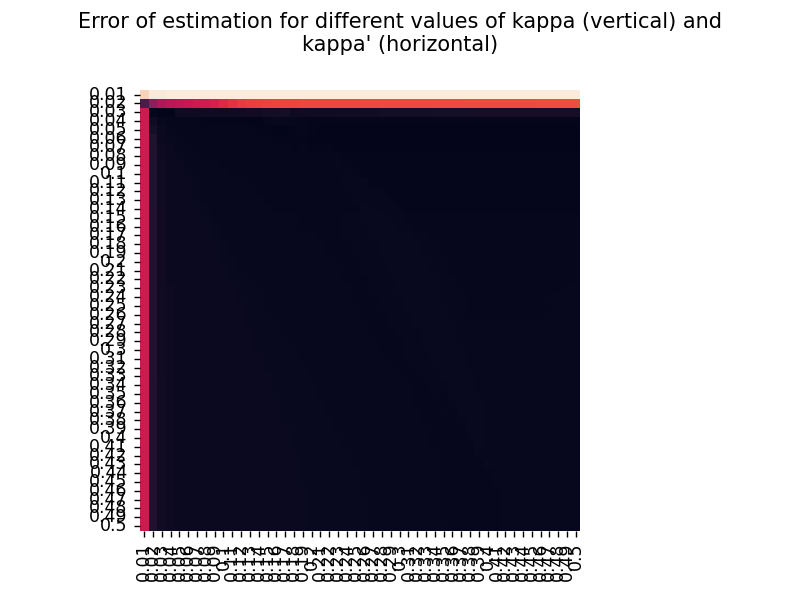

In [35]:
labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]

vmin = all_components_results_molar.min().min()
vmax = all_components_results_molar.max().max()

sns.heatmap(all_components_results_molar.astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
plt.tight_layout(rect=[0, 0, .9, 1])

#### Visible proportions

In [36]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [37]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [38]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


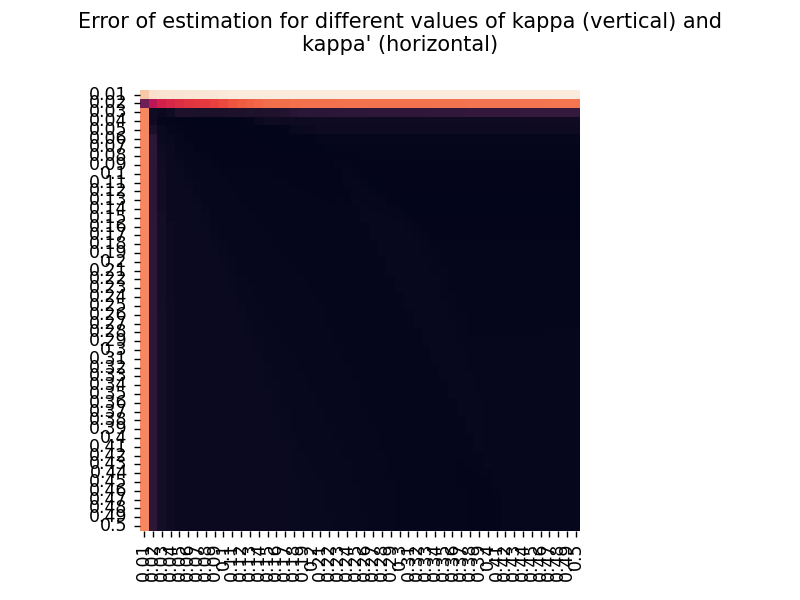

In [39]:
labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]

vmin = all_components_results_vis.min().min()
vmax = all_components_results_vis.max().max()

sns.heatmap(all_components_results_vis.astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
plt.tight_layout(rect=[0, 0, .9, 1])

#### Both

In [40]:
all_components_results_both = all_components_results_vis + all_components_results_molar

In [41]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [42]:
all_components_results_both.min().min()

0.014947790315881448

In [43]:
all_components_results_both[0.2][0.060000000000000005]

0.014947790315881448

### Estimation with best parameters

In [44]:
estimation = estimate_proportions(mix, [comp0, comp1],
                                   MTD=0.06, MTD_th=0.2, verbose=True, solver=pulp.GUROBI())

Initial filtering of formulas: 100%|██████████████| 2/2 [00:00<00:00, 91.11it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(0.457009, 9.01304, 0), (0.457009, 9.01304, 1)]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(0.257009, 9.21304)]


Splitting the experimental spectrum into chunks: 70340it [00:00, 2216983.85it/s]


Ion currents in chunks: [0.9999999999999998]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Deconvolving chunk 0
Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 281359 rows, 70343 columns and 700269 nonzeros
Model fingerprint: 0x80ac0bf4
Coefficient statistics:
  Matrix range     [6e-12, 1e+00]
  Objective range  [7e-12, 1e+00]
  Bounds range     [1e-04, 1e-04]
  RHS range        [1e-04, 2e-01]
Presolve removed 78091 rows and 0 columns
Presolve time: 29.57s
Presolved: 70343 rows, 281358 columns, 700268 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.486e+05
 Factor NZ  : 1.442e+06 (roughly 150 MB of memory)
 Factor Ops : 3.415e+07 (less than 1 second

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:59<00:00, 59.71s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.9897877955100001
Noise proportion in experimental spectrum: 0.010212204484999989
Total explanation: 0.9999999999950001
Noise proportion in combination of theoretical spectra: 0.00593012087


In [45]:
estimation['proportion_of_noise_in_theoretical']

0.005930120869999998

In [45]:
estimated_visible_proportions = estimation['proportions']
estimated_visible_proportions

[0.4543065378329999, 0.5354812576769999]

In [46]:
real_visible_proportions = [prop*prot for prop, prot in zip(molar_proportions, protons)]
real_visible_proportions = [p/sum(real_visible_proportions) for p in real_visible_proportions]
real_visible_proportions 

[0.4565185294551898, 0.5434814705448103]

In [47]:
estimated_molar_proportions = [p/prot for p, prot in zip(estimated_visible_proportions, protons)]
estimated_molar_proportions = [p/sum(estimated_molar_proportions) for p in estimated_molar_proportions]
estimated_molar_proportions 

[0.38886733988386857, 0.6111326601161314]

In [48]:
molar_proportions

[0.3865, 0.6135]

### Visualisation of our estimation

In [49]:
p = np.array(estimated_visible_proportions).reshape(len(estimated_visible_proportions), 1)

In [50]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [51]:
components_ints = [comp_int.reshape(-1,1) for comp_int in components_ints]

In [52]:
X = np.concatenate(components_ints, axis=1)

In [53]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

<IPython.core.display.Javascript object>


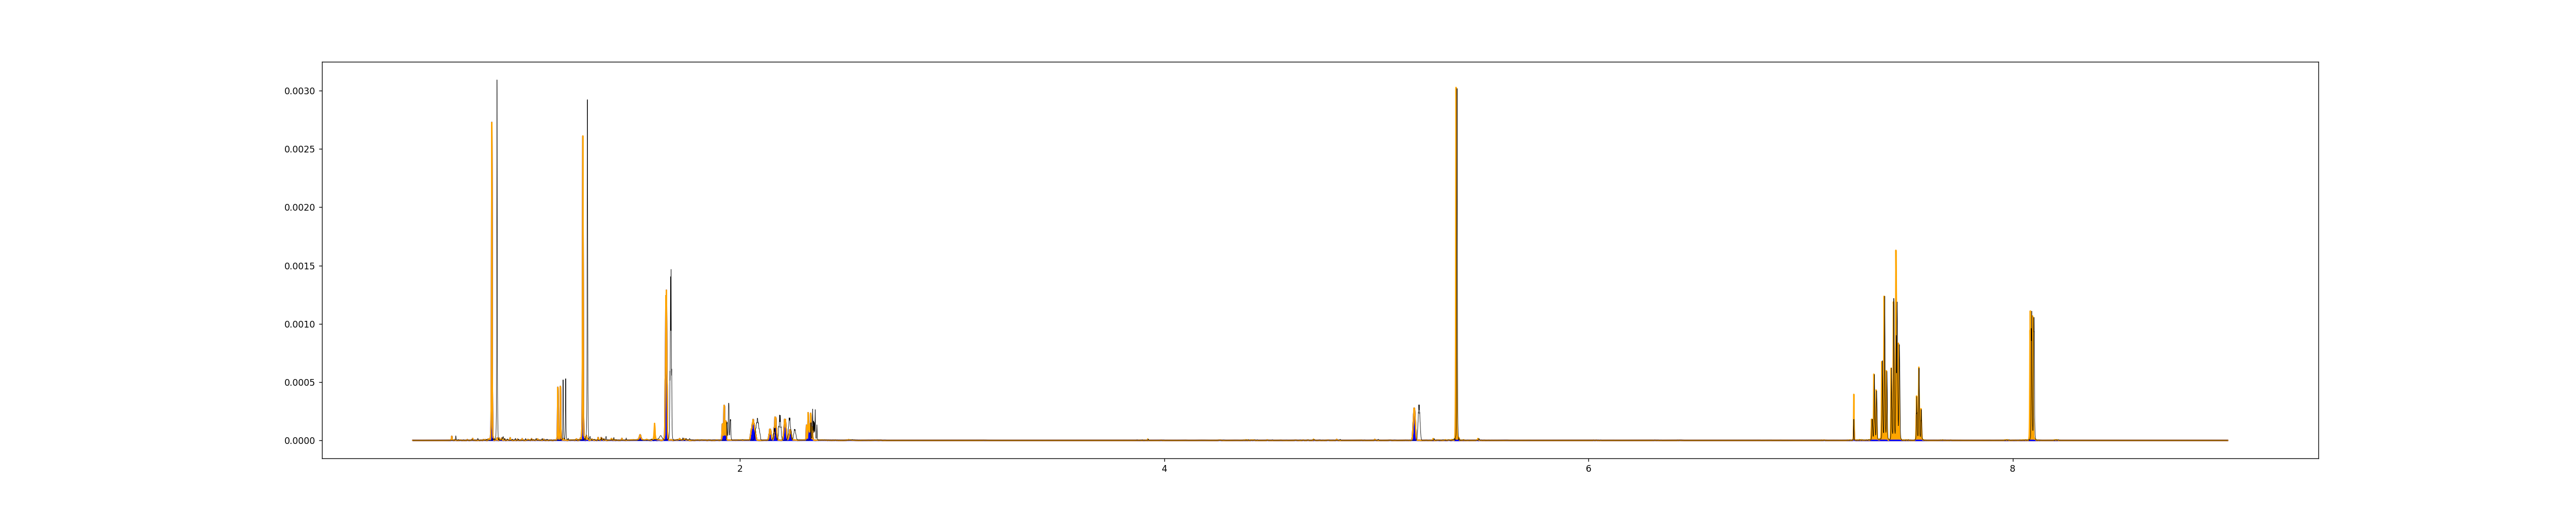

In [54]:
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots()
fig.set_size_inches(40, 8, forward=True)
# ax.set_xlim(57,59.5)
# ax.set_ylim(-0.0001,0.0042)
for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture', linewidth=0.5)